# Phase I: Introduction to Compression Testing

In [ ]:
# @title Environment Setup: Core Libraries for Compression and Data Handling { display-mode: "form" }

!python3 -m pip install -q --upgrade pip
!pip uninstall -y -q sentence-transformers transformers tokenizers
!pip install -q sentence-transformers "tokenizers>=0.14,<0.19"
!pip install -q --upgrade transformers
from sentence_transformers import SentenceTransformer

import numpy as np
import pandas as pd
import scipy.sparse
from scipy.sparse import coo_matrix
import pickle
!pip install -q gdown
import gdown
!pip install -q zarr
import zarr
!pip install -q numcodecs
import numcodecs
import gzip
import io
import os
import re
!pip install -q tables
!pip install -q pyarrow
import pyarrow as pa
import pyarrow.parquet as pq
import shutil
!pip install -q zstandard
import zstandard as zstd
import scipy.sparse as sp

# Check if we are in Google Colab
try:
    import google.colab
    is_colab = True
except ImportError:
    is_colab = False

destination_path = './'

os.makedirs(destination_path, exist_ok=True)

if is_colab:
    print("Running in Colab. Attempting to download data from public source...")
    gdrive_file_id = '1sbx2zZXiMtio7FAehU_8KUii73O-d7-D'
    zip_file_path = './Data.zip'

    try:
        print(f"Downloading Data.zip from Google Drive ID: {gdrive_file_id}...")
        gdown.download(id=gdrive_file_id, output=zip_file_path, quiet=False)
        print("Download complete.")

        print(f"Unzipping {zip_file_path} to {destination_path}...")
        get_ipython().system(f'unzip -q -o {zip_file_path} -d {destination_path}') # -o overwrites without asking
        print("Unzipping complete.")

        os.remove(zip_file_path)
        print(f"Removed {zip_file_path}.")

        source_folder = './TestingArea-Data/Data'
        destination_folder = './' # Current directory

        # Ensure the source folder actually exists
        if not os.path.exists(source_folder):
            print(f"Source folder '{source_folder}' does not exist. Nothing to move.")
        else:
            # List all files and directories in the source folder
            for item_name in os.listdir(source_folder):
                source_item_path = os.path.join(source_folder, item_name)
                destination_item_path = os.path.join(destination_folder, item_name)

                if os.path.exists(destination_item_path):
                    print(f"Warning: '{destination_item_path}' already exists. Skipping '{source_item_path}'.")
                    continue

                try:
                    shutil.move(source_item_path, destination_item_path)
                    #print(f"Moved: '{source_item_path}' -> '{destination_item_path}'")
                except Exception as e:
                    print(f"Error moving '{source_item_path}': {e}")

            if os.path.exists(source_folder) and not os.listdir(source_folder):
                try:
                    shutil.rmtree(source_folder)
                    print(f"Successfully removed empty source folder: '{source_folder}'")
                except Exception as e:
                    print(f"Error removing source folder '{source_folder}': {e}")
            elif os.path.exists(source_folder):
                print(f"Source folder '{source_folder}' is not empty. Did not remove it.")

        print("\nContents of current directory (./):")
        for item in os.listdir(destination_folder):
            if not item.startswith('.') and item != 'Data':
                print(f"  - {item}")

    except Exception as e:
        print(f"An error occurred during download/unzip: {e}")
        print("Please ensure the Google Drive File ID is correct and the file is publicly accessible.")

else:
    print("Not running in Colab. Assuming data is already present locally.")
    if not os.path.exists(destination_path) or not os.listdir(destination_path):
        print(f"Warning: {destination_path} is empty or does not exist. The script might fail.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

/usr/local/lib/python3.11/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [zarr]
Running in Colab. Attempting to download data from public source...


Downloading...
From (original): https://drive.google.com/uc?id=1sbx2zZXiMtio7FAehU_8KUii73O-d7-D
From (redirected): https://drive.google.com/uc?id=1sbx2zZXiMtio7FAehU_8KUii73O-d7-D&confirm=t&uuid=37d6b8e4-275c-4a3f-8aaf-e67c6a7f74e7
To: /content/Data.zip
100%|██████████| 1.12G/1.12G [00:10<00:00, 103MB/s] 


Download complete.
Unzipping ./Data.zip to ./...
Unzipping complete.
Removed ./Data.zip.
Successfully removed empty source folder: './TestingArea-Data/Data'

Contents of current directory (./):
  - identifiedClosestEvalSourcesWiki1010.parquet
  - training_activations.npy
  - test.txt
  - identifiedClosestGeneratedEvalSourcesTestSeed0.parquet
  - TestingArea-Data
  - MNIST_SparseArray.txt
  - identifiedClosestGeneratedEvalSourcesTrainingSeed0.parquet
  - LookUpGPT2
  - identifiedClosestGeneratedEvalSourcesWiki1010.parquet
  - identifiedClosestEvalSourcesTestSeed0.parquet
  - train.txt
  - evaluation_activations.npy
  - TheVerdict.txt
  - identifiedClosestEvalSourcesTrainingSeed0.parquet
  - Wiki_SparseArray_0.txt
  - activations_by_layers.npy
  - Wiki_SparseArray.txt
  - sample_data


In [ ]:
# @title Helper Functions: Sparse Array Manipulation and Compression Metrics { display-mode: "form" }

def load_sparse_3d_array(filename, precision=None):
    # Load the saved sparse data
    data = np.loadtxt(filename)
    indices = data[:, 0].astype(int)
    values = data[:, 1]

    # Apply precision if specified
    if precision is not None:
        values = np.round(values, decimals=precision)

    # Extract shape from the file using regular expression
    with open(filename, 'r') as f:
        for line in f:
            match = re.search(r"# shape:\s*\((.*?)\)", line)
            if match:
                shape = tuple(map(int, match.group(1).split(",")))

    # Reconstruct the full flattened array with zeros
    flat_array = np.zeros(np.prod(shape), dtype=values.dtype)
    flat_array[indices] = values

    # Reshape back to original 3D shape
    return flat_array.reshape(shape)

# Convert sparse matrix to DataFrame
def sparse_array_to_dataframe(sparse_array):
    # Convert sparse CSR matrix to COO format for easy DataFrame creation
    sparse_coo = sparse_array.tocoo()

    # Create DataFrame with 'row', 'col', and 'value' columns
    df = pd.DataFrame({
        'row': sparse_coo.row,
        'col': sparse_coo.col,
        'value': sparse_coo.data
    })

    return df

# Convert dense array to DataFrame
def dense_array_to_dataframe(dense_array):
    df = pd.DataFrame(dense_array.flatten(), columns=['value']).reset_index()
    df['row'], df['col'] = np.divmod(df['index'].values, dense_array.shape[1])
    df = df.drop(columns=['index'])
    return df

# Add Zarr Saving and Size Calculation
def save_dataframe_to_zarr(df: pd.DataFrame, filename: str): # Example function signature
    numpy_data = df.to_numpy()
    shape = numpy_data.shape
    dtype = numpy_data.dtype

    group = zarr.open_group(filename, mode='w')

    try:
        zarr_array = group.create_array(
            name='data',
            shape=shape,
            dtype=dtype,
            compressors=numcodecs.Blosc(cname='zstd', clevel=5, shuffle=numcodecs.Blosc.SHUFFLE),
            overwrite=True
        )

        zarr_array[:] = numpy_data

    finally:
        if hasattr(group.store, 'close') and callable(group.store.close):
            group.store.close()
        return group.store

def compress_dataframe_parquet(df, compressionType):
    # Serialize DataFrame to Parquet format in memory with built-in compression
    buffer = io.BytesIO()
    pq.write_table(pa.Table.from_pandas(df), buffer, compression=compressionType)  # Parquet's own efficient compression

    return buffer.getvalue()

# Function to compress DataFrame using pickle and gzip
def compress_dataframe(df):
    df = df.astype(pd.SparseDtype("float32", np.nan))
    return gzip.compress(pickle.dumps(df))

def compress_dataframe_parquet_gzip(df, compressionType):
    # Serialize DataFrame to Parquet format in memory with built-in compression
    buffer = io.BytesIO()
    pq.write_table(pa.Table.from_pandas(df), buffer, compression=compressionType)  # Parquet's own efficient compression

    # Further compress with gzip
    return gzip.compress(buffer.getvalue())

def print_reduction(original_size, compressed_size, format_name):
    reduction = (original_size - compressed_size) / original_size * 100
    print(f"Reduction with {format_name}: {reduction:.2f}%")

In [ ]:
# @title Experiment: Compression Performance on Sparse and Dense Arrays { display-mode: "form" }

# Convert a dense array for comparison
dense_array = load_sparse_3d_array('Wiki_SparseArray_0.txt')
df_dense = dense_array_to_dataframe(dense_array)

# Reshape the dense array to 2D (if it's 3D, flatten it accordingly)
dense_array_2d = dense_array.reshape(-1, dense_array.shape[-1])  # Flatten to 2D if necessary

# Convert the 2D array to a sparse matrix using CSR format
sparse_array = scipy.sparse.csr_matrix(dense_array_2d)
df_sparse = sparse_array_to_dataframe(sparse_array)

for df, array_type in zip([df_sparse, df_dense], ['Sparse Array', 'Dense Array']):
    print(f"\n--- Processing {array_type} ---")

    output_dir = os.path.expanduser('~/Temp')
    os.makedirs(output_dir, exist_ok=True)

    # Calculate original DataFrame size in memory
    original_size = df.memory_usage(deep=True).sum()

    # Parquet
    parquet_gzip_filename = os.path.join(output_dir, f'data_{array_type.lower().replace(" ", "_")}_gzip.parquet')
    df.to_parquet(parquet_gzip_filename, compression='gzip')
    parquet_gzip_size = os.path.getsize(parquet_gzip_filename)
    os.remove(parquet_gzip_filename)

    # HDF5
    hdf5_filename = os.path.join(output_dir, f'data_{array_type.lower().replace(" ", "_")}.h5')
    with pd.HDFStore(hdf5_filename, mode='w', complib='blosc') as store:
        store.put('dataset', df, format='table', data_columns=True)
    hdf5_size = os.path.getsize(hdf5_filename)
    os.remove(hdf5_filename)

    # CSV
    csv_filename = os.path.join(output_dir, f'data_{array_type.lower().replace(" ", "_")}.csv.gz')
    df.to_csv(csv_filename, index=False, compression='gzip')
    csv_size = os.path.getsize(csv_filename)
    os.remove(csv_filename)

    # Zarr
    zarr_filename = os.path.join(output_dir, f'data_{array_type.lower().replace(" ", "_")}.zarr')
    save_dataframe_to_zarr(df, zarr_filename)
    zarr_size = sum(os.path.getsize(os.path.join(dirpath, file)) for dirpath, _, files in os.walk(zarr_filename) for file in files)
    shutil.rmtree(zarr_filename)

    shutil.rmtree(output_dir)

    # Pickle + Compression Sizes
    pickle_size = len(compress_dataframe(df))
    snappy_size = len(compress_dataframe_parquet(df, 'snappy'))
    zstd_size = len(compress_dataframe_parquet(df, 'zstd'))
    snappy_gzip_size = len(compress_dataframe_parquet_gzip(df, 'snappy'))
    zstd_gzip_size = len(compress_dataframe_parquet_gzip(df, 'zstd'))

    # Output Results
    print(f"Original size (bytes): {original_size}")
    print(f"Parquet (gzip) size (bytes): {parquet_gzip_size}")
    print(f"HDF5 size (bytes): {hdf5_size}")
    print(f"CSV size (bytes): {csv_size}")
    print(f"Zarr size (bytes): {zarr_size}")
    print(f"Parquet (Snappy) size (bytes): {snappy_size}")
    print(f"Parquet (ZSTD) size (bytes): {zstd_size}")
    print(f"Pickle size (bytes): {pickle_size}")
    print(f"Pickle with Parquet (Snappy) size (bytes): {snappy_gzip_size}")
    print(f"Pickle with Parquet (ZSTD) size (bytes): {zstd_gzip_size}")

    # Print Reductions
    print_reduction(original_size, parquet_gzip_size, 'Parquet (gzip)')
    print_reduction(original_size, hdf5_size, 'HDF5')
    print_reduction(original_size, csv_size, 'CSV')
    print_reduction(original_size, snappy_size, 'Snappy')
    print_reduction(original_size, zstd_size, 'ZSTD')
    print_reduction(original_size, zarr_size, 'Zarr')
    print_reduction(original_size, pickle_size, 'Pickle')
    print_reduction(original_size, snappy_gzip_size, 'Parquet & GZIP (Snappy)')
    print_reduction(original_size, zstd_gzip_size, 'Parquet & GZIP (ZSTD)')
    break


--- Processing Sparse Array ---
Original size (bytes): 3400900
Parquet (gzip) size (bytes): 1668160
HDF5 size (bytes): 6975322
CSV size (bytes): 1341197
Zarr size (bytes): 99
Parquet (Snappy) size (bytes): 2147925
Parquet (ZSTD) size (bytes): 1829172
Pickle size (bytes): 1775278
Pickle with Parquet (Snappy) size (bytes): 1652950
Pickle with Parquet (ZSTD) size (bytes): 1788891
Reduction with Parquet (gzip): 50.95%
Reduction with HDF5: -105.10%
Reduction with CSV: 60.56%
Reduction with Snappy: 36.84%
Reduction with ZSTD: 46.22%
Reduction with Zarr: 100.00%
Reduction with Pickle: 47.80%
Reduction with Parquet & GZIP (Snappy): 51.40%
Reduction with Parquet & GZIP (ZSTD): 47.40%


In [ ]:
# @title Integer Compression Strategy: Processing and Loss Evaluation { display-mode: "form" }

def process_array_compression(df_dense, df_sparse, fixed=True):
    # Iterate over the dense and sparse arrays
    for df, array_type in zip([df_sparse, df_dense], ['Sparse Array', 'Dense Array']):
        print(f"\n--- Processing {array_type} ---")

        # Test with different integer types
        for int_type in ['uint8', 'int8', 'uint16', 'int16', 'uint32', 'int32']:
            print(f"\n--- Testing with {int_type} ---")

            # Output directory
            output_dir = os.path.expanduser('~/Temp')
            os.makedirs(output_dir, exist_ok=True)

            # Normalize the data
            if fixed:
                normalized_data, denormalized_data = normalize_to_integer(df.values, int_type)
            else:
                normalized_data, denormalized_data = normalize_dynamic_ranges(df.values, int_type)

            # Convert the normalized data back into a DataFrame to be saved
            df_normalized = pd.DataFrame(normalized_data, columns=df.columns)

            # Calculate the MAE and MSE
            mae, mse = calculate_loss(df.values, denormalized_data)

            # Output the MAE and MSE
            print(f"MAE: {mae}")
            print(f"MSE: {mse}")

            # Calculate original DataFrame size in memory
            original_size = df.memory_usage(deep=True).sum()

            # Step 1: Save DataFrame to Parquet with gzip compression
            parquet_gzip_filename = os.path.join(output_dir, f'data_{array_type.lower().replace(" ", "_")}_gzip.parquet')
            df_normalized.to_parquet(parquet_gzip_filename, compression='gzip')
            parquet_gzip_size = os.path.getsize(parquet_gzip_filename)

            # Remove the Parquet file after processing
            os.remove(parquet_gzip_filename)

            # Step 2: Save DataFrame to HDF5 with gzip compression
            hdf5_filename = os.path.join(output_dir, f'data_{array_type.lower().replace(" ", "_")}.h5')
            with pd.HDFStore(hdf5_filename, mode='w', complib='blosc') as store:
                store.put('dataset', df_normalized, format='table', data_columns=True)
            hdf5_size = os.path.getsize(hdf5_filename)

            # Remove the HDF5 file after processing
            os.remove(hdf5_filename)

            # Step 3: Save DataFrame to CSV (compressed)
            csv_filename = os.path.join(output_dir, f'data_{array_type.lower().replace(" ", "_")}.csv.gz')
            df_normalized.to_csv(csv_filename, index=False, compression='gzip')
            csv_size = os.path.getsize(csv_filename)

            # Remove the CSV file after processing
            os.remove(csv_filename)

            # Remove the output directory after processing
            shutil.rmtree(output_dir)

            # Pickle + Compression Sizes
            pickle_size = len(compress_dataframe(df_normalized))
            snappy_size = len(compress_dataframe_parquet(df_normalized, 'snappy'))
            zstd_size = len(compress_dataframe_parquet(df_normalized, 'zstd'))
            snappy_gzip_size = len(compress_dataframe_parquet_gzip(df_normalized, 'snappy'))
            zstd_gzip_size = len(compress_dataframe_parquet_gzip(df_normalized, 'zstd'))

            # Output Results
            print(f"Original size (bytes): {original_size}")
            print(f"Parquet (gzip) size (bytes): {parquet_gzip_size}")
            print(f"HDF5 size (bytes): {hdf5_size}")
            print(f"CSV size (bytes): {csv_size}")
            print(f"Zarr size (bytes): {zarr_size}")
            print(f"Parquet (Snappy) size (bytes): {snappy_size}")
            print(f"Parquet (ZSTD) size (bytes): {zstd_size}")
            print(f"Pickle size (bytes): {pickle_size}")
            print(f"Pickle with Parquet (Snappy) size (bytes): {snappy_gzip_size}")
            print(f"Pickle with Parquet (ZSTD) size (bytes): {zstd_gzip_size}")

            # Print Reductions
            print_reduction(original_size, parquet_gzip_size, 'Parquet (gzip)')
            print_reduction(original_size, hdf5_size, 'HDF5')
            print_reduction(original_size, csv_size, 'CSV')
            print_reduction(original_size, snappy_size, 'Snappy')
            print_reduction(original_size, zstd_size, 'ZSTD')
            print_reduction(original_size, zarr_size, 'Zarr')
            print_reduction(original_size, pickle_size, 'Pickle')
            print_reduction(original_size, snappy_gzip_size, 'Parquet & GZIP (Snappy)')
            print_reduction(original_size, zstd_gzip_size, 'Parquet & GZIP (ZSTD)')
        break

def calculate_loss(original_data, denormalized_data):
    # Calculate the absolute difference between the original and denormalized data
    loss = np.abs(original_data - denormalized_data)

    # Calculate the Mean Absolute Error (MAE)
    mae = np.mean(loss)

    # Calculate the percentage loss in terms of the range of the original data
    max_val = np.max(original_data)
    min_val = np.min(original_data)
    range_val = max_val - min_val
    loss_percentage = (mae / range_val) * 100

    return mae, loss_percentage

# Define integer ranges based on the selected type
int_ranges = {
    'uint8': (0, 255),
    'int8': (-128, 127),
    'uint16': (0, 65535),
    'int16': (-32768, 32767),
    'uint32': (0, 4294967295),
    'int32': (-2147483648, 2147483647)
}

In [ ]:
# @title Integer Compression: Applying Fixed Normalization Ranges { display-mode: "form" }

def normalize_to_integer(data, int_type='uint8'):
    if int_type not in int_ranges:
        raise ValueError("Unsupported integer type. Choose from 'uint8', 'int8', 'uint16', 'int16', 'uint32', 'int32'.")

    min_int, max_int = int_ranges[int_type]

    # Calculate min and max of the data
    min_val = np.min(data)
    max_val = np.max(data)

    # Normalize data to integer range
    normalized = np.round((data - min_val) * (max_int - min_int) / (max_val - min_val) + min_int).astype(int)

    # Denormalize back to the original float range for comparison
    denormalized = (normalized - min_int) * (max_val - min_val) / (max_int - min_int) + min_val

    return normalized, denormalized

process_array_compression(df_dense, df_sparse, fixed=True)


--- Processing Sparse Array ---

--- Testing with uint8 ---
MAE: 36.33142398571479
MSE: 0.072276918333444
Original size (bytes): 3400900
Parquet (gzip) size (bytes): 3836
HDF5 size (bytes): 7238937
CSV size (bytes): 4554
Zarr size (bytes): 99
Parquet (Snappy) size (bytes): 4811
Parquet (ZSTD) size (bytes): 3767
Pickle size (bytes): 892266
Pickle with Parquet (Snappy) size (bytes): 2553
Pickle with Parquet (ZSTD) size (bytes): 2389
Reduction with Parquet (gzip): 99.89%
Reduction with HDF5: -112.85%
Reduction with CSV: 99.87%
Reduction with Snappy: 99.86%
Reduction with ZSTD: 99.89%
Reduction with Zarr: 100.00%
Reduction with Pickle: 73.76%
Reduction with Parquet & GZIP (Snappy): 99.92%
Reduction with Parquet & GZIP (ZSTD): 99.93%

--- Testing with int8 ---
MAE: 36.33142398571479
MSE: 0.072276918333444
Original size (bytes): 3400900
Parquet (gzip) size (bytes): 3842
HDF5 size (bytes): 7239970
CSV size (bytes): 8222
Zarr size (bytes): 99
Parquet (Snappy) size (bytes): 4809
Parquet (ZSTD)

In [ ]:
# @title Integer Compression: Applying Dynamic Normalization Ranges { display-mode: "form" }

def normalize_dynamic_ranges(data, int_type='uint8'):
    if int_type not in int_ranges:
        raise ValueError("Unsupported integer type. Choose from 'uint8', 'int8', 'uint16', 'int16', 'uint32', 'int32'.")

    min_int, max_int = int_ranges[int_type]

    # Get the dynamic ranges split points
    min_val = np.min(data)
    max_val = np.max(data)

    # Define split points based on your logic (-1, 0, 1)
    split_points = [-1, 0, 1]

    # Create a placeholder for normalized data
    normalized_data = np.zeros_like(data, dtype=int)

    def normalize_range(sub_data, start, end):
        # Normalize within the specific range
        return np.round((sub_data - start) * (max_int - min_int) / (end - start) + min_int).astype(int)

    # Apply normalization for each dynamic range
    for start, end in zip([min_val] + split_points, split_points + [max_val]):
        mask = (data >= start) & (data < end)
        normalized_data[mask] = normalize_range(data[mask], start, end)

    # Denormalize back to original range for comparison
    denormalized_data = np.zeros_like(data, dtype=float)
    for start, end in zip([min_val] + split_points, split_points + [max_val]):
        mask = (normalized_data >= min_int) & (normalized_data <= max_int)
        denormalized_data[mask] = (normalized_data[mask] - min_int) * (end - start) / (max_int - min_int) + start

    return normalized_data, denormalized_data

process_array_compression(df_dense, df_sparse, fixed=False)


--- Processing Sparse Array ---

--- Testing with uint8 ---
MAE: 8425.839175954501
MSE: 16.762175087071945
Original size (bytes): 3400900
Parquet (gzip) size (bytes): 180849
HDF5 size (bytes): 7399018
CSV size (bytes): 345732
Zarr size (bytes): 99
Parquet (Snappy) size (bytes): 216945
Parquet (ZSTD) size (bytes): 157202
Pickle size (bytes): 1143634
Pickle with Parquet (Snappy) size (bytes): 181210
Pickle with Parquet (ZSTD) size (bytes): 155714
Reduction with Parquet (gzip): 94.68%
Reduction with HDF5: -117.56%
Reduction with CSV: 89.83%
Reduction with Snappy: 93.62%
Reduction with ZSTD: 95.38%
Reduction with Zarr: 100.00%
Reduction with Pickle: 66.37%
Reduction with Parquet & GZIP (Snappy): 94.67%
Reduction with Parquet & GZIP (ZSTD): 95.42%

--- Testing with int8 ---
MAE: 8425.760053311724
MSE: 16.762017682264673
Original size (bytes): 3400900
Parquet (gzip) size (bytes): 180921
HDF5 size (bytes): 7400076
CSV size (bytes): 360959
Zarr size (bytes): 99
Parquet (Snappy) size (bytes): 

# Phase II: Evaluation of NLP Model Outputs

In [ ]:
# @title NLP Toolkit Setup for Evaluation (Stanza & Transformers) { display-mode: "form" }

import requests
import urllib.request
!pip install -q stanza
import stanza
# Suppress logging from stanza
nlp = stanza.Pipeline('en', verbose=False)
stanza.download('en', verbose=False)
# Compute cosine similarity
from numpy import dot
from numpy.linalg import norm
from collections import defaultdict
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [stanza]


In [ ]:
# @title Data Generation: Constructing the Training Dataset { display-mode: "form" }

import time

def createTrainSet():
    global sentences, sentencesStructure

    file_path = "TheVerdict.txt"
    url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode('utf-8')
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    # Remove any newline characters and extra spaces
    text_data = text_data.replace("\n", " ").strip()

    # Process the text with Stanza to extract sentences
    doc = nlp(text_data)
    sentencesStructure = [[sentence.text for sentence in doc.sentences]]

    # Flatten the list of sentences correctly
    sentences = [sentence for sublist in sentencesStructure for sentence in sublist]

    print(f"Created a train set with {len(sentences)} sentences")
    return sentences

#sentences = createTrainSet()

# Wikipedia API endpoint for querying
WIKIPEDIA_API_URL = "https://en.wikipedia.org/w/api.php"

def fetch_article_titles(category):
    """Fetch a list of article titles from a Wikipedia category."""
    titles = []
    params = {
        'action': 'query',
        'format': 'json',
        'list': 'categorymembers',
        'cmtitle': f'Category:{category}',
        'cmlimit': 'max'  # Get the maximum number of articles
    }
    response = requests.get(WIKIPEDIA_API_URL, params=params).json()
    for page in response.get('query', {}).get('categorymembers', []):
        titles.append(page['title'])
    return titles

def fetch_and_parse_content(title):
    """Fetch the content of a Wikipedia article and parse it."""
    headers = {
        'User-Agent': 'MyWikiBot/1.0 (your_email@example.com or link_to_project)' # Be descriptive
    }
    params = {
        'action': 'query',
        'format': 'json',
        'titles': title,
        'prop': 'extracts',
        'explaintext': True,
        'redirects': 1 # Automatically resolve redirects
    }
    # Make the response object available in the except block
    api_response = requests.get(WIKIPEDIA_API_URL, params=params, headers=headers)
    api_response.raise_for_status()
    response = requests.get(WIKIPEDIA_API_URL, params=params).json()
    pages = response.get('query', {}).get('pages', {})
    page = next(iter(pages.values()), None)
    content = page.get('extract', '')

    return content

def clean_wikipedia_content(sentences):
    cleaned_sentences = []
    for sentence in sentences:
        # Remove references, citations, and template placeholders
        sentence = re.sub(r'\[\[File:.*?\]\]', '', sentence)  # Remove file/image links (e.g., [[File:Image.jpg]])
        sentence = re.sub(r'\[\[.*?\|.*?\]\]', '', sentence)  # Remove internal links with aliases (e.g., [[Link|Alias]])
        sentence = re.sub(r'\[\[.*?\]\]', '', sentence)      # Remove internal links (e.g., [[Link]])

        sentence = re.sub(r'\{.*?\}', '', sentence)      # Remove templates (e.g., {{Citation needed}} or any template)
        sentence = re.sub(r'==+.*?==+', '', sentence)    # Remove headings (e.g., == Heading ==)
        sentence = re.sub(r'===+.*?===+', '', sentence)  # Remove subheadings (e.g., === Subheading ===)
        sentence = re.sub(r'<!--.*?-->', '', sentence, flags=re.DOTALL)  # Remove comments
        sentence = re.sub(r'\<.*?\>', '', sentence)      # Remove any HTML tags (just in case)

        # Remove irrelevant sections like "See also", "External Links", "References", "Further reading"
        sentence = re.sub(r'\n(See also|External links|References|Further reading)\n.*?(\n|$)', '', sentence, flags=re.DOTALL)

        # Remove anything inside curly brackets (often for templates or references)
        sentence = re.sub(r'\{.*?\}', '', sentence)

        # Clean up extra spaces
        sentence = re.sub(r'\s+', ' ', sentence).strip()

        # Remove short sentences or fragments (less than 3 words)
        if len(sentence.split()) > 2:
            cleaned_sentences.append(sentence.strip())

    return cleaned_sentences

# Function to split cleaned content into sentences
def split_sentences(content, nlp):
    # Process the content with Stanza
    doc = nlp(content)
    # Remove non-informative sentences (those with just punctuation or short sentences)
    sentences = [sentence.text for sentence in doc.sentences if len(sentence.text.split()) > 2]
    return sentences

def createWikiTrainSet(category):
    global sentences, sentencesStructure

    # Fetch a list of article titles from the specified category
    titles = fetch_article_titles(category)
    print(f"Number of titles fetched from category '{category}': {len(titles)}")

    sentencesStructure = []  # Store all sentences from fetched articles

    # Fetch content from each title and split into sentences
    for title in titles:
        content = fetch_and_parse_content(title)

        # Tokenize the paragraph into sentences
        sentence_data = split_sentences(content, nlp)

        # Clean the Wikipedia content
        sentence_data = clean_wikipedia_content(sentence_data)

        # Add the list of sentences for this paragraph
        sentencesStructure.append(sentence_data)

        time.sleep(1)

    sentences = [sentence for sublist in sentencesStructure for sentence in sublist]
    print("Created a training set with " + str(len(sentences)) + " sentences")
    return sentences

sentences = createWikiTrainSet("sports")

Number of titles fetched from category 'sports': 49
Created a training set with 193 sentences


In [ ]:
# @title Sample Data: Defining Generated Source Sentences { display-mode: "form" }

generatedSourceSentences = ['meeting, sports meeting admitting a single, meeting this meeting meeting this meeting meeting this meeting meeting some cases meeting meeting meeting this meeting meeting this definition.', 'with major competitions sports this meeting meeting this and skills, generally., some are cases, some as system meeting meeting this meeting meeting.', ', sports meeting, format, sports meeting some format, producing meeting sports meeting sports participant athleticism major competitions sports sports meeting.', 'sports provide tie-breaking methods any ensure one winner., some with some sports, which done.', ', which different.', 'as sports, such, such, some individuals, some, such, regular as the, such some admitting admitting, some, some individuals, some, such as sports meeting sports, such- some, suchdraw sports, some meeting some the some and, some sports as sports, sports season.. as sports meeting, such as the some cases, such numbers individuals cases, some, such, such as sports as the, such as sports meeting some individuals cases,, some, some as sports meeting, sports.', 'draw one, such form and skills.', ', are others one.', 'a spectators, followed sports being sports.', '. a single skills individuals, which a single person person sports different meeting sports.']

In [ ]:
# @title Model Loading: Initializing the Language Model and Tokenizer { display-mode: "form" }

layerAmount = 2

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": layerAmount,         # Number of attention heads
    "n_layers": layerAmount,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

LLM_Layers = [[('Embedding', GPT_CONFIG_124M["emb_dim"], GPT_CONFIG_124M["emb_dim"]),
         ('Embedding', GPT_CONFIG_124M["emb_dim"], GPT_CONFIG_124M["emb_dim"]),
         ('Dropout', GPT_CONFIG_124M["emb_dim"], GPT_CONFIG_124M["drop_rate"])
         ], [('Sequential', GPT_CONFIG_124M["emb_dim"], 4 * GPT_CONFIG_124M["emb_dim"]),
         ('LayerNorm', GPT_CONFIG_124M["emb_dim"], GPT_CONFIG_124M["emb_dim"]),
         ('Linear', GPT_CONFIG_124M["vocab_size"], GPT_CONFIG_124M["emb_dim"])]]

TransformerBlockLayer = [('LayerNorm', GPT_CONFIG_124M["emb_dim"], GPT_CONFIG_124M["emb_dim"]),
('Linear', GPT_CONFIG_124M["emb_dim"], GPT_CONFIG_124M["emb_dim"]),
('Linear', GPT_CONFIG_124M["emb_dim"], GPT_CONFIG_124M["emb_dim"]),
('Linear', GPT_CONFIG_124M["emb_dim"], GPT_CONFIG_124M["emb_dim"]),
('Dropout', GPT_CONFIG_124M["emb_dim"], GPT_CONFIG_124M["drop_rate"]),
('Linear', GPT_CONFIG_124M["emb_dim"], GPT_CONFIG_124M["emb_dim"]),
('MultiHeadAttention', GPT_CONFIG_124M["emb_dim"], GPT_CONFIG_124M["emb_dim"]),
('Dropout', GPT_CONFIG_124M["emb_dim"], GPT_CONFIG_124M["drop_rate"]),
('LayerNorm', GPT_CONFIG_124M["emb_dim"], GPT_CONFIG_124M["emb_dim"]),
('Linear', GPT_CONFIG_124M["emb_dim"], 4 * GPT_CONFIG_124M["emb_dim"]),
('GELU', 4 * GPT_CONFIG_124M["emb_dim"], 4 * GPT_CONFIG_124M["emb_dim"]),
('Linear', 4 * GPT_CONFIG_124M["emb_dim"], GPT_CONFIG_124M["emb_dim"]),
('Sequential', GPT_CONFIG_124M["emb_dim"], 4 * GPT_CONFIG_124M["emb_dim"]),
('FeedForward', GPT_CONFIG_124M["emb_dim"], 4 * GPT_CONFIG_124M["emb_dim"]),
('Dropout', GPT_CONFIG_124M["emb_dim"], GPT_CONFIG_124M["drop_rate"]),
('TransformerBlock', GPT_CONFIG_124M["emb_dim"], GPT_CONFIG_124M["emb_dim"])
]

hidden_sizes = []
hidden_sizes.append(LLM_Layers[0])
for _ in range(layerAmount):
    hidden_sizes.append(TransformerBlockLayer)
hidden_sizes.append(LLM_Layers[1])
hidden_sizes = [item for sublist in hidden_sizes for item in sublist]

In [ ]:
# @title Data Inspection: Loading and Previewing Parquet DataFrames { display-mode: "form" }

# Read the Parquet file into a DataFrame
evalDf = pq.read_table('./identifiedClosestEvalSourcesWiki1010.parquet').to_pandas(safe=False)

# Display the DataFrame
print("Evaluation Sample")
print(evalDf.head(10), "\n") # View the first 10 rows
print(evalDf.tail(10), "\n") # View the last 10 rows
print(evalDf.info(), "\n")  # Show column types and non-null counts

# Read the Parquet file into a DataFrame
generatedEvalDf = pq.read_table('./identifiedClosestGeneratedEvalSourcesWiki1010.parquet').to_pandas(safe=False)

# Display the DataFrame
#print("Generated Evaluation Sample")
#print(generatedEvalDf.head(10), "\n") # View the first 10 rows
#print(generatedEvalDf.tail(10), "\n") # View the last 10 rows
#print(generatedEvalDf.info())  # Show column types and non-null counts

Evaluation Sample
            layer  neuron source  eval_neuron_value  neuron_value  difference
evalSample                                                                   
0               0       0    0:3           0.828838     -0.787064   -1.054130
0               0       0    0:7           0.828838     -0.787064   -1.054130
0               0       0    0:4           0.828838     -0.719139   -0.922670
0               0       0    0:1           0.828838     -0.685918   -0.861161
0               0       0    0:2           0.828838     -0.051844   -0.037843
0               0       0    0:6           0.828838      0.969789    0.113296
0               0       0    0:0           0.828838      1.064033    0.207421
0               0       0    0:8           0.828838      1.064033    0.207421
0               0       1    0:6          -0.169635      0.600388   -0.078424
0               0       1    0:0          -0.169635      0.302192   -0.024187 

            layer  neuron source  eval_neuro

In [ ]:
# @title Experiment: Testing Feature Weighting Modes { display-mode: "form" }

evaluationSamples = len(evalDf.index.unique())
trainSamples = len(evalDf['source'].unique())

# Exponential decay with a capped value to avoid overflow
def exponential_decay(weights, decay_rate=0.05, max_val=1e100):
    decay_values = np.exp(-decay_rate * np.array(weights))
    decay_values[decay_values > max_val] = max_val  # Cap values
    return decay_values

# Function to handle mode calculation safely
def safe_mode(values):
    try:
        mode_value = stats.mode(values)[0][0]
        return mode_value
    except:
        # Return a fallback value (e.g., 0) if mode cannot be calculated
        return 0

# Function to handle percentile calculation safely
def safe_percentile(values, percentile=90):
    try:
        return np.percentile(values, percentile)
    except:
        # Return a fallback value (e.g., the median) if percentile cannot be calculated
        return np.median(values)

def getMostUsedFromDataFrame(df, evalSample, closestSources, weightedMode="", info=True):
    # Filter entries for the specific evalSample
    relevant_entries = df[df.index.get_level_values('evalSample') == evalSample]

    # Use value_counts to count occurrences of each source directly
    sources = relevant_entries['source']

    # Filter out invalid sources ('None')
    valid_entries = relevant_entries[sources != 'None']
    ascending_order = True  # Sort by ascending for lowest average weights

    if valid_entries.empty:
        # Handle cases where there are no valid entries
        print(f"No valid entries for evalSample {evalSample}")
        return 0, []

    # Initialize weighted_counts to None for error handling
    weighted_counts = None

    if weightedMode == "Sum":
        # Group by 'source' and sum the 'difference' column as weights
        weighted_counts = valid_entries.groupby('source')['difference'].sum()

    elif weightedMode == "Mean":
        # Group by 'source' and calculate the average of 'difference'
        weighted_counts = valid_entries.groupby('source')['difference'].mean()

    elif weightedMode == "Median":
        # Group by 'source' and calculate the median of 'difference'
        weighted_counts = valid_entries.groupby('source')['difference'].median()

    elif weightedMode == "Mode":
        # Get the most frequent source (mode)
        weighted_counts = valid_entries['source'].mode()
        if weighted_counts.empty:
            weighted_counts = pd.Series([0])  # Fallback if no mode found

    elif weightedMode == "ExponentialDecay":
        # Apply exponential decay to the 'difference' values
        valid_entries['weighted_difference'] = exponential_decay(valid_entries['difference'])
        weighted_counts = valid_entries.groupby('source')['weighted_difference'].sum()

    elif weightedMode == "Percentile":
        # Use percentile-based filtering (example: Top 75%)
        percentile_threshold = 0.75  # For example, top 25%
        cutoff_value = safe_percentile(valid_entries['difference'], percentile_threshold * 100)
        filtered_entries = valid_entries[valid_entries['difference'] >= cutoff_value]
        weighted_counts = filtered_entries['source'].value_counts()

    else:
        # Default behavior: Count occurrences
        weighted_counts = valid_entries['source'].value_counts()
        ascending_order = False  # Sort by descending for highest counts

    # Handle case when weighted_counts is None (for non-valid weighted modes)
    if weighted_counts is None or weighted_counts.empty:
        print(f"No valid weighted counts for evalSample {evalSample} with mode {weightedMode}")
        return 0, []

    # Sort weighted sources by the determined order
    sorted_sources = weighted_counts.sort_values(ascending=ascending_order).head(closestSources)
    # Total weight (sum, mean, median, or total count for closest sources)
    total_weight = sorted_sources.sum()

    # Convert to a Counter-like output (sorted already by the determined order)
    counter = []
    for source, weight in sorted_sources.items():
        if isinstance(source, str):  # If source is a string (e.g., "0:123")
            source = int(source.replace("0:", ""))
        counter.append((source, weight))

    if info:
        # Print the total weight (sum, mean, or total count depending on the mode)
        print(f"Total Weight for Weighted Mode={weightedMode}: {total_weight}")

    if info:
        print(f"Total closest Sources (Weighted Mode={weightedMode}):", total_weight,
              "|", closestSources, "closest Sources in format [SourceNumber, Weight]:", counter)

    # Return the sorted sources and the counter
    return sorted_sources, counter

# Example usage of the updated function
for evaluationSample in range(evaluationSamples):
    print(f"Most used for Evaluation Sample {evaluationSample+6}")
    getMostUsedFromDataFrame(evalDf, evaluationSample, trainSamples, "Mean", True)
    getMostUsedFromDataFrame(evalDf, evaluationSample, trainSamples, "Sum", True)
    getMostUsedFromDataFrame(evalDf, evaluationSample, trainSamples, "Median", True)
    #getMostUsedFromDataFrame(evalDf, evaluationSample, trainSamples, "Mode", True)
    getMostUsedFromDataFrame(evalDf, evaluationSample, trainSamples, "ExponentialDecay", True)
    getMostUsedFromDataFrame(evalDf, evaluationSample, trainSamples, "Percentile", True)
    print()

Most used for Evaluation Sample 6
Total Weight for Weighted Mode=Mean: 434.80067818436305
Total closest Sources (Weighted Mode=Mean): 434.80067818436305 | 10 closest Sources in format [SourceNumber, Weight]: [(0, -213.31245858155924), (1, -38.445456779020056), (8, 28.93729636015812), (6, 49.959052998861395), (5, 52.5449816569437), (4, 88.44749899615151), (2, 110.4298298415942), (3, 168.83703597344913), (7, 187.40289771778424)]
Total Weight for Weighted Mode=Sum: 36580759.55538227
Total closest Sources (Weighted Mode=Sum): 36580759.55538227 | 10 closest Sources in format [SourceNumber, Weight]: [(0, -18010824.127875373), (1, -3247795.297778056), (8, 2442944.4333172687), (6, 4204803.695649169), (5, 4397331.8799246475), (4, 7441530.328041207), (2, 9323369.673866116), (3, 14235832.362173311), (7, 15793566.608063985)]
Total Weight for Weighted Mode=Median: 302.53021362423897
Total closest Sources (Weighted Mode=Median): 302.53021362423897 | 10 closest Sources in format [SourceNumber, Weight

<ipython-input-12-3241793139c3>:8: RuntimeWarning: overflow encountered in exp
  decay_values = np.exp(-decay_rate * np.array(weights))


Total Weight for Weighted Mode=ExponentialDecay: 4.9112963525165944e+103
Total closest Sources (Weighted Mode=ExponentialDecay): 4.9112963525165944e+103 | 10 closest Sources in format [SourceNumber, Weight]: [(5, 2.1748912316192388e+102), (7, 3.357652786266127e+102), (3, 3.591775771053462e+102), (4, 4.525911972536088e+102), (2, 4.843545232443671e+102), (6, 6.077491574544518e+102), (8, 6.207282089642434e+102), (1, 7.453458360925516e+102), (0, 1.0880954506134885e+103)]
Total Weight for Weighted Mode=Percentile: 189586
Total closest Sources (Weighted Mode=Percentile): 189586 | 10 closest Sources in format [SourceNumber, Weight]: [(0, 4148), (5, 4746), (6, 6286), (4, 10407), (8, 16680), (3, 27258), (2, 30305), (1, 44014), (7, 45742)]

Most used for Evaluation Sample 7
Total Weight for Weighted Mode=Mean: 434.80067818436305
Total closest Sources (Weighted Mode=Mean): 434.80067818436305 | 10 closest Sources in format [SourceNumber, Weight]: [(0, -213.31245858155924), (1, -38.445456779020056)

<ipython-input-12-3241793139c3>:8: RuntimeWarning: overflow encountered in exp
  decay_values = np.exp(-decay_rate * np.array(weights))


Total Weight for Weighted Mode=ExponentialDecay: 4.9112963525165944e+103
Total closest Sources (Weighted Mode=ExponentialDecay): 4.9112963525165944e+103 | 10 closest Sources in format [SourceNumber, Weight]: [(5, 2.1748912316192388e+102), (7, 3.357652786266127e+102), (3, 3.591775771053462e+102), (4, 4.525911972536088e+102), (2, 4.843545232443671e+102), (6, 6.077491574544518e+102), (8, 6.207282089642434e+102), (1, 7.453458360925516e+102), (0, 1.0880954506134885e+103)]
Total Weight for Weighted Mode=Percentile: 189586
Total closest Sources (Weighted Mode=Percentile): 189586 | 10 closest Sources in format [SourceNumber, Weight]: [(0, 4148), (5, 4746), (6, 6286), (4, 10407), (8, 16680), (3, 27258), (2, 30305), (1, 44014), (7, 45742)]

Most used for Evaluation Sample 8
Total Weight for Weighted Mode=Mean: 434.80067818436305
Total closest Sources (Weighted Mode=Mean): 434.80067818436305 | 10 closest Sources in format [SourceNumber, Weight]: [(0, -213.31245858155924), (1, -38.445456779020056)

<ipython-input-12-3241793139c3>:8: RuntimeWarning: overflow encountered in exp
  decay_values = np.exp(-decay_rate * np.array(weights))


Total Weight for Weighted Mode=ExponentialDecay: 4.9112963525165944e+103
Total closest Sources (Weighted Mode=ExponentialDecay): 4.9112963525165944e+103 | 10 closest Sources in format [SourceNumber, Weight]: [(5, 2.1748912316192388e+102), (7, 3.357652786266127e+102), (3, 3.591775771053462e+102), (4, 4.525911972536088e+102), (2, 4.843545232443671e+102), (6, 6.077491574544518e+102), (8, 6.207282089642434e+102), (1, 7.453458360925516e+102), (0, 1.0880954506134885e+103)]
Total Weight for Weighted Mode=Percentile: 189586
Total closest Sources (Weighted Mode=Percentile): 189586 | 10 closest Sources in format [SourceNumber, Weight]: [(0, 4148), (5, 4746), (6, 6286), (4, 10407), (8, 16680), (3, 27258), (2, 30305), (1, 44014), (7, 45742)]

Most used for Evaluation Sample 9
Total Weight for Weighted Mode=Mean: 434.80067818436305
Total closest Sources (Weighted Mode=Mean): 434.80067818436305 | 10 closest Sources in format [SourceNumber, Weight]: [(0, -213.31245858155924), (1, -38.445456779020056)

<ipython-input-12-3241793139c3>:8: RuntimeWarning: overflow encountered in exp
  decay_values = np.exp(-decay_rate * np.array(weights))


Total Weight for Weighted Mode=ExponentialDecay: 4.9112963525165944e+103
Total closest Sources (Weighted Mode=ExponentialDecay): 4.9112963525165944e+103 | 10 closest Sources in format [SourceNumber, Weight]: [(5, 2.1748912316192388e+102), (7, 3.357652786266127e+102), (3, 3.591775771053462e+102), (4, 4.525911972536088e+102), (2, 4.843545232443671e+102), (6, 6.077491574544518e+102), (8, 6.207282089642434e+102), (1, 7.453458360925516e+102), (0, 1.0880954506134885e+103)]
Total Weight for Weighted Mode=Percentile: 189586
Total closest Sources (Weighted Mode=Percentile): 189586 | 10 closest Sources in format [SourceNumber, Weight]: [(0, 4148), (5, 4746), (6, 6286), (4, 10407), (8, 16680), (3, 27258), (2, 30305), (1, 44014), (7, 45742)]

Most used for Evaluation Sample 10
Total Weight for Weighted Mode=Mean: 166.7276917866429
Total closest Sources (Weighted Mode=Mean): 166.7276917866429 | 10 closest Sources in format [SourceNumber, Weight]: [(9, -277.9249410218093), (0, -210.29878299965097), 

<ipython-input-12-3241793139c3>:8: RuntimeWarning: overflow encountered in exp
  decay_values = np.exp(-decay_rate * np.array(weights))


Total Weight for Weighted Mode=ExponentialDecay: 4.8346852121535536e+103
Total closest Sources (Weighted Mode=ExponentialDecay): 4.8346852121535536e+103 | 10 closest Sources in format [SourceNumber, Weight]: [(9, 9.00004397857834e+100), (5, 2.0410979468721548e+102), (7, 3.296967732339879e+102), (3, 3.54177559492618e+102), (4, 4.375788882086329e+102), (2, 4.843545232443671e+102), (6, 5.996210465362959e+102), (8, 6.11728164985665e+102), (1, 7.453458360925501e+102), (0, 1.059072581693643e+103)]
Total Weight for Weighted Mode=Percentile: 189578
Total closest Sources (Weighted Mode=Percentile): 189578 | 10 closest Sources in format [SourceNumber, Weight]: [(9, 175), (0, 4104), (5, 4712), (6, 6268), (4, 10424), (8, 16532), (3, 27278), (2, 30360), (1, 44010), (7, 45715)]

Most used for Evaluation Sample 11
Total Weight for Weighted Mode=Mean: 432.89977109432687
Total closest Sources (Weighted Mode=Mean): 432.89977109432687 | 10 closest Sources in format [SourceNumber, Weight]: [(0, -215.26585

<ipython-input-12-3241793139c3>:8: RuntimeWarning: overflow encountered in exp
  decay_values = np.exp(-decay_rate * np.array(weights))


Total Weight for Weighted Mode=ExponentialDecay: 4.9112963525165944e+103
Total closest Sources (Weighted Mode=ExponentialDecay): 4.9112963525165944e+103 | 10 closest Sources in format [SourceNumber, Weight]: [(9, 764.2132481950651), (5, 2.1748912316192388e+102), (7, 3.357652786266127e+102), (3, 3.591775771053462e+102), (4, 4.525911972536088e+102), (2, 4.843545232443671e+102), (6, 6.077491574544518e+102), (8, 6.207282089642434e+102), (1, 7.453458360925516e+102), (0, 1.0880954506134885e+103)]
Total Weight for Weighted Mode=Percentile: 189586
Total closest Sources (Weighted Mode=Percentile): 189586 | 10 closest Sources in format [SourceNumber, Weight]: [(0, 4148), (5, 4746), (6, 6286), (4, 10407), (8, 16680), (3, 27258), (2, 30305), (1, 44014), (7, 45742)]

Most used for Evaluation Sample 12
Total Weight for Weighted Mode=Mean: 434.80067818436305
Total closest Sources (Weighted Mode=Mean): 434.80067818436305 | 10 closest Sources in format [SourceNumber, Weight]: [(0, -213.31245858155924),

<ipython-input-12-3241793139c3>:8: RuntimeWarning: overflow encountered in exp
  decay_values = np.exp(-decay_rate * np.array(weights))


Total Weight for Weighted Mode=ExponentialDecay: 4.9112963525165944e+103
Total closest Sources (Weighted Mode=ExponentialDecay): 4.9112963525165944e+103 | 10 closest Sources in format [SourceNumber, Weight]: [(5, 2.1748912316192388e+102), (7, 3.357652786266127e+102), (3, 3.591775771053462e+102), (4, 4.525911972536088e+102), (2, 4.843545232443671e+102), (6, 6.077491574544518e+102), (8, 6.207282089642434e+102), (1, 7.453458360925516e+102), (0, 1.0880954506134885e+103)]
Total Weight for Weighted Mode=Percentile: 189586
Total closest Sources (Weighted Mode=Percentile): 189586 | 10 closest Sources in format [SourceNumber, Weight]: [(0, 4148), (5, 4746), (6, 6286), (4, 10407), (8, 16680), (3, 27258), (2, 30305), (1, 44014), (7, 45742)]

Most used for Evaluation Sample 13
Total Weight for Weighted Mode=Mean: 401.5360922082798
Total closest Sources (Weighted Mode=Mean): 401.5360922082798 | 10 closest Sources in format [SourceNumber, Weight]: [(0, -213.31245858155924), (1, -38.445456779020056),

<ipython-input-12-3241793139c3>:8: RuntimeWarning: overflow encountered in exp
  decay_values = np.exp(-decay_rate * np.array(weights))


Total Weight for Weighted Mode=ExponentialDecay: 5.061297095716803e+103
Total closest Sources (Weighted Mode=ExponentialDecay): 5.061297095716803e+103 | 10 closest Sources in format [SourceNumber, Weight]: [(5, 2.1748912316192388e+102), (7, 3.357652786266127e+102), (3, 3.591775771053462e+102), (4, 4.525911972536088e+102), (6, 6.077491574544518e+102), (8, 6.207282089642434e+102), (2, 6.343552664445753e+102), (1, 7.453458360925516e+102), (0, 1.0880954506134885e+103)]
Total Weight for Weighted Mode=Percentile: 189757
Total closest Sources (Weighted Mode=Percentile): 189757 | 10 closest Sources in format [SourceNumber, Weight]: [(0, 4148), (5, 4743), (6, 6285), (4, 10395), (8, 16659), (3, 27234), (2, 30593), (1, 43981), (7, 45719)]

Most used for Evaluation Sample 14
Total Weight for Weighted Mode=Mean: 434.80067818436305
Total closest Sources (Weighted Mode=Mean): 434.80067818436305 | 10 closest Sources in format [SourceNumber, Weight]: [(0, -213.31245858155924), (1, -38.445456779020056),

<ipython-input-12-3241793139c3>:8: RuntimeWarning: overflow encountered in exp
  decay_values = np.exp(-decay_rate * np.array(weights))


Total Weight for Weighted Mode=ExponentialDecay: 4.9112963525165944e+103
Total closest Sources (Weighted Mode=ExponentialDecay): 4.9112963525165944e+103 | 10 closest Sources in format [SourceNumber, Weight]: [(5, 2.1748912316192388e+102), (7, 3.357652786266127e+102), (3, 3.591775771053462e+102), (4, 4.525911972536088e+102), (2, 4.843545232443671e+102), (6, 6.077491574544518e+102), (8, 6.207282089642434e+102), (1, 7.453458360925516e+102), (0, 1.0880954506134885e+103)]
Total Weight for Weighted Mode=Percentile: 189586
Total closest Sources (Weighted Mode=Percentile): 189586 | 10 closest Sources in format [SourceNumber, Weight]: [(0, 4148), (5, 4746), (6, 6286), (4, 10407), (8, 16680), (3, 27258), (2, 30305), (1, 44014), (7, 45742)]

Most used for Evaluation Sample 15
Total Weight for Weighted Mode=Mean: 434.80067818436305
Total closest Sources (Weighted Mode=Mean): 434.80067818436305 | 10 closest Sources in format [SourceNumber, Weight]: [(0, -213.31245858155924), (1, -38.445456779020056

<ipython-input-12-3241793139c3>:8: RuntimeWarning: overflow encountered in exp
  decay_values = np.exp(-decay_rate * np.array(weights))


Total Weight for Weighted Mode=ExponentialDecay: 4.9112963525165944e+103
Total closest Sources (Weighted Mode=ExponentialDecay): 4.9112963525165944e+103 | 10 closest Sources in format [SourceNumber, Weight]: [(5, 2.1748912316192388e+102), (7, 3.357652786266127e+102), (3, 3.591775771053462e+102), (4, 4.525911972536088e+102), (2, 4.843545232443671e+102), (6, 6.077491574544518e+102), (8, 6.207282089642434e+102), (1, 7.453458360925516e+102), (0, 1.0880954506134885e+103)]
Total Weight for Weighted Mode=Percentile: 189586
Total closest Sources (Weighted Mode=Percentile): 189586 | 10 closest Sources in format [SourceNumber, Weight]: [(0, 4148), (5, 4746), (6, 6286), (4, 10407), (8, 16680), (3, 27258), (2, 30305), (1, 44014), (7, 45742)]



In [ ]:
# @title Core Metric: Calculating Sentence Similarity Scores { display-mode: "form" }

# Load a pre-trained model (e.g., 'all-MiniLM-L6-v2')
model = SentenceTransformer('all-MiniLM-L6-v2')

def compute_cosine_similarity(embedding1, embedding2):
    return dot(embedding1, embedding2) / (norm(embedding1) * norm(embedding2))

# Function to compute both cosine and Euclidean similarity
def compute_similarity(evalEmbedding, trainEmbedding, metrics=['cosine', 'euclidean']):
    similarities = []

    if 'cosine' in metrics:
        # Cosine similarity
        cosine_sim = cosine_similarity([evalEmbedding], [trainEmbedding])[0][0]
        similarities.append(('cosine', cosine_sim))

    if 'euclidean' in metrics:
        # Euclidean distance (we invert it to make it a similarity)
        euclidean_dist = euclidean_distances([evalEmbedding], [trainEmbedding])[0][0]
        euclidean_sim = -euclidean_dist  # Invert distance to create a similarity score
        similarities.append(('euclidean', euclidean_sim))

    return similarities

# Updated function to extract sentence similarity
def extractSentenceSimilarity(name, info=True, metrics=['cosine', 'euclidean']):
    if info:
        print(f"Checking Similarity for {name}-Sample")

    # Dictionary to store all similarities for evaluation samples
    similarities_dict = {}

    # Iterate over each evaluation sample
    for evaluationSample in range(evaluationSamples):  # Adjust range based on your dataset
        evalSample = sentences[evaluationSample + 6]  # Adjust index based on your dataset
        evalEmbedding = model.encode(evalSample)

        # List to store similarities for each training sample
        similarities = []

        # Iterate over each training sample
        for trainingSample in range(trainSamples):  # Adjust based on your dataset
            trainSample = sentences[trainingSample]
            trainEmbedding = model.encode(trainSample)

            # Compute both cosine and Euclidean similarity
            metric_similarities = compute_similarity(evalEmbedding, trainEmbedding, metrics)

            # Combine the metrics (here we average them for simplicity)
            combined_similarity = np.mean([sim for _, sim in metric_similarities])

            # Append the combined similarity score along with the training sample index
            similarities.append((trainingSample, combined_similarity))

        # Sort the training samples by their combined similarity to the evaluation sample (highest similarity first)
        sorted_similarities = sorted(similarities, key=lambda x: x[1], reverse=True)

        # Save the sorted similarities to the dictionary
        similarities_dict[evaluationSample] = sorted_similarities

        if info:
            # Print the sorted train samples by their combined similarity to the evaluation sample
            print(f"Sorted relevance for evaluation sample {evaluationSample + 6}:")
            for trainingSample, similarity in sorted_similarities:
                print(f"Training sample: '{trainingSample}' - Combined Similarity: {similarity:.4f}")
            print()

    # Return the dictionary of similarities
    return similarities_dict

# Example function calls with dataframes
sentenceSimilarity = extractSentenceSimilarity("Evaluation", True, metrics=['cosine', 'euclidean'])
#extractSentenceSimilarity("Generated Evaluation")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Checking Similarity for Evaluation-Sample
Sorted relevance for evaluation sample 6:
Training sample: '6' - Combined Similarity: 0.5000
Training sample: '7' - Combined Similarity: -0.1120
Training sample: '5' - Combined Similarity: -0.1586
Training sample: '3' - Combined Similarity: -0.2395
Training sample: '4' - Combined Similarity: -0.2580
Training sample: '1' - Combined Similarity: -0.3670
Training sample: '8' - Combined Similarity: -0.3923
Training sample: '2' - Combined Similarity: -0.4165
Training sample: '9' - Combined Similarity: -0.4429
Training sample: '0' - Combined Similarity: -0.4851

Sorted relevance for evaluation sample 7:
Training sample: '7' - Combined Similarity: 0.5000
Training sample: '6' - Combined Similarity: -0.1120
Training sample: '4' - Combined Similarity: -0.1435
Training sample: '5' - Combined Similarity: -0.2346
Training sample: '3' - Combined Similarity: -0.2691
Training sample: '8' - Combined Similarity: -0.2882
Training sample: '1' - Combined Similarity:

In [ ]:
# @title Validation: Evaluating Consistency of Weighting Modes { display-mode: "form" }

def evaluate_mode_consistency(similarity_scores, relevance_scores_sum, relevance_scores_mean, relevance_scores_median, k=5):
    # Helper function to normalize
    def normalize(scores):
        # Normalize values to [0, 1] range
        values = [v for _, v in scores]
        min_val = min(values)
        max_val = max(values)
        return {k: (v - min_val) / (max_val - min_val) for k, v in scores}

    def spearman_rank_correlation(x, y):
        if len(x) != len(y):
            raise ValueError("Both lists must have the same length.")

        n = len(x)

        # Rank the values
        rank_x = [sorted(x).index(val) + 1 for val in x]
        rank_y = [sorted(y).index(val) + 1 for val in y]

        # Calculate the differences in ranks
        d_squared = [(rx - ry) ** 2 for rx, ry in zip(rank_x, rank_y)]

        # Sum of squared differences
        sum_d_squared = sum(d_squared)

        # Spearman rank correlation coefficient formula
        rho = 1 - (6 * sum_d_squared) / (n * (n**2 - 1))

        return rho

    # Helper function to calculate standard deviation
    def calculate_std(scores1, scores2):
        values1 = [v for _, v in scores1]
        values2 = [v for _, v in scores2]
        assert len(values1) == len(values2), "Scores must have the same length"
        return np.std(np.array(values1) - np.array(values2))

    # Helper function to calculate mean absolute error (MAE)
    def calculate_mae(scores1, scores2):
        values1 = [v for _, v in scores1]
        values2 = [v for _, v in scores2]
        assert len(values1) == len(values2), "Scores must have the same length"
        return np.mean(np.abs(np.array(values1) - np.array(values2)))

    # Helper function to calculate Pearson correlation
    def calculate_pearson(scores1, scores2):
        values1 = [v for _, v in scores1]
        values2 = [v for _, v in scores2]
        return pearsonr(values1, values2)[0]

    # Helper function to calculate median
    def calculate_median(scores1, scores2):
        values1 = [v for _, v in scores1]
        values2 = [v for _, v in scores2]
        return np.median(np.abs(np.array(values1) - np.array(values2)))

    # Normalize all scores (only inverted relevance scores)
    similarity_scores_normalized = normalize(similarity_scores)
    relevance_scores_sum_normalized = normalize(relevance_scores_sum)
    relevance_scores_mean_normalized = normalize(relevance_scores_mean)
    relevance_scores_median_normalized = normalize(relevance_scores_median)

    # Convert lists of tuples to dictionaries for easier processing
    similarity_scores = dict(similarity_scores_normalized)
    relevance_scores_sum = dict(relevance_scores_sum_normalized)
    relevance_scores_mean = dict(relevance_scores_mean_normalized)
    relevance_scores_median = dict(relevance_scores_median_normalized)

    # Invert relevance rankings since lower relevance is better
    inverted_relevance_sum = {k: 1 - v for k, v in relevance_scores_sum_normalized.items()}
    inverted_relevance_mean = {k: 1 - v for k, v in relevance_scores_mean_normalized.items()}
    inverted_relevance_median = {k: 1 - v for k, v in relevance_scores_median_normalized.items()}

    # Compute Spearman correlation for sum, mean, and median
    # Align keys between similarity scores and inverted relevance scores
    common_keys = set(similarity_scores.keys()) & set(inverted_relevance_sum.keys())
    similarity_scores = {k: similarity_scores[k] for k in common_keys}
    inverted_relevance_sum = {k: inverted_relevance_sum[k] for k in common_keys}
    inverted_relevance_mean = {k: inverted_relevance_mean[k] for k in common_keys}
    inverted_relevance_median = {k: inverted_relevance_median[k] for k in common_keys}

    # Compute Spearman correlation for sum, mean, and median
    spearman_inverted_sum, _ = spearmanr(list(similarity_scores.values()), list(inverted_relevance_sum.values()))
    spearman_inverted_mean, _ = spearmanr(list(similarity_scores.values()), list(inverted_relevance_mean.values()))
    spearman_inverted_median, _ = spearmanr(list(similarity_scores.values()), list(inverted_relevance_median.values()))

    # Calculate Pearson correlation
    pearson_inverted_sum = calculate_pearson(list(similarity_scores.items()), list(inverted_relevance_sum.items()))
    pearson_inverted_mean = calculate_pearson(list(similarity_scores.items()), list(inverted_relevance_mean.items()))
    pearson_inverted_median = calculate_pearson(list(similarity_scores.items()), list(inverted_relevance_median.items()))

    # Calculate standard deviation between similarity and inverted relevance scores
    std_inverted_sum = calculate_std(list(similarity_scores.items()), list(inverted_relevance_sum.items()))
    std_inverted_mean = calculate_std(list(similarity_scores.items()), list(inverted_relevance_mean.items()))
    std_inverted_median = calculate_std(list(similarity_scores.items()), list(inverted_relevance_median.items()))

    # Calculate Mean Absolute Error (MAE)
    mae_inverted_sum = calculate_mae(list(similarity_scores.items()), list(inverted_relevance_sum.items()))
    mae_inverted_mean = calculate_mae(list(similarity_scores.items()), list(inverted_relevance_mean.items()))
    mae_inverted_median = calculate_mae(list(similarity_scores.items()), list(inverted_relevance_median.items()))

    # Calculate Median
    median_inverted_sum = calculate_median(list(similarity_scores.items()), list(inverted_relevance_sum.items()))
    median_inverted_mean = calculate_median(list(similarity_scores.items()), list(inverted_relevance_mean.items()))
    median_inverted_median = calculate_median(list(similarity_scores.items()), list(inverted_relevance_median.items()))

    # Max and Min Difference
    max_diff_inverted_sum = np.max(np.abs(np.array([v for _, v in similarity_scores.items()]) - np.array([v for _, v in inverted_relevance_sum.items()])))
    min_diff_inverted_sum = np.min(np.abs(np.array([v for _, v in similarity_scores.items()]) - np.array([v for _, v in inverted_relevance_sum.items()])))

    max_diff_inverted_mean = np.max(np.abs(np.array([v for _, v in similarity_scores.items()]) - np.array([v for _, v in inverted_relevance_mean.items()])))
    min_diff_inverted_mean = np.min(np.abs(np.array([v for _, v in similarity_scores.items()]) - np.array([v for _, v in inverted_relevance_mean.items()])))

    max_diff_inverted_median = np.max(np.abs(np.array([v for _, v in similarity_scores.items()]) - np.array([v for _, v in inverted_relevance_median.items()])))
    min_diff_inverted_median = np.min(np.abs(np.array([v for _, v in similarity_scores.items()]) - np.array([v for _, v in inverted_relevance_median.items()])))

    # Store results for sum, mean, and median separately
    result_sum = {
        'spearman_inverted_sum': spearman_inverted_sum,
        'pearson_inverted_sum': pearson_inverted_sum,
        'std_inverted_sum': std_inverted_sum,
        'mae_inverted_sum': mae_inverted_sum,
        'median_inverted_sum': median_inverted_sum,
        'max_diff_inverted_sum': max_diff_inverted_sum,
        'min_diff_inverted_sum': min_diff_inverted_sum
    }

    result_mean = {
        'spearman_inverted_mean': spearman_inverted_mean,
        'pearson_inverted_mean': pearson_inverted_mean,
        'std_inverted_mean': std_inverted_mean,
        'mae_inverted_mean': mae_inverted_mean,
        'median_inverted_mean': median_inverted_mean,
        'max_diff_inverted_mean': max_diff_inverted_mean,
        'min_diff_inverted_mean': min_diff_inverted_mean
    }

    result_median = {
        'spearman_inverted_median': spearman_inverted_median,
        'pearson_inverted_median': pearson_inverted_median,
        'std_inverted_median': std_inverted_median,
        'mae_inverted_median': mae_inverted_median,
        'median_inverted_median': median_inverted_median,
        'max_diff_inverted_median': max_diff_inverted_median,
        'min_diff_inverted_median': min_diff_inverted_median
    }

    # Print the results for each mode
    print(f"Mode consistency evaluation results (Sum): {result_sum}")
    print(f"Mode consistency evaluation results (Mean): {result_mean}")
    print(f"Mode consistency evaluation results (Median): {result_median}")
    print()

     # Return the results in a dictionary
    result = {
        'spearman_inverted_sum': spearman_inverted_sum,
        'spearman_inverted_mean': spearman_inverted_mean,
        'spearman_inverted_median': spearman_inverted_median,
        'pearson_inverted_sum': pearson_inverted_sum,
        'pearson_inverted_mean': pearson_inverted_mean,
        'pearson_inverted_median': pearson_inverted_median,
        'std_inverted_sum': std_inverted_sum,
        'std_inverted_mean': std_inverted_mean,
        'std_inverted_median': std_inverted_median,
        'mae_inverted_sum': mae_inverted_sum,
        'mae_inverted_mean': mae_inverted_mean,
        'mae_inverted_median': mae_inverted_median,
        'median_inverted_sum': median_inverted_sum,
        'median_inverted_mean': median_inverted_mean,
        'median_inverted_median': median_inverted_median,
        'max_diff_inverted_sum': max_diff_inverted_sum,
        'min_diff_inverted_sum': min_diff_inverted_sum,
        'max_diff_inverted_mean': max_diff_inverted_mean,
        'min_diff_inverted_mean': min_diff_inverted_mean,
        'max_diff_inverted_median': max_diff_inverted_median,
        'min_diff_inverted_median': min_diff_inverted_median
    }

    return result

def getBestModeForSimilarityCheck():
    # Get cosine similarities
    similarities = extractSentenceSimilarity("Evaluation", False, metrics=['cosine', 'euclidean'])

    # Initialize dictionaries to store the aggregated scores for each mode
    mode_scores = {'sum': 0, 'mean': 0, 'median': 0}

    # Initialize dictionaries to store the best values for each metric (we use negative infinity or positive infinity based on metrics)
    best_values = {
        'spearman': {'sum': float('-inf'), 'mean': float('-inf'), 'median': float('-inf')},
        'pearson': {'sum': float('-inf'), 'mean': float('-inf'), 'median': float('-inf')},
        'std': {'sum': float('inf'), 'mean': float('inf'), 'median': float('inf')},
        'mae': {'sum': float('inf'), 'mean': float('inf'), 'median': float('inf')},
        'median': {'sum': float('inf'), 'mean': float('inf'), 'median': float('inf')},
        'max_diff': {'sum': float('-inf'), 'mean': float('-inf'), 'median': float('-inf')},
        'min_diff': {'sum': float('inf'), 'mean': float('inf'), 'median': float('inf')}
    }

    best_modes = {
        'spearman': {'sum': None, 'mean': None, 'median': None},
        'pearson': {'sum': None, 'mean': None, 'median': None},
        'std': {'sum': None, 'mean': None, 'median': None},
        'mae': {'sum': None, 'mean': None, 'median': None},
        'median': {'sum': None, 'mean': None, 'median': None},
        'max_diff': {'sum': None, 'mean': None, 'median': None},
        'min_diff': {'sum': None, 'mean': None, 'median': None}
    }

    # Loop through each evaluation sample
    for evaluationSample in range(evaluationSamples):
        print(f"Evaluation Sample {evaluationSample + 1}:")

        # Get the most relevant sources by sum, mean, and median
        total_weight_sum, counter_sum = getMostUsedFromDataFrame(evalDf, evaluationSample, trainSamples, "Sum", False)
        total_weight_mean, counter_mean = getMostUsedFromDataFrame(evalDf, evaluationSample, trainSamples, "Mean", False)
        total_weight_median, counter_median = getMostUsedFromDataFrame(evalDf, evaluationSample, trainSamples, "Median", False)

        sentenceSimilarity = similarities[evaluationSample]

        # Get the evaluation results for the current sample
        result = evaluate_mode_consistency(sentenceSimilarity, counter_sum, counter_mean, counter_median)

        # Update best values for each metric and mode in one go (minimize checks inside loops)
        for metric in best_values:
            for mode in best_values[metric]:
                result_key = f'{metric}_inverted_{mode}'

                # Update the best values based on the metric
                current_value = result[result_key]
                if metric in ['spearman', 'pearson', 'max_diff']:  # Maximizing
                    if current_value > best_values[metric][mode]:
                        best_values[metric][mode] = current_value
                        best_modes[metric][mode] = evaluationSample
                else:  # Minimizing (std, mae, median, min_diff)
                    if current_value < best_values[metric][mode]:
                        best_values[metric][mode] = current_value
                        best_modes[metric][mode] = evaluationSample

        # Aggregate the results for each mode
        for mode in ['sum', 'mean', 'median']:
            mode_score = 0
            # Sum all the metrics for the current mode to compute the score
            for metric in best_values:
                if metric in ['spearman', 'pearson', 'max_diff']:  # Maximizing correlation
                    mode_score += best_values[metric][mode]
                else:  # Minimizing error
                    mode_score -= best_values[metric][mode]
            mode_scores[mode] += mode_score

    # After all evaluation samples, determine the best mode based on the aggregated score
    best_mode = max(mode_scores, key=mode_scores.get)

    # Print the best mode and corresponding details
    print("\nBest Mode Evaluation Results:")
    print(f"Best Mode: {best_mode.capitalize()} with an aggregated score of {mode_scores[best_mode]}")

    # Print detailed results for each metric and best value for the best mode
    for metric in best_values:
        print(f"  - Best {metric.capitalize()} for {best_mode.capitalize()}: {best_values[metric][best_mode]}")

    # Ranking: Print the ranking of the modes based on aggregated scores
    print("\nRanking of Modes Based on Aggregated Scores:")
    ranked_modes = sorted(mode_scores.items(), key=lambda x: x[1], reverse=True)
    for rank, (mode, score) in enumerate(ranked_modes, 1):
        print(f"{rank}. {mode.capitalize()}: Score = {score}")

    # Pareto Analysis: Find top contributors based on the 80/20 rule
    pareto_cutoff = 0.8 * sum(mode_scores.values())
    pareto_modes = []
    cumulative_score = 0
    for mode, score in ranked_modes:
        cumulative_score += score
        pareto_modes.append((mode, score))
        if cumulative_score >= pareto_cutoff:
            break

    print("\nPareto Analysis - Top Contributing Modes:")
    for mode, score in pareto_modes:
        print(f"{mode.capitalize()}: Score = {score}")

getBestModeForSimilarityCheck()

Evaluation Sample 1:
Mode consistency evaluation results (Sum): {'spearman_inverted_sum': np.float64(-0.4666666666666666), 'pearson_inverted_sum': np.float64(-0.3022804927227045), 'std_inverted_sum': np.float64(0.4560715643916819), 'mae_inverted_sum': np.float64(0.34746282359920927), 'median_inverted_sum': np.float64(0.3006574911466974), 'max_diff_inverted_sum': np.float64(1.0), 'min_diff_inverted_sum': np.float64(0.005645212846165593)}
Mode consistency evaluation results (Mean): {'spearman_inverted_mean': np.float64(-0.4666666666666666), 'pearson_inverted_mean': np.float64(-0.30257513746622655), 'std_inverted_mean': np.float64(0.45610159323883903), 'mae_inverted_mean': np.float64(0.3475081467009826), 'median_inverted_mean': np.float64(0.30117674530827165), 'max_diff_inverted_mean': np.float64(1.0), 'min_diff_inverted_mean': np.float64(0.0050652182437419535)}
Mode consistency evaluation results (Median): {'spearman_inverted_median': np.float64(-0.06666666666666667), 'pearson_inverted_m

In [ ]:
# @title Feature Analysis: Calculating Layer-wise Relevance Scores { display-mode: "form" }

def extractRelevantSourceScores(df, dfName):
    print(f"Relevant source scores per layer and overall for {dfName}")

    # Dictionary to store the occurrence count of each source per layer
    source_occurrences_per_layer = defaultdict(lambda: defaultdict(int))
    # Dictionary to store the total occurrence count of each source across all layers
    total_source_occurrences = defaultdict(int)
    # Dictionary to track source occurrences for each evaluation sample
    source_occurrences_per_eval = defaultdict(lambda: defaultdict(int))

    # Iterate over each evaluation sample
    for evaluationSample in range(evaluationSamples):  # Adjust range based on your dataset
        eval_df = df[df.index == (evaluationSample + 6)]  # Filter rows for the evaluation sample

        # For each layer, track the source occurrences
        for layer in eval_df['layer'].unique():
            layer_data = eval_df[eval_df['layer'] == layer]  # Data for the current layer

            # Get the sources for the current layer
            sources = layer_data['source'].values

            # Count the occurrences of each source
            for source in sources:
                source_occurrences_per_layer[layer][source] += 1
                total_source_occurrences[source] += 1
                source_occurrences_per_eval[evaluationSample][source] += 1

    # Print the relevance of sources for each evaluation sample
    print("Relevant sources for each evaluation sample:")
    for eval_sample, source_counts in source_occurrences_per_eval.items():
        total_occurrences = sum(source_counts.values())  # Total occurrences for this evaluation sample
        print(f"Evaluation Sample {eval_sample}:")
        for source, count in source_counts.items():
            relevance_score = count / total_occurrences  # Relevance based on proportion for this eval sample
            print(f"  - Source {source}: Relevance = {relevance_score:.4f}")
        print()

    # Calculate and print total relevance scores across all layers
    print(f"Overall relevant source scores:")
    total_occurrences_in_all_layers = sum(total_source_occurrences.values())
    for source, count in total_source_occurrences.items():
        overall_relevance_score = count / total_occurrences_in_all_layers  # Relevance based on total occurrences across all layers
        print(f"  - Source {source} overall relevance score: {overall_relevance_score:.4f}")
    print()

    # Print relevant sources for each layer
    print("Relevant sources per layer:")
    for layer, source_counts in source_occurrences_per_layer.items():
        total_occurrences = sum(source_counts.values())
        print(f"Layer {layer}:")
        for source, count in source_counts.items():
            relevance_score = count / total_occurrences  # Relevance based on occurrence ratio
            print(f"  - Source {source} relevance score for this layer: {relevance_score:.4f}")
        print()

# Example function calls with dataframes
extractRelevantSourceScores(evalDf, "Evaluation")
#extractRelevantSourceScores(generatedEvalDf, "Generated Evaluation")

Relevant source scores per layer and overall for Evaluation
Relevant sources for each evaluation sample:
Evaluation Sample 0:
  - Source 0:3: Relevance = 0.1112
  - Source 0:7: Relevance = 0.1111
  - Source 0:4: Relevance = 0.1109
  - Source 0:1: Relevance = 0.1114
  - Source 0:2: Relevance = 0.1113
  - Source 0:6: Relevance = 0.1110
  - Source 0:0: Relevance = 0.1113
  - Source 0:8: Relevance = 0.1113
  - Source 0:5: Relevance = 0.1104

Evaluation Sample 1:
  - Source 0:3: Relevance = 0.1111
  - Source 0:7: Relevance = 0.1110
  - Source 0:4: Relevance = 0.1108
  - Source 0:1: Relevance = 0.1113
  - Source 0:2: Relevance = 0.1121
  - Source 0:6: Relevance = 0.1109
  - Source 0:0: Relevance = 0.1112
  - Source 0:8: Relevance = 0.1112
  - Source 0:5: Relevance = 0.1103

Evaluation Sample 2:
  - Source 0:3: Relevance = 0.1112
  - Source 0:7: Relevance = 0.1111
  - Source 0:4: Relevance = 0.1109
  - Source 0:1: Relevance = 0.1114
  - Source 0:2: Relevance = 0.1113
  - Source 0:6: Relevance

In [ ]:
# @title Identifying Key Layers via Sentence and Difference Similarity { display-mode: "form" }

def extractRelevantLayersBasedOnTotalSimilarity(df, dfName):
    print(f"Most relevant layers for {dfName}")
    total_relevance_scores = {layer: [] for layer in df['layer'].unique()}

    # Iterate over each evaluation sample
    for evaluationSample in range(evaluationSamples):  # Adjust range based on your dataset
        evalSample = sentences[evaluationSample + 6]  # Adjust index based on your dataset
        evalEmbedding = model.encode(evalSample)

        # Iterate over each training sample
        for trainingSample in range(trainSamples):  # Adjust based on your dataset
            trainSample = sentences[trainingSample]
            trainEmbedding = model.encode(trainSample)

            # Compute cosine similarity between the evaluation and training sentence embeddings
            sentenceCS = compute_cosine_similarity(evalEmbedding, trainEmbedding)

            # Filter the DataFrame for the current evaluation sample and layer
            eval_df = df[df.index == (evaluationSample)]  # Filter rows for the evaluation sample

            # For each layer, calculate the relevance score
            for layer in eval_df['layer'].unique():
                layer_data = eval_df[eval_df['layer'] == layer]  # Data for the current layer

                # Get the layer difference (you already have this as 'difference')
                layer_difference = layer_data['difference'].values

                # Reduce layer_difference to a scalar by taking the mean if it's an array
                if len(layer_difference.shape) > 1:
                    layer_difference = np.mean(layer_difference)

                # Normalize the components
                sentenceCS_normalized = (sentenceCS + 1) / 2  # Rescale to 0–1 range
                layer_difference_normalized = (layer_difference - np.min(layer_difference)) / (np.max(layer_difference) - np.min(layer_difference))

                # Calculate the relevance score: combine sentenceCS and layer difference
                relevance_score = sentenceCS_normalized * (1 - layer_difference_normalized)  # Adjust this as needed

                # Debug print relevance score
                #print(f"Relevance score for evalSample {evaluationSample}, layer {layer}: {relevance_score}")

                # Ensure that the relevance score is a scalar before appending
                total_relevance_scores[layer].append(relevance_score)

        # Calculate total relevance scores and sort by relevance
    layer_relevance = {}
    for layer, relevance_scores in total_relevance_scores.items():
        # Flatten the list if there are multiple sub-lists for each layer
        flattened_relevance_scores = np.concatenate([np.array(relevance_scores[i]) for i in range(len(relevance_scores))])
        # Calculate the total relevance score by averaging the flattened list
        total_relevance = np.mean(flattened_relevance_scores)
        layer_relevance[layer] = total_relevance

    # Sort layers by their total relevance score in descending order
    sorted_layers = sorted(layer_relevance.items(), key=lambda x: x[1], reverse=True)

    # Print sorted relevance scores
    for layer, relevance_score in sorted_layers:
        print(f"Layer {layer}, Type={hidden_sizes[layer][0]} - Total Relevance Score: {relevance_score}")
    print()

# Example function calls with dataframes
extractRelevantLayersBasedOnTotalSimilarity(evalDf, "Evaluation")
#extractRelevantLayersBasedOnTotalSimilarity(generatedEvalDf, "Generated Evaluation")

Most relevant layers for Evaluation
Layer 13, Type=GELU - Total Relevance Score: 0.6886349556643566
Layer 4, Type=Linear - Total Relevance Score: 0.6617097456365559
Layer 23, Type=Dropout - Total Relevance Score: 0.6525621804518023
Layer 29, Type=GELU - Total Relevance Score: 0.5718572459396858
Layer 7, Type=Dropout - Total Relevance Score: 0.5501056828494204
Layer 6, Type=Linear - Total Relevance Score: 0.4908897613759577
Layer 21, Type=Linear - Total Relevance Score: 0.4503052101884192
Layer 30, Type=Linear - Total Relevance Score: 0.41522316608283166
Layer 31, Type=Sequential - Total Relevance Score: 0.41522316608283166
Layer 32, Type=FeedForward - Total Relevance Score: 0.41522316608283166
Layer 27, Type=LayerNorm - Total Relevance Score: 0.40985455015157574
Layer 14, Type=Linear - Total Relevance Score: 0.3274401088062099
Layer 15, Type=Sequential - Total Relevance Score: 0.3274401088062099
Layer 16, Type=FeedForward - Total Relevance Score: 0.3274401088062099
Layer 5, Type=Linear

In [ ]:
# @title Test Case: Blended Activation Similarity for Evaluation Sample { display-mode: "form" }

def extractLayersBestMatchingSentenceSimilarities(df, dfName):
    print(f"Most relevant layers for {dfName}")
    total_relevance_scores = {layer: [] for layer in df['layer'].unique()}

    # Iterate over each evaluation sample
    for evaluationSample in range(evaluationSamples):  # Adjust range based on your dataset
        evalSample = sentences[evaluationSample + 6]  # Adjust index based on your dataset
        evalEmbedding = model.encode(evalSample)

        # Iterate over each training sample
        for trainingSample in range(trainSamples):  # Adjust based on your dataset
            trainSample = sentences[trainingSample]
            trainEmbedding = model.encode(trainSample)

            # Compute cosine similarity between the evaluation and training sentence embeddings
            sentenceCS = compute_cosine_similarity(evalEmbedding, trainEmbedding)

            # Filter the DataFrame for the current evaluation sample and layer
            eval_df = df[df.index == (evaluationSample)]  # Filter rows for the evaluation sample

            # For each layer, calculate the relevance score
            for layer in eval_df['layer'].unique():
                layer_data = eval_df[eval_df['layer'] == layer]  # Data for the current layer

                # Get the layer difference (you already have this as 'difference')
                layer_difference = layer_data['difference'].values

                # Reduce layer_difference to a scalar by taking the mean if it's an array
                if len(layer_difference.shape) > 1:
                    layer_difference = np.mean(layer_difference)

                # Min-Max Normalization for both sentenceCS and layer_difference
                sentenceCS_min_max = (sentenceCS + 1) / 2  # Rescale to 0–1 range
                layer_difference_min_max = (layer_difference - np.min(layer_difference)) / (np.max(layer_difference) - np.min(layer_difference))

                # Z-Score Normalization for both sentenceCS and layer_difference with checks
                if np.std(sentenceCS) != 0:  # Check if std is not zero
                    sentenceCS_z_score = (sentenceCS - np.mean(sentenceCS)) / np.std(sentenceCS)
                else:
                    sentenceCS_z_score = 0  # If std is zero, set to 0 or use a fallback

                if np.std(layer_difference) != 0:  # Check if std is not zero
                    layer_difference_z_score = (layer_difference - np.mean(layer_difference)) / np.std(layer_difference)
                else:
                    layer_difference_z_score = 0  # If std is zero, set to 0 or use a fallback

                # Calculate the relevance score using Min-Max normalization
                relevance_score_min_max = abs(layer_difference_min_max - sentenceCS_min_max)

                # Calculate the relevance score using Z-Score normalization
                relevance_score_z_score = abs(layer_difference_z_score - sentenceCS_z_score)

                # Combine both relevance scores by averaging them
                combined_relevance_score = (relevance_score_min_max + relevance_score_z_score) / 2

                # Ensure that the relevance score is a scalar before appending
                total_relevance_scores[layer].append(combined_relevance_score)

    # Calculate total relevance scores and sort by relevance
    layer_relevance = {}

    # Calculate total relevance scores using median, mean, and sum (normalized by hidden_sizes[layer][1])
    for layer, relevance_scores in total_relevance_scores.items():
        # Flatten the list if there are multiple sub-lists for each layer
        flattened_relevance_scores = np.concatenate([np.array(relevance_scores[i]) for i in range(len(relevance_scores))])

        # Calculate total relevance using median, mean, and sum
        total_relevance_median = np.median(flattened_relevance_scores)
        total_relevance_mean = np.mean(flattened_relevance_scores)

        # Normalize the sum by dividing by hidden_sizes[layer][1]
        total_relevance_sum = np.sum(flattened_relevance_scores) / hidden_sizes[layer][1]

        # Store all three relevance scores in a dictionary for each layer
        layer_relevance[layer] = {
            'median': total_relevance_median,
            'mean': total_relevance_mean,
            'sum': total_relevance_sum
        }

    # Sort layers by the chosen relevance metric (e.g., 'median', 'mean', or 'sum')
    sorted_layers = sorted(layer_relevance.items(),
                           key=lambda x: (x[1]['median'], x[1]['mean'], x[1]['sum']))

    # Print sorted relevance scores
    for layer, relevance_scores in sorted_layers:
        print(f"Layer {layer}, Type={hidden_sizes[layer][0]} - "
              f"Total Relevance Scores (Median: {relevance_scores['median']}, "
              f"Mean: {relevance_scores['mean']}, Sum (normalized): {relevance_scores['sum']})")

# Example function calls with dataframes
extractLayersBestMatchingSentenceSimilarities(evalDf, "Evaluation")

Most relevant layers for Evaluation
Layer 8, Type=Linear - Total Relevance Scores (Median: 0.06989697358318131, Mean: 0.2124835193451076, Sum (normalized): 190.76482628704647)
Layer 9, Type=MultiHeadAttention - Total Relevance Scores (Median: 0.06989697358318131, Mean: 0.2124835193451076, Sum (normalized): 190.76482628704647)
Layer 18, Type=TransformerBlock - Total Relevance Scores (Median: 0.08334403077698688, Mean: 0.22994818215260598, Sum (normalized): 206.2347758681185)
Layer 11, Type=LayerNorm - Total Relevance Scores (Median: 0.09164316303481984, Mean: 0.24602397453988892, Sum (normalized): 220.90902713894192)
Layer 34, Type=TransformerBlock - Total Relevance Scores (Median: 0.09337355461973576, Mean: 0.25657089196540833, Sum (normalized): 230.31246474082357)
Layer 35, Type=Sequential - Total Relevance Scores (Median: 0.09337355461973576, Mean: 0.25657089196540833, Sum (normalized): 230.31246474082357)
Layer 20, Type=Linear - Total Relevance Scores (Median: 0.10043146526934582, M

In [ ]:
# @title Core Function: Computing Blended Activation Similarity { display-mode: "form" }

from scipy.stats import spearmanr, kendalltau, pearsonr

def compute_cosine_similarity(image1, image2):
    """Compute cosine similarity between two images."""
    vec1 = image1.flatten().reshape(1, -1)
    vec2 = image2.flatten().reshape(1, -1)
    return cosine_similarity(vec1, vec2)[0][0]

def computeSimilarity(sample, train_sample):
    # Compute similarities
    cosine_similarity = compute_cosine_similarity(sample, train_sample)
    euclidean_distance = np.linalg.norm(sample - train_sample)  # Euclidean
    manhattan_distance = np.sum(np.abs(sample - train_sample))  # Manhattan
    jaccard_similarity = (
        np.sum(np.minimum(sample, train_sample)) / np.sum(np.maximum(sample, train_sample))
        if np.sum(np.maximum(sample, train_sample)) > 0 else None
    )
    hamming_distance = np.mean(sample != train_sample)  # Hamming
    try:
        pearson_correlation, _ = pearsonr(sample.flatten(), train_sample.flatten())  # Pearson
    except ValueError:
        pearson_correlation = None

    return cosine_similarity, euclidean_distance, manhattan_distance, jaccard_similarity, hamming_distance, pearson_correlation

def blendActivations(evaluationToCheck, name, eval_df):
    _, mostUsed = getMostUsedFromDataFrame(eval_df, evaluationToCheck, 5, info=False)
    totalSources = sum(count for _, count in mostUsed)

    # Slice to get the first two dimensions from hidden_sizes
    neurons_per_layer = np.array([layer[1] for layer in hidden_sizes])

    # Create a single zero-initialized array of shape (38, max_neurons)
    relevantParts = np.zeros((len(neurons_per_layer), int(neurons_per_layer.max())))
    blendedActivations = np.zeros_like(relevantParts)

    #print(relevantParts.shape)
    evalActivations = np.zeros_like(relevantParts)
    evalEntries = eval_df[eval_df.index == evaluationToCheck]
    for entry in evalEntries[['layer', 'neuron', 'eval_neuron_value']].drop_duplicates().itertuples():
        evalActivations[int(entry.layer)][int(entry.neuron)] = float(entry.eval_neuron_value)

    for source, count in mostUsed:
        sourceName = "0:" + str(source)
        sourceEntries = evalEntries[evalEntries['source'] == sourceName]
        for entry in sourceEntries[['layer', 'neuron', 'neuron_value', 'eval_neuron_value']].drop_duplicates().itertuples():
            #print(entry)
            # Access 'neuron_value' properly
            blendedActivations[int(entry.layer), int(entry.neuron)] += float(entry.neuron_value) * (count / totalSources)

    # Convert blendedActivations to dense array before similarity calculations
    evaluationActivations = np.asarray(evalActivations.flatten().reshape(1, -1), dtype=np.float64)
    blendedActivations_dense = blendedActivations.flatten().reshape(1, -1)

    cosine_similarity, euclidean_distance, manhattan_distance, jaccard_similarity, hamming_distance, pearson_correlation = computeSimilarity(evaluationActivations, blendedActivations_dense)

    kendall_tau, _ = kendalltau(evaluationActivations, blendedActivations_dense)
    spearman_rho, _ = spearmanr(evaluationActivations, blendedActivations_dense)

    # --- Print Results ---
    print(f"\n--- Blended Activation Similarity Scores for {name}-Sample{evaluationToCheck} ---")
    print(f"Kendall's Tau: {kendall_tau:.2f}")
    print(f"Spearman's Rho: {spearman_rho:.2f}")
    print(f"Cosine Similarity: {cosine_similarity:.4f}")
    print(f"Euclidean Distance: {euclidean_distance:.4f}")
    print(f"Manhattan Distance: {manhattan_distance:.4f}")
    print(f"Jaccard Similarity: {jaccard_similarity:.4f}" if jaccard_similarity is not None else "Jaccard Similarity: N/A")
    print(f"Hamming Distance: {hamming_distance:.4f}")
    print(f"Pearson Correlation: {pearson_correlation:.4f}" if pearson_correlation is not None else "Pearson Correlation: N/A")

for evaluation in range(evaluationSamples):
    blendActivations(evaluation, "Evaluation", evalDf)
    blendActivations(evaluation, "GeneratedEvaluation", generatedEvalDf)


--- Blended Activation Similarity Scores for Evaluation-Sample0 ---
Kendall's Tau: 0.77
Spearman's Rho: nan
Cosine Similarity: 0.7910
Euclidean Distance: 1479.7354
Manhattan Distance: 165754.6559
Jaccard Similarity: N/A
Hamming Distance: 0.0443
Pearson Correlation: 0.7877

--- Blended Activation Similarity Scores for GeneratedEvaluation-Sample0 ---
Kendall's Tau: 0.84
Spearman's Rho: nan
Cosine Similarity: 0.9540
Euclidean Distance: 725.0244
Manhattan Distance: 153259.4231
Jaccard Similarity: N/A
Hamming Distance: 0.0439
Pearson Correlation: 0.9529

--- Blended Activation Similarity Scores for Evaluation-Sample1 ---
Kendall's Tau: 0.77
Spearman's Rho: nan
Cosine Similarity: 0.7910
Euclidean Distance: 1479.7354
Manhattan Distance: 165754.6559
Jaccard Similarity: N/A
Hamming Distance: 0.0443
Pearson Correlation: 0.7877

--- Blended Activation Similarity Scores for GeneratedEvaluation-Sample1 ---
Kendall's Tau: 0.84
Spearman's Rho: nan
Cosine Similarity: 0.9546
Euclidean Distance: 712.65

In [ ]:
# @title Identifying Key Layers via Blended Activation Similarity { display-mode: "form" }

from scipy.stats import spearmanr, kendalltau, pearsonr

def compute_cosine_similarity(image1, image2):
    """Compute cosine similarity between two images."""
    vec1 = image1.flatten().reshape(1, -1)
    vec2 = image2.flatten().reshape(1, -1)
    return cosine_similarity(vec1, vec2)[0][0]

def computeSimilarity(sample, train_sample, normalized=False):
    def normalize_vector(vec):
        norm = np.linalg.norm(vec)  # Calculate the L2 norm (Euclidean norm) of the vector
        if norm == 0:  # To prevent division by zero if the vector is all zeros
            return vec
        return vec / norm  # Divide the vector by its norm to normalize it

    if (normalized):
        # Normalize sample and train_sample
        sample = normalize_vector(sample)
        train_sample = normalize_vector(train_sample)

    # Compute similarities
    cosine_similarity = compute_cosine_similarity(sample, train_sample)
    euclidean_distance = np.linalg.norm(sample - train_sample)  # Euclidean
    manhattan_distance = np.sum(np.abs(sample - train_sample))  # Manhattan

    shift = abs(min(np.min(sample), np.min(train_sample))) + 1
    sample_shifted = sample + shift
    train_sample_shifted = train_sample + shift
    jaccard_similarity = (
        np.sum(np.minimum(sample_shifted, train_sample_shifted)) /
        np.sum(np.maximum(sample_shifted, train_sample_shifted))
        if np.sum(np.maximum(sample_shifted, train_sample_shifted)) > 0 else None
    )
    hamming_distance = np.mean(sample != train_sample)  # Hamming
    try:
        pearson_correlation, _ = pearsonr(sample.flatten(), train_sample.flatten())  # Pearson
    except ValueError:
        pearson_correlation = None

    return cosine_similarity, euclidean_distance, manhattan_distance, jaccard_similarity, hamming_distance, pearson_correlation

def blendActivations(evaluationToCheck, name, closestSources, eval_df, debug=True, difference=False):
    _, mostUsed = getMostUsedFromDataFrame(evalDf, evaluationToCheck, closestSources, info=False)
    totalSources = sum(count for _, count in mostUsed)

    min_count = min([count for _, count in mostUsed])  # Find the maximum count value

    if(difference):
        # Adjust each count by subtracting the minimum count
        for idx, (source, count) in enumerate(mostUsed):
            mostUsed[idx] = (source, count - min_count)

        totalSources = sum(count for _, count in mostUsed)

    # Slice to get the first two dimensions from hidden_sizes
    neurons_per_layer = np.array([layer[1] for layer in hidden_sizes])

    # Create a single zero-initialized array of shape (38, max_neurons)
    relevantParts = np.zeros((len(neurons_per_layer), int(neurons_per_layer.max())))
    blendedActivations = np.zeros_like(relevantParts)

    #print(relevantParts.shape)
    evalActivations = np.zeros_like(relevantParts)
    evalEntries = eval_df[eval_df.index == evaluationToCheck]
    for entry in evalEntries[['layer', 'neuron', 'eval_neuron_value']].drop_duplicates().itertuples():
        evalActivations[int(entry.layer)][int(entry.neuron)] = float(entry.eval_neuron_value)

    for source, count in mostUsed:
        sourceName = "0:" + str(source)
        sourceEntries = evalEntries[evalEntries['source'] == sourceName]
        for entry in sourceEntries[['layer', 'neuron', 'neuron_value', 'eval_neuron_value']].drop_duplicates().itertuples():
            #print(entry)
            # Access 'neuron_value' properly
            blendedActivations[int(entry.layer), int(entry.neuron)] += float(entry.neuron_value) * (count / totalSources)

    # Convert blendedActivations to dense array before similarity calculations
    evaluationActivations = np.asarray(evalActivations.flatten().reshape(1, -1), dtype=np.float64)
    blendedActivations_dense = blendedActivations.flatten().reshape(1, -1)

    cosine_similarity, euclidean_distance, manhattan_distance, jaccard_similarity, hamming_distance, pearson_correlation = computeSimilarity(evaluationActivations, blendedActivations_dense)

    kendall_tau, _ = kendalltau(evaluationActivations, blendedActivations_dense)
    spearman_rho, _ = spearmanr(evaluationActivations, blendedActivations_dense)

    if(debug):
        # --- Print Results ---
        print(f"\n--- Blended Activation Similarity Scores for {name}-Sample{evaluationToCheck} ---")
        print(f"Kendall's Tau: {kendall_tau:.2f}")
        print(f"Spearman's Rho: {spearman_rho:.2f}")
        print(f"Cosine Similarity: {cosine_similarity:.4f}")
        print(f"Euclidean Distance: {euclidean_distance:.4f}")
        print(f"Manhattan Distance: {manhattan_distance:.4f}")
        print(f"Jaccard Similarity: {jaccard_similarity:.4f}" if jaccard_similarity is not None else "Jaccard Similarity: N/A")
        print(f"Hamming Distance: {hamming_distance:.4f}")
        print(f"Pearson Correlation: {pearson_correlation:.4f}" if pearson_correlation is not None else "Pearson Correlation: N/A")

    # Store best layers
    layer_metrics = {
        "cosine_similarity": cosine_similarity,
        "kendall_tau": kendall_tau,
        "pearson_correlation": pearson_correlation,
        "jaccard_similarity": jaccard_similarity,
        "euclidean_distance": euclidean_distance,
        "manhattan_distance": manhattan_distance,
        "hamming_distance": hamming_distance,
    }

    return blendedActivations, evalActivations, layer_metrics

for evaluation in range(evaluationSamples):
    blendActivations(evaluation, "Evaluation", 5, evalDf)
    blendActivations(evaluation, "GeneratedEvaluation", 5, generatedEvalDf)


--- Blended Activation Similarity Scores for Evaluation-Sample0 ---
Kendall's Tau: 0.77
Spearman's Rho: nan
Cosine Similarity: 0.7910
Euclidean Distance: 1479.7354
Manhattan Distance: 165754.6559
Jaccard Similarity: 0.9987
Hamming Distance: 0.0443
Pearson Correlation: 0.7877

--- Blended Activation Similarity Scores for GeneratedEvaluation-Sample0 ---
Kendall's Tau: 0.84
Spearman's Rho: nan
Cosine Similarity: 0.9495
Euclidean Distance: 817.8663
Manhattan Distance: 186968.1171
Jaccard Similarity: 0.9974
Hamming Distance: 0.0439
Pearson Correlation: 0.9484

--- Blended Activation Similarity Scores for Evaluation-Sample1 ---
Kendall's Tau: 0.77
Spearman's Rho: nan
Cosine Similarity: 0.7910
Euclidean Distance: 1479.7354
Manhattan Distance: 165754.6559
Jaccard Similarity: 0.9987
Hamming Distance: 0.0443
Pearson Correlation: 0.7877

--- Blended Activation Similarity Scores for GeneratedEvaluation-Sample1 ---
Kendall's Tau: 0.82
Spearman's Rho: nan
Cosine Similarity: 0.9420
Euclidean Distanc

In [ ]:
# @title Identifying Key Layers via Blended Activation Similarity { display-mode: "form" }

def findBestLayerByBlendedActivations(evaluationToCheck, name, closestSources, eval_df):
    blendedActivations, evalActivations, layer_metrics = blendActivations(evaluationToCheck, name, closestSources, eval_df, debug=False)

    # --- Compute Metrics ---
    best_layers = {metric: {"value": None, "layer": None} for metric in [
        "cosine_similarity", "kendall_tau", "pearson_correlation", "jaccard_similarity",
        "euclidean_distance", "manhattan_distance", "hamming_distance"
    ]}

    for layer_idx in range(len(blendedActivations)):
        for metric, optimize_fn in {
            "cosine_similarity": max,
            "kendall_tau": max,
            "pearson_correlation": max,
            "jaccard_similarity": max,
            "euclidean_distance": min,
            "manhattan_distance": min,
            "hamming_distance": min,
        }.items():
            if best_layers[metric]["value"] is None or optimize_fn(layer_metrics[metric], best_layers[metric]["value"]) == layer_metrics[metric]:
                best_layers[metric]["value"] = layer_metrics[metric]
                best_layers[metric]["layer"] = layer_idx

    # Return the blended and evaluation activations for further analysis
    return {
        "blended_activations": blendedActivations,
        "evaluation_activations": evalActivations,
        "best_layers": best_layers
    }

def aggregateLayerMetricsByAllMeans(name, closestSources, eval_df):
    # Metrics to compute and their optimization direction
    metrics_to_optimize = {
        "cosine_similarity": max,
        "kendall_tau": max,
        "pearson_correlation": max,
        "jaccard_similarity": max,
        "euclidean_distance": min,
        "manhattan_distance": min,
        "hamming_distance": min,
    }

    # Store metrics for all layers
    layer_metrics_aggregated = {layer: {metric: [] for metric in metrics_to_optimize} for layer in range(len(hidden_sizes))}

    for evaluation in range(evaluationSamples):
        # Run analysis for the current evaluation sample
        blendedActivations = findBestLayerByBlendedActivations(
            evaluation, name, closestSources, eval_df
        )

        # Aggregate metrics layer-wise
        for layer_idx in range(len(hidden_sizes)):
            evaluation_layer = blendedActivations["evaluation_activations"][layer_idx].flatten()
            blended_layer = blendedActivations["blended_activations"][layer_idx].flatten()

            cosine_similarity, euclidean_distance, manhattan_distance, jaccard_similarity, hamming_distance, pearson_correlation = computeSimilarity(
                evaluation_layer.reshape(1, -1), blended_layer.reshape(1, -1)
            )

            kendall_tau, _ = kendalltau(evaluation_layer, blended_layer)
            spearman_rho, _ = spearmanr(evaluation_layer, blended_layer)

            # Add layer metrics to aggregated results
            layer_metrics_aggregated[layer_idx]["cosine_similarity"].append(cosine_similarity)
            layer_metrics_aggregated[layer_idx]["kendall_tau"].append(kendall_tau)
            layer_metrics_aggregated[layer_idx]["pearson_correlation"].append(pearson_correlation)
            layer_metrics_aggregated[layer_idx]["jaccard_similarity"].append(jaccard_similarity)
            layer_metrics_aggregated[layer_idx]["euclidean_distance"].append(euclidean_distance)
            layer_metrics_aggregated[layer_idx]["manhattan_distance"].append(manhattan_distance)
            layer_metrics_aggregated[layer_idx]["hamming_distance"].append(hamming_distance)

    # Use np.mean to calculate the mean
    sorted_layers = sorted(
        layer_metrics_aggregated.items(),
        key=lambda x: (
            -np.mean(x[1].get("pearson_correlation", [0])),  # Mean of the list, default to 0 if empty
            -np.mean(x[1].get("cosine_similarity", [0])),    # Mean of the list, default to 0 if empty
            -np.mean(x[1].get("kendall_tau", [0])),          # Mean of the list, default to 0 if empty
            -np.mean(x[1].get("jaccard_similarity", [0])),    # Mean of the list, default to 0 if empty
            np.mean(x[1].get("manhattan_distance", [0])),    # Mean for ascending order
            np.mean(x[1].get("euclidean_distance", [0])),    # Mean for ascending order
            np.mean(x[1].get("hamming_distance", [0])),      # Mean for ascending order
        ),
        reverse=False  # Use the above tuple ordering directly
    )

    mostRelevantLayers = []
    # Print sorted relevance scores
    print(f"\n--- Sorted Layers by Custom Order of Metrics for {name} ---")
    for layer, metrics in sorted_layers:
        if(np.mean(metrics["pearson_correlation"]) >= 0.85 and np.mean(metrics["cosine_similarity"]) >= 0.85):
            mostRelevantLayers.append(layer)
        print(
            f"Layer {layer}, Type={hidden_sizes[layer][0]}\n" +
            "\n".join(
                f"    {metric.capitalize()}: {np.mean(metrics.get(metric, 0))}"
                for metric in ["pearson_correlation", "cosine_similarity", "jaccard_similarity","kendall_tau", "manhattan_distance", "euclidean_distance", "hamming_distance"]
                if metric in metrics
            )
        )

    parameters = 0
    print("Most Relevant Layers: ")
    for layer in mostRelevantLayers:
        if(hidden_sizes[layer][0] != "Sequential"):
            # Find the metrics for the current layer in sorted_layers
            _, metrics = next((l, m) for l, m in sorted_layers if l == layer)
            metricsSummary = ", ".join(f"{metric.capitalize()}: {np.mean(metrics.get(metric, 0))}" for metric in ["pearson_correlation", "cosine_similarity", "jaccard_similarity", "kendall_tau", "manhattan_distance", "euclidean_distance", "hamming_distance"] if metric in metrics)
            print(f"Layer {layer}, Type={hidden_sizes[layer][0]}, Size={hidden_sizes[layer][2]}", metricsSummary)
            parameters += hidden_sizes[layer][2]
    print("Total Parameters: ", parameters, "/", np.sum(np.array([layer[1] for layer in hidden_sizes])))

#    return summarized_metrics, sorted_layers

test = aggregateLayerMetricsByAllMeans("Evaluation", 5, evalDf)
test = aggregateLayerMetricsByAllMeans("GeneratedEvaluation", 5, generatedEvalDf)

<ipython-input-19-5a7294804305>:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_correlation, _ = pearsonr(sample.flatten(), train_sample.flatten())  # Pearson
<ipython-input-20-68838613d7b5>:64: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_rho, _ = spearmanr(evaluation_layer, blended_layer)
<ipython-input-19-5a7294804305>:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_correlation, _ = pearsonr(sample.flatten(), train_sample.flatten())  # Pearson
<ipython-input-20-68838613d7b5>:64: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_rho, _ = spearmanr(evaluation_layer, blended_layer)
<ipython-input-19-5a7294804305>:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_correlation, _ = pearsonr(sample.fla


--- Sorted Layers by Custom Order of Metrics for Evaluation ---
Layer 0, Type=Embedding
    Pearson_correlation: 0.06673792982433133
    Cosine_similarity: 0.0666934620991678
    Jaccard_similarity: 0.9968832419127169
    Kendall_tau: 0.016061861012238367
    Manhattan_distance: 526.5391238363135
    Euclidean_distance: 23.886507238778663
    Hamming_distance: 0.015261555604194444
Layer 1, Type=Embedding
    Pearson_correlation: nan
    Cosine_similarity: 0.0
    Jaccard_similarity: 1.0
    Kendall_tau: nan
    Manhattan_distance: 0.0
    Euclidean_distance: 0.0
    Hamming_distance: 0.0
Layer 30, Type=Linear
    Pearson_correlation: 0.9835901479209763
    Cosine_similarity: 0.9835901096558162
    Jaccard_similarity: 0.997205970326912
    Kendall_tau: 0.883199744561094
    Manhattan_distance: 1792.330246389165
    Euclidean_distance: 80.01409019319888
    Hamming_distance: 0.015261555604194444
Layer 31, Type=Sequential
    Pearson_correlation: 0.9835901479209763
    Cosine_similarity:

<ipython-input-19-5a7294804305>:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_correlation, _ = pearsonr(sample.flatten(), train_sample.flatten())  # Pearson
<ipython-input-20-68838613d7b5>:64: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_rho, _ = spearmanr(evaluation_layer, blended_layer)
<ipython-input-19-5a7294804305>:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_correlation, _ = pearsonr(sample.flatten(), train_sample.flatten())  # Pearson
<ipython-input-20-68838613d7b5>:64: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_rho, _ = spearmanr(evaluation_layer, blended_layer)
<ipython-input-19-5a7294804305>:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_correlation, _ = pearsonr(sample.fla


--- Sorted Layers by Custom Order of Metrics for GeneratedEvaluation ---
Layer 0, Type=Embedding
    Pearson_correlation: -0.005834112629211928
    Cosine_similarity: -0.005846338768775969
    Jaccard_similarity: 0.9966860230441312
    Kendall_tau: 0.017588534068189006
    Manhattan_distance: 553.0183856561443
    Euclidean_distance: 25.017376280936112
    Hamming_distance: 0.015261555604194444
Layer 1, Type=Embedding
    Pearson_correlation: nan
    Cosine_similarity: 0.0
    Jaccard_similarity: 1.0
    Kendall_tau: nan
    Manhattan_distance: 0.0
    Euclidean_distance: 0.0
    Hamming_distance: 0.0
Layer 28, Type=Linear
    Pearson_correlation: 0.9735717165789314
    Cosine_similarity: 0.9749610186001
    Jaccard_similarity: 0.995422867355608
    Kendall_tau: 0.9745890960916215
    Manhattan_distance: 3092.3953343374496
    Euclidean_distance: 70.27570624184327
    Hamming_distance: 0.061105915593847614
Layer 30, Type=Linear
    Pearson_correlation: 0.973300988832208
    Cosine_sim

In [ ]:
# @title Comparative Analysis: Test vs. Training Sample Evaluation { display-mode: "form" }

seed0TrainGeneratedEvaluationSentences = ['physical athleticism or physical dexterity, with major competitions admitting only sports meeting this definition.', 'classification as sports.', 'with others being done by hundreds.', 'this definition.', 'producing a champion.', ', producing a \\"tie\\" or \\"tie\\" or \\"tie\\", producing a \\"draw\\", in a single winner.', 'with others being done by hundreds.', 'this definition.', 'ensure one winner., with major competitions admitting only sports meeting this definition.', 'hundreds.']
seed0TestGeneratedEvaluationSentences = ['admitting only sports meeting this definition.', 'competitions admitting only sports meeting this definition.', 'by playoffs.', 'with others being done by hundreds.', 'others provide tie-breaking methods to ensure one winner.', 'competitions admitting only sports meeting this definition.', '., producing a single person with others being done by arranging games in a single person with others being done by hundreds., producing a single person with others provide enjoyment to spectators.', '. ensure one winner.', 'some cases, with different participant numbers, producing a tournament format, with different participant numbers, with others being done by arranging games in some cases, with others being done by arranging games in a tournament format in a single person with different participant numbers, with others provide tie-breaking methods to spectators... some cases, producing a single person with others provide.. provide.', 'classification as sports.']

trainDf = pq.read_table('./identifiedClosestEvalSourcesTrainingSeed0.parquet').to_pandas(safe=False)
testDf = pq.read_table('./identifiedClosestEvalSourcesTestSeed0.parquet').to_pandas(safe=False)

evaluationSamples = len(trainDf.index.unique())
trainSamples = len(trainDf['source'].unique())

for evaluation in range(evaluationSamples):
    blendActivations(evaluation, "Training", 5, trainDf)
    blendActivations(evaluation, "Test", 5, testDf)


--- Blended Activation Similarity Scores for Training-Sample0 ---
Kendall's Tau: 0.74
Spearman's Rho: nan
Cosine Similarity: 0.9776
Euclidean Distance: 225.1966
Manhattan Distance: 49999.2426
Jaccard Similarity: 0.9972
Hamming Distance: 0.0446
Pearson Correlation: 0.9771

--- Blended Activation Similarity Scores for Test-Sample0 ---
Kendall's Tau: 0.74
Spearman's Rho: nan
Cosine Similarity: 0.9777
Euclidean Distance: 225.0700
Manhattan Distance: 49970.2538
Jaccard Similarity: 0.9972
Hamming Distance: 0.0446
Pearson Correlation: 0.9771

--- Blended Activation Similarity Scores for Training-Sample1 ---
Kendall's Tau: 0.74
Spearman's Rho: nan
Cosine Similarity: 0.9776
Euclidean Distance: 225.1966
Manhattan Distance: 49999.2426
Jaccard Similarity: 0.9972
Hamming Distance: 0.0446
Pearson Correlation: 0.9771

--- Blended Activation Similarity Scores for Test-Sample1 ---
Kendall's Tau: 0.74
Spearman's Rho: nan
Cosine Similarity: 0.9776
Euclidean Distance: 225.1966
Manhattan Distance: 49999.2

In [ ]:
# @title Test-Samples vs. Trainsamples Evaluation per Layer { display-mode: "form" }

test = aggregateLayerMetricsByAllMeans("Train", 5, trainDf)
test = aggregateLayerMetricsByAllMeans("Test", 5, testDf)

<ipython-input-19-5a7294804305>:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_correlation, _ = pearsonr(sample.flatten(), train_sample.flatten())  # Pearson
<ipython-input-20-68838613d7b5>:64: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_rho, _ = spearmanr(evaluation_layer, blended_layer)
<ipython-input-19-5a7294804305>:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_correlation, _ = pearsonr(sample.flatten(), train_sample.flatten())  # Pearson
<ipython-input-20-68838613d7b5>:64: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_rho, _ = spearmanr(evaluation_layer, blended_layer)
<ipython-input-19-5a7294804305>:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_correlation, _ = pearsonr(sample.fla


--- Sorted Layers by Custom Order of Metrics for Train ---
Layer 0, Type=Embedding
    Pearson_correlation: -0.013321016473943815
    Cosine_similarity: -0.013323179467305546
    Jaccard_similarity: 0.9967612986280171
    Kendall_tau: 0.024281272868548958
    Manhattan_distance: 719.1806125663627
    Euclidean_distance: 32.09258568130836
    Hamming_distance: 0.015261555604194444
Layer 1, Type=Embedding
    Pearson_correlation: nan
    Cosine_similarity: 0.0
    Jaccard_similarity: 1.0
    Kendall_tau: nan
    Manhattan_distance: 0.0
    Euclidean_distance: 0.0
    Hamming_distance: 0.0
Layer 30, Type=Linear
    Pearson_correlation: 0.9029472215466414
    Cosine_similarity: 0.9029472010687988
    Jaccard_similarity: 0.9983499040684969
    Kendall_tau: 0.7538914161396283
    Manhattan_distance: 292.3890816339978
    Euclidean_distance: 13.079640701274712
    Hamming_distance: 0.015261555604194444
Layer 31, Type=Sequential
    Pearson_correlation: 0.9029472215466414
    Cosine_similarit

<ipython-input-19-5a7294804305>:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_correlation, _ = pearsonr(sample.flatten(), train_sample.flatten())  # Pearson
<ipython-input-20-68838613d7b5>:64: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_rho, _ = spearmanr(evaluation_layer, blended_layer)
<ipython-input-19-5a7294804305>:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_correlation, _ = pearsonr(sample.flatten(), train_sample.flatten())  # Pearson
<ipython-input-20-68838613d7b5>:64: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_rho, _ = spearmanr(evaluation_layer, blended_layer)
<ipython-input-19-5a7294804305>:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_correlation, _ = pearsonr(sample.fla


--- Sorted Layers by Custom Order of Metrics for Test ---
Layer 0, Type=Embedding
    Pearson_correlation: -0.013321016473943815
    Cosine_similarity: -0.013323179467305546
    Jaccard_similarity: 0.9967612986280171
    Kendall_tau: 0.024281272868548958
    Manhattan_distance: 719.1806125663627
    Euclidean_distance: 32.09258568130836
    Hamming_distance: 0.015261555604194444
Layer 1, Type=Embedding
    Pearson_correlation: nan
    Cosine_similarity: 0.0
    Jaccard_similarity: 1.0
    Kendall_tau: nan
    Manhattan_distance: 0.0
    Euclidean_distance: 0.0
    Hamming_distance: 0.0
Layer 30, Type=Linear
    Pearson_correlation: 0.9029472215466414
    Cosine_similarity: 0.9029472010687988
    Jaccard_similarity: 0.9983499040684969
    Kendall_tau: 0.7538914161396283
    Manhattan_distance: 292.3890816339978
    Euclidean_distance: 13.079640701274712
    Hamming_distance: 0.015261555604194444
Layer 31, Type=Sequential
    Pearson_correlation: 0.9029472215466414
    Cosine_similarity

In [ ]:
# @title Comparative Analysis: Activation Similarity between Blended Train and Test Sources { display-mode: "form" }

trainDf = pq.read_table('./identifiedClosestGeneratedEvalSourcesTrainingSeed0.parquet').to_pandas(safe=False)
testDf = pq.read_table('./identifiedClosestGeneratedEvalSourcesTestSeed0.parquet').to_pandas(safe=False)

evaluationSamples = len(trainDf.index.unique())
trainSamples = len(trainDf['source'].unique())

for evaluation in range(evaluationSamples):
    blendActivations(evaluation, "Training", 5, trainDf)
    blendActivations(evaluation, "Test", 5, testDf)


--- Blended Activation Similarity Scores for Training-Sample0 ---
Kendall's Tau: 0.78
Spearman's Rho: nan
Cosine Similarity: 0.9885
Euclidean Distance: 329.3123
Manhattan Distance: 81957.6245
Jaccard Similarity: 0.9945
Hamming Distance: 0.0447
Pearson Correlation: 0.9882

--- Blended Activation Similarity Scores for Test-Sample0 ---
Kendall's Tau: 0.79
Spearman's Rho: nan
Cosine Similarity: 0.9880
Euclidean Distance: 244.6394
Manhattan Distance: 59710.0419
Jaccard Similarity: 0.9960
Hamming Distance: 0.0447
Pearson Correlation: 0.9877

--- Blended Activation Similarity Scores for Training-Sample1 ---
Kendall's Tau: 0.77
Spearman's Rho: nan
Cosine Similarity: 0.9859
Euclidean Distance: 212.9317
Manhattan Distance: 50189.9565
Jaccard Similarity: 0.9963
Hamming Distance: 0.0447
Pearson Correlation: 0.9856

--- Blended Activation Similarity Scores for Test-Sample1 ---
Kendall's Tau: 0.78
Spearman's Rho: nan
Cosine Similarity: 0.9892
Euclidean Distance: 375.4850
Manhattan Distance: 93424.8

In [ ]:
# @title Comparative Analysis: Test-Samples vs. Trainsamples Evaluation per Layer { display-mode: "form" }

test = aggregateLayerMetricsByAllMeans("Train", 5, trainDf)
test = aggregateLayerMetricsByAllMeans("Test", 5, testDf)

<ipython-input-19-5a7294804305>:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_correlation, _ = pearsonr(sample.flatten(), train_sample.flatten())  # Pearson
<ipython-input-20-68838613d7b5>:64: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_rho, _ = spearmanr(evaluation_layer, blended_layer)
<ipython-input-19-5a7294804305>:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_correlation, _ = pearsonr(sample.flatten(), train_sample.flatten())  # Pearson
<ipython-input-20-68838613d7b5>:64: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_rho, _ = spearmanr(evaluation_layer, blended_layer)
<ipython-input-19-5a7294804305>:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_correlation, _ = pearsonr(sample.fla


--- Sorted Layers by Custom Order of Metrics for Train ---
Layer 0, Type=Embedding
    Pearson_correlation: -0.0046899841933531325
    Cosine_similarity: -0.004696406564585745
    Jaccard_similarity: 0.9964562291038723
    Kendall_tau: 0.003336207996995548
    Manhattan_distance: 688.8366447921867
    Euclidean_distance: 31.13431802663941
    Hamming_distance: 0.015261555604194444
Layer 1, Type=Embedding
    Pearson_correlation: nan
    Cosine_similarity: 0.0
    Jaccard_similarity: 1.0
    Kendall_tau: nan
    Manhattan_distance: 0.0
    Euclidean_distance: 0.0
    Hamming_distance: 0.0
Layer 30, Type=Linear
    Pearson_correlation: 0.937263278435996
    Cosine_similarity: 0.9372629978390595
    Jaccard_similarity: 0.9986894000223476
    Kendall_tau: 0.8027587578404332
    Manhattan_distance: 229.96830722969145
    Euclidean_distance: 10.397268456596214
    Hamming_distance: 0.015263545376763438
Layer 31, Type=Sequential
    Pearson_correlation: 0.937263278435996
    Cosine_similarit

<ipython-input-19-5a7294804305>:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_correlation, _ = pearsonr(sample.flatten(), train_sample.flatten())  # Pearson
<ipython-input-20-68838613d7b5>:64: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_rho, _ = spearmanr(evaluation_layer, blended_layer)
<ipython-input-19-5a7294804305>:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_correlation, _ = pearsonr(sample.flatten(), train_sample.flatten())  # Pearson
<ipython-input-20-68838613d7b5>:64: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_rho, _ = spearmanr(evaluation_layer, blended_layer)
<ipython-input-19-5a7294804305>:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_correlation, _ = pearsonr(sample.fla


--- Sorted Layers by Custom Order of Metrics for Test ---
Layer 0, Type=Embedding
    Pearson_correlation: -0.005905855675768973
    Cosine_similarity: -0.005912704143366353
    Jaccard_similarity: 0.9964509635520533
    Kendall_tau: -0.00586307306983533
    Manhattan_distance: 693.4668223240162
    Euclidean_distance: 31.114497691520018
    Hamming_distance: 0.015263545376763438
Layer 1, Type=Embedding
    Pearson_correlation: nan
    Cosine_similarity: 0.0
    Jaccard_similarity: 1.0
    Kendall_tau: nan
    Manhattan_distance: 0.0
    Euclidean_distance: 0.0
    Hamming_distance: 0.0
Layer 30, Type=Linear
    Pearson_correlation: 0.9508142093795448
    Cosine_similarity: 0.9508139224434581
    Jaccard_similarity: 0.9987528865011719
    Kendall_tau: 0.8358010127281867
    Manhattan_distance: 212.46560704695094
    Euclidean_distance: 9.541328343282302
    Hamming_distance: 0.015265535149332432
Layer 31, Type=Sequential
    Pearson_correlation: 0.9508142093795448
    Cosine_similarit

# Methodology Test: Optimizing Sentence Splitting

In [ ]:
# @title Setup: Initializing Stanza for Sentence Split Evaluation { display-mode: "form" }

!pip install -q stanza
import stanza
# Suppress logging from stanza
nlp = stanza.Pipeline('en', verbose=False)
stanza.download('en', verbose=False)

In [ ]:
# @title Done - Stanza Pipeline: Sentence Data Creation and Preprocessing (~2700s for Training, ~260s for Test on GPU) { display-mode: "form" }

import timeit

# Patterns for data cleaning
patterns = [
    (re.compile(r'\('), ''),  # Remove open brackets
    (re.compile(r'\)'), ''),  # Remove close brackets
    (re.compile(r"=.*="), ''),  # Remove headings
    (re.compile(r"<unk>"), ''),  # Remove unknown tokens
    (re.compile(r"-"), ' '),  # Exchange hyphens for spaces
    (re.compile(r"[^\w.' ]"), ''),  # Remove non-alphanumeric, except specific symbols
]

def load_data(filepath):
    try:
        with open(filepath, 'r') as f:
            return f.read()
    except FileNotFoundError:
        print(f"Error: The file {filepath} was not found.")
        return ""
    except IOError as e:
        print(f"Error reading the file {filepath}: {e}")
        return ""

def create_sources(data):
    heading_pattern = r'(?<!\= )= [^=]+ =(?!= )'

    with open(data, 'r') as file:
        lines = file.readlines()

        titles, sources = [], []
        sourceStartLine = ""
        titleLine = ""
        source = []
        lastSource = ""
        count = 0
        title = False

        for line in lines:
            #if ((" = " in titleLine and bool(re.search(heading_pattern, titleLine)))):
            #   print(f"FOUND!!!\n.SourceStart.{sourceStartLine}.Title.{titleLine}.Line.{line}")
            if (sourceStartLine == "\" \n" and (" = " in titleLine and bool(re.search(heading_pattern, titleLine))) and line == " \n"):
                title = titleLine.replace('= ', '').replace(' =', '').replace(' <unk> ', '').replace('\n', '')
                titles.append(title)
                tempSource = ("").join(source)
                for pattern, replacement in patterns:
                    tempSource = pattern.sub(replacement, tempSource)
                if(lastSource != ""):
                    sources.append(lastSource)
                lastSource = tempSource
                source = []
                count += 1

            #title = (sourceStartLine == "\" \n" and (" = " in titleLine and bool(re.search(heading_pattern, titleLine))) and line == " \n")
            source.append(line)
            # if(count < 100):
            #     print(sourceStartLine == "\"", " = " in titleLine, bool(re.search(heading_pattern, titleLine)), line == "")
            #     print(count, title, sourceStartLine, titleLine, line)
            sourceStartLine = titleLine
            titleLine = line

    sources = sources[1:]

    print(titles)

    # Print the adjusted titles
    # for source, title in zip(sources, titles):
    #     print(f"Title: {title}")
    #     print(f"SourceStart: {source[:50]}")
    #     print(f"SourceEnd: {source[-50:]}\n")

    return titles, sources

def create_source_structure(data, name, titles, sources, sentenceChecker):
    source_structure = []
    found_sentences_count = 0

    # Write sources to the output file
    with open(f"{name}_sources.txt", 'w', encoding='utf-8') as f:
        for source_number, (title, source) in enumerate(zip(titles, sources)):
            print(f"Currently at source number: {source_number}/{len(titles)} ({title})")
            f.write(f"{title}:\n")  # Write the title
            source_structure.append([])

            # Split data into sentences and sequences
            sentences, found_sentences, _ = split_data(source, sentenceChecker)
            found_sentences_count += len(found_sentences)

            #_, sequences = create_sequences(sentences)

            for sentence_number, sentence in enumerate(sentences):
                # Append the sequence to the source structure
                source_structure[source_number].append(sentence)
                # Write to file
                f.write(f"[{source_number}:{sentence_number}] {sentence}\n")

            f.write('\n')  # Add a newline after each title for better readability

    return titles, sources, source_structure, found_sentences_count

def split_data(data, sentenceChecker, num_sentences=-1):
    found_sentences = sentenceChecker(data) if num_sentences == -1 else sentenceChecker(data)[:num_sentences]
    if sentenceChecker == nlp:
        found_sentences = [sentence.text for sentence in found_sentences.sentences]
    filtered_sentences = [sentence for sentence in found_sentences if bool(re.search(r'\.\s*$', sentence)) and len(sentence) > 3] #Make sure the sentence ends with a point
    words = sorted({word for sent in filtered_sentences for word in sent.split()})
    words.insert(0, "")  # Add an empty string for padding
    return filtered_sentences, found_sentences, words

train_text = load_data("./train.txt")
# print(train_text[:10000])
train_titles, train_sources = create_sources("./train.txt")
# start_time = timeit.default_timer()
# titles, sources, nlp_train_source_structure, nlp_train_found = create_source_structure(train_text, "train-nlp", train_titles, train_sources, nlp)
# nlp_time = timeit.default_timer() - start_time
# print(f"NLP Train Sentence Creation Time: {nlp_time:.2f} seconds\n")

test_text = load_data("./test.txt")
test_titles, test_sources = create_sources("./test.txt")
# start_time = timeit.default_timer()
# titles, sources, nlp_test_source_structure, nlp_test_found = create_source_structure(test_text, "test-nlp", test_titles, test_sources, nlp)
# nlp_time = timeit.default_timer() - start_time
# print(f"NLP Test Sentence Creation Time: {nlp_time:.2f} seconds")

[' 2013 – 14 York City F.C. season ', ' Big Boy ( song ) ', ' The Remix ( Lady Gaga album ) ', " New Year 's Eve ( Up All Night ) ", ' Geopyxis carbonaria ', ' Cyclone Graham ', ' M @-@ 108 ( Michigan highway ) ', ' Simon Bradstreet ', ' Ghost in the Shell : Stand Alone Complex - Solid State Society ', ' Tropical Storm Jose ( 2005 ) ', ' California State Route 243 ', ' Dave Sisler ', " Gambia women 's national football team ", ' Katherine Pulaski ', ' Thom Darden ', ' Vitamin D ( Glee ) ', ' Fastra II ', " Livin ' the Dream ", ' HMS Marlborough ( 1912 ) ', ' The Sixth Extinction ', ' Greens Ledge Light ', ' Hannah Primrose , Countess of Rosebery ', ' Mycena galericulata ', ' Chagas disease ', ' LiSA ( Japanese musician , born 1987 ) ', ' Sorraia ', ' Varanasi ', ' Missouri River ', ' Magadheera ', ' HMS Boreas () ', ' Cape lobster ', ' Kitsune ', ' Paul Thomas Anderson ', ' General aviation in the United Kingdom ', ' Gaboon viper ', ' Lloyd Mathews ', ' Jeremi Wiśniowiecki ', ' 1939 Pa

In [ ]:
# @title NLTK Pipeline: Evaluating Sentence Creation Performance { display-mode: "form" }

import sys
from subprocess import run
sys.path.append('/tf/.local/lib/python3.11/site-packages')
run([sys.executable, "-m", "pip", "install", "--upgrade", "pip"], check=True)
run([sys.executable, "-m", "pip", "install", "-q", "nltk"], check=True)
import nltk
nltk.download('punkt_tab')
from nltk import word_tokenize, sent_tokenize

start_time = timeit.default_timer()
titles, sources, nltk_train_source_structure, nltk_train_found = create_source_structure(train_text, "train-nltk", train_titles, train_sources, nltk.sent_tokenize)
nltk_time = timeit.default_timer() - start_time
print(f"NLTK Train Sentence Creation Time: {nltk_time:.2f} seconds\n")

start_time = timeit.default_timer()
titles, sources, nltk_test_source_structure, nltk_test_found = create_source_structure(test_text, "test-nltk", test_titles, test_sources, nltk.sent_tokenize)
nltk_time = timeit.default_timer() - start_time
print(f"NLTK Test Sentence Creation Time: {nltk_time:.2f} seconds")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Currently at source number: 0/591 ( 2013 – 14 York City F.C. season )
Currently at source number: 1/591 ( Big Boy ( song ) )
Currently at source number: 2/591 ( The Remix ( Lady Gaga album ) )
Currently at source number: 3/591 ( New Year 's Eve ( Up All Night ) )
Currently at source number: 4/591 ( Geopyxis carbonaria )
Currently at source number: 5/591 ( Cyclone Graham )
Currently at source number: 6/591 ( M @-@ 108 ( Michigan highway ) )
Currently at source number: 7/591 ( Simon Bradstreet )
Currently at source number: 8/591 ( Ghost in the Shell : Stand Alone Complex - Solid State Society )
Currently at source number: 9/591 ( Tropical Storm Jose ( 2005 ) )
Currently at source number: 10/591 ( California State Route 243 )
Currently at source number: 11/591 ( Dave Sisler )
Currently at source number: 12/591 ( Gambia women 's national football team )
Currently at source number: 13/591 ( Katherine Pulaski )
Currently at source number: 14/591 ( Thom Darden )
Currently at source number: 15

In [ ]:
# @title Done: Results Summary: Stanza vs. NLTK Sentence Splitting (Train-NLP: [69869] Found: 71379, Test-NLP: [6764] Found: 6887, Train-NLTK: [76561] Found: 76900, Test-NLTK: [7834] Found: 7869) { display-mode: "form" }

# print("Train-NLP:", [sum(len(sentences) for sentences in nlp_train_source_structure)], "Found:", nlp_train_found)
# print("Test-NLP:", [sum(len(sentences) for sentences in nlp_test_source_structure)], "Found:", nlp_test_found)
# print("Train-NLTK:", [sum(len(sentences) for sentences in nltk_train_source_structure)], "Found:", nltk_train_found)
# print("Test-NLTK:", [sum(len(sentences) for sentences in nltk_test_source_structure)], "Found:", nltk_test_found)

# Alternative Approach: Metric-Based Distance Calculations

In [ ]:
# @title Experiment: Performance of Metric-Based Distance Methods { display-mode: "form" }

!pip install -q python-Levenshtein numpy pandas scipy

import numpy as np
import pandas as pd
import time
from scipy.spatial import distance
from scipy.stats import spearmanr
from Levenshtein import distance as levenshtein  # C-accelerated

def get_safe_copy_path(full_path, eval_sample):
    # Split the file path into base and extension
    file_base, file_ext = os.path.splitext(full_path)

    # Parse the existing evaluation suffixes to prevent duplication
    suffix = f"-E{eval_sample}"
    if not file_base.endswith(suffix):  # Only append if not already there
        file_base += suffix

    # Construct the final path
    copy_path = f"{file_base}{file_ext}"
    return copy_path

def reconstruct_from_normalized(sparse_array, min_val, max_val):
    # Inverse normalization scaling factors
    scale_factor = (max_val - min_val) / 4294967295
    shift_factor = min_val

    # Apply normalization directly on sparse matrix (element-wise multiplication)
    normalized_data = sparse_array.multiply(scale_factor)
    normalized_data.data += shift_factor

    # Return the updated sparse matrix with normalized data
    return normalized_data

def getNormalizedValues(full_path, evalSample):
    # Duplicate files to preserve the originals
    copy_path = get_safe_copy_path(full_path, evalSample)
    # Duplicate files to preserve the originals
    shutil.copy(full_path, copy_path)
    # Read sparse arrays directly from the duplicated parquet files
    sentenceDf = pq.read_table(copy_path).to_pandas(safe=False)
    # Extract scalar min and max values from the first row# Extract scalar min and max values from the first row
    min, max = sentenceDf['Min'].iloc[0], sentenceDf['Max'].iloc[0]
    # Drop non-neuron columns
    sentenceDf = sentenceDf.drop(columns=['Source', 'Sentence', 'Min', 'Max'])
    # Convert DataFrames to sparse COO matrices
    neurons = sp.coo_matrix(np.asarray(sentenceDf.to_numpy()))

    return reconstruct_from_normalized(neurons, min, max).tocoo()

# --------------------------
# Optimized Metric Configurations
# --------------------------
METRICS = {
    # 1. L-family distances (vectorized)
    'L2 norm (Euclidean)': lambda d, c: np.sqrt(np.sum((d - c)**2)),
    'Squared Euclidean': lambda d, c: np.sum((d - c)**2),
    'L1 norm (Manhattan)': lambda d, c: np.sum(np.abs(d - c)),
    'Canberra': lambda d, c: np.sum(np.abs(d - c) / (np.abs(d) + np.abs(c) + 1e-10)),
    'L∞ norm (Chebyshev)': lambda d, c: np.max(np.abs(d - c)),
    'Lp norm (Minkowski p=3)': lambda d, c: np.sum(np.abs(d - c)**3)**(1/3),

    # 2. Correlation measures (precomputed reference)
    'Cosine Similarity': lambda d, c: (1 - distance.cosine(d, c) if (np.linalg.norm(d) > 1e-9 and np.linalg.norm(c) > 1e-9) else 0.0),
    'Pearson Correlation': lambda d, ref: np.corrcoef(d, ref)[0, 1] if np.std(d) > 1e-9 else 0.0,
    'Spearman Correlation': lambda d, ref: spearmanr(d, ref).correlation if np.std(d) > 1e-9 else 0.0,

    # 3. Statistical distances (precomputed variances)
    'Mahalanobis': lambda d, c, v: np.sqrt(np.sum((d - c)**2 / v)),
    'Standardized Euclidean': lambda d, c, v: np.sqrt(np.sum((d - c)**2 / v)),
    'Chi-square': lambda d, c: np.sum(np.where((d + c) > 0, (d - c)**2 / (d + c + 1e-10), 0)),
    'Jensen-Shannon': lambda d, c: distance.jensenshannon(
        (d - d.min() + 1e-10) / (d.sum() - d.min() + 1e-10),
        (c - c.min() + 1e-10) / (c.sum() - c.min() + 1e-10)
    ),

    # 4. Discrete metrics (precomputed values)
    'Levenshtein': lambda s1, s2: levenshtein(s1, s2),
    'Hamming': lambda d, c: np.count_nonzero(np.round(d, 2) != np.round(c, 2)),
    'Jaccard/Tanimoto': lambda s1, s2: len(s1 & s2) / max(len(s1 | s2), 1),
    'Sørensen–Dice': lambda s1, s2: 2 * len(s1 & s2) / max((len(s1) + len(s2)), 1)
}

class MetricProcessor:
    def __init__(self, comparison_value=0.5):
        self.comparison = None
        self.reference = None
        self.variances = None
        self.round_cache = {}

    def preprocess(self, data):
        """One-time preprocessing for all metrics"""
        # Base arrays
        self.comparison = np.full_like(data, 0.5)
        self.reference = np.linspace(0, 1, len(data))

        # Variance cache
        self.variances = np.var(np.vstack([data, self.comparison]), axis=0) + 1e-10

        # Discrete metric caches
        self.round_cache = {
            'lev1_d': [f"{x:.1f}" for x in np.round(data, 1)],
            'lev1_c': [f"{x:.1f}" for x in np.round(self.comparison, 1)],
            'round2_d': set(np.round(data, 2)),
            'round2_c': set(np.round(self.comparison, 2))
        }

    def calculate(self, data):
        """Calculate all metrics with preprocessed data"""
        return {
            # L-family
            'L2 norm (Euclidean)': METRICS['L2 norm (Euclidean)'](data, self.comparison),
            'Squared Euclidean': METRICS['Squared Euclidean'](data, self.comparison),
            'L1 norm (Manhattan)': METRICS['L1 norm (Manhattan)'](data, self.comparison),
            'Canberra': METRICS['Canberra'](data, self.comparison),
            'L∞ norm (Chebyshev)': METRICS['L∞ norm (Chebyshev)'](data, self.comparison),
            'Lp norm (Minkowski p=3)': METRICS['Lp norm (Minkowski p=3)'](data, self.comparison),

            # Correlations
            'Cosine Similarity': METRICS['Cosine Similarity'](data, self.comparison),
            'Pearson Correlation': METRICS['Pearson Correlation'](data, self.reference),
            'Spearman Correlation': METRICS['Spearman Correlation'](data, self.reference),

            # Statistical
            'Mahalanobis': METRICS['Mahalanobis'](data, self.comparison, self.variances),
            'Standardized Euclidean': METRICS['Standardized Euclidean'](data, self.comparison, self.variances),
            'Chi-square': METRICS['Chi-square'](data, self.comparison),
            'Jensen-Shannon': METRICS['Jensen-Shannon'](data, self.comparison),

            # Discrete
            'Levenshtein': METRICS['Levenshtein'](''.join(self.round_cache['lev1_d']), ''.join(self.round_cache['lev1_c'])),
            'Hamming': METRICS['Hamming'](data, self.comparison),
            'Jaccard/Tanimoto': METRICS['Jaccard/Tanimoto'](self.round_cache['round2_d'], self.round_cache['round2_c']),
            'Sørensen–Dice': METRICS['Sørensen–Dice'](self.round_cache['round2_d'], self.round_cache['round2_c'])
        }

def load_data(parquet_path, comparison_value=1.0):
    data_array = getNormalizedValues(parquet_path, 0).toarray().flatten()
    return data_array

# --------------------------
# Execution Workflow
# --------------------------
def process_file(parquet_path):
    """Process a single file with timing"""
    # Load data (replace with your actual loading)
    data = load_data(parquet_path, 0.5)

    processor = MetricProcessor()
    processor.preprocess(data)

    start_time = time.perf_counter()
    results = processor.calculate(data)
    elapsed = time.perf_counter() - start_time

    return results, elapsed

if __name__ == "__main__":
    total_metrics_time = {name: 0.0 for name in METRICS}
    total_files_time = 0.0

    for x in range(10):
        path = f"./LookUpGPT2/Evaluation/Generated/Layer16/Source=0/Sentence{x}-0.parquet"
        results, file_time = process_file(path)

        # Accumulate timings
        total_files_time += file_time
        print(f"File {x} processed in {file_time:.2f}s")

        # Print results (optional)
        print(f"\nResults for {x}:")
        for name, val in results.items():
            print(f"{name:.<20} {val:.4f}")

    print(f"\nTotal processing time: {total_files_time:.2f}s")
    print(f"Average per file: {total_files_time/10:.2f}s")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [python-Levenshtein]
File 0 processed in 0.01s

Results for 0:
L2 norm (Euclidean). 19.2451
Squared Euclidean... 370.3725
L1 norm (Manhattan). 438.4629
Canberra............ 511.1839
L∞ norm (Chebyshev). 1.8514
Lp norm (Minkowski p=3) 7.2055
Cosine Similarity... 0.0020
Pearson Correlation. 0.0207
Spearman Correlation 0.0204
Mahalanobis......... 55.4238
Standardized Euclidean 55.4238
Chi-square.......... 4064.8777
Jensen-Shannon...... 0.1338
Levenshtein......... 1085.0000
Hamming............. 759.0000
Jaccard/Tanimoto.... 0.0049
Sørensen–Dice....... 0.0097
File 1 processed in 0.01s

Results for 1:
L2 norm (Euclidean). 19.2752
Squared Euclidean... 371.5344
L1 norm (Manhattan). 439.4896
Canberra............ 512.8734
L∞ norm (Chebyshev). 1.8017
Lp norm (Minkowski p=3) 7.2149
Cosine Similarity... 0.0019
Pearson Correlation. 0.0206
Spearman Correlation 0.0208
Mahalanobi

In [ ]:
# @title Validation: Reconstructing Original Values from Metric-Based Results { display-mode: "form" }

# !pip install -q python-Levenshtein numpy pandas scipy pyarrow scikit-learn # Ensure necessary libs

import numpy as np
import pandas as pd
import time
import os
import shutil
import pyarrow.parquet as pq
import scipy.sparse as sp
from scipy.spatial import distance as sp_distance
from scipy.stats import spearmanr, pearsonr
from Levenshtein import distance as levenshtein
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split # For splitting data (if needed later)

# --- Configuration ---

# 1. Data Loading / Dummy Data Setup
# !!! Replace with the actual path to your NumPy file OR a parquet file loader !!!
# Using dummy data as placeholder
DUMMY_DIM = 50 # Example dimension
print(f"Using dummy data with dimension {DUMMY_DIM}")
original_vector = np.random.rand(DUMMY_DIM).astype(np.float32) # Example vector between 0 and 1

# 2. Experiment Parameters
# Reconstruction focuses on one vector, K_NEIGHBORS is not directly used here
# Parameters for the reconstruction optimizer:
MAX_OPTIMIZER_ITERATIONS = 10000 # Increased iterations
OPTIMIZER_METHOD = 'Nelder-Mead' # Or 'Powell'

# Define the multiple fixed reference points
REFERENCE_VALUES = [0.1, 0.5, 0.9]
print(f"Using reference points: {REFERENCE_VALUES}")


# --- Metric Definitions ---
# (Same METRICS dictionary as before, adapted for pairwise)
METRICS = {
    # 1. L-family distances (vectorized)
    'L2 norm (Euclidean)': lambda d, c: np.sqrt(np.sum((d - c)**2)),
    'Squared Euclidean': lambda d, c: np.sum((d - c)**2),
    'L1 norm (Manhattan)': lambda d, c: np.sum(np.abs(d - c)),
    'Canberra': lambda d, c: np.sum(np.abs(d - c) / (np.abs(d) + np.abs(c) + 1e-10)),
    'L∞ norm (Chebyshev)': lambda d, c: np.max(np.abs(d - c)),
    # 'Lp norm (Minkowski p=3)': lambda d, c: np.sum(np.abs(d - c)**3)**(1/3), # Often unstable/slow

    # 2. Correlation measures
    'Cosine Similarity': lambda d, c: (1 - sp_distance.cosine(d, c) if (np.linalg.norm(d) > 1e-9 and np.linalg.norm(c) > 1e-9) else 0.0),
    # Use pairwise Pearson/Spearman - calculated against specific refs below
    'Pearson Correlation': lambda d, c: pearsonr(d, c)[0] if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,
    'Spearman Correlation': lambda d, c: spearmanr(d, c).correlation if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,

    # 3. Statistical distances
    'Chi-square': lambda d, c: np.sum(np.where((d + c) > 0, (d - c)**2 / (d + c + 1e-10), 0)),
    # Skip Mahalanobis, Std Euclidean, Jensen-Shannon due to complexity

    # 4. Discrete metrics
    'Levenshtein': lambda s1, s2: levenshtein(s1, s2),
    'Hamming': lambda d, c: np.count_nonzero(np.round(d, 2) != np.round(c, 2)),
    'Jaccard/Tanimoto': lambda s1, s2: len(s1 & s2) / max(len(s1 | s2), 1),
    'Sørensen–Dice': lambda s1, s2: 2 * len(s1 & s2) / max((len(s1) + len(s2)), 1)
}

# Select metrics to actually use (can exclude slow/unstable/redundant ones)
# Excluded Lp=3, Sq Euclidean, J-S, Mahalanobis, Std Euclidean for this run
ACTIVE_METRIC_BASE_NAMES = [
    'L2 norm (Euclidean)', 'L1 norm (Manhattan)', 'Canberra',
    'L∞ norm (Chebyshev)', 'Cosine Similarity', 'Pearson Correlation',
    'Spearman Correlation', 'Chi-square', 'Levenshtein', 'Hamming',
    'Jaccard/Tanimoto', 'Sørensen–Dice'
]


# --- Modified MetricProcessor for Multiple References ---

class MetricProcessorMultiRef:
    def __init__(self, comparison_values=[0.5]): # Default to original, but accept list
        if not isinstance(comparison_values, list):
            comparison_values = [comparison_values]
        self._comparison_values = comparison_values # e.g., [0.1, 0.5, 0.9]
        # These will be set during preprocess
        self.comparison_vectors = {} # Dict: {val: vector}
        self.reference_linspace = None # For Pearson/Spearman if needed
        self.variances = None # Single variance calc based on template might be sufficient
        self._precomputed_reference_parts = {} # Dict: {val: {parts}}

    def preprocess(self, template_vector):
        """Preprocesses based on template vector for multiple comparison values."""
        self.comparison_vectors = {}
        self._precomputed_reference_parts = {}
        print(f"Preprocessing MetricProcessor for {len(self._comparison_values)} reference values...")

        # Common elements (only need shape/type from template)
        self.reference_linspace = np.linspace(0, 1, len(template_vector))
        # Calculate variance once based on template and maybe the 'central' comparison value
        central_comp_val = 0.5 if 0.5 in self._comparison_values else self._comparison_values[0]
        central_comp_vec = np.full_like(template_vector, central_comp_val)
        self.variances = np.var(np.vstack([template_vector, central_comp_vec]), axis=0) + 1e-10

        # Create reference vectors and precompute discrete parts for each
        for val in self._comparison_values:
            comp_vec = np.full_like(template_vector, val)
            self.comparison_vectors[val] = comp_vec
            self._precomputed_reference_parts[val] = {
                'lev1_c_str': ''.join([f"{x:.1f}" for x in np.round(comp_vec, 1)]),
                'round2_c_set': set(np.round(comp_vec, 2))
            }
        print("Preprocessing complete.")


    def calculate(self, data, active_metric_base_names):
        """Calculates active metrics against all preprocessed reference vectors."""
        if not self.comparison_vectors:
            raise ValueError("Processor must be preprocessed before calculate.")

        combined_results = {}

        # Pre-calculate data-specific parts for discrete metrics once
        data_lev1_str = ''.join([f"{x:.1f}" for x in np.round(data, 1)])
        data_round2_set = set(np.round(data, 2))

        # Loop through each reference value and its corresponding vector
        for ref_val, comp_vec in self.comparison_vectors.items():
            if data.shape != comp_vec.shape:
                 raise ValueError(f"Input data shape {data.shape} != reference shape {comp_vec.shape}")

            # Get precomputed parts for this specific reference value
            ref_parts = self._precomputed_reference_parts[ref_val]

            # Loop through the active base metric names
            for base_name in active_metric_base_names:
                if base_name not in METRICS:
                    continue

                metric_func = METRICS[base_name]
                result_key = f"{base_name}_{ref_val}" # e.g., "L2 norm (Euclidean)_0.1"
                result_val = np.nan # Default to NaN

                try:
                    # Call metric function with appropriate arguments
                    if base_name in {'Levenshtein'}:
                        result_val = metric_func(data_lev1_str, ref_parts['lev1_c_str'])
                    elif base_name in {'Jaccard/Tanimoto', 'Sørensen–Dice'}:
                        result_val = metric_func(data_round2_set, ref_parts['round2_c_set'])
                    elif base_name in {'Pearson Correlation', 'Spearman Correlation'}:
                         # Decide: compare to comp_vec or reference_linspace?
                         # Option 1: Always use linspace (as potentially in original code)
                         # result_val = metric_func(data, self.reference_linspace)
                         # Option 2: Compare to the current comp_vec (more consistent)
                         result_val = metric_func(data, comp_vec)
                    elif base_name in {'Hamming'}:
                        # Hamming takes d, c directly
                        result_val = metric_func(data, comp_vec)
                    # Add other specific cases if necessary (e.g., for metrics needing variance 'v')
                    # elif base_name in {'Mahalanobis', 'Standardized Euclidean'}:
                    #    result_val = metric_func(data, comp_vec, self.variances) # If using shared variance
                    else:
                        # Default: Assume metric takes d, c
                        result_val = metric_func(data, comp_vec)

                except Exception as e:
                    print(f"Error calculating {result_key}: {e}")
                    # Leave result_val as NaN

                combined_results[result_key] = result_val

        return combined_results

# --- Modified Reconstruction Functions ---

def reconstruction_loss_multi_ref(v, target_results, processor, base_metric_weights, active_metric_base_names, reference_values):
    """
    Calculates loss comparing metrics for 'v' (against multiple references)
    to the target metrics. Uses weights based on the *base* metric name.
    """
    v = np.asarray(v)
    try:
        # Calculate all metrics against all references for the candidate 'v'
        current_results = processor.calculate(v, active_metric_base_names)
    except Exception as e:
        print(f"Warning: Metric calculation failed during optimization: {e}")
        return 1e12

    total_error = 0.0
    num_metrics_used = 0

    # Iterate through all expected metric keys (base_name + ref_val)
    for base_name in active_metric_base_names:
        for ref_val in reference_values:
            metric_key = f"{base_name}_{ref_val}"

            if metric_key not in target_results or metric_key not in current_results:
                continue # Skip if missing

            target_val = target_results[metric_key]
            current_val = current_results[metric_key]

            if np.isnan(current_val):
                error = 1.0 # Max normalized error penalty for NaN result
            elif np.isnan(target_val):
                print(f"Warning: NaN found in target metric '{metric_key}'. Skipping.")
                continue
            else:
                # Squared relative error (or absolute if target near zero)
                denominator = abs(target_val)
                if denominator < 1e-9:
                    error = (current_val - target_val)**2
                else:
                    error = ((current_val - target_val) / denominator)**2
                error = min(error, 100.0) # Cap error

            # Apply weight based on the *base* metric name
            weight = base_metric_weights.get(base_name, 1.0) # Default weight 1
            total_error += error * weight
            num_metrics_used += 1

    if num_metrics_used == 0:
         return 1e12

    return total_error / num_metrics_used # Return average weighted error


def attempt_reconstruction_multi_ref(target_results,
                                     vector_dim,
                                     metric_processor, # Must be MetricProcessorMultiRef instance
                                     active_metric_base_names,
                                     base_metric_weights, # Dict mapping base_name to weight
                                     initial_guess=None,
                                     bounds=None,
                                     max_iterations=1000,
                                     optimizer_method='Nelder-Mead'):
    """
    Attempts reconstruction using metrics calculated against multiple reference points.
    """
    if not isinstance(metric_processor, MetricProcessorMultiRef) or not metric_processor.comparison_vectors:
        raise ValueError("MetricProcessor must be a preprocessed MetricProcessorMultiRef instance.")
    if list(metric_processor.comparison_vectors.keys()) != metric_processor._comparison_values:
         raise ValueError("Processor reference values mismatch.")

    reference_values = metric_processor._comparison_values

    if initial_guess is None:
        # Start near the 'central' reference value if available, else first one
        central_val = 0.5 if 0.5 in reference_values else reference_values[0]
        initial_guess = metric_processor.comparison_vectors[central_val].copy()
    initial_guess = np.asarray(initial_guess)
    if initial_guess.shape[0] != vector_dim:
         raise ValueError(f"Initial guess dimension {initial_guess.shape[0]} != vector_dim {vector_dim}")

    num_total_metrics = len(active_metric_base_names) * len(reference_values)
    print(f"Attempting reconstruction for vector_dim={vector_dim} using {num_total_metrics} metrics ({len(active_metric_base_names)} base types x {len(reference_values)} refs).")
    print(f"Optimizer: {optimizer_method}, Max Iterations: {max_iterations}")
    print("Using Base Metric Weights:", base_metric_weights)

    start_time = time.time()

    opt_result = minimize(
        reconstruction_loss_multi_ref,
        initial_guess,
        args=(target_results, metric_processor, base_metric_weights, active_metric_base_names, reference_values),
        method=optimizer_method,
        options={
            'maxiter': max_iterations,
            'disp': True,
            'xatol': 1e-5,
            'fatol': 1e-5
        },
        bounds=bounds
    )

    end_time = time.time()
    print(f"Optimization finished in {end_time - start_time:.2f} seconds.")
    print(f"Success: {opt_result.success}, Status: {opt_result.message}")
    print(f"Final loss: {opt_result.fun}")

    # Return best vector found, even if not formally converged
    return opt_result.x, opt_result


# --- Example Usage ---

# 1. Original vector (dummy data)
print("Original Vector Stats:")
print(f"  Min: {original_vector.min():.4f}, Max: {original_vector.max():.4f}, Mean: {original_vector.mean():.4f}")

# 2. Preprocess processor for multiple references
processor_multi = MetricProcessorMultiRef(comparison_values=REFERENCE_VALUES)
processor_multi.preprocess(original_vector) # Use original vector as template

# 3. Calculate target metrics using multiple references
print("\nCalculating target metrics for original vector (multi-reference)...")
target_metrics_multi = processor_multi.calculate(original_vector, ACTIVE_METRIC_BASE_NAMES)
print(f"Target Metrics Calculated ({len(target_metrics_multi)} total).")
# Optional: print a few examples
# print("  Examples:", {k: v for k, v in list(target_metrics_multi.items())[:5]})


# 4. Attempt reconstruction
print("\n--- Starting Multi-Reference Reconstruction Attempt ---")
reconstruction_bounds = [(0.0, 1.0)] * DUMMY_DIM # Bounds based on original data range

# Define BASE weights (tune these!) - Same weights as before applied per base metric
base_weights = {name: 1.0 for name in ACTIVE_METRIC_BASE_NAMES}
base_weights['L2 norm (Euclidean)'] = 20.0
base_weights['L1 norm (Manhattan)'] = 5.0
base_weights['L∞ norm (Chebyshev)'] = 5.0
base_weights['Cosine Similarity'] = 10.0
base_weights['Canberra'] = 0.5
base_weights['Chi-square'] = 0.5
base_weights['Levenshtein'] = 0.1
base_weights['Hamming'] = 0.2
base_weights['Jaccard/Tanimoto'] = 0.1
base_weights['Sørensen–Dice'] = 0.1
base_weights['Pearson Correlation'] = 0.5 # Note: check if comparison should be comp_vec
base_weights['Spearman Correlation'] = 0.5 # Note: check if comparison should be comp_vec
# Ensure Sq Euclidean is not weighted if not active or use 0.0
# base_weights['Squared Euclidean'] = 0.0

# Use a reasonable starting guess
start_guess = processor_multi.comparison_vectors[0.5].copy() + np.random.randn(DUMMY_DIM) * 0.01
start_guess = np.clip(start_guess, 0, 1)

reconstructed_v_multi, result_info_multi = attempt_reconstruction_multi_ref(
    target_metrics_multi,
    vector_dim=DUMMY_DIM,
    metric_processor=processor_multi,
    active_metric_base_names=ACTIVE_METRIC_BASE_NAMES,
    base_metric_weights=base_weights,
    initial_guess=start_guess,
    bounds=reconstruction_bounds,
    max_iterations=MAX_OPTIMIZER_ITERATIONS, # Use configured iterations
    optimizer_method=OPTIMIZER_METHOD
)

# 5. Evaluate Reconstruction
if reconstructed_v_multi is not None:
    print("\n--- Evaluating Multi-Reference Reconstruction ---")
    # Calculate metrics for the reconstructed vector
    reconstructed_metrics_multi = processor_multi.calculate(reconstructed_v_multi, ACTIVE_METRIC_BASE_NAMES)

    print("Comparison (Target vs Reconstructed - Multi-Ref):")
    max_name_len = max(len(name) for name in target_metrics_multi)
    total_recon_error = 0
    count = 0
    # Sort keys for consistent comparison order
    sorted_metric_keys = sorted(target_metrics_multi.keys())

    for key in sorted_metric_keys:
        target = target_metrics_multi[key]
        recon = reconstructed_metrics_multi.get(key, np.nan)
        # Skip comparison if target is NaN (shouldn't happen often)
        if np.isnan(target): continue

        diff = abs(target - recon) if not np.isnan(recon) else np.inf
        rel_diff = diff / (abs(target) + 1e-9) * 100 if abs(target)>1e-9 else diff*100
        print(f"{key:<{max_name_len}} | Target={target: >10.4f} | Recon={recon: >10.4f} | AbsDiff={diff: >10.4f} | RelDiff={rel_diff: >8.2f}%")

        if not np.isnan(recon):
            error = ((recon - target) / (abs(target) + 1e-9))**2 if abs(target)>1e-9 else (recon - target)**2
            total_recon_error += error # Using squared relative error for eval metric
            count +=1

    if count > 0:
      print(f"Mean Squared Relative Error (metrics): {total_recon_error/count:.6f}")
    else:
      print("No metrics available for error calculation.")


    # Compare reconstructed vector to the original vector
    l2_diff_vectors = np.linalg.norm(original_vector - reconstructed_v_multi)
    cosine_sim_vectors = 1 - sp_distance.cosine(original_vector, reconstructed_v_multi) if (np.linalg.norm(original_vector)>1e-9 and np.linalg.norm(reconstructed_v_multi)>1e-9) else 0.0
    print(f"\nL2 distance between original and reconstructed vectors: {l2_diff_vectors:.6f}")
    print(f"Cosine similarity between original and reconstructed vectors: {cosine_sim_vectors:.6f}")

Using dummy data with dimension 50
Using reference points: [0.1, 0.5, 0.9]
Original Vector Stats:
  Min: 0.0029, Max: 0.9888, Mean: 0.5605
Preprocessing MetricProcessor for 3 reference values...
Preprocessing complete.

Calculating target metrics for original vector (multi-reference)...
Target Metrics Calculated (36 total).

--- Starting Multi-Reference Reconstruction Attempt ---
Attempting reconstruction for vector_dim=50 using 36 metrics (12 base types x 3 refs).
Optimizer: Nelder-Mead, Max Iterations: 10000
Using Base Metric Weights: {'L2 norm (Euclidean)': 20.0, 'L1 norm (Manhattan)': 5.0, 'Canberra': 0.5, 'L∞ norm (Chebyshev)': 5.0, 'Cosine Similarity': 10.0, 'Pearson Correlation': 0.5, 'Spearman Correlation': 0.5, 'Chi-square': 0.5, 'Levenshtein': 0.1, 'Hamming': 0.2, 'Jaccard/Tanimoto': 0.1, 'Sørensen–Dice': 0.1}


<ipython-input-30-39846f205d43>:52: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  'Pearson Correlation': lambda d, c: pearsonr(d, c)[0] if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,
<ipython-input-30-39846f205d43>:53: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  'Spearman Correlation': lambda d, c: spearmanr(d, c).correlation if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,


Optimization terminated successfully.
         Current function value: 0.039309
         Iterations: 8385
         Function evaluations: 10509
Optimization finished in 45.77 seconds.
Success: True, Status: Optimization terminated successfully.
Final loss: 0.03930862337576537

--- Evaluating Multi-Reference Reconstruction ---
Comparison (Target vs Reconstructed - Multi-Ref):
Canberra_0.1             | Target=   32.8771 | Recon=   35.6650 | AbsDiff=    2.7879 | RelDiff=    8.48%
Canberra_0.5             | Target=   14.9013 | Recon=   15.0162 | AbsDiff=    0.1150 | RelDiff=    0.77%
Canberra_0.9             | Target=   15.2800 | Recon=   15.3129 | AbsDiff=    0.0330 | RelDiff=    0.22%
Chi-square_0.1           | Target=   17.7825 | Recon=   18.2800 | AbsDiff=    0.4974 | RelDiff=    2.80%
Chi-square_0.5           | Target=    5.5227 | Recon=    5.6975 | AbsDiff=    0.1748 | RelDiff=    3.17%
Chi-square_0.9           | Target=    9.7365 | Recon=    9.6929 | AbsDiff=    0.0437 | RelDiff=   

In [ ]:
# @title Experiment: Metric Comparison with a Fixed Reference Vector { display-mode: "form" }

# !pip install -q python-Levenshtein numpy pandas scipy pyarrow scikit-learn # Ensure necessary libs

import numpy as np
import pandas as pd
import time
import os
import shutil
import pyarrow.parquet as pq
import scipy.sparse as sp
from scipy.spatial import distance as sp_distance
from scipy.stats import spearmanr, pearsonr
from Levenshtein import distance as levenshtein
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split # For splitting data (if needed later)
import copy # To copy the base weights dictionary

# --- Configuration ---

# 1. Data Loading / Dummy Data Setup
DUMMY_DIM = 50
print(f"Using dummy data with dimension {DUMMY_DIM}")
original_vector = np.random.rand(DUMMY_DIM).astype(np.float32) # Example vector between 0 and 1

# 2. Experiment Parameters
MAX_OPTIMIZER_ITERATIONS = 3000 # Keep high
OPTIMIZER_METHOD = 'Nelder-Mead' # Or 'Powell'

# --- CANDIDATE REFERENCE VALUE SETS TO TEST ---
# Including sets with values outside the [0, 1] data range
CANDIDATE_REFERENCE_SETS = [
    # Previous best and baseline
    [0.1, 0.5, 0.9],
    [0.5],
    # New sets with out-of-range values
    [-0.5, 0.5, 1.5],  # Symmetric around data range center
    [0.5, 1.5],        # Center and above
    [-0.5, 0.5],       # Center and below
    [-0.2, 0.5, 1.2],  # Slightly outside
    [0.1, 0.5, 0.9, -0.2, 1.2], # Mix of inner and outer
    [-1.0, 0.0, 1.0, 2.0], # Wider spread, including boundary
    [-0.5, 0.1, 0.25, 0.5, 0.75, 0.9, 1.5],
    [-10, -0.5, 0.5, 10]
]
# --- End Candidate Sets ---


# --- Metric Definitions ---
# (Same METRICS dictionary as before)
METRICS = {
    # ... (copy METRICS dict from previous code block) ...
        # 1. L-family distances (vectorized)
    'L2 norm (Euclidean)': lambda d, c: np.linalg.norm(d - c),
    'Squared Euclidean': lambda d, c: np.sum((d - c)**2),
    'L1 norm (Manhattan)': lambda d, c: np.sum(np.abs(d - c)),
    'Canberra': lambda d, c: np.sum(np.abs(d - c) / (np.abs(d) + np.abs(c) + 1e-10)),
    'L∞ norm (Chebyshev)': lambda d, c: np.max(np.abs(d - c)),
    # 'Lp norm (Minkowski p=3)': lambda d, c: np.sum(np.abs(d - c)**3)**(1/3), # Often unstable/slow

    # 2. Correlation measures
    'Cosine Similarity': lambda d, c: (1 - sp_distance.cosine(d, c) if (np.linalg.norm(d) > 1e-9 and np.linalg.norm(c) > 1e-9) else 0.0),
    # Use pairwise Pearson/Spearman - calculated against specific refs below
    'Pearson Correlation': lambda d, c: pearsonr(d, c)[0] if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,
    'Spearman Correlation': lambda d, c: spearmanr(d, c).correlation if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,

    # 3. Statistical distances
    'Chi-square': lambda d, c: np.sum(np.where((d + c) > 0, (d - c)**2 / (d + c + 1e-10), 0)),
    # Skip Mahalanobis, Std Euclidean, Jensen-Shannon due to complexity

    # 4. Discrete metrics
    'Levenshtein': lambda s1, s2: levenshtein(s1, s2),
    'Hamming': lambda d, c: np.count_nonzero(np.round(d, 2) != np.round(c, 2)),
    'Jaccard/Tanimoto': lambda s1, s2: len(s1 & s2) / max(len(s1 | s2), 1),
    'Sørensen–Dice': lambda s1, s2: 2 * len(s1 & s2) / max((len(s1) + len(s2)), 1)
}

# Select metrics to actually use
ACTIVE_METRIC_BASE_NAMES = [
    'L2 norm (Euclidean)', 'L1 norm (Manhattan)', 'Canberra',
    'L∞ norm (Chebyshev)', 'Cosine Similarity', 'Pearson Correlation',
    'Spearman Correlation', 'Chi-square', 'Levenshtein', 'Hamming',
    'Jaccard/Tanimoto', 'Sørensen–Dice'
]


# --- MetricProcessorMultiRef Class ---
# (Same class definition as in the previous multi-ref code)
class MetricProcessorMultiRef:
    # ... (copy MetricProcessorMultiRef class from previous code block) ...
    def __init__(self, comparison_values=[0.5]): # Default to original, but accept list
        if not isinstance(comparison_values, list):
            comparison_values = [comparison_values]
        self._comparison_values = comparison_values # e.g., [0.1, 0.5, 0.9]
        self.comparison_vectors = {} # Dict: {val: vector}
        self.reference_linspace = None # For Pearson/Spearman if needed
        self.variances = None # Single variance calc based on template might be sufficient
        self._precomputed_reference_parts = {} # Dict: {val: {parts}}

    def preprocess(self, template_vector):
        self.comparison_vectors = {}
        self._precomputed_reference_parts = {}
        # print(f"Preprocessing MetricProcessor for {len(self._comparison_values)} reference values...")
        self.reference_linspace = np.linspace(0, 1, len(template_vector))
        central_comp_val = 0.5 if 0.5 in self._comparison_values else self._comparison_values[0]
        central_comp_vec = np.full_like(template_vector, central_comp_val)
        self.variances = np.var(np.vstack([template_vector, central_comp_vec]), axis=0) + 1e-10
        for val in self._comparison_values:
            comp_vec = np.full_like(template_vector, val)
            self.comparison_vectors[val] = comp_vec
            self._precomputed_reference_parts[val] = {
                'lev1_c_str': ''.join([f"{x:.1f}" for x in np.round(comp_vec, 1)]),
                'round2_c_set': set(np.round(comp_vec, 2))
            }
        # print("Preprocessing complete.")


    def calculate(self, data, active_metric_base_names):
        if not self.comparison_vectors: raise ValueError("Processor must be preprocessed.")
        combined_results = {}
        data_lev1_str = ''.join([f"{x:.1f}" for x in np.round(data, 1)])
        data_round2_set = set(np.round(data, 2))
        for ref_val, comp_vec in self.comparison_vectors.items():
            if data.shape != comp_vec.shape: raise ValueError(f"Shape mismatch {data.shape} vs {comp_vec.shape}")
            ref_parts = self._precomputed_reference_parts[ref_val]
            for base_name in active_metric_base_names:
                if base_name not in METRICS: continue
                metric_func = METRICS[base_name]
                result_key = f"{base_name}_{ref_val}"
                result_val = np.nan
                try:
                    if base_name in {'Levenshtein'}:
                        result_val = metric_func(data_lev1_str, ref_parts['lev1_c_str'])
                    elif base_name in {'Jaccard/Tanimoto', 'Sørensen–Dice'}:
                        result_val = metric_func(data_round2_set, ref_parts['round2_c_set'])
                    elif base_name in {'Pearson Correlation', 'Spearman Correlation'}:
                         result_val = metric_func(data, comp_vec)
                    elif base_name in {'Hamming'}:
                        result_val = metric_func(data, comp_vec)
                    else: result_val = metric_func(data, comp_vec)
                except Exception as e:
                    if "ConstantInputWarning" in str(e): pass # Ignore correlation warnings vs constant
                    else: print(f"Error calculating {result_key}: {e}")
                combined_results[result_key] = result_val
        return combined_results


# --- Reconstruction Functions ---
# (Same reconstruction_loss_multi_ref and attempt_reconstruction_multi_ref as before)
def reconstruction_loss_multi_ref(v, target_results, processor, base_metric_weights, active_metric_base_names, reference_values):
    # ... (copy reconstruction_loss_multi_ref function from previous code block) ...
    v = np.asarray(v)
    try:
        current_results = processor.calculate(v, active_metric_base_names)
    except Exception as e:
        # print(f"Warning: Metric calculation failed during optimization: {e}")
        return 1e12 # High penalty for calculation failure

    total_error = 0.0
    num_metrics_used = 0
    for base_name in active_metric_base_names:
        for ref_val in reference_values: # Use actual values now
            metric_key = f"{base_name}_{ref_val}"
            if metric_key not in target_results or metric_key not in current_results: continue
            target_val = target_results[metric_key]
            current_val = current_results[metric_key]
            if np.isnan(current_val): error = 1.0 # Penalize NaNs from calculation
            elif np.isnan(target_val): continue # Skip if target is NaN
            else:
                denominator = abs(target_val)
                if denominator < 1e-9: error = (current_val - target_val)**2
                else: error = ((current_val - target_val) / denominator)**2
                error = min(error, 100.0) # Cap error
            weight = base_metric_weights.get(base_name, 1.0)
            total_error += error * weight
            num_metrics_used += 1
    if num_metrics_used == 0: return 1e12
    return total_error / num_metrics_used

def attempt_reconstruction_multi_ref(target_results,
                                     vector_dim,
                                     metric_processor, # Must be MetricProcessorMultiRef instance
                                     active_metric_base_names,
                                     base_metric_weights, # Dict mapping base_name to weight
                                     # reference_values passed implicitly via processor
                                     initial_guess=None,
                                     bounds=None,
                                     max_iterations=1000,
                                     optimizer_method='Nelder-Mead'):
    # ... (copy attempt_reconstruction_multi_ref function from previous code block, ensure it gets reference_values from processor) ...
    if not isinstance(metric_processor, MetricProcessorMultiRef) or not metric_processor.comparison_vectors:
        raise ValueError("MetricProcessor must be a preprocessed MetricProcessorMultiRef instance.")

    reference_values = metric_processor._comparison_values # Get values from processor
    if list(metric_processor.comparison_vectors.keys()) != reference_values:
         # Allow for different order if needed, check set equality
         if set(metric_processor.comparison_vectors.keys()) != set(reference_values):
              raise ValueError("Processor reference values mismatch.")
         # If order is different but set is same, ensure reference_values used in loss matches keys
         reference_values = sorted(list(metric_processor.comparison_vectors.keys()))


    if initial_guess is None:
        central_val = 0.5 if 0.5 in reference_values else reference_values[0]
        # Check if central_val key exists before accessing
        if central_val in metric_processor.comparison_vectors:
             initial_guess = metric_processor.comparison_vectors[central_val].copy()
        else: # Fallback if central_val isn't actually a key
             initial_guess = np.full(vector_dim, 0.5, dtype=np.float32) # Neutral guess
    initial_guess = np.asarray(initial_guess)
    if initial_guess.shape[0] != vector_dim:
         raise ValueError(f"Initial guess dimension {initial_guess.shape[0]} != vector_dim {vector_dim}")

    num_total_metrics = len(active_metric_base_names) * len(reference_values)
    print(f"Attempting reconstruction for vector_dim={vector_dim} using {num_total_metrics} metrics ({len(active_metric_base_names)} base types x {len(reference_values)} refs).")
    print(f"Optimizer: {optimizer_method}, Max Iterations: {max_iterations}")
    # print("Using Base Metric Weights:", base_metric_weights) # Keep this less verbose for loop

    start_time = time.time()

    opt_result = minimize(
        reconstruction_loss_multi_ref,
        initial_guess,
        # Pass reference_values used by the processor
        args=(target_results, metric_processor, base_metric_weights, active_metric_base_names, reference_values),
        method=optimizer_method,
        options={
            'maxiter': max_iterations,
            'disp': False, # Turn off detailed optimizer output for the loop
            'xatol': 1e-5,
            'fatol': 1e-5
        },
        bounds=bounds
    )

    end_time = time.time()
    print(f"  Optimization finished in {end_time - start_time:.2f}s. Success: {opt_result.success}. Final loss: {opt_result.fun:.6f}")

    return opt_result.x, opt_result


# --- Main Loop for Testing Reference Sets ---

print("\n--- Testing Different Reference Value Sets ---")
print(f"Original Vector Stats: Min={original_vector.min():.4f}, Max={original_vector.max():.4f}, Mean={original_vector.mean():.4f}")

# Use the same BASE weights for all tests for fair comparison
base_weights = {name: 1.0 for name in ACTIVE_METRIC_BASE_NAMES}
base_weights['L2 norm (Euclidean)'] = 20.0
base_weights['L1 norm (Manhattan)'] = 5.0
base_weights['L∞ norm (Chebyshev)'] = 5.0
base_weights['Cosine Similarity'] = 10.0
base_weights['Canberra'] = 0.5
base_weights['Chi-square'] = 0.5
base_weights['Levenshtein'] = 0.1
base_weights['Hamming'] = 0.2
base_weights['Jaccard/Tanimoto'] = 0.1
base_weights['Sørensen–Dice'] = 0.1
base_weights['Pearson Correlation'] = 0.5
base_weights['Spearman Correlation'] = 0.5
print("Using fixed Base Metric Weights for all tests.") # Don't print the whole dict

results_summary = {}
# Ensure bounds are correctly defined for the reconstruction target (original_vector range)
reconstruction_bounds = [(0.0, 1.0)] * DUMMY_DIM

for ref_set in CANDIDATE_REFERENCE_SETS:
    # Ensure ref_set is a list for consistency
    current_ref_set = list(ref_set)
    print(f"\n--- Testing Reference Set: {current_ref_set} ---")
    ref_set_key = tuple(sorted(current_ref_set)) # Use sorted tuple as dict key

    try:
        # 1. Initialize and Preprocess Processor for this set
        processor = MetricProcessorMultiRef(comparison_values=current_ref_set)
        processor.preprocess(original_vector)

        # 2. Calculate Target Metrics
        print("Calculating target metrics...")
        target_metrics = processor.calculate(original_vector, ACTIVE_METRIC_BASE_NAMES)
        print(f"  {len(target_metrics)} total metrics calculated.")

        # 3. Attempt Reconstruction
        # Use a consistent starting guess (vector of 0.5s + small noise, clipped)
        start_guess = np.full(DUMMY_DIM, 0.5, dtype=np.float32) + np.random.randn(DUMMY_DIM) * 0.01
        start_guess = np.clip(start_guess, 0, 1) # Ensure guess is within bounds

        reconstructed_v, result_info = attempt_reconstruction_multi_ref(
            target_metrics,
            vector_dim=DUMMY_DIM,
            metric_processor=processor,
            active_metric_base_names=ACTIVE_METRIC_BASE_NAMES,
            base_metric_weights=base_weights, # Use fixed base weights
            initial_guess=start_guess,
            bounds=reconstruction_bounds, # IMPORTANT: Constrain the solution vector
            max_iterations=MAX_OPTIMIZER_ITERATIONS,
            optimizer_method=OPTIMIZER_METHOD
        )

        # 4. Evaluate Reconstruction Quality
        if reconstructed_v is not None:
             # Ensure reconstructed vector respects bounds if optimizer slightly violated them
            reconstructed_v = np.clip(reconstructed_v, 0, 1)

            l2_diff = np.linalg.norm(original_vector - reconstructed_v)
            cos_sim = 0.0
            if np.linalg.norm(original_vector) > 1e-9 and np.linalg.norm(reconstructed_v) > 1e-9:
                cos_sim = 1 - sp_distance.cosine(original_vector, reconstructed_v)

            print(f"  Reconstruction Quality: L2 Error = {l2_diff:.6f}, Cosine Sim = {cos_sim:.6f}")
            results_summary[ref_set_key] = {
                'L2_Error': l2_diff,
                'Cosine_Sim': cos_sim,
                'Final_Loss': result_info.fun,
                'Opt_Success': result_info.success
            }
        else:
             print("  Reconstruction failed (returned None).")
             results_summary[ref_set_key] = {'L2_Error': np.inf, 'Cosine_Sim': -1, 'Final_Loss': np.inf, 'Opt_Success': False}

    except Exception as e:
        print(f"ERROR processing reference set {current_ref_set}: {e}")
        # Optionally add traceback: import traceback; traceback.print_exc()
        results_summary[ref_set_key] = {'L2_Error': np.inf, 'Cosine_Sim': -1, 'Final_Loss': np.inf, 'Opt_Success': False}


# --- Print Summary ---
print("\n\n--- Summary of Results (Including Out-of-Bounds References) ---")
print(f"{'Reference Set':<35} | {'L2 Error':<12} | {'Cosine Sim':<12} | {'Final Loss':<12} | {'Opt Success':<10}")
print("-" * 90)
# Sort results by L2 Error (lower is better)
sorted_results = sorted(results_summary.items(), key=lambda item: item[1]['L2_Error'])

for ref_set_tuple, metrics in sorted_results:
    ref_set_str = str(list(ref_set_tuple))
    print(f"{ref_set_str:<35} | {metrics['L2_Error']:<12.6f} | {metrics['Cosine_Sim']:<12.6f} | {metrics['Final_Loss']:<12.6f} | {str(metrics['Opt_Success']):<10}")

print("-" * 90)
if sorted_results and np.isfinite(sorted_results[0][1]['L2_Error']):
     best_set_tuple, best_metrics = sorted_results[0]
     print(f"Best reconstruction L2 Error achieved with reference set: {list(best_set_tuple)}")
else:
     print("No valid results generated.")

Using dummy data with dimension 50

--- Testing Different Reference Value Sets ---
Original Vector Stats: Min=0.0144, Max=0.9996, Mean=0.4439
Using fixed Base Metric Weights for all tests.

--- Testing Reference Set: [0.1, 0.5, 0.9] ---
Calculating target metrics...
  36 total metrics calculated.
Attempting reconstruction for vector_dim=50 using 36 metrics (12 base types x 3 refs).
Optimizer: Nelder-Mead, Max Iterations: 3000


<ipython-input-31-406d86d776af>:64: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  'Pearson Correlation': lambda d, c: pearsonr(d, c)[0] if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,
<ipython-input-31-406d86d776af>:65: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  'Spearman Correlation': lambda d, c: spearmanr(d, c).correlation if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,


  Optimization finished in 13.71s. Success: False. Final loss: 0.029020
  Reconstruction Quality: L2 Error = 2.432315, Cosine Sim = 0.779207

--- Testing Reference Set: [0.5] ---
Calculating target metrics...
  12 total metrics calculated.
Attempting reconstruction for vector_dim=50 using 12 metrics (12 base types x 1 refs).
Optimizer: Nelder-Mead, Max Iterations: 3000
  Optimization finished in 6.61s. Success: False. Final loss: 0.006671
  Reconstruction Quality: L2 Error = 3.088742, Cosine Sim = 0.727230

--- Testing Reference Set: [-0.5, 0.5, 1.5] ---
Calculating target metrics...
  36 total metrics calculated.
Attempting reconstruction for vector_dim=50 using 36 metrics (12 base types x 3 refs).
Optimizer: Nelder-Mead, Max Iterations: 3000
  Optimization finished in 12.67s. Success: False. Final loss: 0.012579
  Reconstruction Quality: L2 Error = 2.685972, Cosine Sim = 0.764296

--- Testing Reference Set: [0.5, 1.5] ---
Calculating target metrics...
  24 total metrics calculated.
A

Using dummy data with dimension 50
Test Data Type: random
Using Optimizer: Powell
Performing 5 optimization runs with max 3000 iterations each.
Using reference points: [0.1, 0.25, 0.5, 0.75, 0.9, 'linspace', 'sine']
Using 9 active base metric types.

--- Original Vector Info ---
Shape: (50,)
Min: 0.0206, Max: 0.9699, Mean: 0.4459, StdDev: 0.2860
Preprocessing MetricProcessor for 7 references...
  Created constant reference vector for key: 0.1
  Created constant reference vector for key: 0.25
  Created constant reference vector for key: 0.5
  Created constant reference vector for key: 0.75
  Created constant reference vector for key: 0.9
  Created linspace reference vector.
  Created sine reference vector.
Preprocessing complete.

Calculating target metrics for original vector (multi-reference)...
Target Metrics Calculated (57 total, FFT target precomputed).

--- Starting Multi-Reference Reconstruction (5 Runs) ---
Using 9 non-zero Base Metric Weights: {'L2 norm (Euclidean)': 20.0, 'L1 

<ipython-input-32-d50c92ecc3e2>:71: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  'Pearson Correlation': lambda d, c: pearsonr(d, c)[0] if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,
<ipython-input-32-d50c92ecc3e2>:72: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  'Spearman Correlation': lambda d, c: spearmanr(d, c).correlation if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,


  Run 1 Finished in 91.70 sec.
  Success: True, Status: Optimization terminated successfully.
  Final loss (Run 1): 0.011902
  Number of Function Evaluations: 11664
  **** Found new best loss: 0.011902 (previous best: inf) ****

--- Optimization Run 2/5 ---
  Initial Guess Stats (Run 2): Min=0.007, Max=0.972, Mean=0.478
  Run 2 Finished in 47.06 sec.
  Success: True, Status: Optimization terminated successfully.
  Final loss (Run 2): 0.019426
  Number of Function Evaluations: 9443

--- Optimization Run 3/5 ---
  Initial Guess Stats (Run 3): Min=0.017, Max=0.986, Mean=0.517
  Run 3 Finished in 61.24 sec.
  Success: True, Status: Optimization terminated successfully.
  Final loss (Run 3): 0.104183
  Number of Function Evaluations: 11450

--- Optimization Run 4/5 ---
  Initial Guess Stats (Run 4): Min=0.005, Max=0.973, Mean=0.516
  Run 4 Finished in 56.31 sec.
  Success: True, Status: Optimization terminated successfully.
  Final loss (Run 4): 0.010391
  Number of Function Evaluations: 11

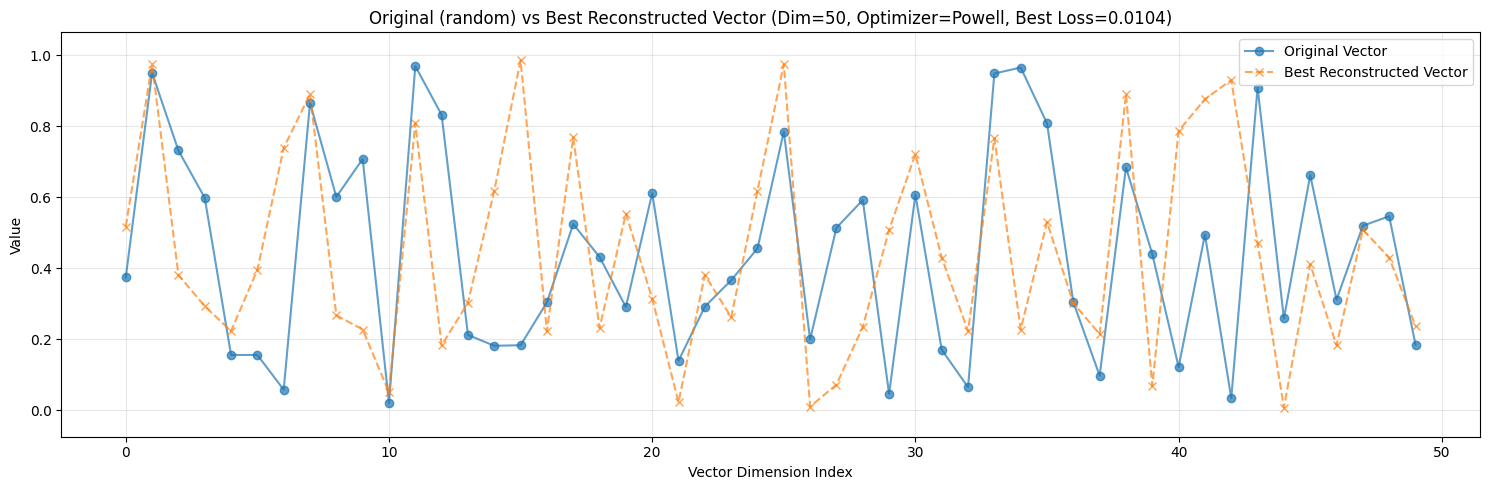


--- Experiment End ---


In [ ]:
# @title Experiment: Reconstruction using Non-Linear Fixed Vectors { display-mode: "form" }

# !pip install -q python-Levenshtein numpy pandas scipy pyarrow scikit-learn matplotlib # Ensure necessary libs

import numpy as np
import pandas as pd
import time
import os
import shutil
# import pyarrow.parquet as pq # Keep if using parquet later
import scipy.sparse as sp
from scipy.spatial import distance as sp_distance
from scipy.stats import spearmanr, pearsonr
# from Levenshtein import distance as levenshtein # No longer used
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split # For splitting data (if needed later)
import matplotlib.pyplot as plt # Added for optional plotting

# --- Configuration ---

# 1. Data Loading / Dummy Data Setup
DUMMY_DIM = 50 # Example dimension
TEST_DATA_TYPE = 'random' # Options: 'random', 'sine', 'linspace', 'step'
print(f"Using dummy data with dimension {DUMMY_DIM}")
print(f"Test Data Type: {TEST_DATA_TYPE}")

# Use a fixed seed for reproducibility of the original vector
np.random.seed(42)
if TEST_DATA_TYPE == 'random':
    original_vector = np.random.rand(DUMMY_DIM).astype(np.float32)
elif TEST_DATA_TYPE == 'sine':
    original_vector = np.sin(np.linspace(0, 4 * np.pi, DUMMY_DIM)).astype(np.float32) * 0.4 + 0.5 # Scale to approx [0.1, 0.9]
elif TEST_DATA_TYPE == 'linspace':
     original_vector = np.linspace(0.05, 0.95, DUMMY_DIM).astype(np.float32) # Range [0.05, 0.95]
elif TEST_DATA_TYPE == 'step':
     original_vector = np.concatenate([np.full(DUMMY_DIM//2, 0.2, dtype=np.float32),
                                       np.full(DUMMY_DIM - DUMMY_DIM//2, 0.8, dtype=np.float32)])
else:
     raise ValueError("Invalid TEST_DATA_TYPE specified")

# Ensure vector values are roughly within [0, 1] for consistency with bounds
original_vector = np.clip(original_vector, 0.0, 1.0)


# 2. Experiment Parameters
MAX_OPTIMIZER_ITERATIONS = 3000 # Iterations per optimization run
OPTIMIZER_METHOD = 'Powell'
N_OPTIMIZATION_RUNS = 5     # Number of runs from different starting points
print(f"Using Optimizer: {OPTIMIZER_METHOD}")
print(f"Performing {N_OPTIMIZATION_RUNS} optimization runs with max {MAX_OPTIMIZER_ITERATIONS} iterations each.")

# Define the multiple fixed reference points - INCLUDING NON-CONSTANT ONES
REFERENCE_VALUES = [0.1, 0.25, 0.5, 0.75, 0.9, 'linspace', 'sine']
print(f"Using reference points: {REFERENCE_VALUES}")


# --- Metric Definitions ---
# Use only first half of FFT spectrum (+ DC) due to symmetry for real inputs
fft_len = DUMMY_DIM // 2 + 1

METRICS = {
    # 1. L-family distances
    'L2 norm (Euclidean)': lambda d, c: np.sqrt(np.sum((d - c)**2)),
    'L1 norm (Manhattan)': lambda d, c: np.sum(np.abs(d - c)),
    'Canberra': lambda d, c: np.sum(np.abs(d - c) / (np.abs(d) + np.abs(c) + 1e-10)),
    'L∞ norm (Chebyshev)': lambda d, c: np.max(np.abs(d - c)),

    # 2. Correlation measures
    'Cosine Similarity': lambda d, c: (1 - sp_distance.cosine(d, c) if (np.linalg.norm(d) > 1e-9 and np.linalg.norm(c) > 1e-9) else 0.0),
    # Calculate vs any reference vector 'c' that has variance
    'Pearson Correlation': lambda d, c: pearsonr(d, c)[0] if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,
    'Spearman Correlation': lambda d, c: spearmanr(d, c).correlation if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,

    # 3. Statistical distances
    'Chi-square': lambda d, c: np.sum(np.where((d + c) > 0, (d - c)**2 / (d + c + 1e-10), 0)),

    # 4. New Metrics (Example: FFT Magnitude Comparison)
    # Compares FFT magnitude of vector 'd' to a precomputed target FFT mag 'target_fft'
    'FFT Magnitude L2': lambda d, target_fft: np.linalg.norm(np.abs(np.fft.fft(d))[:fft_len] - target_fft),
    # Potential future additions: Autocorrelation comparison, Diff vector metrics, etc.
}

# Select metrics to actually use - ADDING FFT
ACTIVE_METRIC_BASE_NAMES = [
    'L2 norm (Euclidean)',
    'L1 norm (Manhattan)',
    'Cosine Similarity',
    'Pearson Correlation',
    'Spearman Correlation',
    'L∞ norm (Chebyshev)',
    'Canberra',
    'Chi-square',
    'FFT Magnitude L2', # Added new metric
]
print(f"Using {len(ACTIVE_METRIC_BASE_NAMES)} active base metric types.")


# --- MetricProcessor for Diverse References ---

class MetricProcessorMultiRef:
    def __init__(self, reference_values=['linspace']):
        if not isinstance(reference_values, list):
            reference_values = [reference_values]
        self._reference_values = reference_values # e.g., [0.1, 0.5, 'linspace', 'sine']
        self.comparison_vectors = {} # Dict: {key: vector}
        # Precomputed FFT of the target vector will be stored separately outside this class

    def preprocess(self, template_vector):
        """Preprocesses based on template vector shape for diverse reference vectors."""
        self.comparison_vectors = {}
        vector_len = len(template_vector)
        print(f"Preprocessing MetricProcessor for {len(self._reference_values)} references...")

        # Create reference vectors based on the keys provided
        for key in self._reference_values:
            if isinstance(key, (int, float)):
                # Constant vector
                comp_vec = np.full_like(template_vector, key)
                print(f"  Created constant reference vector for key: {key}")
            elif key == 'linspace':
                comp_vec = np.linspace(0, 1, vector_len).astype(template_vector.dtype)
                print(f"  Created linspace reference vector.")
            elif key == 'sine':
                # Scale sine wave to be roughly within [0,1] like the data
                comp_vec = (np.sin(np.linspace(0, 2 * np.pi, vector_len)) * 0.5 + 0.5).astype(template_vector.dtype)
                print(f"  Created sine reference vector.")
            # Add elif blocks here for other reference vector types if needed
            else:
                raise ValueError(f"Unknown reference value type: {key}")

            self.comparison_vectors[key] = comp_vec

        # --- NOTE: FFT calculation is handled outside this processor ---
        # We don't precompute FFTs for reference vectors here,
        # as the 'FFT Magnitude L2' metric compares the input vector 'd'
        # directly against a precomputed target FFT magnitude.

        print("Preprocessing complete.")


    def calculate(self, data, active_metric_base_names):
        """Calculates active metrics against all preprocessed reference vectors.
           FFT Magnitude L2 is handled specially outside this function's direct loop."""
        if not self.comparison_vectors:
            raise ValueError("Processor must be preprocessed before calculate.")

        combined_results = {}
        data_std_dev_ok = np.std(data) > 1e-9 # Pre-check data variance for correlations

        # Loop through each reference value (key) and its corresponding vector
        for ref_key, comp_vec in self.comparison_vectors.items():
            if data.shape != comp_vec.shape:
                raise ValueError(f"Input data shape {data.shape} != reference shape {comp_vec.shape} for key '{ref_key}'")

            # Check variance of the comparison vector once per vector
            comp_vec_std_dev_ok = np.std(comp_vec) > 1e-9

            # Loop through the active base metric names
            for base_name in active_metric_base_names:
                # Skip FFT metric here, it's calculated once per 'data' vector in the loss fn
                if base_name == 'FFT Magnitude L2':
                    continue

                if base_name not in METRICS:
                    print(f"Warning: Metric '{base_name}' not found in METRICS dict.")
                    continue

                metric_func = METRICS[base_name]
                # Use the reference key in the result key for clarity
                result_key = f"{base_name}_{ref_key}" # e.g., "L2 norm (Euclidean)_sine"
                result_val = np.nan # Default to NaN

                try:
                    # Call metric function with appropriate arguments
                    if base_name in {'Pearson Correlation', 'Spearman Correlation'}:
                        # Calculate only if BOTH vectors have variance
                        if data_std_dev_ok and comp_vec_std_dev_ok:
                            result_val = metric_func(data, comp_vec)
                        else:
                            result_val = 0.0 # Correlation is 0 or undefined
                    else:
                        # Default: Assume metric takes d, c (vector, reference_vector)
                        result_val = metric_func(data, comp_vec)

                except Exception as e:
                    print(f"Error calculating {result_key}: {e}")
                    # Leave result_val as NaN

                combined_results[result_key] = result_val

        # --- NOTE: FFT calculation result is NOT added here ---
        # It will be calculated and added during the loss calculation step,
        # as it doesn't depend on iterating through reference vectors.

        return combined_results

# --- Reconstruction Functions ---

# MODIFIED Loss function to handle FFT metric
def reconstruction_loss_multi_ref(v, target_results, precomputed_target_fft, # Added target FFT
                                  processor, base_metric_weights,
                                  active_metric_base_names, reference_values):
    """
    Calculates loss comparing metrics for 'v' to the target metrics + FFT diff.
    Uses weights based on the *base* metric name.
    """
    v = np.asarray(v)
    if np.any(np.isnan(v)) or np.any(v < -1) or np.any(v > 2):
         return 1e12

    total_error = 0.0
    num_metrics_used = 0 # Count metrics contributing to error

    # 1. Calculate standard metrics using the processor
    try:
        current_results = processor.calculate(v, active_metric_base_names)
    except Exception as e:
        print(f"Warning: Metric calculation failed during optimization step: {e}")
        return 1e12

    # Iterate through standard metric results (excluding FFT for now)
    active_standard_metrics = [m for m in active_metric_base_names if m != 'FFT Magnitude L2']
    for base_name in active_standard_metrics:
        weight = base_metric_weights.get(base_name, 0.0)
        if weight == 0: continue

        for ref_val in reference_values: # Use the original keys/values here
            metric_key = f"{base_name}_{ref_val}"

            if metric_key not in target_results or metric_key not in current_results:
                continue

            target_val = target_results[metric_key]
            current_val = current_results[metric_key]

            if np.isnan(target_val): continue
            elif np.isnan(current_val):
                error = 10.0 # Penalty for NaN
            else:
                denominator = abs(target_val)
                if denominator < 1e-9: error = (current_val - target_val)**2
                else: error = ((current_val - target_val) / denominator)**2
                error = min(error, 1000.0) # Cap error

            total_error += error * weight
            num_metrics_used += 1

    # 2. Calculate and add FFT Magnitude L2 error if active
    if 'FFT Magnitude L2' in active_metric_base_names:
        weight = base_metric_weights.get('FFT Magnitude L2', 0.0)
        if weight > 0:
            fft_metric_func = METRICS['FFT Magnitude L2']
            try:
                # Calculate the L2 distance between current vector's FFT mag and target FFT mag
                current_fft_l2_dist = fft_metric_func(v, precomputed_target_fft)

                # Target value for FFT L2 distance is 0 (vector's FFT vs itself)
                target_fft_l2_dist = 0.0

                # Use absolute squared error for distance metrics (target is 0)
                fft_error = (current_fft_l2_dist - target_fft_l2_dist)**2
                fft_error = min(fft_error, 1000.0) # Cap error

                total_error += fft_error * weight
                num_metrics_used += 1
            except Exception as e:
                print(f"Error calculating FFT Magnitude L2 metric: {e}")
                total_error += 10.0 * weight # Add penalty if FFT calc fails

    if num_metrics_used == 0:
        print("Warning: No metrics contributed to loss calculation.")
        return 1e12

    # Return average weighted error
    return total_error / num_metrics_used


# MODIFIED Reconstruction function to pass target FFT
def attempt_reconstruction_multi_ref(target_results, precomputed_target_fft, # Added target FFT
                                     vector_dim,
                                     metric_processor, # Must be MetricProcessorMultiRef instance
                                     active_metric_base_names,
                                     base_metric_weights, # Dict mapping base_name to weight
                                     initial_guess=None,
                                     bounds=None,
                                     max_iterations=1000,
                                     optimizer_method='Nelder-Mead'):
    """
    Attempts reconstruction using metrics calculated against multiple reference points.
    (This function performs a SINGLE optimization run)
    """
    if not isinstance(metric_processor, MetricProcessorMultiRef) or not metric_processor.comparison_vectors:
        raise ValueError("MetricProcessor must be a preprocessed MetricProcessorMultiRef instance.")

    reference_values = metric_processor._reference_values # Get keys used by processor

    # Initial guess handling
    if initial_guess is None:
        # Use mean of reference vectors if available, else random
        ref_vecs = list(metric_processor.comparison_vectors.values())
        if ref_vecs:
             initial_guess = np.mean(ref_vecs, axis=0)
        else:
             initial_guess = np.random.rand(vector_dim) # Fallback
    initial_guess = np.asarray(initial_guess)
    if initial_guess.shape[0] != vector_dim:
        raise ValueError(f"Initial guess dimension {initial_guess.shape[0]} != vector_dim {vector_dim}")

    start_time = time.time()

    if bounds: bounds = list(bounds)

    # Pass precomputed_target_fft in the args tuple
    args_tuple = (target_results, precomputed_target_fft, metric_processor,
                  base_metric_weights, active_metric_base_names, reference_values)

    opt_result = minimize(
        reconstruction_loss_multi_ref,
        initial_guess,
        args=args_tuple, # Pass the updated args tuple
        method=optimizer_method,
        options={
            'maxiter': max_iterations,
            'disp': False,
            'xtol': 1e-6,
            'ftol': 1e-6
        },
        bounds=bounds
    )

    end_time = time.time()

    # Return best vector found, clip post-optimization
    final_vector = opt_result.x
    if bounds:
        lower_bounds = np.array([b[0] for b in bounds])
        upper_bounds = np.array([b[1] for b in bounds])
        final_vector = np.clip(final_vector, lower_bounds, upper_bounds)

    return final_vector, opt_result


# --- Example Usage ---

# 1. Original vector
print("\n--- Original Vector Info ---")
print(f"Shape: {original_vector.shape}")
print(f"Min: {original_vector.min():.4f}, Max: {original_vector.max():.4f}, Mean: {original_vector.mean():.4f}, StdDev: {original_vector.std():.4f}")

# 2. Preprocess processor for DIVERSE references
# Pass the updated list including 'linspace', 'sine' etc.
processor_multi = MetricProcessorMultiRef(reference_values=REFERENCE_VALUES)
processor_multi.preprocess(original_vector)

# 3. Calculate target metrics
print("\nCalculating target metrics for original vector (multi-reference)...")
# Calculate standard metrics using the processor
target_metrics_multi = processor_multi.calculate(original_vector, ACTIVE_METRIC_BASE_NAMES)

# Precompute the target FFT Magnitude separately
# Use only first half of spectrum (+ DC component)
precomputed_target_fft = np.abs(np.fft.fft(original_vector))[:fft_len]
# The 'target value' for the FFT L2 distance metric is 0 (distance from itself)
target_metrics_multi['FFT Magnitude L2_target'] = 0.0 # Add dummy key for consistency if needed for eval table

print(f"Target Metrics Calculated ({len(target_metrics_multi)} total, FFT target precomputed).")


# 4. Attempt reconstruction - WITH MULTIPLE RUNS
print(f"\n--- Starting Multi-Reference Reconstruction ({N_OPTIMIZATION_RUNS} Runs) ---")
reconstruction_bounds = [(0.0, 1.0)] * DUMMY_DIM # Keep bounds tight

# Define BASE weights - ADD weight for FFT
base_weights = {name: 0.0 for name in METRICS} # Start all at 0
base_weights['L2 norm (Euclidean)'] = 20.0
base_weights['L1 norm (Manhattan)'] = 5.0
base_weights['L∞ norm (Chebyshev)'] = 5.0
base_weights['Cosine Similarity'] = 10.0
base_weights['Canberra'] = 0.5 # Reduced weight
base_weights['Chi-square'] = 0.5 # Reduced weight
base_weights['Pearson Correlation'] = 5.0
base_weights['Spearman Correlation'] = 5.0
base_weights['FFT Magnitude L2'] = 10.0 # Give FFT comparison significant weight

# Filter weights for only ACTIVE metrics
active_base_weights = {k: base_weights[k] for k in ACTIVE_METRIC_BASE_NAMES if k in base_weights}
print(f"Using {len(active_base_weights)} non-zero Base Metric Weights: {active_base_weights}")


# --- Multi-Run Optimization Loop ---
best_loss = np.inf
best_vector = None
best_result_info = None
total_optimization_time = 0

for i in range(N_OPTIMIZATION_RUNS):
    run_start_time = time.time()
    print(f"\n--- Optimization Run {i+1}/{N_OPTIMIZATION_RUNS} ---")
    start_guess = np.random.rand(DUMMY_DIM).astype(np.float32) # Random start [0,1]
    print(f"  Initial Guess Stats (Run {i+1}): Min={start_guess.min():.3f}, Max={start_guess.max():.3f}, Mean={start_guess.mean():.3f}")

    # Pass the precomputed target FFT to the reconstruction function
    temp_reconstructed_v, temp_result_info = attempt_reconstruction_multi_ref(
        target_metrics_multi, precomputed_target_fft, # Pass FFT target
        vector_dim=DUMMY_DIM,
        metric_processor=processor_multi,
        active_metric_base_names=ACTIVE_METRIC_BASE_NAMES,
        base_metric_weights=active_base_weights,
        initial_guess=start_guess,
        bounds=reconstruction_bounds,
        max_iterations=MAX_OPTIMIZER_ITERATIONS,
        optimizer_method=OPTIMIZER_METHOD
    )

    run_end_time = time.time()
    run_duration = run_end_time - run_start_time
    total_optimization_time += run_duration

    print(f"  Run {i+1} Finished in {run_duration:.2f} sec.")
    print(f"  Success: {temp_result_info.success}, Status: {temp_result_info.message}")
    print(f"  Final loss (Run {i+1}): {temp_result_info.fun:.6f}")
    print(f"  Number of Function Evaluations: {temp_result_info.nfev}")


    if temp_result_info.fun < best_loss:
        print(f"  **** Found new best loss: {temp_result_info.fun:.6f} (previous best: {best_loss:.6f}) ****")
        best_loss = temp_result_info.fun
        best_vector = temp_reconstructed_v
        best_result_info = temp_result_info

# --- End Multi-Run Loop ---

print(f"\n--- Optimization Complete ({N_OPTIMIZATION_RUNS} runs) ---")
print(f"Total optimization time: {total_optimization_time:.2f} seconds.")
if best_vector is None:
     print("ERROR: No successful optimization run completed.")
     exit()

print(f"Best loss achieved: {best_loss:.6f}")
reconstructed_v_multi = best_vector
result_info_multi = best_result_info


# 5. Evaluate Reconstruction (Using the BEST vector found)
if reconstructed_v_multi is not None and reconstructed_v_multi.shape == original_vector.shape:
    print("\n--- Evaluating Best Reconstruction Result ---")
    print("Reconstructed Vector Stats (Best Run):")
    print(f" Min: {reconstructed_v_multi.min():.4f}, Max: {reconstructed_v_multi.max():.4f}, Mean: {reconstructed_v_multi.mean():.4f}, StdDev: {reconstructed_v_multi.std():.4f}")

    # Calculate standard metrics for the best reconstructed vector
    reconstructed_metrics_multi = processor_multi.calculate(reconstructed_v_multi, ACTIVE_METRIC_BASE_NAMES)
    # Calculate the FFT L2 distance for the best vector
    recon_fft_l2_dist = METRICS['FFT Magnitude L2'](reconstructed_v_multi, precomputed_target_fft)
    # Add it to the results dict for printing comparison
    reconstructed_metrics_multi['FFT Magnitude L2_target'] = recon_fft_l2_dist


    print("\nComparison (Target vs Reconstructed Metrics - Best Run):")
    max_name_len = 0
    active_keys_union = set(target_metrics_multi.keys()) | set(reconstructed_metrics_multi.keys())
    active_metric_keys_printable = set()
    for k in active_keys_union:
         base_name = k.split('_')[0]
         # Include standard metrics + the special FFT key
         if base_name in ACTIVE_METRIC_BASE_NAMES or k == 'FFT Magnitude L2_target':
              active_metric_keys_printable.add(k)

    if active_metric_keys_printable:
        max_name_len = max(len(name) for name in active_metric_keys_printable) + 2


    total_recon_metric_error = 0
    count = 0
    sorted_metric_keys = sorted(list(active_metric_keys_printable))

    for key in sorted_metric_keys:
        base_name = key.split('_')[0]
        # Special handling for FFT key display
        display_key = key
        target_val = np.nan
        recon_val = np.nan

        if key == 'FFT Magnitude L2_target':
            display_key = "FFT Mag L2 Dist" # Cleaner display name
            target_val = 0.0 # Target distance is 0
            recon_val = reconstructed_metrics_multi.get(key, np.nan)
        elif base_name in ACTIVE_METRIC_BASE_NAMES:
            target_val = target_metrics_multi.get(key, np.nan)
            recon_val = reconstructed_metrics_multi.get(key, np.nan)
        else:
            continue # Skip keys not relevant

        # Skip comparison if target is NaN
        if np.isnan(target_val): continue

        if np.isnan(recon_val):
            diff = np.inf
            rel_diff = np.inf
            print(f"{display_key:<{max_name_len}} | Target={target_val: >10.4f} | Recon=       nan | AbsDiff=       inf | RelDiff=     inf%")
        else:
            diff = abs(target_val - recon_val)
            if abs(target_val) > 1e-9: rel_diff = (diff / abs(target_val)) * 100
            elif diff < 1e-9: rel_diff = 0.0
            else: rel_diff = np.inf
            print(f"{display_key:<{max_name_len}} | Target={target_val: >10.4f} | Recon={recon_val: >10.4f} | AbsDiff={diff: >10.4f} | RelDiff={rel_diff: >8.2f}%")

            # Calculate error contribution (unweighted for post-evaluation)
            denominator = abs(target_val)
            if denominator < 1e-9: error = (recon_val - target_val)**2
            else: error = ((recon_val - target_val) / denominator)**2
            error = min(error, 1000.0)
            total_recon_metric_error += error
            count += 1

    if count > 0:
      print(f"\nMean Squared Relative/Absolute Error (metrics, post-optimization, unweighted): {total_recon_metric_error/count:.6f}")
    else:
      print("\nNo metrics available for error calculation.")

    # ----> Key Evaluation: Compare reconstructed vector to the original vector <----
    print("\n--- Vector Reconstruction Quality (Best Run) ---")
    l2_diff_vectors = np.linalg.norm(original_vector - reconstructed_v_multi)
    norm_orig = np.linalg.norm(original_vector)
    norm_recon = np.linalg.norm(reconstructed_v_multi)
    if norm_orig > 1e-9 and norm_recon > 1e-9:
        cosine_sim_vectors = 1.0 - sp_distance.cosine(original_vector, reconstructed_v_multi)
    elif abs(norm_orig - norm_recon) < 1e-9 : cosine_sim_vectors = 1.0
    else: cosine_sim_vectors = 0.0

    print(f"L2 distance between original and reconstructed vectors: {l2_diff_vectors:.6f}")
    print(f"Cosine similarity between original and reconstructed vectors: {cosine_sim_vectors:.6f}")

    # --- Optional: Plotting ---
    plt.figure(figsize=(15, 5))
    plt.plot(original_vector, label='Original Vector', alpha=0.7, marker='o', linestyle='-')
    plt.plot(reconstructed_v_multi, label=f'Best Reconstructed Vector', alpha=0.7, marker='x', linestyle='--')
    plt.title(f'Original ({TEST_DATA_TYPE}) vs Best Reconstructed Vector (Dim={DUMMY_DIM}, Optimizer={OPTIMIZER_METHOD}, Best Loss={best_loss:.4f})')
    plt.xlabel('Vector Dimension Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(max(-0.1, np.min(original_vector) - 0.1*np.ptp(original_vector)),
             min(1.1, np.max(original_vector) + 0.1*np.ptp(original_vector))) # Dynamic ylim
    plt.tight_layout()
    # plt.savefig(f'reconstruction_{TEST_DATA_TYPE}.png')
    plt.show()

elif reconstructed_v_multi is None:
     print("\nReconstruction failed (result was None even after multiple runs).")
else:
     print(f"\nReconstruction failed (shape mismatch: Original {original_vector.shape}, Best Recon {reconstructed_v_multi.shape}).")

print("\n--- Experiment End ---")

Using dummy data with dimension 50
Test Data Type: sine
Using Optimizer: Powell
Performing 5 optimization runs with max 3500 iterations each.
Using reference points: [0.1, 0.25, 0.5, 0.75, 0.9, 'linspace', 'sine']
Using 13 active base metric types.

--- Original Vector Info ---
Shape: (50,)
Min: 0.0502, Max: 0.9498, Mean: 0.5000, StdDev: 0.3150
Preprocessing MetricProcessor for 7 references...
Preprocessing complete.

Calculating target metrics for original vector...
Target Metrics Calculated (61 total).

--- Starting Multi-Reference Reconstruction (5 Runs, Data: sine) ---
Using 13 non-zero Base Metric Weights: {'L2 norm (Euclidean)': 15.0, 'L1 norm (Manhattan)': 5.0, 'Cosine Similarity': 10.0, 'Pearson Correlation': 5.0, 'Spearman Correlation': 5.0, 'L∞ norm (Chebyshev)': 5.0, 'Canberra': 0.3, 'Chi-square': 0.3, 'FFT Complex L2': 15.0, 'Skewness': 2.0, 'Kurtosis': 2.0, 'Median': 5.0, 'Diff L2 Norm': 8.0}

--- Optimization Run 1/5 ---
  Initial Guess Stats (Run 1): Min=0.021, Max=0.970

<ipython-input-33-1cb639dee7da>:65: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  'Pearson Correlation': lambda d, c: pearsonr(d, c)[0] if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,
<ipython-input-33-1cb639dee7da>:66: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  'Spearman Correlation': lambda d, c: spearmanr(d, c).correlation if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,


  Run 1 Finished in 108.21 sec.
  Success: True, Status: Optimization terminated successfully.
  Final loss (Run 1): 95.499650
  Number of Function Evaluations: 16038
  **** Found new best loss: 95.499650 (previous best: inf) ****

--- Optimization Run 2/5 ---
  Initial Guess Stats (Run 2): Min=0.006, Max=0.987, Mean=0.494
  Run 2 Finished in 72.45 sec.
  Success: True, Status: Optimization terminated successfully.
  Final loss (Run 2): 105.729234
  Number of Function Evaluations: 10498

--- Optimization Run 3/5 ---
  Initial Guess Stats (Run 3): Min=0.007, Max=0.972, Mean=0.478
  Run 3 Finished in 85.75 sec.
  Success: True, Status: Optimization terminated successfully.
  Final loss (Run 3): 111.580851
  Number of Function Evaluations: 12325

--- Optimization Run 4/5 ---
  Initial Guess Stats (Run 4): Min=0.017, Max=0.986, Mean=0.517
  Run 4 Finished in 147.33 sec.
  Success: True, Status: Optimization terminated successfully.
  Final loss (Run 4): 86.162938
  Number of Function Evalu

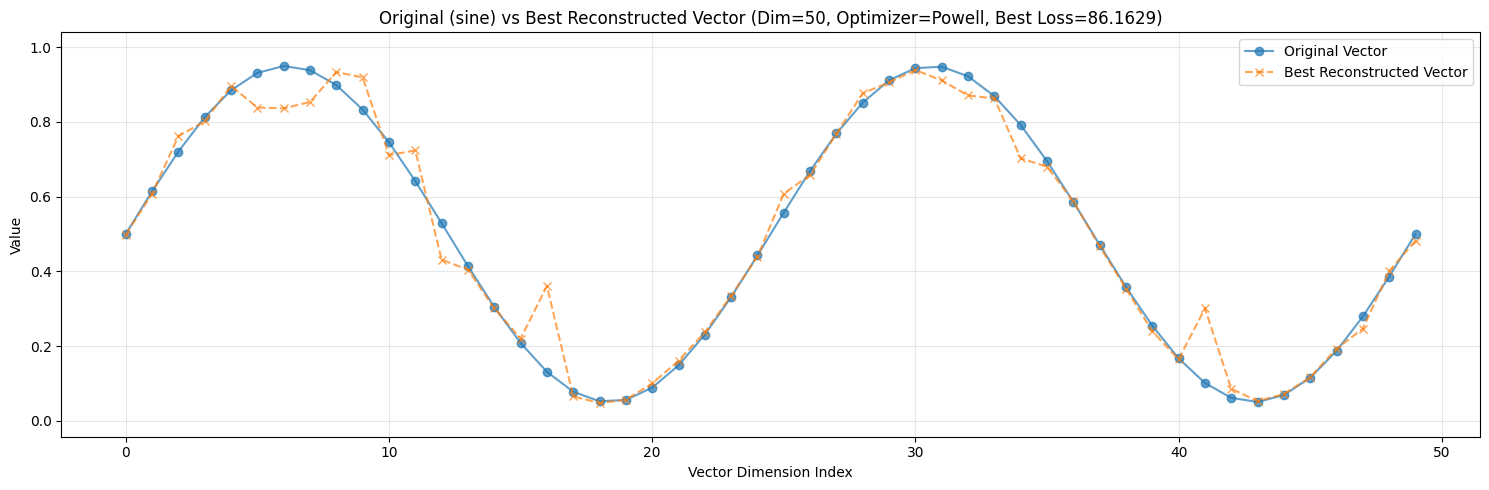


--- Experiment End ---


In [ ]:
# @title Experiment: Reconstruction-Test with Different Metrics { display-mode: "form" }

# !pip install -q python-Levenshtein numpy pandas scipy pyarrow scikit-learn matplotlib # Ensure necessary libs

import numpy as np
import pandas as pd
import time
import os
import shutil
# import pyarrow.parquet as pq # Keep if using parquet later
import scipy.sparse as sp
from scipy.spatial import distance as sp_distance
from scipy.stats import spearmanr, pearsonr, skew, kurtosis
# from Levenshtein import distance as levenshtein # No longer used
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split # For splitting data (if needed later)
import matplotlib.pyplot as plt # Added for optional plotting

# --- Configuration ---

# 1. Data Loading / Dummy Data Setup
DUMMY_DIM = 50
# **** TEST ON STRUCTURED DATA FIRST ****
TEST_DATA_TYPE = 'sine' # Options: 'random', 'sine', 'linspace', 'step'
print(f"Using dummy data with dimension {DUMMY_DIM}")
print(f"Test Data Type: {TEST_DATA_TYPE}")

# Use a fixed seed for reproducibility
np.random.seed(42)
if TEST_DATA_TYPE == 'random':
    original_vector = np.random.rand(DUMMY_DIM).astype(np.float32)
elif TEST_DATA_TYPE == 'sine':
    original_vector = (np.sin(np.linspace(0, 4 * np.pi, DUMMY_DIM)) * 0.45 + 0.5).astype(np.float32)
elif TEST_DATA_TYPE == 'linspace':
     original_vector = np.linspace(0.05, 0.95, DUMMY_DIM).astype(np.float32)
elif TEST_DATA_TYPE == 'step':
     original_vector = np.concatenate([np.full(DUMMY_DIM//2, 0.2, dtype=np.float32),
                                       np.full(DUMMY_DIM - DUMMY_DIM//2, 0.8, dtype=np.float32)])
else:
     raise ValueError("Invalid TEST_DATA_TYPE specified")
original_vector = np.clip(original_vector, 0.0, 1.0)

# 2. Experiment Parameters
MAX_OPTIMIZER_ITERATIONS = 3500
OPTIMIZER_METHOD = 'Powell'
N_OPTIMIZATION_RUNS = 5
print(f"Using Optimizer: {OPTIMIZER_METHOD}")
print(f"Performing {N_OPTIMIZATION_RUNS} optimization runs with max {MAX_OPTIMIZER_ITERATIONS} iterations each.")

# Define the multiple fixed reference points
REFERENCE_VALUES = [0.1, 0.25, 0.5, 0.75, 0.9, 'linspace', 'sine']
print(f"Using reference points: {REFERENCE_VALUES}")


# --- Metric Definitions ---
fft_len = DUMMY_DIM // 2 + 1

METRICS = {
    # Standard metrics vs reference 'c'
    'L2 norm (Euclidean)': lambda d, c: np.sqrt(np.sum((d - c)**2)),
    'L1 norm (Manhattan)': lambda d, c: np.sum(np.abs(d - c)),
    'Canberra': lambda d, c: np.sum(np.abs(d - c) / (np.abs(d) + np.abs(c) + 1e-10)),
    'L∞ norm (Chebyshev)': lambda d, c: np.max(np.abs(d - c)),
    'Cosine Similarity': lambda d, c: (1 - sp_distance.cosine(d, c) if (np.linalg.norm(d) > 1e-9 and np.linalg.norm(c) > 1e-9) else 0.0),
    'Pearson Correlation': lambda d, c: pearsonr(d, c)[0] if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,
    'Spearman Correlation': lambda d, c: spearmanr(d, c).correlation if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,
    'Chi-square': lambda d, c: np.sum(np.where((d + c) > 0, (d - c)**2 / (d + c + 1e-10), 0)),

    # Metrics calculated on vector 'd' itself (or vs a precomputed target)
    # **** MODIFIED FFT METRIC ****
    'FFT Complex L2': lambda d, target_fft_complex: np.linalg.norm(np.fft.fft(d)[:fft_len] - target_fft_complex),
    'Skewness': lambda d, _: skew(d) if np.std(d) > 1e-9 else 0.0,
    'Kurtosis': lambda d, _: kurtosis(d) if np.std(d) > 1e-9 else 0.0,
    'Median': lambda d, _: np.median(d),
    'Diff L2 Norm': lambda d, _: np.linalg.norm(np.diff(d)) if len(d)>1 else 0.0,
}

# Select metrics to actually use - UPDATED FFT NAME
ACTIVE_METRIC_BASE_NAMES = [
    'L2 norm (Euclidean)',
    'L1 norm (Manhattan)',
    'Cosine Similarity',
    'Pearson Correlation',
    'Spearman Correlation',
    'L∞ norm (Chebyshev)',
    'Canberra',
    'Chi-square',
    'FFT Complex L2', # Renamed from Magnitude L2
    'Skewness',
    'Kurtosis',
    'Median',
    'Diff L2 Norm',
]
print(f"Using {len(ACTIVE_METRIC_BASE_NAMES)} active base metric types.")


# --- MetricProcessor for Diverse References ---
# (No changes needed in the class itself)
class MetricProcessorMultiRef:
    def __init__(self, reference_values=['linspace']):
        if not isinstance(reference_values, list): reference_values = [reference_values]
        self._reference_values = reference_values
        self.comparison_vectors = {}

    def preprocess(self, template_vector):
        self.comparison_vectors = {}
        vector_len = len(template_vector); dtype = template_vector.dtype
        print(f"Preprocessing MetricProcessor for {len(self._reference_values)} references...")
        for key in self._reference_values:
            if isinstance(key, (int, float)): comp_vec = np.full(vector_len, key, dtype=dtype)
            elif key == 'linspace': comp_vec = np.linspace(0, 1, vector_len).astype(dtype)
            elif key == 'sine': comp_vec = (np.sin(np.linspace(0, 2 * np.pi, vector_len)) * 0.5 + 0.5).astype(dtype)
            else: raise ValueError(f"Unknown reference value type: {key}")
            self.comparison_vectors[key] = comp_vec
        print("Preprocessing complete.")

    def calculate(self, data, active_metric_base_names):
        if not self.comparison_vectors: raise ValueError("Processor must be preprocessed.")
        combined_results = {}; data_std_dev_ok = np.std(data) > 1e-9
        data_only_metrics = {'FFT Complex L2', 'Skewness', 'Kurtosis', 'Median', 'Diff L2 Norm'} # Updated FFT name

        for ref_key, comp_vec in self.comparison_vectors.items():
            if data.shape != comp_vec.shape: raise ValueError(f"Shape mismatch for key '{ref_key}'")
            comp_vec_std_dev_ok = np.std(comp_vec) > 1e-9

            for base_name in active_metric_base_names:
                if base_name in data_only_metrics: continue # Skip data-only
                if base_name not in METRICS: continue

                metric_func = METRICS[base_name]; result_key = f"{base_name}_{ref_key}"; result_val = np.nan
                try:
                    if base_name in {'Pearson Correlation', 'Spearman Correlation'}:
                        if data_std_dev_ok and comp_vec_std_dev_ok: result_val = metric_func(data, comp_vec)
                        else: result_val = 0.0
                    else: result_val = metric_func(data, comp_vec)
                except Exception as e: print(f"Error calculating {result_key}: {e}")
                combined_results[result_key] = result_val
        return combined_results

# --- Reconstruction Functions ---

# MODIFIED Loss function to use COMPLEX FFT metric name
def reconstruction_loss_multi_ref(v, target_results, precomputed_target_fft_complex, # Use Complex FFT
                                  processor, base_metric_weights,
                                  active_metric_base_names, reference_values):
    v = np.asarray(v);
    if np.any(np.isnan(v)) or np.any(v < -1) or np.any(v > 2): return 1e12
    total_error = 0.0; num_metrics_used = 0
    data_only_metrics = {'FFT Complex L2', 'Skewness', 'Kurtosis', 'Median', 'Diff L2 Norm'} # Updated FFT name

    # 1. Calculate standard metrics (vs references)
    try:
        processor_active_names = [m for m in active_metric_base_names if m not in data_only_metrics]
        current_results_vs_ref = processor.calculate(v, processor_active_names)
    except Exception as e: print(f"Warning: Metric calculation (vs refs) failed: {e}"); return 1e12

    for base_name in processor_active_names:
        weight = base_metric_weights.get(base_name, 0.0);
        if weight == 0: continue
        for ref_val in reference_values:
            metric_key = f"{base_name}_{ref_val}"
            if metric_key not in target_results or metric_key not in current_results_vs_ref: continue
            target_val = target_results[metric_key]; current_val = current_results_vs_ref[metric_key]
            if np.isnan(target_val): continue
            elif np.isnan(current_val): error = 10.0
            else:
                denominator = abs(target_val); error = (current_val - target_val)**2 if denominator < 1e-9 else ((current_val - target_val) / denominator)**2
                error = min(error, 1000.0)
            total_error += error * weight; num_metrics_used += 1

    # 2. Calculate error for data-only metrics
    for base_name in data_only_metrics:
        if base_name not in active_metric_base_names: continue
        weight = base_metric_weights.get(base_name, 0.0);
        if weight == 0: continue
        metric_key = f"{base_name}_target";
        if metric_key not in target_results: print(f"Warning: Target key {metric_key} not found."); continue
        target_val = target_results[metric_key];
        if np.isnan(target_val): continue

        current_val = np.nan
        try:
            metric_func = METRICS[base_name]
            # Pass specific precomputed data if needed
            if base_name == 'FFT Complex L2': # Check for complex FFT name
                current_val = metric_func(v, precomputed_target_fft_complex) # Pass complex target
            else:
                current_val = metric_func(v, None)

            if np.isnan(current_val): error = 10.0
            else:
                 if base_name == 'FFT Complex L2': error = (current_val - target_val)**2 # Target=0, use squared L2 distance
                 elif base_name == 'Diff L2 Norm':
                      denominator = abs(target_val); error = (current_val - target_val)**2 if denominator < 1e-9 else ((current_val - target_val) / denominator)**2
                 else: error = (current_val - target_val)**2 # Simple squared error for Skew, Kurtosis, Median
                 error = min(error, 1000.0) # Cap
            total_error += error * weight; num_metrics_used += 1
        except Exception as e: print(f"Error calculating {base_name}: {e}"); total_error += 10.0 * weight

    if num_metrics_used == 0: return 1e12
    return total_error / num_metrics_used

# MODIFIED Reconstruction function to pass COMPLEX target FFT
def attempt_reconstruction_multi_ref(target_results, precomputed_target_fft_complex, # Pass COMPLEX target
                                     vector_dim, metric_processor,
                                     active_metric_base_names, base_metric_weights,
                                     initial_guess=None, bounds=None,
                                     max_iterations=1000, optimizer_method='Nelder-Mead'):
    if not isinstance(metric_processor, MetricProcessorMultiRef): raise ValueError("Bad processor")
    reference_values = metric_processor._reference_values

    if initial_guess is None:
        ref_vecs = list(metric_processor.comparison_vectors.values())
        initial_guess = np.mean(ref_vecs, axis=0) if ref_vecs else np.random.rand(vector_dim)
    initial_guess = np.asarray(initial_guess); assert initial_guess.shape[0] == vector_dim

    start_time = time.time();
    if bounds: bounds = list(bounds)

    # Pass precomputed_target_fft_complex in the args tuple
    args_tuple = (target_results, precomputed_target_fft_complex, metric_processor,
                  base_metric_weights, active_metric_base_names, reference_values)

    opt_result = minimize(reconstruction_loss_multi_ref, initial_guess, args=args_tuple,
                          method=optimizer_method, options={'maxiter': max_iterations, 'disp': False, 'xtol': 1e-6, 'ftol': 1e-6},
                          bounds=bounds)
    end_time = time.time()

    final_vector = opt_result.x
    if bounds:
        lower_bounds = np.array([b[0] for b in bounds]); upper_bounds = np.array([b[1] for b in bounds])
        final_vector = np.clip(final_vector, lower_bounds, upper_bounds)
    return final_vector, opt_result

# --- Example Usage ---

# 1. Original vector info
print("\n--- Original Vector Info ---")
print(f"Shape: {original_vector.shape}")
print(f"Min: {original_vector.min():.4f}, Max: {original_vector.max():.4f}, Mean: {original_vector.mean():.4f}, StdDev: {original_vector.std():.4f}")

# 2. Preprocess processor
processor_multi = MetricProcessorMultiRef(reference_values=REFERENCE_VALUES)
processor_multi.preprocess(original_vector)

# 3. Calculate target metrics (including data-only ones)
print("\nCalculating target metrics for original vector...")
target_metrics_multi = processor_multi.calculate(original_vector, ACTIVE_METRIC_BASE_NAMES)

# Precompute the target COMPLEX FFT separately
precomputed_target_fft_complex = np.fft.fft(original_vector)[:fft_len]
target_metrics_multi['FFT Complex L2_target'] = 0.0 # Target L2 distance is 0

if 'Skewness' in ACTIVE_METRIC_BASE_NAMES: target_metrics_multi['Skewness_target'] = METRICS['Skewness'](original_vector, None)
if 'Kurtosis' in ACTIVE_METRIC_BASE_NAMES: target_metrics_multi['Kurtosis_target'] = METRICS['Kurtosis'](original_vector, None)
if 'Median' in ACTIVE_METRIC_BASE_NAMES: target_metrics_multi['Median_target'] = METRICS['Median'](original_vector, None)
if 'Diff L2 Norm' in ACTIVE_METRIC_BASE_NAMES: target_metrics_multi['Diff L2 Norm_target'] = METRICS['Diff L2 Norm'](original_vector, None)

print(f"Target Metrics Calculated ({len(target_metrics_multi)} total).")

# 4. Attempt reconstruction - MULTIPLE RUNS
print(f"\n--- Starting Multi-Reference Reconstruction ({N_OPTIMIZATION_RUNS} Runs, Data: {TEST_DATA_TYPE}) ---")
reconstruction_bounds = [(0.0, 1.0)] * DUMMY_DIM

# Define BASE weights - Update FFT name
base_weights = {name: 0.0 for name in METRICS}
base_weights['L2 norm (Euclidean)'] = 15.0
base_weights['L1 norm (Manhattan)'] = 5.0
base_weights['L∞ norm (Chebyshev)'] = 5.0
base_weights['Cosine Similarity'] = 10.0
base_weights['Canberra'] = 0.3
base_weights['Chi-square'] = 0.3
base_weights['Pearson Correlation'] = 5.0
base_weights['Spearman Correlation'] = 5.0
base_weights['FFT Complex L2'] = 15.0 # Keep high, maybe increase? Phase is important!
base_weights['Skewness'] = 2.0
base_weights['Kurtosis'] = 2.0
base_weights['Median'] = 5.0
base_weights['Diff L2 Norm'] = 8.0

active_base_weights = {k: base_weights[k] for k in ACTIVE_METRIC_BASE_NAMES if k in base_weights}
print(f"Using {len(active_base_weights)} non-zero Base Metric Weights: {active_base_weights}")

# --- Multi-Run Optimization Loop ---
best_loss = np.inf; best_vector = None; best_result_info = None; total_optimization_time = 0
for i in range(N_OPTIMIZATION_RUNS):
    run_start_time = time.time(); print(f"\n--- Optimization Run {i+1}/{N_OPTIMIZATION_RUNS} ---")
    start_guess = np.random.rand(DUMMY_DIM).astype(np.float32)
    print(f"  Initial Guess Stats (Run {i+1}): Min={start_guess.min():.3f}, Max={start_guess.max():.3f}, Mean={start_guess.mean():.3f}")

    # Pass the complex target FFT
    temp_reconstructed_v, temp_result_info = attempt_reconstruction_multi_ref(
        target_metrics_multi, precomputed_target_fft_complex, # Pass complex FFT
        vector_dim=DUMMY_DIM, metric_processor=processor_multi,
        active_metric_base_names=ACTIVE_METRIC_BASE_NAMES, base_metric_weights=active_base_weights,
        initial_guess=start_guess, bounds=reconstruction_bounds,
        max_iterations=MAX_OPTIMIZER_ITERATIONS, optimizer_method=OPTIMIZER_METHOD
    )
    run_end_time = time.time(); run_duration = run_end_time - run_start_time; total_optimization_time += run_duration
    print(f"  Run {i+1} Finished in {run_duration:.2f} sec.")
    print(f"  Success: {temp_result_info.success}, Status: {temp_result_info.message}")
    print(f"  Final loss (Run {i+1}): {temp_result_info.fun:.6f}")
    print(f"  Number of Function Evaluations: {temp_result_info.nfev}")
    if temp_result_info.fun < best_loss:
        print(f"  **** Found new best loss: {temp_result_info.fun:.6f} (previous best: {best_loss:.6f}) ****")
        best_loss = temp_result_info.fun; best_vector = temp_reconstructed_v; best_result_info = temp_result_info
# --- End Multi-Run Loop ---

print(f"\n--- Optimization Complete ({N_OPTIMIZATION_RUNS} runs, Data: {TEST_DATA_TYPE}) ---")
print(f"Total optimization time: {total_optimization_time:.2f} seconds.")
if best_vector is None: print("ERROR: No successful optimization run completed."); exit()
print(f"Best loss achieved: {best_loss:.6f}")
reconstructed_v_multi = best_vector; result_info_multi = best_result_info

# 5. Evaluate Reconstruction (Using the BEST vector found)
if reconstructed_v_multi is not None and reconstructed_v_multi.shape == original_vector.shape:
    print("\n--- Evaluating Best Reconstruction Result ---")
    print("Reconstructed Vector Stats (Best Run):")
    print(f" Min: {reconstructed_v_multi.min():.4f}, Max: {reconstructed_v_multi.max():.4f}, Mean: {reconstructed_v_multi.mean():.4f}, StdDev: {reconstructed_v_multi.std():.4f}")

    # Calculate metrics for the best reconstructed vector
    reconstructed_metrics_vs_ref = processor_multi.calculate(reconstructed_v_multi, ACTIVE_METRIC_BASE_NAMES)
    reconstructed_metrics_data_only = {}
    # Calculate data-only metrics, including complex FFT distance
    if 'FFT Complex L2' in ACTIVE_METRIC_BASE_NAMES: # Updated name
        reconstructed_metrics_data_only['FFT Complex L2_target'] = METRICS['FFT Complex L2'](reconstructed_v_multi, precomputed_target_fft_complex)
    if 'Skewness' in ACTIVE_METRIC_BASE_NAMES: reconstructed_metrics_data_only['Skewness_target'] = METRICS['Skewness'](reconstructed_v_multi, None)
    if 'Kurtosis' in ACTIVE_METRIC_BASE_NAMES: reconstructed_metrics_data_only['Kurtosis_target'] = METRICS['Kurtosis'](reconstructed_v_multi, None)
    if 'Median' in ACTIVE_METRIC_BASE_NAMES: reconstructed_metrics_data_only['Median_target'] = METRICS['Median'](reconstructed_v_multi, None)
    if 'Diff L2 Norm' in ACTIVE_METRIC_BASE_NAMES: reconstructed_metrics_data_only['Diff L2 Norm_target'] = METRICS['Diff L2 Norm'](reconstructed_v_multi, None)
    reconstructed_metrics_all = {**reconstructed_metrics_vs_ref, **reconstructed_metrics_data_only}

    print("\nComparison (Target vs Reconstructed Metrics - Best Run):")
    max_name_len = 0; active_print_keys = set()
    all_print_keys = set(target_metrics_multi.keys()) | set(reconstructed_metrics_all.keys())
    for k in all_print_keys:
         base_name = k.split('_')[0]; suffix = k.split('_')[-1]
         # Updated check for active metrics, including new FFT name
         if base_name in ACTIVE_METRIC_BASE_NAMES or (base_name == 'FFT' and 'Complex' in k):
              active_print_keys.add(k)
    if active_print_keys: max_name_len = max(len(name) for name in active_print_keys) + 2

    total_recon_metric_error = 0; count = 0
    sorted_metric_keys = sorted(list(active_print_keys))

    for key in sorted_metric_keys:
        base_name = key.split('_')[0]
        display_key = key; target_val = target_metrics_multi.get(key, np.nan); recon_val = reconstructed_metrics_all.get(key, np.nan)
        if key.endswith('_target'): display_key = key.replace('_target', '') # Clean display name
        if np.isnan(target_val): continue

        if np.isnan(recon_val):
            diff = np.inf; rel_diff = np.inf
            print(f"{display_key:<{max_name_len}} | Target={target_val: >10.4f} | Recon=       nan | AbsDiff=       inf | RelDiff=     inf%")
        else:
            diff = abs(target_val - recon_val)
            if abs(target_val) > 1e-9: rel_diff = (diff / abs(target_val)) * 100
            elif diff < 1e-9: rel_diff = 0.0
            else: rel_diff = np.inf

            # Special display for FFT L2 Distance (target is 0)
            if display_key == 'FFT Complex L2':
                print(f"{'FFT Complex L2 Dist':<{max_name_len}} | Target={0.0: >10.4f} | Recon={recon_val: >10.4f} | AbsDiff={diff: >10.4f} | RelDiff={rel_diff: >8.2f}%")
            else:
                print(f"{display_key:<{max_name_len}} | Target={target_val: >10.4f} | Recon={recon_val: >10.4f} | AbsDiff={diff: >10.4f} | RelDiff={rel_diff: >8.2f}%")

            denominator = abs(target_val); error = (recon_val - target_val)**2 if denominator < 1e-9 else ((recon_val - target_val) / denominator)**2
            error = min(error, 1000.0); total_recon_metric_error += error; count += 1

    if count > 0: print(f"\nMean Squared Relative/Absolute Error (metrics, post-optimization, unweighted): {total_recon_metric_error/count:.6f}")
    else: print("\nNo metrics available for error calculation.")

    # ----> Key Evaluation: Compare reconstructed vector to the original vector <----
    print(f"\n--- Vector Reconstruction Quality (Best Run, Data: {TEST_DATA_TYPE}) ---")
    l2_diff_vectors = np.linalg.norm(original_vector - reconstructed_v_multi)
    norm_orig = np.linalg.norm(original_vector); norm_recon = np.linalg.norm(reconstructed_v_multi)
    if norm_orig > 1e-9 and norm_recon > 1e-9: cosine_sim_vectors = 1.0 - sp_distance.cosine(original_vector, reconstructed_v_multi)
    elif abs(norm_orig - norm_recon) < 1e-9 : cosine_sim_vectors = 1.0
    else: cosine_sim_vectors = 0.0
    print(f"L2 distance between original and reconstructed vectors: {l2_diff_vectors:.6f}")
    print(f"Cosine similarity between original and reconstructed vectors: {cosine_sim_vectors:.6f}")

    # --- Optional: Plotting ---
    plt.figure(figsize=(15, 5))
    plt.plot(original_vector, label='Original Vector', alpha=0.7, marker='o', linestyle='-')
    plt.plot(reconstructed_v_multi, label=f'Best Reconstructed Vector', alpha=0.7, marker='x', linestyle='--')
    plt.title(f'Original ({TEST_DATA_TYPE}) vs Best Reconstructed Vector (Dim={DUMMY_DIM}, Optimizer={OPTIMIZER_METHOD}, Best Loss={best_loss:.4f})')
    plt.xlabel('Vector Dimension Index'); plt.ylabel('Value'); plt.legend(); plt.grid(True, alpha=0.3)
    plot_min = np.min([original_vector.min(), reconstructed_v_multi.min()]); plot_max = np.max([original_vector.max(), reconstructed_v_multi.max()])
    plot_range = plot_max - plot_min if plot_max > plot_min else 1.0
    plt.ylim(plot_min - 0.1*plot_range, plot_max + 0.1*plot_range)
    plt.tight_layout()
    # plt.savefig(f'reconstruction_{TEST_DATA_TYPE}_complex_fft.png')
    plt.show()

else:
     print(f"\nReconstruction failed (Data: {TEST_DATA_TYPE}, Shape mismatch or no best vector).")

print("\n--- Experiment End ---")

Loading original vector from: ./LookUpGPT2/Evaluation/Generated/Layer16/Source=0/Sentence0-0.parquet
Reading data from: ./LookUpGPT2/Evaluation/Generated/Layer16/Source=0/Sentence0-0.parquet
Successfully loaded data. Vector length: 768
Data range: Min=-1.718076, Max=1.432924
Actual data dimension: 768
Reconstruction bounds set to: [-1.718080, 1.432927]
Using Optimizer: Powell
Performing 5 optimization runs with max 3500 iterations each.
Using reference points/types: [np.float64(-1.4029764413833619), np.float64(-0.14257633686065674), np.float32(0.0009682582), np.float64(1.1178237676620486), 'linspace', 'sine']
Using 13 active base metric types.

--- Original Vector Info (from Parquet) ---
Shape: (768,)
Min: -1.351403, Max: 1.432924, Mean: 0.000968, StdDev: 0.482932
Preprocessing MetricProcessor for 6 references...
  Template vector range: [-1.3514, 1.4329]
  Created constant reference vector for value: -1.4030
  Created constant reference vector for value: -0.1426
  Created constant ref

<ipython-input-34-cf935789bc87>:147: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  'Pearson Correlation': lambda d, c: pearsonr(d, c)[0] if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,
<ipython-input-34-cf935789bc87>:148: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  'Spearman Correlation': lambda d, c: spearmanr(d, c).correlation if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,


  Run 1 Finished in 3942.72 sec.
  Success: True, Status: Optimization terminated successfully.
  Final loss (Run 1): 784.711443
  Number of Function Evaluations: 493899
  **** Found new best loss: 784.711443 (previous best: inf) ****

--- Optimization Run 2/5 ---
  Initial Guess Stats (Run 2): Min=-1.703, Max=1.431, Mean=-0.119
  Run 2 Finished in 1880.68 sec.
  Success: True, Status: Optimization terminated successfully.
  Final loss (Run 2): 13.672708
  Number of Function Evaluations: 233970
  **** Found new best loss: 13.672708 (previous best: 784.711443) ****

--- Optimization Run 3/5 ---
  Initial Guess Stats (Run 3): Min=-1.713, Max=1.428, Mean=-0.136
  Run 3 Finished in 3785.61 sec.
  Success: True, Status: Optimization terminated successfully.
  Final loss (Run 3): 8.663052
  Number of Function Evaluations: 480422
  **** Found new best loss: 8.663052 (previous best: 13.672708) ****

--- Optimization Run 4/5 ---
  Initial Guess Stats (Run 4): Min=-1.718, Max=1.424, Mean=-0.170


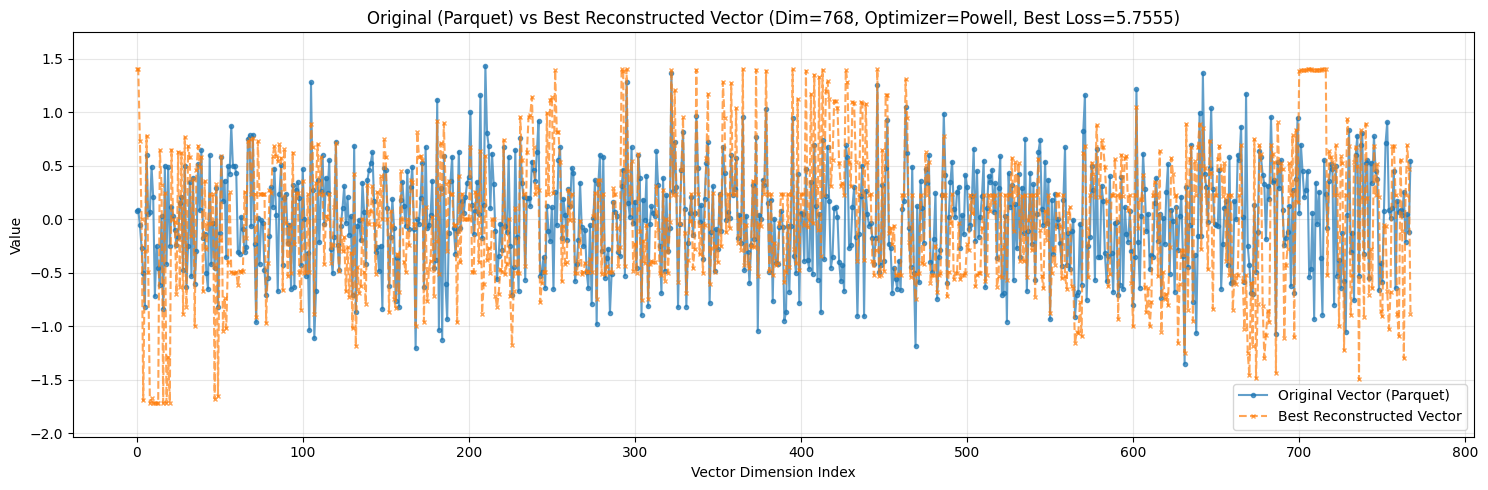


--- Experiment End ---


In [ ]:
# @title Validation: Reconstruction-Test on Actual Values from LLMs { display-mode: "form" }

# !pip install -q python-Levenshtein numpy pandas scipy pyarrow scikit-learn matplotlib # Ensure necessary libs

import numpy as np
import pandas as pd
import time
import os
import shutil
import pyarrow.parquet as pq # Added for Parquet loading
import scipy.sparse as sp
from scipy.spatial import distance as sp_distance
from scipy.stats import spearmanr, pearsonr, skew, kurtosis
# from Levenshtein import distance as levenshtein # No longer used
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split # For splitting data (if needed later)
import matplotlib.pyplot as plt # Added for optional plotting

# --- User's Data Loading Functions ---

def get_safe_copy_path(full_path, eval_sample):
    """Creates a unique path for a copy based on eval_sample."""
    # Split the file path into base and extension
    file_base, file_ext = os.path.splitext(full_path)

    # Construct the suffix
    suffix = f"-E{eval_sample}"

    # Only append suffix if it's not already there to avoid duplication on reruns
    # Simple check: if the base doesn't end with '-E' followed by digits
    import re
    if not re.search(r"-E\d+$", file_base):
         copy_path = f"{file_base}{suffix}{file_ext}"
    else: # Already has a suffix, reuse path (or modify if needed)
         copy_path = full_path
         print(f"Warning: Path '{full_path}' might already have an eval suffix. Reusing.")

    # Ensure the directory exists
    os.makedirs(os.path.dirname(copy_path), exist_ok=True)
    return copy_path

def reconstruct_from_normalized(sparse_array, min_val, max_val):
    """Denormalizes sparse array data."""
    # Inverse normalization scaling factors
    # Assuming normalization was to UINT32 max value (2**32 - 1)
    scale_factor = (max_val - min_val) / 4294967295.0 # Use float division
    shift_factor = min_val

    # Apply denormalization directly on sparse matrix data
    # Create a new sparse matrix for the result to avoid modifying original
    denormalized_data = sparse_array.copy().astype(np.float64) # Work with float64 for precision
    denormalized_data.data = denormalized_data.data * scale_factor + shift_factor

    return denormalized_data

def getNormalizedValues(full_path, evalSample=0):
    """Loads data from Parquet, denormalizes, returns COO matrix, min, max."""
    # Duplicate files to preserve the originals
    # copy_path = get_safe_copy_path(full_path, evalSample)
    # shutil.copy(full_path, copy_path) # Copying might not be needed if just reading
    copy_path = full_path # Read directly for reconstruction test
    print(f"Reading data from: {copy_path}")

    # Read sparse arrays directly from the parquet files
    try:
        sentenceDf = pq.read_table(copy_path).to_pandas(safe=False)
    except Exception as e:
        print(f"Error reading Parquet file {copy_path}: {e}")
        raise

    # Extract scalar min and max values from the first row
    min_val, max_val = sentenceDf['Min'].iloc[0], sentenceDf['Max'].iloc[0]

    # Drop non-neuron columns
    # Identify potential non-neuron columns case-insensitively
    cols_to_drop = [col for col in sentenceDf.columns if col.lower() in ['source', 'sentence', 'min', 'max']]
    sentenceDf = sentenceDf.drop(columns=cols_to_drop)

    # Convert DataFrame to sparse COO matrix (assuming uint32 normalized data)
    # Ensure data is numeric before converting
    neurons_normalized = sp.coo_matrix(sentenceDf.to_numpy(dtype=np.uint32))

    # Denormalize
    neurons_denormalized = reconstruct_from_normalized(neurons_normalized, min_val, max_val)

    return neurons_denormalized.tocoo(), min_val, max_val

def load_data_from_parquet(parquet_path):
    """Loads and denormalizes data, returning flattened array, min, max."""
    sparse_data_coo, min_val, max_val = getNormalizedValues(parquet_path, 0)
    # Convert sparse data to dense array and flatten
    data_array = sparse_data_coo.toarray().flatten().astype(np.float32) # Use float32 for consistency
    return data_array, min_val, max_val

# --- Configuration ---

# 1. Data Loading FROM PARQUET
PARQUET_FILE_PATH = "./LookUpGPT2/Evaluation/Generated/Layer16/Source=0/Sentence0-0.parquet" # Specify the file to use
print(f"Loading original vector from: {PARQUET_FILE_PATH}")
try:
    original_vector, min_val, max_val = load_data_from_parquet(PARQUET_FILE_PATH)
    print(f"Successfully loaded data. Vector length: {len(original_vector)}")
    print(f"Data range: Min={min_val:.6f}, Max={max_val:.6f}")
except Exception as e:
    print(f"FATAL ERROR loading data. Exiting. Error: {e}")
    exit()

DUMMY_DIM = len(original_vector) # Set dimension based on loaded data
fft_len = DUMMY_DIM // 2 + 1      # Recalculate fft_len based on actual dimension
print(f"Actual data dimension: {DUMMY_DIM}")

# Set reconstruction bounds based on loaded min/max
# Add a small epsilon to avoid issues exactly at the boundary if needed
epsilon = (max_val - min_val) * 1e-6
reconstruction_bounds = [(min_val - epsilon, max_val + epsilon)] * DUMMY_DIM
print(f"Reconstruction bounds set to: [{min_val - epsilon:.6f}, {max_val + epsilon:.6f}]")


# 2. Experiment Parameters
MAX_OPTIMIZER_ITERATIONS = 3500
OPTIMIZER_METHOD = 'Powell'
N_OPTIMIZATION_RUNS = 5
print(f"Using Optimizer: {OPTIMIZER_METHOD}")
print(f"Performing {N_OPTIMIZATION_RUNS} optimization runs with max {MAX_OPTIMIZER_ITERATIONS} iterations each.")

# Define the multiple fixed reference points
# Adjust reference values if data range is very different from [0,1]?
# For now, keep them, but create them based on the loaded dimension and type.
# Let's add the mean value of the loaded data as a reference too.
data_mean = original_vector.mean()
REFERENCE_VALUES = [min_val + 0.1*(max_val-min_val), # 10% point
                    min_val + 0.5*(max_val-min_val), # 50% point (median approx)
                    data_mean,                     # Actual mean
                    min_val + 0.9*(max_val-min_val), # 90% point
                    'linspace', 'sine'] # Keep structural references
print(f"Using reference points/types: {REFERENCE_VALUES}")


# --- Metric Definitions ---
# (METRICS dictionary remains the same as previous version, including Complex FFT)
METRICS = {
    'L2 norm (Euclidean)': lambda d, c: np.sqrt(np.sum((d - c)**2)),
    'L1 norm (Manhattan)': lambda d, c: np.sum(np.abs(d - c)),
    'Canberra': lambda d, c: np.sum(np.abs(d - c) / (np.abs(d) + np.abs(c) + 1e-10)),
    'L∞ norm (Chebyshev)': lambda d, c: np.max(np.abs(d - c)),
    'Cosine Similarity': lambda d, c: (1 - sp_distance.cosine(d, c) if (np.linalg.norm(d) > 1e-9 and np.linalg.norm(c) > 1e-9) else 0.0),
    'Pearson Correlation': lambda d, c: pearsonr(d, c)[0] if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,
    'Spearman Correlation': lambda d, c: spearmanr(d, c).correlation if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,
    'Chi-square': lambda d, c: np.sum(np.where((d + c) > 0, (d - c)**2 / (d + c + 1e-10), 0)),
    'FFT Complex L2': lambda d, target_fft_complex: np.linalg.norm(np.fft.fft(d)[:fft_len] - target_fft_complex),
    'Skewness': lambda d, _: skew(d) if np.std(d) > 1e-9 else 0.0,
    'Kurtosis': lambda d, _: kurtosis(d, fisher=True) if np.std(d) > 1e-9 else 0.0, # Fisher=True (excess kurtosis) is default
    'Median': lambda d, _: np.median(d),
    'Diff L2 Norm': lambda d, _: np.linalg.norm(np.diff(d)) if len(d)>1 else 0.0,
}

# Select metrics to actually use
ACTIVE_METRIC_BASE_NAMES = [
    'L2 norm (Euclidean)', 'L1 norm (Manhattan)', 'Cosine Similarity',
    'Pearson Correlation', 'Spearman Correlation', 'L∞ norm (Chebyshev)',
    'Canberra', 'Chi-square', 'FFT Complex L2',
    'Skewness', 'Kurtosis', 'Median', 'Diff L2 Norm',
]
print(f"Using {len(ACTIVE_METRIC_BASE_NAMES)} active base metric types.")


# --- MetricProcessor for Diverse References ---
# (Class definition remains the same as previous version)
class MetricProcessorMultiRef:
    def __init__(self, reference_values=['linspace']):
        if not isinstance(reference_values, list): reference_values = [reference_values]
        self._reference_values = reference_values
        self.comparison_vectors = {}

    def preprocess(self, template_vector):
        self.comparison_vectors = {}
        vector_len = len(template_vector); dtype = template_vector.dtype
        vector_min, vector_max = template_vector.min(), template_vector.max() # Get range for scaling linspace/sine
        print(f"Preprocessing MetricProcessor for {len(self._reference_values)} references...")
        print(f"  Template vector range: [{vector_min:.4f}, {vector_max:.4f}]")

        for key in self._reference_values:
            if isinstance(key, (int, float, np.number)): # Handle actual numeric values passed (like data_mean)
                comp_vec = np.full(vector_len, key, dtype=dtype)
                print(f"  Created constant reference vector for value: {key:.4f}")
            elif key == 'linspace':
                # Scale linspace to match the template vector's actual range
                comp_vec = np.linspace(vector_min, vector_max, vector_len).astype(dtype)
                print(f"  Created linspace reference vector scaled to data range.")
            elif key == 'sine':
                # Scale sine wave to roughly match the template vector's actual range
                amplitude = (vector_max - vector_min) / 2
                midpoint = vector_min + amplitude
                comp_vec = (np.sin(np.linspace(0, 2 * np.pi, vector_len)) * amplitude + midpoint).astype(dtype)
                print(f"  Created sine reference vector scaled to data range.")
            else:
                raise ValueError(f"Unknown reference value type: {key}")
            self.comparison_vectors[key] = comp_vec
        print("Preprocessing complete.")

    def calculate(self, data, active_metric_base_names):
        if not self.comparison_vectors: raise ValueError("Processor must be preprocessed.")
        combined_results = {}; data_std_dev_ok = np.std(data) > 1e-9
        data_only_metrics = {'FFT Complex L2', 'Skewness', 'Kurtosis', 'Median', 'Diff L2 Norm'}

        for ref_key, comp_vec in self.comparison_vectors.items():
            # Use str(ref_key) in case the key is numeric, for consistent dict keys later
            str_ref_key = str(ref_key)
            if data.shape != comp_vec.shape: raise ValueError(f"Shape mismatch for key '{str_ref_key}'")
            comp_vec_std_dev_ok = np.std(comp_vec) > 1e-9

            for base_name in active_metric_base_names:
                if base_name in data_only_metrics: continue
                if base_name not in METRICS: continue

                metric_func = METRICS[base_name]; result_key = f"{base_name}_{str_ref_key}"; result_val = np.nan
                try:
                    if base_name in {'Pearson Correlation', 'Spearman Correlation'}:
                        if data_std_dev_ok and comp_vec_std_dev_ok: result_val = metric_func(data, comp_vec)
                        else: result_val = 0.0
                    else: result_val = metric_func(data, comp_vec)
                except Exception as e: print(f"Error calculating {result_key}: {e}")
                combined_results[result_key] = result_val
        return combined_results

# --- Reconstruction Functions ---

# Loss function with scaling (same as previous version)
def reconstruction_loss_multi_ref(v, target_results, precomputed_target_fft_complex,
                                  processor, base_metric_weights,
                                  active_metric_base_names, reference_values):
    v = np.asarray(v);
    # Check against actual bounds used in optimization might be better
    # if np.any(np.isnan(v)) or np.any(v < (min_val-epsilon*2)) or np.any(v > (max_val+epsilon*2)): return 1e12
    if np.any(np.isnan(v)): return 1e12 # Simpler check
    total_error = 0.0; num_metrics_used = 0
    data_only_metrics = {'FFT Complex L2', 'Skewness', 'Kurtosis', 'Median', 'Diff L2 Norm'}

    # 1. Calculate standard metrics (vs references)
    try:
        processor_active_names = [m for m in active_metric_base_names if m not in data_only_metrics]
        current_results_vs_ref = processor.calculate(v, processor_active_names)
    except Exception as e: print(f"Warning: Metric calculation (vs refs) failed: {e}"); return 1e12

    # Calculate error for metrics vs references
    for base_name in processor_active_names:
        weight = base_metric_weights.get(base_name, 0.0);
        if weight == 0: continue
        # Iterate through the keys used by the processor (which might be strings or numbers)
        for ref_key in processor._reference_values: # Use the keys stored in the processor
            metric_key = f"{base_name}_{str(ref_key)}" # Ensure key matches format from calculate
            if metric_key not in target_results or metric_key not in current_results_vs_ref: continue
            target_val = target_results[metric_key]; current_val = current_results_vs_ref[metric_key]
            if np.isnan(target_val): continue
            elif np.isnan(current_val): error = 10.0
            else:
                denominator = abs(target_val); error = (current_val - target_val)**2 if denominator < 1e-9 else ((current_val - target_val) / denominator)**2
                error = min(error, 1000.0)
            total_error += error * weight; num_metrics_used += 1

    # 2. Calculate error for data-only metrics with improved scaling
    for base_name in data_only_metrics:
        if base_name not in active_metric_base_names: continue
        weight = base_metric_weights.get(base_name, 0.0);
        if weight == 0: continue
        metric_key = f"{base_name}_target";
        if metric_key not in target_results: print(f"Warning: Target key {metric_key} not found."); continue
        target_val = target_results[metric_key];
        if np.isnan(target_val): continue

        current_val = np.nan; error = 0.0
        try:
            metric_func = METRICS[base_name]
            if base_name == 'FFT Complex L2':
                current_val = metric_func(v, precomputed_target_fft_complex)
                target_fft_norm = np.linalg.norm(precomputed_target_fft_complex)
                denominator = target_fft_norm if target_fft_norm > 1e-9 else 1.0
                error = (current_val / denominator)**2 # Relative squared L2 error for FFT vector
            else: # Skew, Kurt, Median, Diff L2
                current_val = metric_func(v, None)
                # Apply standard relative/absolute squared error logic
                denominator = abs(target_val);
                error = (current_val - target_val)**2 if denominator < 1e-9 else ((current_val - target_val) / denominator)**2

            if np.isnan(current_val): error = 10.0
            error = min(error, 1000.0) # Cap the scaled error
            total_error += error * weight; num_metrics_used += 1
        except Exception as e: print(f"Error calculating {base_name}: {e}"); total_error += 10.0 * weight

    if num_metrics_used == 0: return 1e12
    return total_error / num_metrics_used


# Reconstruction function (same as previous version, takes complex FFT target)
def attempt_reconstruction_multi_ref(target_results, precomputed_target_fft_complex,
                                     vector_dim, metric_processor,
                                     active_metric_base_names, base_metric_weights,
                                     initial_guess=None, bounds=None,
                                     max_iterations=1000, optimizer_method='Nelder-Mead'):
    if not isinstance(metric_processor, MetricProcessorMultiRef): raise ValueError("Bad processor")
    reference_values = metric_processor._reference_values # Get keys used by processor

    if initial_guess is None:
        ref_vecs = list(metric_processor.comparison_vectors.values())
        initial_guess = np.mean(ref_vecs, axis=0) if ref_vecs else np.random.rand(vector_dim)
    initial_guess = np.asarray(initial_guess); assert initial_guess.shape[0] == vector_dim, "Guess dim mismatch"

    start_time = time.time();
    if bounds: bounds = list(bounds)

    args_tuple = (target_results, precomputed_target_fft_complex, metric_processor,
                  base_metric_weights, active_metric_base_names, reference_values)

    opt_result = minimize(reconstruction_loss_multi_ref, initial_guess, args=args_tuple,
                          method=optimizer_method, options={'maxiter': max_iterations, 'disp': False, 'xtol': 1e-6, 'ftol': 1e-6},
                          bounds=bounds) # Note: Powell ignores bounds arg here
    end_time = time.time()

    final_vector = opt_result.x
    if bounds: # Apply bounds strictly post-optimization
        lower_bounds = np.array([b[0] for b in bounds]); upper_bounds = np.array([b[1] for b in bounds])
        final_vector = np.clip(final_vector, lower_bounds, upper_bounds)
    # Ensure final vector dtype matches original
    final_vector = final_vector.astype(original_vector.dtype)
    return final_vector, opt_result

# --- Example Usage ---

# 1. Original vector info (Loaded from Parquet)
print("\n--- Original Vector Info (from Parquet) ---")
print(f"Shape: {original_vector.shape}")
print(f"Min: {original_vector.min():.6f}, Max: {original_vector.max():.6f}, Mean: {original_vector.mean():.6f}, StdDev: {original_vector.std():.6f}")

# 2. Preprocess processor
processor_multi = MetricProcessorMultiRef(reference_values=REFERENCE_VALUES)
processor_multi.preprocess(original_vector) # Use loaded vector as template

# 3. Calculate target metrics
print("\nCalculating target metrics for original vector...")
target_metrics_multi = processor_multi.calculate(original_vector, ACTIVE_METRIC_BASE_NAMES)
precomputed_target_fft_complex = np.fft.fft(original_vector)[:fft_len]
target_metrics_multi['FFT Complex L2_target'] = 0.0
if 'Skewness' in ACTIVE_METRIC_BASE_NAMES: target_metrics_multi['Skewness_target'] = METRICS['Skewness'](original_vector, None)
if 'Kurtosis' in ACTIVE_METRIC_BASE_NAMES: target_metrics_multi['Kurtosis_target'] = METRICS['Kurtosis'](original_vector, None)
if 'Median' in ACTIVE_METRIC_BASE_NAMES: target_metrics_multi['Median_target'] = METRICS['Median'](original_vector, None)
if 'Diff L2 Norm' in ACTIVE_METRIC_BASE_NAMES: target_metrics_multi['Diff L2 Norm_target'] = METRICS['Diff L2 Norm'](original_vector, None)
print(f"Target Metrics Calculated ({len(target_metrics_multi)} total).")

# 4. Attempt reconstruction - MULTIPLE RUNS
print(f"\n--- Starting Multi-Reference Reconstruction ({N_OPTIMIZATION_RUNS} Runs, Data from Parquet) ---")

# Define BASE weights
base_weights = {name: 0.0 for name in METRICS}
base_weights['L2 norm (Euclidean)'] = 15.0
base_weights['L1 norm (Manhattan)'] = 5.0
base_weights['L∞ norm (Chebyshev)'] = 5.0
base_weights['Cosine Similarity'] = 10.0
base_weights['Canberra'] = 0.3
base_weights['Chi-square'] = 0.3
base_weights['Pearson Correlation'] = 5.0
base_weights['Spearman Correlation'] = 5.0
base_weights['FFT Complex L2'] = 15.0
base_weights['Skewness'] = 2.0
base_weights['Kurtosis'] = 2.0
base_weights['Median'] = 5.0
base_weights['Diff L2 Norm'] = 8.0

active_base_weights = {k: base_weights[k] for k in ACTIVE_METRIC_BASE_NAMES if k in base_weights}
print(f"Using {len(active_base_weights)} non-zero Base Metric Weights: {active_base_weights}")

# --- Multi-Run Optimization Loop ---
best_loss = np.inf; best_vector = None; best_result_info = None; total_optimization_time = 0
for i in range(N_OPTIMIZATION_RUNS):
    run_start_time = time.time(); print(f"\n--- Optimization Run {i+1}/{N_OPTIMIZATION_RUNS} ---")
    # Start guess within the actual data bounds
    start_guess = np.random.uniform(low=min_val, high=max_val, size=DUMMY_DIM).astype(original_vector.dtype)
    print(f"  Initial Guess Stats (Run {i+1}): Min={start_guess.min():.3f}, Max={start_guess.max():.3f}, Mean={start_guess.mean():.3f}")

    temp_reconstructed_v, temp_result_info = attempt_reconstruction_multi_ref(
        target_metrics_multi, precomputed_target_fft_complex,
        vector_dim=DUMMY_DIM, metric_processor=processor_multi,
        active_metric_base_names=ACTIVE_METRIC_BASE_NAMES, base_metric_weights=active_base_weights,
        initial_guess=start_guess, bounds=reconstruction_bounds, # Use actual bounds
        max_iterations=MAX_OPTIMIZER_ITERATIONS, optimizer_method=OPTIMIZER_METHOD
    )
    run_end_time = time.time(); run_duration = run_end_time - run_start_time; total_optimization_time += run_duration
    print(f"  Run {i+1} Finished in {run_duration:.2f} sec.")
    print(f"  Success: {temp_result_info.success}, Status: {temp_result_info.message}")
    print(f"  Final loss (Run {i+1}): {temp_result_info.fun:.6f}")
    print(f"  Number of Function Evaluations: {temp_result_info.nfev}")
    if temp_result_info.fun < best_loss:
        print(f"  **** Found new best loss: {temp_result_info.fun:.6f} (previous best: {best_loss:.6f}) ****")
        best_loss = temp_result_info.fun; best_vector = temp_reconstructed_v; best_result_info = temp_result_info
# --- End Multi-Run Loop ---

print(f"\n--- Optimization Complete ({N_OPTIMIZATION_RUNS} runs, Data from Parquet) ---")
print(f"Total optimization time: {total_optimization_time:.2f} seconds.")
if best_vector is None: print("ERROR: No successful optimization run completed."); exit()
print(f"Best loss achieved: {best_loss:.6f}")
reconstructed_v_multi = best_vector; result_info_multi = best_result_info

# 5. Evaluate Reconstruction (Using the BEST vector found)
if reconstructed_v_multi is not None and reconstructed_v_multi.shape == original_vector.shape:
    print("\n--- Evaluating Best Reconstruction Result ---")
    print("Reconstructed Vector Stats (Best Run):")
    print(f" Min: {reconstructed_v_multi.min():.6f}, Max: {reconstructed_v_multi.max():.6f}, Mean: {reconstructed_v_multi.mean():.6f}, StdDev: {reconstructed_v_multi.std():.6f}")

    # Calculate metrics for the best reconstructed vector
    reconstructed_metrics_vs_ref = processor_multi.calculate(reconstructed_v_multi, ACTIVE_METRIC_BASE_NAMES)
    reconstructed_metrics_data_only = {}
    if 'FFT Complex L2' in ACTIVE_METRIC_BASE_NAMES: reconstructed_metrics_data_only['FFT Complex L2_target'] = METRICS['FFT Complex L2'](reconstructed_v_multi, precomputed_target_fft_complex)
    if 'Skewness' in ACTIVE_METRIC_BASE_NAMES: reconstructed_metrics_data_only['Skewness_target'] = METRICS['Skewness'](reconstructed_v_multi, None)
    if 'Kurtosis' in ACTIVE_METRIC_BASE_NAMES: reconstructed_metrics_data_only['Kurtosis_target'] = METRICS['Kurtosis'](reconstructed_v_multi, None)
    if 'Median' in ACTIVE_METRIC_BASE_NAMES: reconstructed_metrics_data_only['Median_target'] = METRICS['Median'](reconstructed_v_multi, None)
    if 'Diff L2 Norm' in ACTIVE_METRIC_BASE_NAMES: reconstructed_metrics_data_only['Diff L2 Norm_target'] = METRICS['Diff L2 Norm'](reconstructed_v_multi, None)
    reconstructed_metrics_all = {**reconstructed_metrics_vs_ref, **reconstructed_metrics_data_only}

    print("\nComparison (Target vs Reconstructed Metrics - Best Run):")
    max_name_len = 0; active_print_keys = set()
    all_print_keys = set(target_metrics_multi.keys()) | set(reconstructed_metrics_all.keys())
    for k in all_print_keys:
         base_name = k.split('_')[0]; suffix = k.split('_')[-1]
         if base_name in ACTIVE_METRIC_BASE_NAMES or (base_name == 'FFT' and 'Complex' in k): active_print_keys.add(k)
    if active_print_keys: max_name_len = max(len(name) for name in active_print_keys) + 2 # Adjust padding as needed

    total_recon_metric_error = 0; count = 0
    sorted_metric_keys = sorted(list(active_print_keys))

    for key in sorted_metric_keys:
        base_name = key.split('_')[0]; display_key = key;
        target_val = target_metrics_multi.get(key, np.nan); recon_val = reconstructed_metrics_all.get(key, np.nan)
        if key.endswith('_target'): display_key = key.replace('_target', '')
        if np.isnan(target_val): continue

        if np.isnan(recon_val):
            diff = np.inf; rel_diff = np.inf
            print(f"{display_key:<{max_name_len}} | Target={target_val: >11.5f} | Recon=            nan | AbsDiff=            inf | RelDiff=          inf%")
        else:
            diff = abs(target_val - recon_val)
            if abs(target_val) > 1e-9: rel_diff = (diff / abs(target_val)) * 100
            elif diff < 1e-9: rel_diff = 0.0
            else: rel_diff = np.inf

            # Special display for FFT L2 Distance (target is 0)
            if display_key == 'FFT Complex L2':
                print(f"{'FFT Complex L2 Dist':<{max_name_len}} | Target={0.0: >11.5f} | Recon={recon_val: >11.5f} | AbsDiff={diff: >11.5f} | RelDiff={rel_diff: >12.2f}%")
            else:
                print(f"{display_key:<{max_name_len}} | Target={target_val: >11.5f} | Recon={recon_val: >11.5f} | AbsDiff={diff: >11.5f} | RelDiff={rel_diff: >12.2f}%")

            denominator = abs(target_val); error = (recon_val - target_val)**2 if denominator < 1e-9 else ((recon_val - target_val) / denominator)**2
            error = min(error, 1000.0); total_recon_metric_error += error; count += 1

    if count > 0: print(f"\nMean Squared Relative/Absolute Error (metrics, post-optimization, unweighted): {total_recon_metric_error/count:.6f}")
    else: print("\nNo metrics available for error calculation.")

    # ----> Key Evaluation: Compare reconstructed vector to the original vector <----
    print(f"\n--- Vector Reconstruction Quality (Best Run, Data from Parquet) ---")
    l2_diff_vectors = np.linalg.norm(original_vector - reconstructed_v_multi)
    norm_orig = np.linalg.norm(original_vector); norm_recon = np.linalg.norm(reconstructed_v_multi)
    if norm_orig > 1e-9 and norm_recon > 1e-9: cosine_sim_vectors = 1.0 - sp_distance.cosine(original_vector, reconstructed_v_multi)
    elif abs(norm_orig - norm_recon) < 1e-9 : cosine_sim_vectors = 1.0
    else: cosine_sim_vectors = 0.0
    print(f"L2 distance between original and reconstructed vectors: {l2_diff_vectors:.6f}")
    print(f"Cosine similarity between original and reconstructed vectors: {cosine_sim_vectors:.6f}")

    # --- Optional: Plotting ---
    plt.figure(figsize=(15, 5))
    plt.plot(original_vector, label='Original Vector (Parquet)', alpha=0.7, marker='.', linestyle='-') # Smaller marker for potentially large dim
    plt.plot(reconstructed_v_multi, label=f'Best Reconstructed Vector', alpha=0.7, marker='x', markersize=3, linestyle='--')
    plt.title(f'Original (Parquet) vs Best Reconstructed Vector (Dim={DUMMY_DIM}, Optimizer={OPTIMIZER_METHOD}, Best Loss={best_loss:.4f})')
    plt.xlabel('Vector Dimension Index'); plt.ylabel('Value'); plt.legend(); plt.grid(True, alpha=0.3)
    plot_min = np.min([original_vector.min(), reconstructed_v_multi.min()]); plot_max = np.max([original_vector.max(), reconstructed_v_multi.max()])
    plot_range = plot_max - plot_min if plot_max > plot_min else (abs(plot_max) + 1e-6) # Handle zero range
    plt.ylim(plot_min - 0.1*plot_range, plot_max + 0.1*plot_range) # Dynamic ylim
    plt.tight_layout()
    # plt.savefig(f'reconstruction_parquet_final.png')
    plt.show()

else:
     print(f"\nReconstruction failed (Data from Parquet, Shape mismatch or no best vector).")

print("\n--- Experiment End ---")

Using 14 active base metric types.
Attempting to load 10 files matching pattern: ./LookUpGPT2/Evaluation/Generated/Layer16/Source=0/Sentence{0}-0.parquet...
  Detected dimension: 768
Error: File ./LookUpGPT2/Evaluation/Generated/Layer16/Source=0/Sentence8-0.parquet has dimension 767, expected 768. Skipping.
Successfully loaded 9 vectors.

Data loaded: 9 vectors of dimension 768.
Overall data range: [-1.718076, 1.463958]
Preprocessing MetricProcessor for 5 references...
  Template vector range: [-1.7181, 1.4640], Mean: 0.0007
  Created constant reference vector for relative point 0.1 -> value: -1.3999
  Created constant reference vector for data mean: 0.0007
  Created constant reference vector for relative point 0.9 -> value: 1.1458
  Created linspace reference vector scaled to data range.
  Created sine reference vector scaled to data range.
Preprocessing complete.

Calculating metric signatures for 9 vectors...
Metric signature calculation finished in 0.11 sec.

Metric signature DataF

<ipython-input-35-d2fea67670a2>:126: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  'Pearson Correlation': lambda d, c: pearsonr(d, c)[0] if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,
<ipython-input-35-d2fea67670a2>:127: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  'Spearman Correlation': lambda d, c: spearmanr(d, c).correlation if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,


Finding 8 nearest neighbors in Metric Space (Euclidean on Standardized)...

Evaluating overlap for K = 8...

--- Experiment Results ---
Number of vectors compared (N): 9
Number of neighbors considered (K): 8
Number of metric features used: 45
Average Precision@8: 1.0000
Standard Deviation of Precision@8: 0.0000
Total execution time: 6.69 sec.


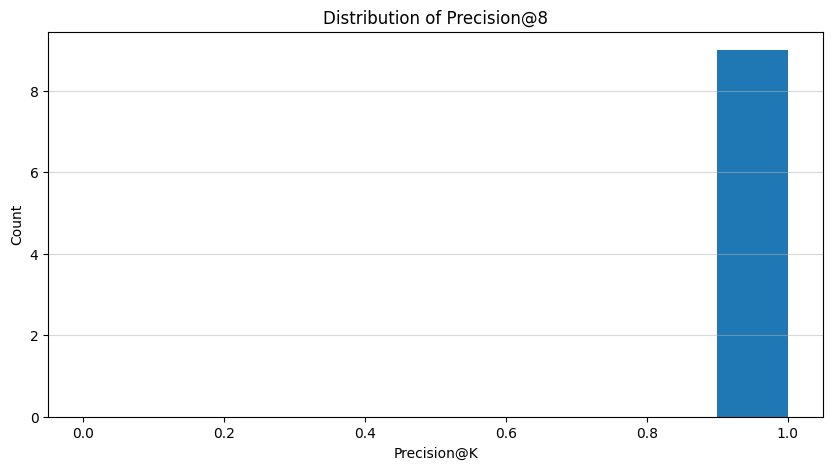


--- Experiment End ---


In [ ]:
# @title Validation: Metrics-Test using KNN as Evaluation { display-mode: "form" }

# !pip install -q python-Levenshtein numpy pandas scipy pyarrow scikit-learn matplotlib # Ensure necessary libs

import numpy as np
import pandas as pd
import time
import os
import shutil
import pyarrow.parquet as pq # Added for Parquet loading
import scipy.sparse as sp
from scipy.spatial import distance as sp_distance
from scipy.stats import spearmanr, pearsonr, skew, kurtosis
# from Levenshtein import distance as levenshtein # No longer used
from scipy.optimize import minimize # Not used in this script, but keep if needed later
from sklearn.model_selection import train_test_split # Not used here
from sklearn.neighbors import NearestNeighbors # For KNN search
from sklearn.preprocessing import StandardScaler # For standardizing metrics
import matplotlib.pyplot as plt # Added for optional plotting
import re # Import regex

# --- User's Data Loading Functions (Modified slightly) ---

def get_safe_copy_path(full_path, eval_sample):
    """Creates a unique path for a copy based on eval_sample."""
    file_base, file_ext = os.path.splitext(full_path)
    suffix = f"-E{eval_sample}"
    if not re.search(r"-E\d+$", file_base): copy_path = f"{file_base}{suffix}{file_ext}"
    else: copy_path = full_path; # print(f"Warning: Path '{full_path}' might already have an eval suffix. Reusing.")
    os.makedirs(os.path.dirname(copy_path), exist_ok=True)
    return copy_path

def reconstruct_from_normalized(sparse_array, min_val, max_val):
    """Denormalizes sparse array data."""
    scale_factor = (max_val - min_val) / 4294967295.0
    shift_factor = min_val
    denormalized_data = sparse_array.copy().astype(np.float64)
    denormalized_data.data = denormalized_data.data * scale_factor + shift_factor
    return denormalized_data

def getNormalizedValues(full_path):
    """Loads data from Parquet, denormalizes, returns COO matrix, min, max."""
    copy_path = full_path # Read directly
    # print(f"Reading data from: {copy_path}") # Verbose
    try: sentenceDf = pq.read_table(copy_path).to_pandas(safe=False)
    except Exception as e: print(f"Error reading Parquet file {copy_path}: {e}"); raise

    min_val, max_val = sentenceDf['Min'].iloc[0], sentenceDf['Max'].iloc[0]
    cols_to_drop = [col for col in sentenceDf.columns if col.lower() in ['source', 'sentence', 'min', 'max']]
    sentenceDf = sentenceDf.drop(columns=cols_to_drop)
    for col in sentenceDf.columns: sentenceDf[col] = pd.to_numeric(sentenceDf[col], errors='coerce')
    sentenceDf = sentenceDf.fillna(0)
    neurons_normalized = sp.coo_matrix(sentenceDf.to_numpy(dtype=np.uint32))
    neurons_denormalized = reconstruct_from_normalized(neurons_normalized, min_val, max_val)
    return neurons_denormalized.tocoo(), min_val, max_val

def load_multiple_vectors(file_pattern, num_files):
    """Loads multiple vectors specified by pattern."""
    vectors = []
    min_vals = []
    max_vals = []
    loaded_paths = []
    expected_dim = None

    print(f"Attempting to load {num_files} files matching pattern: {file_pattern}...")
    for i in range(num_files):
        # Construct file path using the pattern and index i
        current_path = file_pattern.format(i) # Assumes pattern uses {0} for index
        if not os.path.exists(current_path):
            print(f"Warning: File not found {current_path}. Skipping.")
            continue

        try:
            sparse_data_coo, min_v, max_v = getNormalizedValues(current_path)
            data_array = sparse_data_coo.toarray().flatten().astype(np.float32)

            if expected_dim is None:
                expected_dim = len(data_array)
                print(f"  Detected dimension: {expected_dim}")
            elif len(data_array) != expected_dim:
                print(f"Error: File {current_path} has dimension {len(data_array)}, expected {expected_dim}. Skipping.")
                continue

            vectors.append(data_array)
            min_vals.append(min_v)
            max_vals.append(max_v)
            loaded_paths.append(current_path)
            # print(f"  Loaded {current_path} (Range: [{min_v:.4f}, {max_v:.4f}])") # Verbose

        except Exception as e:
            print(f"Error processing file {current_path}: {e}. Skipping.")

    if not vectors:
        raise ValueError("No vectors were successfully loaded.")

    print(f"Successfully loaded {len(vectors)} vectors.")
    # Stack vectors into a single numpy array (rows are vectors)
    original_data_matrix = np.vstack(vectors)
    # Return overall min/max across loaded data for reference
    overall_min = np.min(min_vals)
    overall_max = np.max(max_vals)

    return original_data_matrix, overall_min, overall_max, loaded_paths

# --- Configuration for Similarity Experiment ---

# 1. Data Loading Setup
N_FILES_TO_LOAD = 10 # How many files (sentences 0 to N-1) to load? Adjust as needed.
# Define pattern for file paths, using {0} for the sentence index
FILE_PATTERN = "./LookUpGPT2/Evaluation/Generated/Layer16/Source=0/Sentence{0}-0.parquet"
K_NEIGHBORS = 10 # How many nearest neighbors to compare?

# 2. Metric Calculation Setup
# Reference values - use overall min/max from loaded data
# Keep structural references constant for now
REFERENCE_VALUES_TEMPLATE = [0.1, 'mean', 0.9, 'linspace', 'sine'] # Use relative points + mean

# --- Metric Definitions ---
# Use metrics defined in the previous code block (including FFT Complex L2, etc.)
METRICS = {
    'L2 norm (Euclidean)': lambda d, c: np.sqrt(np.sum((d - c)**2)),
    'L1 norm (Manhattan)': lambda d, c: np.sum(np.abs(d - c)),
    'Canberra': lambda d, c: np.sum(np.abs(d - c) / (np.abs(d) + np.abs(c) + 1e-10)),
    'L∞ norm (Chebyshev)': lambda d, c: np.max(np.abs(d - c)),
    'Cosine Similarity': lambda d, c: (1 - sp_distance.cosine(d, c) if (np.linalg.norm(d) > 1e-9 and np.linalg.norm(c) > 1e-9) else 0.0),
    'Pearson Correlation': lambda d, c: pearsonr(d, c)[0] if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,
    'Spearman Correlation': lambda d, c: spearmanr(d, c).correlation if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,
    'Chi-square': lambda d, c: np.sum(np.where((d + c) > 0, (d - c)**2 / (d + c + 1e-10), 0)),
    'FFT Complex L2': lambda d, target_fft_complex: np.linalg.norm(np.fft.fft(d)[:len(target_fft_complex)] - target_fft_complex), # Use target len
    'Skewness': lambda d, _: skew(d) if np.std(d) > 1e-9 else 0.0,
    'Kurtosis': lambda d, _: kurtosis(d, fisher=True) if np.std(d) > 1e-9 else 0.0,
    'Median': lambda d, _: np.median(d),
    'Mean': lambda d, _: np.mean(d),
    'Diff L2 Norm': lambda d, _: np.linalg.norm(np.diff(d)) if len(d)>1 else 0.0,
}
ACTIVE_METRIC_BASE_NAMES = list(METRICS.keys()) # Use all defined metrics for this test
print(f"Using {len(ACTIVE_METRIC_BASE_NAMES)} active base metric types.")


# --- MetricProcessor for Diverse References ---
# (Class definition remains the same as previous version)
class MetricProcessorMultiRef:
    def __init__(self, reference_values=['linspace']):
        if not isinstance(reference_values, list): reference_values = [reference_values]
        self._reference_values = reference_values; self.comparison_vectors = {}

    def preprocess(self, template_vector, data_min, data_max, data_mean):
        """ Preprocesses based on template vector AND actual data stats. """
        self.comparison_vectors = {}; vector_len = len(template_vector); dtype = template_vector.dtype
        print(f"Preprocessing MetricProcessor for {len(self._reference_values)} references...")
        print(f"  Template vector range: [{data_min:.4f}, {data_max:.4f}], Mean: {data_mean:.4f}")
        self._processed_reference_keys = [] # Store the actual keys/values used

        for key_template in self._reference_values:
            key = key_template # Default key is the template itself
            if isinstance(key_template, (int, float, np.number)) and 0.0 <= key_template <= 1.0:
                 # Interpret 0.1, 0.9 etc as relative points in the actual data range
                 key = data_min + key_template * (data_max - data_min)
                 comp_vec = np.full(vector_len, key, dtype=dtype); print(f"  Created constant reference vector for relative point {key_template} -> value: {key:.4f}")
            elif key_template == 'mean':
                 key = data_mean # Use the actual mean passed in
                 comp_vec = np.full(vector_len, key, dtype=dtype); print(f"  Created constant reference vector for data mean: {key:.4f}")
            elif key_template == 'linspace':
                 comp_vec = np.linspace(data_min, data_max, vector_len).astype(dtype); print(f"  Created linspace reference vector scaled to data range.")
                 key = 'linspace' # Keep key as string
            elif key_template == 'sine':
                 amplitude = (data_max - data_min) / 2.0 if data_max > data_min else 0.0
                 midpoint = data_min + amplitude
                 comp_vec = (np.sin(np.linspace(0, 2 * np.pi, vector_len)) * amplitude + midpoint).astype(dtype); print(f"  Created sine reference vector scaled to data range.")
                 key = 'sine' # Keep key as string
            else: # Assume it's already an absolute value if not caught above
                 if isinstance(key_template, (int, float, np.number)):
                     comp_vec = np.full(vector_len, key_template, dtype=dtype); print(f"  Created constant reference vector for value: {key_template:.4f}")
                 else:
                     raise ValueError(f"Unknown reference value type: {key_template}")

            self.comparison_vectors[key] = comp_vec
            self._processed_reference_keys.append(key) # Store the key used for this vector
        print("Preprocessing complete.")

    def calculate(self, data, active_metric_base_names):
        # (Calculation logic remains the same as previous version - uses self.comparison_vectors)
        if not self.comparison_vectors: raise ValueError("Processor must be preprocessed.")
        combined_results = {}; data_std_dev_ok = np.std(data) > 1e-9
        data_only_metrics = {'FFT Complex L2', 'Skewness', 'Kurtosis', 'Median', 'Mean', 'Diff L2 Norm'}
        for ref_key, comp_vec in self.comparison_vectors.items():
            str_ref_key = str(ref_key); # Use string representation of the key
            if data.shape != comp_vec.shape: raise ValueError(f"Shape mismatch for key '{str_ref_key}'")
            comp_vec_std_dev_ok = np.std(comp_vec) > 1e-9
            for base_name in active_metric_base_names:
                if base_name in data_only_metrics: continue
                if base_name not in METRICS: continue
                metric_func = METRICS[base_name]; result_key = f"{base_name}_{str_ref_key}"; result_val = np.nan
                try:
                    if base_name in {'Pearson Correlation', 'Spearman Correlation'}:
                        if data_std_dev_ok and comp_vec_std_dev_ok: result_val = metric_func(data, comp_vec)
                        else: result_val = 0.0
                    else: result_val = metric_func(data, comp_vec)
                except Exception as e: print(f"Error calculating {result_key}: {e}")
                combined_results[result_key] = result_val
        return combined_results


# --- Main Experiment Logic ---

start_overall_time = time.time()

# 1. Load Data
try:
    original_data_matrix, overall_min, overall_max, loaded_paths = load_multiple_vectors(FILE_PATTERN, N_FILES_TO_LOAD)
    N_loaded = original_data_matrix.shape[0]
    D_loaded = original_data_matrix.shape[1]
    fft_len = D_loaded // 2 + 1 # Calculate based on loaded dimension
    print(f"\nData loaded: {N_loaded} vectors of dimension {D_loaded}.")
    print(f"Overall data range: [{overall_min:.6f}, {overall_max:.6f}]")
    if N_loaded < K_NEIGHBORS + 1:
        print(f"Warning: Loaded fewer vectors ({N_loaded}) than K+1 ({K_NEIGHBORS+1}). Adjusting K.")
        K_NEIGHBORS = N_loaded - 1
        if K_NEIGHBORS < 1: raise ValueError("Need at least 2 vectors to compare neighbors.")
    if N_loaded <= 1:
        raise ValueError("Need at least 2 vectors to perform neighbor comparison.")

except Exception as e:
    print(f"Could not load data for experiment: {e}")
    exit()

# 2. Initialize Metric Processor
data_mean = np.mean(original_data_matrix) # Calculate mean across all loaded data
processor = MetricProcessorMultiRef(reference_values=REFERENCE_VALUES_TEMPLATE)
# Preprocess using the first vector as template, passing data stats
processor.preprocess(original_data_matrix[0,:], overall_min, overall_max, data_mean)

# 3. Calculate All Metric Signatures
print(f"\nCalculating metric signatures for {N_loaded} vectors...")
metric_signatures_list = []
calculation_start_time = time.time()

for i in range(N_loaded):
    v_i = original_data_matrix[i, :]
    signature = {}

    # Calculate metrics vs references
    metrics_vs_ref = processor.calculate(v_i, ACTIVE_METRIC_BASE_NAMES)
    signature.update(metrics_vs_ref)

    # Calculate data-only metrics
    # Precompute FFT only once per vector
    fft_complex_i = np.fft.fft(v_i)[:fft_len]
    for base_name in {'FFT Complex L2', 'Skewness', 'Kurtosis', 'Median', 'Mean', 'Diff L2 Norm'}:
         if base_name in ACTIVE_METRIC_BASE_NAMES:
             metric_func = METRICS[base_name]
             try:
                 if base_name == 'FFT Complex L2':
                     # Compare to ITSELF to get 0 distance - we store the FEATURES not distances here yet
                     # Store the computed metric value (e.g., Skewness value, Median value, Diff L2 norm)
                     # The FFT 'feature' could be the L2 distance to some reference FFT? Or store FFT coeffs?
                     # Let's store the METRIC VALUES directly (Skewness, Kurtosis, Median, DiffL2)
                     # For FFT, let's skip storing it as a simple feature for now, as comparing FFT vectors
                     # requires special handling in the distance metric or storing many coeffs.
                     # Storing L2 dist vs mean FFT? Too complex. Let's omit direct FFT features for now.
                     pass # Skip storing FFT feature directly for now
                 else:
                      signature[base_name] = metric_func(v_i, None)
             except Exception as e:
                 print(f"Error calculating {base_name} for vector {i}: {e}")
                 signature[base_name] = np.nan # Store NaN on error

    metric_signatures_list.append(signature)
    if (i + 1) % 10 == 0: print(f"  Processed {i+1}/{N_loaded}...")

calculation_end_time = time.time()
print(f"Metric signature calculation finished in {calculation_end_time - calculation_start_time:.2f} sec.")

# Convert list of dicts to DataFrame, then NumPy array
# This ensures consistent column order and handles potential missing values
metric_signatures_df = pd.DataFrame(metric_signatures_list)
print(f"\nMetric signature DataFrame shape: {metric_signatures_df.shape}")

# Handle potential NaN/Inf values produced during metric calculation
if metric_signatures_df.isnull().values.any() or np.isinf(metric_signatures_df.values).any():
    print("Warning: NaN or Inf values detected in metric signatures. Replacing with 0.")
    # Consider more sophisticated imputation (e.g., column mean) if appropriate
    metric_signatures_df = metric_signatures_df.fillna(0).replace([np.inf, -np.inf], 0)

metric_data_matrix = metric_signatures_df.to_numpy()
metric_names = metric_signatures_df.columns.tolist() # Get final list of metric features used

# 4. Standardize Metric Signatures
print("\nStandardizing metric signatures...")
scaler = StandardScaler()
standardized_metric_data = scaler.fit_transform(metric_data_matrix)
print(f"Standardized metric data shape: {standardized_metric_data.shape}")

# 5. Find Neighbors in Original Space (Using Euclidean Distance)
print(f"\nFinding {K_NEIGHBORS} nearest neighbors in Original Space (Euclidean)...")
nn_orig = NearestNeighbors(n_neighbors=K_NEIGHBORS + 1, metric='euclidean', n_jobs=-1)
nn_orig.fit(original_data_matrix)
distances_orig, indices_orig = nn_orig.kneighbors(original_data_matrix)

# 6. Find Neighbors in Metric Space (Using Euclidean Distance on Standardized Metrics)
print(f"Finding {K_NEIGHBORS} nearest neighbors in Metric Space (Euclidean on Standardized)...")
nn_metric = NearestNeighbors(n_neighbors=K_NEIGHBORS + 1, metric='euclidean', n_jobs=-1)
nn_metric.fit(standardized_metric_data)
distances_metric, indices_metric = nn_metric.kneighbors(standardized_metric_data)

# 7. Evaluate Overlap
print(f"\nEvaluating overlap for K = {K_NEIGHBORS}...")
total_overlap = 0
individual_precisions = []

for i in range(N_loaded):
    # Neighbors excluding self (index 0 is self)
    orig_neighbors = set(indices_orig[i, 1:])
    metric_neighbors = set(indices_metric[i, 1:])

    overlap = len(orig_neighbors.intersection(metric_neighbors))
    total_overlap += overlap
    precision_i = overlap / K_NEIGHBORS if K_NEIGHBORS > 0 else 0.0
    individual_precisions.append(precision_i)

average_precision = np.mean(individual_precisions) if individual_precisions else 0.0
std_dev_precision = np.std(individual_precisions) if individual_precisions else 0.0

end_overall_time = time.time()

# 8. Report Results
print("\n--- Experiment Results ---")
print(f"Number of vectors compared (N): {N_loaded}")
print(f"Number of neighbors considered (K): {K_NEIGHBORS}")
print(f"Number of metric features used: {standardized_metric_data.shape[1]}")
print(f"Average Precision@{K_NEIGHBORS}: {average_precision:.4f}")
print(f"Standard Deviation of Precision@{K_NEIGHBORS}: {std_dev_precision:.4f}")
print(f"Total execution time: {end_overall_time - start_overall_time:.2f} sec.")

# Optional: Print precision per item
# print("\nPrecision per item:")
# for i, p in enumerate(individual_precisions):
#    print(f"  Vector {i}: {p:.4f}")

# Optional: Plot histogram of precisions
plt.figure(figsize=(10, 5))
plt.hist(individual_precisions, bins=10, range=(0,1))
plt.title(f'Distribution of Precision@{K_NEIGHBORS}')
plt.xlabel('Precision@K')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.5)
plt.show()

print("\n--- Experiment End ---")

Using 8 base metric types for reference comparison.
Additionally calculating 8 intrinsic/special metrics.
Attempting to load 20 files matching pattern: ./LookUpGPT2/Evaluation/Generated/Layer16/Source=0/Sentence{0}-0.parquet...
  Detected dimension: 768
Error: File ./LookUpGPT2/Evaluation/Generated/Layer16/Source=0/Sentence8-0.parquet has dimension 767, expected 768. Skipping.
Successfully loaded 9 vectors.

Data loaded: 9 vectors of dimension 768.
Overall data range: [-1.718076, 1.463958]
Calculated global mean vector (shape: (768,))
Preprocessing MetricProcessor for 5 references...
  Template vector range: [-1.7181, 1.4640], Mean: 0.0007
  Created constant reference vector for relative point 0.1 -> value: -1.3999
  Created constant reference vector for data mean: 0.0007
  Created constant reference vector for relative point 0.9 -> value: 1.1458
  Created linspace reference vector scaled to data range.
  Created sine reference vector scaled to data range.
Preprocessing complete.

Calc

<ipython-input-36-f57a3d7af370>:155: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  'Pearson Correlation': lambda d, c: pearsonr(d, c)[0] if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,
<ipython-input-36-f57a3d7af370>:156: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  'Spearman Correlation': lambda d, c: spearmanr(d, c).correlation if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,


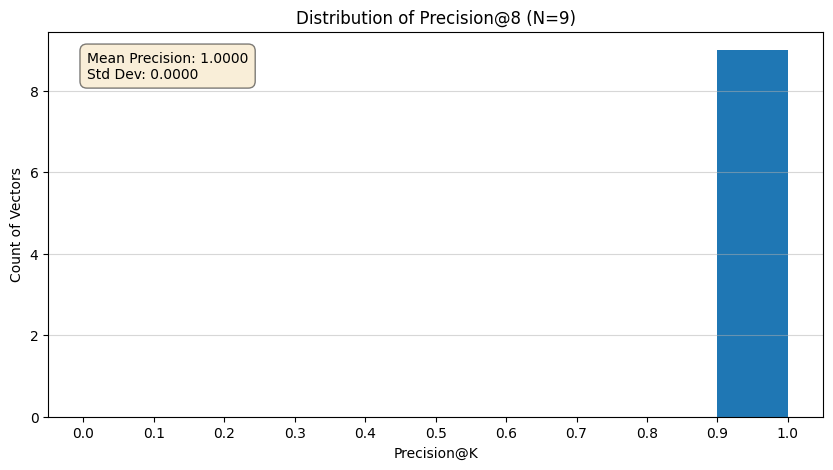


--- Experiment End ---


In [ ]:
# @title Validation: Precision Test on KNN with Metrics { display-mode: "form" }

# !pip install -q python-Levenshtein numpy pandas scipy pyarrow scikit-learn matplotlib # Ensure necessary libs

import numpy as np
import pandas as pd
import time
import os
import shutil
import pyarrow.parquet as pq # Added for Parquet loading
import scipy.sparse as sp
from scipy.spatial import distance as sp_distance
from scipy.stats import spearmanr, pearsonr, skew, kurtosis, median_abs_deviation, iqr # Added stats imports
# from Levenshtein import distance as levenshtein # No longer used
from scipy.optimize import minimize # Not used in this script, but keep if needed later
from sklearn.model_selection import train_test_split # Not used here
from sklearn.neighbors import NearestNeighbors # For KNN search
from sklearn.preprocessing import StandardScaler # For standardizing metrics
import matplotlib.pyplot as plt # Added for optional plotting
import re # Import regex
# Removed unused imports like Levenshtein, minimize, train_test_split for clarity

# --- User's Data Loading Functions (Modified slightly) ---

def get_safe_copy_path(full_path, eval_sample):
    """Creates a unique path for a copy based on eval_sample."""
    file_base, file_ext = os.path.splitext(full_path)
    suffix = f"-E{eval_sample}"
    if not re.search(r"-E\d+$", file_base): copy_path = f"{file_base}{suffix}{file_ext}"
    else: copy_path = full_path; # print(f"Warning: Path '{full_path}' might already have an eval suffix. Reusing.")
    os.makedirs(os.path.dirname(copy_path), exist_ok=True)
    return copy_path

def reconstruct_from_normalized(sparse_array, min_val, max_val):
    """Denormalizes sparse array data."""
    scale_factor = (max_val - min_val) / 4294967295.0
    shift_factor = min_val
    denormalized_data = sparse_array.copy().astype(np.float64)
    # Ensure data attribute is not empty before attempting modification
    if denormalized_data.data.size > 0:
        denormalized_data.data = denormalized_data.data * scale_factor + shift_factor
    return denormalized_data

def getNormalizedValues(full_path):
    """Loads data from Parquet, denormalizes, returns COO matrix, min, max."""
    copy_path = full_path # Read directly
    # print(f"Reading data from: {copy_path}") # Verbose
    try: sentenceDf = pq.read_table(copy_path).to_pandas(safe=False)
    except Exception as e: print(f"Error reading Parquet file {copy_path}: {e}"); raise

    min_val, max_val = sentenceDf['Min'].iloc[0], sentenceDf['Max'].iloc[0]
    cols_to_drop = [col for col in sentenceDf.columns if col.lower() in ['source', 'sentence', 'min', 'max']]
    sentenceDf = sentenceDf.drop(columns=cols_to_drop)
    for col in sentenceDf.columns: sentenceDf[col] = pd.to_numeric(sentenceDf[col], errors='coerce')
    sentenceDf = sentenceDf.fillna(0)
    # Ensure the data being converted is numeric before creating sparse matrix
    numeric_df = sentenceDf.select_dtypes(include=np.number)
    neurons_normalized = sp.coo_matrix(numeric_df.to_numpy(dtype=np.uint32))
    neurons_denormalized = reconstruct_from_normalized(neurons_normalized, min_val, max_val)
    return neurons_denormalized.tocoo(), min_val, max_val

def load_multiple_vectors(file_pattern, num_files):
    """Loads multiple vectors specified by pattern."""
    vectors = []
    min_vals = []
    max_vals = []
    loaded_paths = []
    expected_dim = None

    print(f"Attempting to load {num_files} files matching pattern: {file_pattern}...")
    for i in range(num_files):
        # Construct file path using the pattern and index i
        current_path = file_pattern.format(i) # Assumes pattern uses {0} for index
        if not os.path.exists(current_path):
            print(f"Warning: File not found {current_path}. Skipping.")
            continue

        try:
            sparse_data_coo, min_v, max_v = getNormalizedValues(current_path)
            # Ensure toarray() handles potentially large sparse matrices if memory is a concern
            # Consider using sparse matrix operations directly if possible for very large data
            data_array = sparse_data_coo.toarray().flatten().astype(np.float32)

            if expected_dim is None:
                expected_dim = len(data_array)
                print(f"  Detected dimension: {expected_dim}")
            elif len(data_array) != expected_dim:
                print(f"Error: File {current_path} has dimension {len(data_array)}, expected {expected_dim}. Skipping.")
                continue

            vectors.append(data_array)
            min_vals.append(min_v)
            max_vals.append(max_v)
            loaded_paths.append(current_path)
            # print(f"  Loaded {current_path} (Range: [{min_v:.4f}, {max_v:.4f}])") # Verbose

        except Exception as e:
            print(f"Error processing file {current_path}: {e}. Skipping.")

    if not vectors:
        raise ValueError("No vectors were successfully loaded.")

    print(f"Successfully loaded {len(vectors)} vectors.")
    # Stack vectors into a single numpy array (rows are vectors)
    original_data_matrix = np.vstack(vectors)
    # Return overall min/max across loaded data for reference
    overall_min = np.min(min_vals) if min_vals else np.nan
    overall_max = np.max(max_vals) if max_vals else np.nan

    return original_data_matrix, overall_min, overall_max, loaded_paths

# --- Configuration for Similarity Experiment ---

# 1. Data Loading Setup
N_FILES_TO_LOAD = 20 # How many files (sentences 0 to N-1) to load? Increased for better stats
# Define pattern for file paths, using {0} for the sentence index
# IMPORTANT: Update this path to point to your actual data location
FILE_PATTERN = "./LookUpGPT2/Evaluation/Generated/Layer16/Source=0/Sentence{0}-0.parquet"
K_NEIGHBORS = 10 # How many nearest neighbors to compare?

# 2. Metric Calculation Setup
# Reference values - use overall min/max from loaded data
# Keep structural references constant for now
REFERENCE_VALUES_TEMPLATE = [0.1, 'mean', 0.9, 'linspace', 'sine'] # Use relative points + mean

# --- Metric Definitions ---
# Added new metrics: MAD, IQR, ZCR, Power Bands, L2_vs_GlobalMean, Cosine_vs_GlobalMean
# Note: Power bands and *_vs_GlobalMean are calculated separately in the main loop

def calculate_zcr(d):
    """Calculates Zero-Crossing Rate around the mean."""
    if len(d) < 2: return 0.0
    mean_d = np.mean(d)
    sign_d = np.sign(d - mean_d)
    # Replace zeros with previous sign to avoid double counting at zero itself
    for i in range(1, len(sign_d)):
        if sign_d[i] == 0:
            sign_d[i] = sign_d[i-1]
    # Handle case where the first element is zero
    if sign_d[0] == 0:
        # Find the first non-zero sign
        first_nonzero_idx = np.argmax(sign_d != 0)
        if first_nonzero_idx > 0 or sign_d[0] == 0: # Check if any non-zero exists
             sign_d[0] = sign_d[first_nonzero_idx] if sign_d[first_nonzero_idx] != 0 else 1 # Assign first non-zero or arbitrary if all zero

    return np.sum(np.diff(sign_d) != 0) / (len(d) - 1)

METRICS = {
    # Original Metrics
    'L2 norm (Euclidean)': lambda d, c: np.sqrt(np.sum((d - c)**2)),
    'L1 norm (Manhattan)': lambda d, c: np.sum(np.abs(d - c)),
    'Canberra': lambda d, c: np.sum(np.abs(d - c) / (np.abs(d) + np.abs(c) + 1e-10)),
    'L∞ norm (Chebyshev)': lambda d, c: np.max(np.abs(d - c)),
    'Cosine Similarity': lambda d, c: (1 - sp_distance.cosine(d, c) if (np.linalg.norm(d) > 1e-9 and np.linalg.norm(c) > 1e-9) else 0.0),
    'Pearson Correlation': lambda d, c: pearsonr(d, c)[0] if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,
    'Spearman Correlation': lambda d, c: spearmanr(d, c).correlation if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,
    'Chi-square': lambda d, c: np.sum(np.where((d + c) > 0, (d - c)**2 / (d + c + 1e-10), 0)),
    # FFT Complex L2 removed from active calculation as feature storage was unclear
    # 'FFT Complex L2': lambda d, target_fft_complex: np.linalg.norm(np.fft.fft(d)[:len(target_fft_complex)] - target_fft_complex),

    # Intrinsic Metrics (Vector-Internal Statistics)
    'Skewness': lambda d, _: skew(d) if np.std(d) > 1e-9 else 0.0,
    'Kurtosis': lambda d, _: kurtosis(d, fisher=True) if np.std(d) > 1e-9 else 0.0,
    'Median': lambda d, _: np.median(d),
    'Mean': lambda d, _: np.mean(d),
    'Diff L2 Norm': lambda d, _: np.linalg.norm(np.diff(d)) if len(d)>1 else 0.0,

    # --- NEWLY ADDED METRICS ---
    'MAD': lambda d, _: median_abs_deviation(d) if np.std(d) > 1e-9 else 0.0, # Median Absolute Deviation
    'IQR': lambda d, _: iqr(d) if np.std(d) > 1e-9 else 0.0, # Interquartile Range
    'ZCR': lambda d, _: calculate_zcr(d), # Zero-Crossing Rate around mean

    # Placeholders for metrics calculated separately in the main loop
    # (Power bands and comparisons to global mean)
    # These names will be added to the signature dict directly later
}

# Define which metrics are calculated intrinsically (don't need a comparison vector 'c')
# or require special handling (like power bands or global mean comparison)
# This list is used later to decide which metrics to calculate directly on 'v_i'
# vs. which ones are calculated against the reference vectors by the processor.
INTRINSIC_OR_SPECIAL_METRICS = {
    'Skewness', 'Kurtosis', 'Median', 'Mean', 'Diff L2 Norm',
    'MAD', 'IQR', 'ZCR',
    # Power bands and global mean comparisons are handled explicitly in the main loop
    # 'PowerBand_Low', 'PowerBand_Mid', 'PowerBand_High',
    # 'L2_vs_GlobalMean', 'Cosine_vs_GlobalMean'
}

# Define the base names for metrics that the MetricProcessor will handle
# (i.e., those comparing the vector 'd' against various reference vectors 'c')
ACTIVE_METRIC_BASE_NAMES_FOR_PROCESSOR = [
    m for m in METRICS if m not in INTRINSIC_OR_SPECIAL_METRICS
]
print(f"Using {len(ACTIVE_METRIC_BASE_NAMES_FOR_PROCESSOR)} base metric types for reference comparison.")
print(f"Additionally calculating {len(INTRINSIC_OR_SPECIAL_METRICS)} intrinsic/special metrics.")


# --- MetricProcessor for Diverse References ---
# (Class definition remains largely the same)
class MetricProcessorMultiRef:
    def __init__(self, reference_values=['linspace']):
        if not isinstance(reference_values, list): reference_values = [reference_values]
        self._reference_values = reference_values; self.comparison_vectors = {}

    def preprocess(self, template_vector, data_min, data_max, data_mean):
        """ Preprocesses based on template vector AND actual data stats. """
        self.comparison_vectors = {}; vector_len = len(template_vector); dtype = template_vector.dtype
        print(f"Preprocessing MetricProcessor for {len(self._reference_values)} references...")
        # Handle case where data_min and data_max might be NaN if loading failed for all files
        if np.isnan(data_min) or np.isnan(data_max) or np.isnan(data_mean):
             print("Warning: Data min/max/mean is NaN. Using default range [0, 1] for preprocessing.")
             data_min, data_max, data_mean = 0.0, 1.0, 0.5 # Fallback values

        print(f"  Template vector range: [{data_min:.4f}, {data_max:.4f}], Mean: {data_mean:.4f}")
        self._processed_reference_keys = [] # Store the actual keys/values used

        for key_template in self._reference_values:
            key = key_template # Default key is the template itself
            comp_vec = None # Initialize comp_vec

            try:
                if isinstance(key_template, (int, float, np.number)) and 0.0 <= key_template <= 1.0:
                    # Interpret 0.1, 0.9 etc as relative points in the actual data range
                    val = data_min + key_template * (data_max - data_min)
                    comp_vec = np.full(vector_len, val, dtype=dtype); print(f"  Created constant reference vector for relative point {key_template} -> value: {val:.4f}")
                    key = f'Rel{key_template}' # Make key more descriptive
                elif key_template == 'mean':
                    key = data_mean # Use the actual mean passed in
                    comp_vec = np.full(vector_len, key, dtype=dtype); print(f"  Created constant reference vector for data mean: {key:.4f}")
                    key = 'RefMean' # Use descriptive string key
                elif key_template == 'linspace':
                    comp_vec = np.linspace(data_min, data_max, vector_len).astype(dtype); print(f"  Created linspace reference vector scaled to data range.")
                    key = 'RefLinspace' # Use descriptive string key
                elif key_template == 'sine':
                    amplitude = (data_max - data_min) / 2.0 if data_max > data_min else 0.0
                    midpoint = data_min + amplitude
                    comp_vec = (np.sin(np.linspace(0, 2 * np.pi, vector_len)) * amplitude + midpoint).astype(dtype); print(f"  Created sine reference vector scaled to data range.")
                    key = 'RefSine' # Use descriptive string key
                else: # Assume it's already an absolute value if not caught above
                    if isinstance(key_template, (int, float, np.number)):
                        comp_vec = np.full(vector_len, key_template, dtype=dtype); print(f"  Created constant reference vector for value: {key_template:.4f}")
                        key = f'Abs{key_template}' # Make key more descriptive
                    else:
                        print(f"Warning: Unknown reference value type: {key_template}. Skipping.")
                        continue # Skip this reference type

                if comp_vec is not None:
                   self.comparison_vectors[key] = comp_vec
                   self._processed_reference_keys.append(key) # Store the key used for this vector

            except Exception as e:
                 print(f"Error preprocessing reference '{key_template}': {e}. Skipping.")

        print("Preprocessing complete.")


    def calculate(self, data, active_metric_base_names):
        # Calculates metrics ONLY against the preprocessed reference vectors
        if not self.comparison_vectors: raise ValueError("Processor must be preprocessed.")
        combined_results = {}; data_std_dev_ok = np.std(data) > 1e-9

        for ref_key, comp_vec in self.comparison_vectors.items():
            str_ref_key = str(ref_key); # Use string representation of the key
            if data.shape != comp_vec.shape:
                print(f"Warning: Shape mismatch for key '{str_ref_key}' ({data.shape} vs {comp_vec.shape}). Skipping comparison.")
                continue # Skip this comparison

            comp_vec_std_dev_ok = np.std(comp_vec) > 1e-9
            for base_name in active_metric_base_names:
                if base_name not in METRICS: continue # Should not happen if list is derived correctly
                metric_func = METRICS[base_name]; result_key = f"{base_name}_{str_ref_key}"; result_val = np.nan
                try:
                    if base_name in {'Pearson Correlation', 'Spearman Correlation'}:
                        if data_std_dev_ok and comp_vec_std_dev_ok: result_val = metric_func(data, comp_vec)
                        else: result_val = 0.0 # Assign 0 if std dev is too low for correlation
                    elif base_name == 'Cosine Similarity':
                         # Check norms inside the lambda now, but could double-check here
                         result_val = metric_func(data, comp_vec)
                    else: result_val = metric_func(data, comp_vec)
                except Exception as e: print(f"Error calculating {result_key}: {e}")
                combined_results[result_key] = result_val
        return combined_results


# --- Main Experiment Logic ---

start_overall_time = time.time()
global_mean_vector = None # Initialize global mean vector

# 1. Load Data
try:
    original_data_matrix, overall_min, overall_max, loaded_paths = load_multiple_vectors(FILE_PATTERN, N_FILES_TO_LOAD)
    N_loaded = original_data_matrix.shape[0]
    D_loaded = original_data_matrix.shape[1]
    fft_len = D_loaded // 2 + 1 # Calculate FFT length based on loaded dimension

    print(f"\nData loaded: {N_loaded} vectors of dimension {D_loaded}.")
    # Check if loading actually succeeded
    if N_loaded == 0:
         raise ValueError("No data loaded, cannot proceed.")
    if np.isnan(overall_min) or np.isnan(overall_max):
         print("Warning: Could not determine overall data range properly.")
         # Attempt to calculate from the loaded matrix if possible
         if N_loaded > 0:
              overall_min = np.min(original_data_matrix)
              overall_max = np.max(original_data_matrix)
              print(f"Calculated range from matrix: [{overall_min:.6f}, {overall_max:.6f}]")
         else: # Still no range possible
              overall_min, overall_max = 0.0, 1.0 # Fallback
              print(f"Using fallback range: [{overall_min:.6f}, {overall_max:.6f}]")
    else:
         print(f"Overall data range: [{overall_min:.6f}, {overall_max:.6f}]")


    if N_loaded < K_NEIGHBORS + 1:
        print(f"Warning: Loaded fewer vectors ({N_loaded}) than K+1 ({K_NEIGHBORS+1}). Adjusting K.")
        K_NEIGHBORS = max(1, N_loaded - 1) # Ensure K is at least 1
        if K_NEIGHBORS < 1: raise ValueError("Need at least 2 vectors to compare neighbors.")
    if N_loaded <= 1:
        raise ValueError("Need at least 2 vectors to perform neighbor comparison.")

    # Calculate Global Mean Vector (used for specific metrics)
    global_mean_vector = np.mean(original_data_matrix, axis=0)
    print(f"Calculated global mean vector (shape: {global_mean_vector.shape})")


except Exception as e:
    print(f"Could not load data or perform initial setup for experiment: {e}")
    # Optionally: exit() here if data loading is critical and failed
    # For now, we'll let it proceed, but MetricProcessor might use fallback range
    # and subsequent steps might fail if N_loaded is 0. Added checks above.
    N_loaded = 0 # Ensure N_loaded reflects the failure

# Proceed only if data was loaded successfully
if N_loaded > 0 and global_mean_vector is not None:

    # 2. Initialize Metric Processor
    data_mean = np.mean(original_data_matrix) # Calculate mean across all loaded data elements
    processor = MetricProcessorMultiRef(reference_values=REFERENCE_VALUES_TEMPLATE)
    # Preprocess using the first vector as template, passing data stats
    processor.preprocess(original_data_matrix[0,:], overall_min, overall_max, data_mean)

    # 3. Calculate All Metric Signatures
    print(f"\nCalculating metric signatures for {N_loaded} vectors...")
    metric_signatures_list = []
    calculation_start_time = time.time()

    # Define frequency bands (example: 3 equal bands up to Nyquist)
    # Note: fft_len includes DC and Nyquist (if N even)
    # We exclude DC (index 0) from bands typically.
    band_edges = np.linspace(1, fft_len, 4, dtype=int) # Creates 3 bins after DC
    # Example: if fft_len = 101 -> edges=[1, 34, 67, 101] -> bins [1:34], [34:67], [67:101]

    for i in range(N_loaded):
        v_i = original_data_matrix[i, :]
        signature = {}

        # Calculate metrics vs references using the processor
        metrics_vs_ref = processor.calculate(v_i, ACTIVE_METRIC_BASE_NAMES_FOR_PROCESSOR)
        signature.update(metrics_vs_ref)

        # Calculate intrinsic / data-only metrics
        # Precompute FFT only once per vector if needed for power bands
        fft_complex_i = np.fft.fft(v_i)
        power_spectrum_i = np.abs(fft_complex_i[:fft_len])**2

        for base_name in INTRINSIC_OR_SPECIAL_METRICS:
             if base_name in METRICS: # Check if it's defined in METRICS (intrinsic stats)
                 metric_func = METRICS[base_name]
                 try:
                     signature[base_name] = metric_func(v_i, None) # Pass None as the comparison vector
                 except Exception as e:
                     print(f"Error calculating intrinsic metric {base_name} for vector {i}: {e}")
                     signature[base_name] = np.nan # Store NaN on error

        # Calculate Power Band Metrics explicitly
        try:
             # Ensure band edges are valid for the current fft_len
             valid_band_edges = band_edges[band_edges < fft_len] # Use edges within bounds
             if len(valid_band_edges) > 1:
                  # Adjust calculation slightly if last edge exceeds fft_len
                   if band_edges[-1] > fft_len: band_edges[-1] = fft_len

                   # Sum power within each band (excluding DC)
                   signature['PowerBand_Low'] = np.sum(power_spectrum_i[valid_band_edges[0]:valid_band_edges[1]])
                   if len(valid_band_edges) > 2:
                        signature['PowerBand_Mid'] = np.sum(power_spectrum_i[valid_band_edges[1]:valid_band_edges[2]])
                   else: signature['PowerBand_Mid'] = 0 # Assign 0 if no mid band exists
                   if len(valid_band_edges) > 3:
                        signature['PowerBand_High'] = np.sum(power_spectrum_i[valid_band_edges[2]:valid_band_edges[3]])
                   else: signature['PowerBand_High'] = 0 # Assign 0 if no high band exists

                   # Normalize power bands by total power (optional, makes them relative)
                   total_power = np.sum(power_spectrum_i[1:]) # Total power excluding DC
                   if total_power > 1e-10:
                       if 'PowerBand_Low' in signature: signature['PowerBand_Low'] /= total_power
                       if 'PowerBand_Mid' in signature: signature['PowerBand_Mid'] /= total_power
                       if 'PowerBand_High' in signature: signature['PowerBand_High'] /= total_power
             else: # Handle cases with very short vectors / fft_len
                 signature['PowerBand_Low'] = np.sum(power_spectrum_i[1:]) # Put all non-DC power in Low band
                 signature['PowerBand_Mid'] = 0.0
                 signature['PowerBand_High'] = 0.0

        except Exception as e:
             print(f"Error calculating power bands for vector {i}: {e}")
             signature['PowerBand_Low'] = np.nan
             signature['PowerBand_Mid'] = np.nan
             signature['PowerBand_High'] = np.nan


        # Calculate Metrics vs Global Mean Vector explicitly
        try:
             signature['L2_vs_GlobalMean'] = METRICS['L2 norm (Euclidean)'](v_i, global_mean_vector)
        except Exception as e:
             print(f"Error calculating L2_vs_GlobalMean for vector {i}: {e}")
             signature['L2_vs_GlobalMean'] = np.nan

        try:
             signature['Cosine_vs_GlobalMean'] = METRICS['Cosine Similarity'](v_i, global_mean_vector)
        except Exception as e:
             print(f"Error calculating Cosine_vs_GlobalMean for vector {i}: {e}")
             signature['Cosine_vs_GlobalMean'] = np.nan


        metric_signatures_list.append(signature)
        if (i + 1) % 10 == 0 or (i + 1) == N_loaded:
             print(f"  Processed {i+1}/{N_loaded}...")

    calculation_end_time = time.time()
    print(f"Metric signature calculation finished in {calculation_end_time - calculation_start_time:.2f} sec.")

    # Convert list of dicts to DataFrame, then NumPy array
    # This ensures consistent column order and handles potential missing values
    metric_signatures_df = pd.DataFrame(metric_signatures_list)
    print(f"\nMetric signature DataFrame shape: {metric_signatures_df.shape}")
    # print("Metric columns:", metric_signatures_df.columns.tolist()) # Optional: view all metric names

    # Handle potential NaN/Inf values produced during metric calculation
    nan_count = metric_signatures_df.isnull().sum().sum()
    inf_count = np.isinf(metric_signatures_df.select_dtypes(include=np.number)).sum().sum()

    if nan_count > 0 or inf_count > 0:
        print(f"Warning: {nan_count} NaN and {inf_count} Inf values detected in metric signatures. Replacing with 0.")
        # Consider more sophisticated imputation (e.g., column mean/median) if appropriate
        # Replacing with 0 is simple but might skew results if many NaNs/Infs exist
        metric_signatures_df = metric_signatures_df.fillna(0).replace([np.inf, -np.inf], 0) # Replace NaN first, then Inf


    metric_data_matrix = metric_signatures_df.to_numpy()
    metric_names = metric_signatures_df.columns.tolist() # Get final list of metric features used

    # Check if metric_data_matrix is empty before proceeding
    if metric_data_matrix.size == 0:
        print("Error: Metric data matrix is empty after processing. Cannot proceed.")
    else:
        # 4. Standardize Metric Signatures
        print("\nStandardizing metric signatures...")
        scaler = StandardScaler()
        # Check for columns with zero variance before scaling
        constant_cols = np.where(np.std(metric_data_matrix, axis=0) < 1e-9)[0]
        if len(constant_cols) > 0:
             print(f"Warning: Columns {constant_cols} have near-zero variance. They will be 0 after scaling.")
             # Optionally remove these columns:
             # print("Removing constant columns before scaling.")
             # metric_data_matrix = np.delete(metric_data_matrix, constant_cols, axis=1)
             # metric_names = [name for i, name in enumerate(metric_names) if i not in constant_cols]
             # metric_signatures_df = metric_signatures_df.drop(columns=metric_signatures_df.columns[constant_cols])


        standardized_metric_data = scaler.fit_transform(metric_data_matrix)
        print(f"Standardized metric data shape: {standardized_metric_data.shape}")

        # 5. Find Neighbors in Original Space (Using Euclidean Distance)
        print(f"\nFinding {K_NEIGHBORS} nearest neighbors in Original Space (Euclidean)...")
        nn_orig = NearestNeighbors(n_neighbors=K_NEIGHBORS + 1, metric='euclidean', n_jobs=-1) # +1 to include self
        nn_orig.fit(original_data_matrix)
        distances_orig, indices_orig = nn_orig.kneighbors(original_data_matrix)

        # 6. Find Neighbors in Metric Space (Using Euclidean Distance on Standardized Metrics)
        print(f"Finding {K_NEIGHBORS} nearest neighbors in Metric Space (Euclidean on Standardized)...")
        nn_metric = NearestNeighbors(n_neighbors=K_NEIGHBORS + 1, metric='euclidean', n_jobs=-1) # +1 to include self
        nn_metric.fit(standardized_metric_data)
        distances_metric, indices_metric = nn_metric.kneighbors(standardized_metric_data)

        # 7. Evaluate Overlap
        print(f"\nEvaluating overlap for K = {K_NEIGHBORS}...")
        total_overlap = 0
        individual_precisions = []

        for i in range(N_loaded):
            # Neighbors excluding self (index 0 is self)
            # Ensure indices are valid before creating sets
            orig_neighbors = set(indices_orig[i, 1:]) if indices_orig.shape[1] > 1 else set()
            metric_neighbors = set(indices_metric[i, 1:]) if indices_metric.shape[1] > 1 else set()


            overlap = len(orig_neighbors.intersection(metric_neighbors))
            total_overlap += overlap
            # Handle K_NEIGHBORS being potentially 0 if only 1 vector loaded (though earlier checks should prevent this)
            precision_i = overlap / K_NEIGHBORS if K_NEIGHBORS > 0 else 0.0
            individual_precisions.append(precision_i)

        average_precision = np.mean(individual_precisions) if individual_precisions else 0.0
        std_dev_precision = np.std(individual_precisions) if individual_precisions else 0.0

        end_overall_time = time.time()

        # 8. Report Results
        print("\n--- Experiment Results ---")
        print(f"Number of vectors compared (N): {N_loaded}")
        print(f"Original vector dimension (D): {D_loaded}")
        print(f"Number of neighbors considered (K): {K_NEIGHBORS}")
        print(f"Number of metric features used: {standardized_metric_data.shape[1]}")
        # print(f"Metric feature names: {metric_names}") # Uncomment to see all feature names
        print(f"Average Precision@{K_NEIGHBORS}: {average_precision:.4f}")
        print(f"Standard Deviation of Precision@{K_NEIGHBORS}: {std_dev_precision:.4f}")
        print(f"Total execution time: {end_overall_time - start_overall_time:.2f} sec.")

        # Optional: Print precision per item
        # print("\nPrecision per item:")
        # for i, p in enumerate(individual_precisions):
        #    print(f"  Vector {i} ({os.path.basename(loaded_paths[i])}): {p:.4f}")

        # Optional: Plot histogram of precisions
        plt.figure(figsize=(10, 5))
        # Use np.histogram to get counts and bins for better control
        counts, bin_edges = np.histogram(individual_precisions, bins=10, range=(0,1))
        plt.hist(individual_precisions, bins=bin_edges) # Plot using the calculated bins
        plt.title(f'Distribution of Precision@{K_NEIGHBORS} (N={N_loaded})')
        plt.xlabel('Precision@K')
        plt.ylabel('Count of Vectors')
        plt.xticks(np.linspace(0, 1, 11)) # Ensure ticks are clear 0.0, 0.1, ... 1.0
        plt.grid(axis='y', alpha=0.5)
        # Add text for mean precision
        plt.text(0.05, 0.95, f'Mean Precision: {average_precision:.4f}\nStd Dev: {std_dev_precision:.4f}',
                 transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
                 bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))
        plt.show()

# End message regardless of success
print("\n--- Experiment End ---")


--- Feature Analysis ---
Analyzing 53 metric features for N=9 vectors...

--- 1. Correlation Analysis ---

Pairs with Absolute Correlation > 0.95:
  - Canberra_Rel0.1 and L2 norm (Euclidean)_Rel0.1: 0.9886
  - L2 norm (Euclidean)_RefMean and L2 norm (Euclidean)_Rel0.1: 0.9945
  - L1 norm (Manhattan)_RefMean and L2 norm (Euclidean)_Rel0.1: 0.9945
  - Chi-square_RefMean and L2 norm (Euclidean)_Rel0.1: 0.9984
  - L2 norm (Euclidean)_Rel0.9 and L2 norm (Euclidean)_Rel0.1: 0.9716
  - Canberra_Rel0.9 and L2 norm (Euclidean)_Rel0.1: 0.9957
  - L2 norm (Euclidean)_RefLinspace and L2 norm (Euclidean)_Rel0.1: 0.9945
  - L1 norm (Manhattan)_RefLinspace and L2 norm (Euclidean)_Rel0.1: 0.9704
  - L2 norm (Euclidean)_RefSine and L2 norm (Euclidean)_Rel0.1: 0.9630
  - L1 norm (Manhattan)_RefSine and L2 norm (Euclidean)_Rel0.1: 0.9554
  - IQR and L2 norm (Euclidean)_Rel0.1: 0.9557
  - Diff L2 Norm and L2 norm (Euclidean)_Rel0.1: 0.9942
  - Cosine Similarity_Rel0.1 and L1 norm (Manhattan)_Rel0.1: 0.99

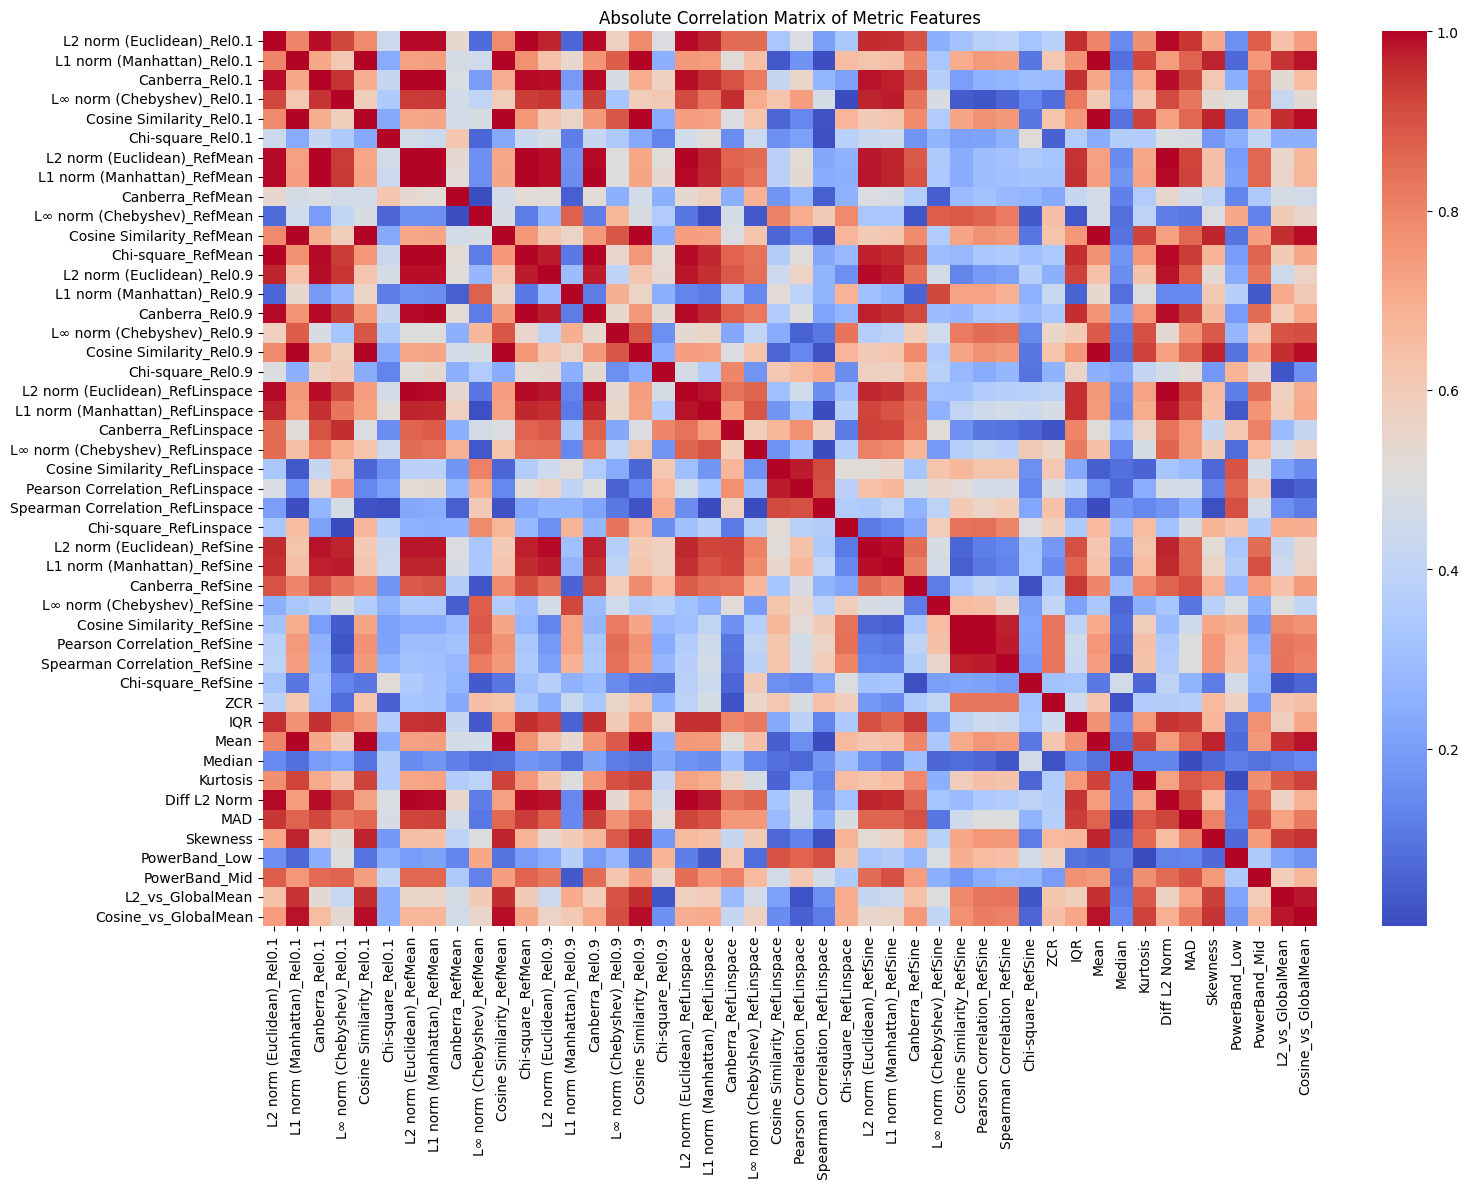


--- 2. Ablation Analysis (Leave-One-Out Feature Impact) ---
Baseline Precision@8 (all 53 features): 1.0000
Ablation analysis finished in 0.12 sec.

Top 10 Features by Impact (Largest Precision Drop when Removed):
  1. L2 norm (Euclidean)_Rel0.1: Precision -> 1.0000 (Drop: 0.0000)
  2. L1 norm (Manhattan)_Rel0.1: Precision -> 1.0000 (Drop: 0.0000)
  3. Canberra_Rel0.1: Precision -> 1.0000 (Drop: 0.0000)
  4. L∞ norm (Chebyshev)_Rel0.1: Precision -> 1.0000 (Drop: 0.0000)
  5. Cosine Similarity_Rel0.1: Precision -> 1.0000 (Drop: 0.0000)
  6. Pearson Correlation_Rel0.1: Precision -> 1.0000 (Drop: 0.0000)
  7. Spearman Correlation_Rel0.1: Precision -> 1.0000 (Drop: 0.0000)
  8. Chi-square_Rel0.1: Precision -> 1.0000 (Drop: 0.0000)
  9. L2 norm (Euclidean)_RefMean: Precision -> 1.0000 (Drop: 0.0000)
  10. L1 norm (Manhattan)_RefMean: Precision -> 1.0000 (Drop: 0.0000)

Bottom 10 Features by Impact (Smallest Precision Drop / Potential Increase when Removed):
  53. Cosine_vs_GlobalMean: Preci

In [ ]:
# @title Validation: Identification of Best Metrics { display-mode: "form" }

import numpy as np
import pandas as pd
import time
import os
# Assuming previous script parts (loading, metric calculation) have been run
# Need access to:
# - metric_data_matrix (N x num_features, raw values)
# - metric_names (list of feature names)
# - original_data_matrix (N x D_loaded)
# - N_loaded, K_NEIGHBORS, D_loaded
# - indices_orig (original space neighbors, N x K+1)

# Make sure necessary imports are available
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns # For heatmap

print("\n--- Feature Analysis ---")

# Check if we have enough data and results from the previous run
if 'metric_data_matrix' not in locals() or N_loaded <= 1 or 'indices_orig' not in locals():
    print("Error: Required variables (metric_data_matrix, N_loaded, indices_orig) not found.")
    print("Please ensure the main experiment script has run successfully before this analysis.")
    # exit() # Or handle appropriately
else:
    num_features = metric_data_matrix.shape[1]
    print(f"Analyzing {num_features} metric features for N={N_loaded} vectors...")

    # --- 1. Correlation Analysis ---
    print("\n--- 1. Correlation Analysis ---")
    # Use the non-standardized data for correlation analysis as standardization can distort inherent correlations slightly
    # Alternatively, use standardized_metric_data if you want to see correlations in the space used for kNN
    metric_df_corr = pd.DataFrame(metric_data_matrix, columns=metric_names)

    # Handle potential NaN/Inf values if not already done before creating metric_data_matrix
    nan_count = metric_df_corr.isnull().sum().sum()
    inf_count = np.isinf(metric_df_corr.select_dtypes(include=np.number)).sum().sum()
    if nan_count > 0 or inf_count > 0:
        print(f"Warning: {nan_count} NaN/{inf_count} Inf found in data for correlation. Replacing with 0.")
        metric_df_corr = metric_df_corr.fillna(0).replace([np.inf, -np.inf], 0)

    if metric_df_corr.empty or metric_df_corr.shape[1] == 0:
         print("Skipping correlation analysis: DataFrame is empty.")
    else:
        # Check for constant columns before calculating correlation
        constant_cols_corr = metric_df_corr.columns[metric_df_corr.nunique() <= 1]
        if not constant_cols_corr.empty:
            print(f"Warning: Constant columns found, removing before correlation: {list(constant_cols_corr)}")
            metric_df_corr = metric_df_corr.drop(columns=constant_cols_corr)

        if metric_df_corr.shape[1] > 1: # Need at least 2 columns for correlation
            corr_matrix = metric_df_corr.corr().abs()

            # Mask upper triangle to avoid duplicate pairs
            upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

            # Find pairs with high correlation
            corr_threshold = 0.95
            high_corr_pairs = [
                (column, row) for row in upper_tri.index for column in upper_tri.columns
                if upper_tri.loc[row, column] > corr_threshold
            ]

            print(f"\nPairs with Absolute Correlation > {corr_threshold}:")
            if high_corr_pairs:
                for pair in high_corr_pairs:
                    print(f"  - {pair[0]} and {pair[1]}: {corr_matrix.loc[pair[0], pair[1]]:.4f}")
            else:
                print("  No pairs found above the threshold.")

            # Optional: Plot heatmap for visual inspection (might be large for 53 features)
            if num_features < 60: # Limit heatmap size for readability
                plt.figure(figsize=(16, 12))
                sns.heatmap(corr_matrix, cmap='coolwarm', annot=False) # Set annot=True for values, but likely unreadable
                plt.title('Absolute Correlation Matrix of Metric Features')
                plt.tight_layout()
                plt.show()
            else:
                print("\nSkipping heatmap plot due to large number of features (>60).")
        else:
            print("Skipping correlation matrix calculation: Less than 2 non-constant features.")


    # --- 2. Ablation Analysis (Leave-One-Out Feature Impact) ---
    print("\n--- 2. Ablation Analysis (Leave-One-Out Feature Impact) ---")
    print(f"Warning: This analysis iterates {num_features} times. May take a moment.")
    print(f"Baseline Precision@{K_NEIGHBORS} (all {num_features} features): {average_precision:.4f}") # Use result from previous run

    ablation_results = []
    baseline_precision = average_precision # Store the baseline

    # Define the evaluation function to avoid code duplication
    def calculate_avg_precision(indices_metric_eval, indices_orig_eval, n_loaded_eval, k_neighbors_eval):
        total_overlap = 0
        individual_precisions = []
        for i in range(n_loaded_eval):
            orig_neighbors = set(indices_orig_eval[i, 1:]) if indices_orig_eval.shape[1] > 1 else set()
            metric_neighbors = set(indices_metric_eval[i, 1:]) if indices_metric_eval.shape[1] > 1 else set()
            overlap = len(orig_neighbors.intersection(metric_neighbors))
            precision_i = overlap / k_neighbors_eval if k_neighbors_eval > 0 else 0.0
            individual_precisions.append(precision_i)
        return np.mean(individual_precisions) if individual_precisions else 0.0

    start_ablation_time = time.time()
    for feature_index_to_remove in range(num_features):
        feature_name = metric_names[feature_index_to_remove]
        # print(f"  Testing impact of removing: {feature_name} ({feature_index_to_remove+1}/{num_features})") # Verbose

        # Create data matrix without the current feature
        temp_metric_data = np.delete(metric_data_matrix, feature_index_to_remove, axis=1)

        if temp_metric_data.size == 0:
             print(f"    Skipping {feature_name}: Removing it results in empty data.")
             ablation_results.append({'feature_removed': feature_name, 'precision': np.nan, 'precision_drop': np.nan})
             continue

        # Re-standardize the reduced feature set
        try:
            # Check for constant columns AGAIN after removing one feature
            col_std_dev = np.std(temp_metric_data, axis=0)
            constant_cols_temp = np.where(col_std_dev < 1e-9)[0]
            if len(constant_cols_temp) == temp_metric_data.shape[1]:
                # All remaining columns are constant - cannot run kNN meaningfully
                 print(f"    Skipping {feature_name}: All remaining features are constant after removal.")
                 temp_avg_precision = 0.0 # Or NaN? Assign 0 precision as KNN is meaningless
            elif len(constant_cols_temp) > 0:
                print(f"    Warning: Constant columns detected after removing {feature_name}. Removing {len(constant_cols_temp)} constant cols before scaling.")
                temp_metric_data = np.delete(temp_metric_data, constant_cols_temp, axis=1)
                if temp_metric_data.size == 0:
                   print(f"    Skipping {feature_name}: No non-constant features left after removal.")
                   temp_avg_precision = 0.0
                   continue # Skip to next feature

            temp_scaler = StandardScaler()
            temp_standardized_data = temp_scaler.fit_transform(temp_metric_data)

            # Find neighbors in the reduced metric space
            temp_nn_metric = NearestNeighbors(n_neighbors=K_NEIGHBORS + 1, metric='euclidean', n_jobs=-1)
            temp_nn_metric.fit(temp_standardized_data)
            _, temp_indices_metric = temp_nn_metric.kneighbors(temp_standardized_data)

            # Evaluate overlap with original neighbors
            temp_avg_precision = calculate_avg_precision(temp_indices_metric, indices_orig, N_loaded, K_NEIGHBORS)

        except Exception as e:
            print(f"    Error during ablation for feature {feature_name}: {e}")
            temp_avg_precision = np.nan # Mark as error

        precision_drop = baseline_precision - temp_avg_precision
        ablation_results.append({'feature_removed': feature_name, 'precision': temp_avg_precision, 'precision_drop': precision_drop})

    end_ablation_time = time.time()
    print(f"Ablation analysis finished in {end_ablation_time - start_ablation_time:.2f} sec.")

    # Sort results by precision drop (most impactful first)
    ablation_results_sorted = sorted(ablation_results, key=lambda x: x['precision_drop'], reverse=True)

    print(f"\nTop 10 Features by Impact (Largest Precision Drop when Removed):")
    for i, result in enumerate(ablation_results_sorted[:10]):
        print(f"  {i+1}. {result['feature_removed']}: Precision -> {result['precision']:.4f} (Drop: {result['precision_drop']:.4f})")

    print(f"\nBottom 10 Features by Impact (Smallest Precision Drop / Potential Increase when Removed):")
    # Filter out potential NaNs before showing bottom 10
    valid_results = [r for r in ablation_results_sorted if not np.isnan(r['precision'])]
    for i, result in enumerate(reversed(valid_results[-10:])): # Show last 10 valid results
         print(f"  {len(valid_results)-i}. {result['feature_removed']}: Precision -> {result['precision']:.4f} (Drop: {result['precision_drop']:.4f})")

    # Identify features whose removal leads to >= baseline precision
    potentially_redundant = [r for r in valid_results if r['precision_drop'] <= 0] # Drop is zero or negative (precision increased)
    print("\nFeatures whose removal resulted in >= baseline precision (potential candidates for removal):")
    if potentially_redundant:
        for result in potentially_redundant:
            print(f"  - {result['feature_removed']} (Precision: {result['precision']:.4f})")
    else:
        print("  None found.")

    print("\n--- Feature Analysis End ---")


--- Analyzing Metric Signature Performance ---
Using N=9 data points.

--- 1. Correlation of Pairwise Distances ---
Spearman Correlation between Original and Metric pairwise distances: 0.9243 (p=8.71e-16)
Pearson Correlation between Original and Metric pairwise distances: 0.9568 (p=8.01e-20)
Interpretation: Strong positive correlation - the metric space generally preserves the relative distances well.

--- 2. Visualization of Metric Space ---
Note: Visualization with N=10 points is highly limited but demonstrates the technique.
PCA: Explained variance ratio for 2 components: 0.8121


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


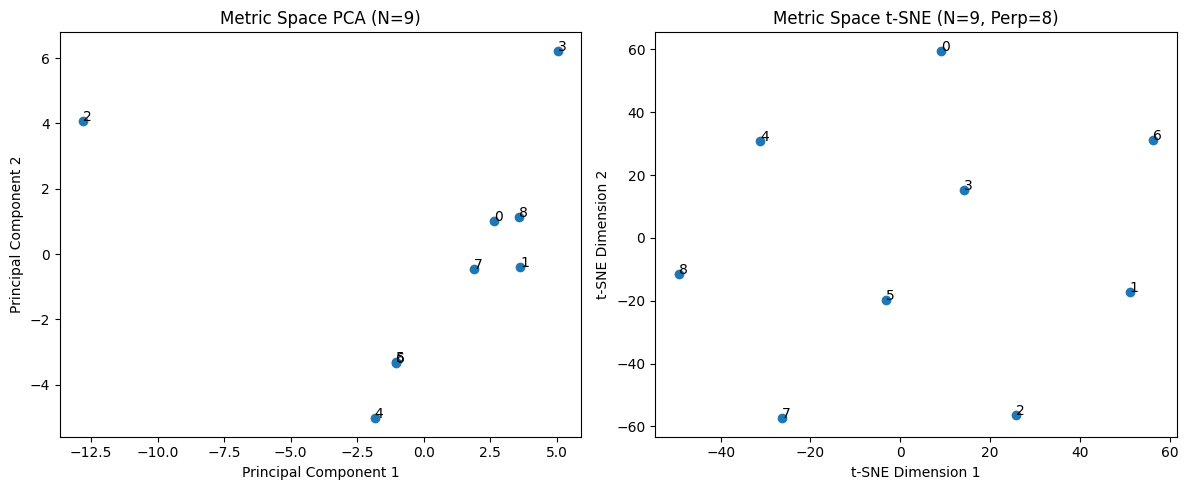


--- 3. Descriptive Statistics of Metric Features ---
Basic statistics for each metric feature across the N samples:
       L2 norm (Euclidean)_Rel0.1  L1 norm (Manhattan)_Rel0.1  Canberra_Rel0.1  L∞ norm (Chebyshev)_Rel0.1  Cosine Similarity_Rel0.1  Pearson Correlation_Rel0.1  Spearman Correlation_Rel0.1  Chi-square_Rel0.1  L2 norm (Euclidean)_RefMean  L1 norm (Manhattan)_RefMean  Canberra_RefMean  L∞ norm (Chebyshev)_RefMean  Cosine Similarity_RefMean  Pearson Correlation_RefMean  Spearman Correlation_RefMean  Chi-square_RefMean  L2 norm (Euclidean)_Rel0.9  L1 norm (Manhattan)_Rel0.9  Canberra_Rel0.9  L∞ norm (Chebyshev)_Rel0.9  Cosine Similarity_Rel0.9  Pearson Correlation_Rel0.9  Spearman Correlation_Rel0.9  Chi-square_Rel0.9  L2 norm (Euclidean)_RefLinspace  L1 norm (Manhattan)_RefLinspace  Canberra_RefLinspace  L∞ norm (Chebyshev)_RefLinspace  Cosine Similarity_RefLinspace  Pearson Correlation_RefLinspace  Spearman Correlation_RefLinspace  Chi-square_RefLinspace  L2 norm (Euclide

In [ ]:
# @title Validation: Visualization of Metrics-Results { display-mode: "form" }

import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr, pearsonr
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Analyzing Metric Signature Performance ---")

# Ensure necessary variables exist from previous steps
if 'original_data_matrix' not in locals() or \
   'standardized_metric_data' not in locals() or \
   'N_loaded' not in locals() or \
   'metric_names' not in locals() or \
   N_loaded <= 1:
    print("Error: Required variables not found or N is too small.")
    print("Please run the main experiment and feature analysis first.")
    # exit()
else:
    print(f"Using N={N_loaded} data points.")

    # --- 1. Correlation of Pairwise Distances ---
    print("\n--- 1. Correlation of Pairwise Distances ---")
    if N_loaded < 3:
        print("Skipping distance correlation: Need at least 3 points to calculate pairwise distances.")
    else:
        try:
            # Calculate pairwise Euclidean distances in original space
            dist_orig = pdist(original_data_matrix, metric='euclidean')

            # Calculate pairwise Euclidean distances in standardized metric space
            dist_metric = pdist(standardized_metric_data, metric='euclidean')

            if dist_orig.size != dist_metric.size:
                 print("Error: Mismatch in number of pairwise distances.")
            elif np.std(dist_orig) < 1e-9 or np.std(dist_metric) < 1e-9:
                 print("Warning: Pairwise distances have near-zero standard deviation in one/both spaces. Correlation might be meaningless.")
                 spearman_corr, spearman_p = (0.0, 1.0) # Assign default value
                 pearson_corr, pearson_p = (0.0, 1.0) # Assign default value
            else:
                # Calculate Spearman rank correlation
                spearman_corr, spearman_p = spearmanr(dist_orig, dist_metric)
                # Calculate Pearson correlation
                pearson_corr, pearson_p = pearsonr(dist_orig, dist_metric)


            print(f"Spearman Correlation between Original and Metric pairwise distances: {spearman_corr:.4f} (p={spearman_p:.3g})")
            print(f"Pearson Correlation between Original and Metric pairwise distances: {pearson_corr:.4f} (p={pearson_p:.3g})")

            # Interpretation help
            if spearman_corr > 0.8:
                print("Interpretation: Strong positive correlation - the metric space generally preserves the relative distances well.")
            elif spearman_corr > 0.5:
                print("Interpretation: Moderate positive correlation - the metric space preserves some relative distance structure.")
            else:
                print("Interpretation: Weak or no correlation - the metric space does not strongly preserve relative distances globally.")

        except Exception as e:
            print(f"Error calculating distance correlation: {e}")


    # --- 2. Visualization of Metric Space (PCA and t-SNE) ---
    print("\n--- 2. Visualization of Metric Space ---")
    print("Note: Visualization with N=10 points is highly limited but demonstrates the technique.")

    n_components_viz = 2 # Reduce to 2D for plotting

    # Using PCA
    try:
        pca = PCA(n_components=n_components_viz)
        metric_pca = pca.fit_transform(standardized_metric_data)
        print(f"PCA: Explained variance ratio for {n_components_viz} components: {pca.explained_variance_ratio_.sum():.4f}")

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.scatter(metric_pca[:, 0], metric_pca[:, 1])
        plt.title(f'Metric Space PCA (N={N_loaded})')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        # Add labels if N is small enough
        if N_loaded <= 20:
             for i, txt in enumerate(range(N_loaded)):
                 plt.annotate(f"{i}", (metric_pca[i, 0], metric_pca[i, 1]))

    except Exception as e:
        print(f"Error during PCA visualization: {e}")
        plt.subplot(1, 2, 1)
        plt.text(0.5, 0.5, 'PCA Error', horizontalalignment='center', verticalalignment='center')
        plt.title('PCA Error')

    # Using t-SNE
    # t-SNE requires perplexity < n_samples
    perplexity_tsne = min(30.0, float(max(1, N_loaded - 1))) # Adjust perplexity based on N
    if N_loaded > 1: # t-SNE needs more than 1 sample
         try:
             tsne = TSNE(n_components=n_components_viz, perplexity=perplexity_tsne, learning_rate='auto', init='pca', n_iter=1000, random_state=42)
             metric_tsne = tsne.fit_transform(standardized_metric_data)

             plt.subplot(1, 2, 2)
             plt.scatter(metric_tsne[:, 0], metric_tsne[:, 1])
             plt.title(f'Metric Space t-SNE (N={N_loaded}, Perp={perplexity_tsne:.0f})')
             plt.xlabel('t-SNE Dimension 1')
             plt.ylabel('t-SNE Dimension 2')
             # Add labels if N is small enough
             if N_loaded <= 20:
                 for i, txt in enumerate(range(N_loaded)):
                     plt.annotate(f"{i}", (metric_tsne[i, 0], metric_tsne[i, 1]))

         except Exception as e:
             print(f"Error during t-SNE visualization: {e}")
             plt.subplot(1, 2, 2)
             plt.text(0.5, 0.5, 't-SNE Error', horizontalalignment='center', verticalalignment='center')
             plt.title('t-SNE Error')
    else:
        print("Skipping t-SNE: Need more than 1 sample.")
        plt.subplot(1, 2, 2)
        plt.text(0.5, 0.5, 't-SNE Skipped (N<=1)', horizontalalignment='center', verticalalignment='center')
        plt.title('t-SNE Skipped')


    plt.tight_layout()
    plt.show()

    # --- 3. Descriptive Statistics (Example using Pandas) ---
    print("\n--- 3. Descriptive Statistics of Metric Features ---")
    try:
        # Create DataFrame if not already done
        metric_df_desc = pd.DataFrame(metric_data_matrix, columns=metric_names)
        # Handle potential NaN/Inf before describing
        metric_df_desc = metric_df_desc.fillna(0).replace([np.inf, -np.inf], 0)
        print("Basic statistics for each metric feature across the N samples:")
        # Use describe() for summary statistics
        print(metric_df_desc.describe().to_string())
    except Exception as e:
        print(f"Error generating descriptive statistics: {e}")


print("\n--- Analysis End ---")

Using 8 base metric types for reference comparison.
Additionally calculating 8 intrinsic/special metrics + Power Bands + Global Mean comparisons.
Attempting to load 10 files matching pattern: ./LookUpGPT2/Evaluation/Generated/Layer16/Source=0/Sentence{0}-0.parquet...
  Detected dimension: 768
Error: File ./LookUpGPT2/Evaluation/Generated/Layer16/Source=0/Sentence8-0.parquet has dimension 767, expected 768. Skipping.
Successfully loaded 9 vectors.

Data loaded: 9 vectors of dimension 768.
Overall data range: [-1.718076, 1.463958]
Calculated global mean vector (shape: (768,))
Preprocessing MetricProcessor for 5 references...
  Template vector range: [-1.7181, 1.4640], Mean: 0.0007
  Created constant reference vector for relative point 0.1 -> value: -1.3999
  Created constant reference vector for data mean: 0.0007
  Created constant reference vector for relative point 0.9 -> value: 1.1458
  Created linspace reference vector scaled to data range.
  Created sine reference vector scaled to d

<ipython-input-39-41bca7156e95>:134: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  'Pearson Correlation': lambda d, c: pearsonr(d, c)[0] if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,
<ipython-input-39-41bca7156e95>:135: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  'Spearman Correlation': lambda d, c: spearmanr(d, c).correlation if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,


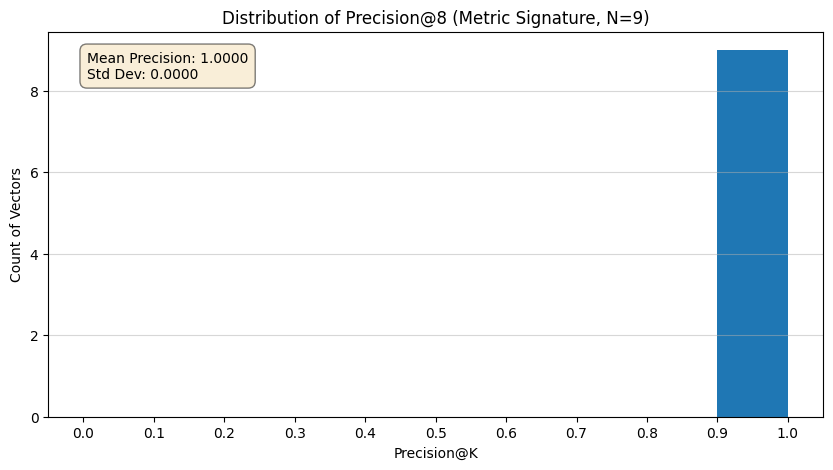


--- Feature Analysis ---
Analyzing 53 metric features for N=9 vectors...

--- 1. Correlation Analysis ---

Pairs with Absolute Correlation > 0.95:
  - L2 norm (Euclidean)_Rel0.1_0.1 & Canberra_Rel0.1_0.1: 0.9886
  - L2 norm (Euclidean)_Rel0.1_0.1 & L2 norm (Euclidean)_RefMean: 0.9945
  - L2 norm (Euclidean)_Rel0.1_0.1 & L1 norm (Manhattan)_RefMean: 0.9945
  - L2 norm (Euclidean)_Rel0.1_0.1 & Chi-square_RefMean: 0.9984
  - L2 norm (Euclidean)_Rel0.1_0.1 & L2 norm (Euclidean)_Rel0.9_0.9: 0.9716
  - L2 norm (Euclidean)_Rel0.1_0.1 & Canberra_Rel0.9_0.9: 0.9957
  - L2 norm (Euclidean)_Rel0.1_0.1 & L2 norm (Euclidean)_RefLinspace: 0.9945
  - L2 norm (Euclidean)_Rel0.1_0.1 & L1 norm (Manhattan)_RefLinspace: 0.9704
  - L2 norm (Euclidean)_Rel0.1_0.1 & L2 norm (Euclidean)_RefSine: 0.9630
  - L2 norm (Euclidean)_Rel0.1_0.1 & L1 norm (Manhattan)_RefSine: 0.9554
  - L2 norm (Euclidean)_Rel0.1_0.1 & IQR: 0.9557
  - L2 norm (Euclidean)_Rel0.1_0.1 & Diff L2 Norm: 0.9942
  - L1 norm (Manhattan)_Rel0.

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


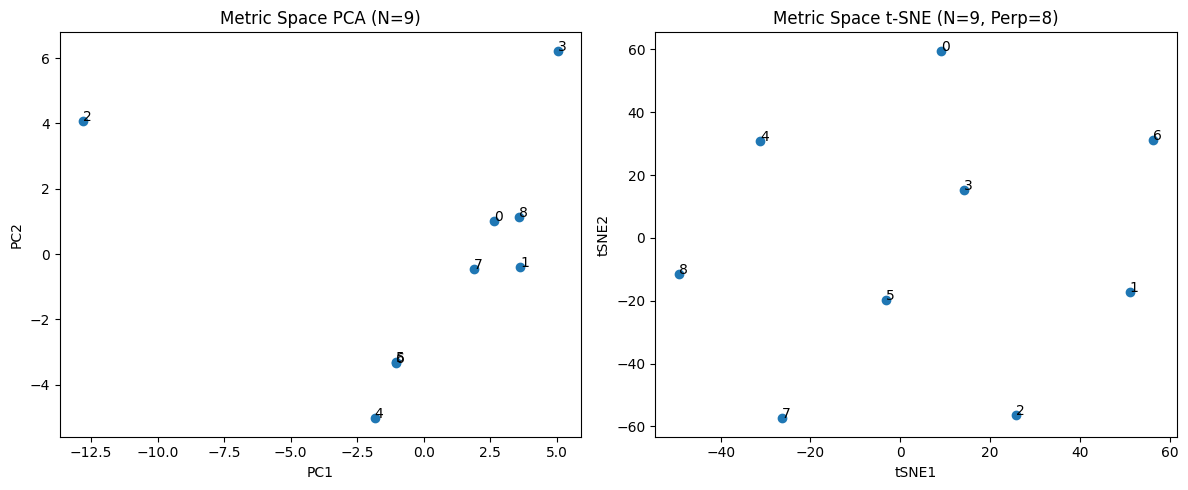


--- 3. Descriptive Statistics of Metric Features ---
       L2 norm (Euclidean)_Rel0.1_0.1  L1 norm (Manhattan)_Rel0.1_0.1  Canberra_Rel0.1_0.1  L∞ norm (Chebyshev)_Rel0.1_0.1  Cosine Similarity_Rel0.1_0.1  Pearson Correlation_Rel0.1_0.1  Spearman Correlation_Rel0.1_0.1  Chi-square_Rel0.1_0.1  L2 norm (Euclidean)_RefMean  L1 norm (Manhattan)_RefMean  Canberra_RefMean  L∞ norm (Chebyshev)_RefMean  Cosine Similarity_RefMean  Pearson Correlation_RefMean  Spearman Correlation_RefMean  Chi-square_RefMean  L2 norm (Euclidean)_Rel0.9_0.9  L1 norm (Manhattan)_Rel0.9_0.9  Canberra_Rel0.9_0.9  L∞ norm (Chebyshev)_Rel0.9_0.9  Cosine Similarity_Rel0.9_0.9  Pearson Correlation_Rel0.9_0.9  Spearman Correlation_Rel0.9_0.9  Chi-square_Rel0.9_0.9  L2 norm (Euclidean)_RefLinspace  L1 norm (Manhattan)_RefLinspace  Canberra_RefLinspace  L∞ norm (Chebyshev)_RefLinspace  Cosine Similarity_RefLinspace  Pearson Correlation_RefLinspace  Spearman Correlation_RefLinspace  Chi-square_RefLinspace  L2 norm (Euclid

In [ ]:
# @title Validation: Test with best Fixed-Vectors and Best Metrics { display-mode: "form" }

# !pip install -q python-Levenshtein numpy pandas scipy pyarrow scikit-learn matplotlib seaborn # Ensure necessary libs

import numpy as np
import pandas as pd
import time
import os
import shutil
import pyarrow.parquet as pq # Added for Parquet loading
import scipy.sparse as sp
from scipy.spatial import distance as sp_distance
from scipy.spatial.distance import pdist, squareform # For distance correlation
from scipy.stats import spearmanr, pearsonr, skew, kurtosis, median_abs_deviation, iqr # Added stats imports
from sklearn.neighbors import NearestNeighbors # For KNN search
from sklearn.preprocessing import StandardScaler # For standardizing metrics
from sklearn.decomposition import PCA # For PCA comparison
from sklearn.manifold import TSNE # For visualization
import matplotlib.pyplot as plt # Added for optional plotting
import seaborn as sns # For heatmap
import re # Import regex

# --- User's Data Loading Functions ---

def get_safe_copy_path(full_path, eval_sample):
    """Creates a unique path for a copy based on eval_sample."""
    file_base, file_ext = os.path.splitext(full_path)
    suffix = f"-E{eval_sample}"
    if not re.search(r"-E\d+$", file_base): copy_path = f"{file_base}{suffix}{file_ext}"
    else: copy_path = full_path; # print(f"Warning: Path '{full_path}' might already have an eval suffix. Reusing.")
    os.makedirs(os.path.dirname(copy_path), exist_ok=True)
    return copy_path

def reconstruct_from_normalized(sparse_array, min_val, max_val):
    """Denormalizes sparse array data."""
    scale_factor = (max_val - min_val) / 4294967295.0
    shift_factor = min_val
    denormalized_data = sparse_array.copy().astype(np.float64)
    # Ensure data attribute is not empty before attempting modification
    if denormalized_data.data.size > 0:
        denormalized_data.data = denormalized_data.data * scale_factor + shift_factor
    return denormalized_data

def getNormalizedValues(full_path):
    """Loads data from Parquet, denormalizes, returns COO matrix, min, max."""
    copy_path = full_path # Read directly
    try: sentenceDf = pq.read_table(copy_path).to_pandas(safe=False)
    except Exception as e: print(f"Error reading Parquet file {copy_path}: {e}"); raise

    min_val, max_val = sentenceDf['Min'].iloc[0], sentenceDf['Max'].iloc[0]
    cols_to_drop = [col for col in sentenceDf.columns if col.lower() in ['source', 'sentence', 'min', 'max']]
    sentenceDf = sentenceDf.drop(columns=cols_to_drop)
    for col in sentenceDf.columns: sentenceDf[col] = pd.to_numeric(sentenceDf[col], errors='coerce')
    sentenceDf = sentenceDf.fillna(0)
    numeric_df = sentenceDf.select_dtypes(include=np.number)
    neurons_normalized = sp.coo_matrix(numeric_df.to_numpy(dtype=np.uint32))
    neurons_denormalized = reconstruct_from_normalized(neurons_normalized, min_val, max_val)
    return neurons_denormalized.tocoo(), min_val, max_val

def load_multiple_vectors(file_pattern, num_files):
    """Loads multiple vectors specified by pattern."""
    vectors = []
    min_vals = []
    max_vals = []
    loaded_paths = []
    expected_dim = None

    print(f"Attempting to load {num_files} files matching pattern: {file_pattern}...")
    for i in range(num_files):
        current_path = file_pattern.format(i)
        if not os.path.exists(current_path):
            print(f"Warning: File not found {current_path}. Skipping.")
            continue

        try:
            sparse_data_coo, min_v, max_v = getNormalizedValues(current_path)
            data_array = sparse_data_coo.toarray().flatten().astype(np.float32)

            if expected_dim is None:
                expected_dim = len(data_array)
                print(f"  Detected dimension: {expected_dim}")
            elif len(data_array) != expected_dim:
                print(f"Error: File {current_path} has dimension {len(data_array)}, expected {expected_dim}. Skipping.")
                continue

            vectors.append(data_array)
            min_vals.append(min_v)
            max_vals.append(max_v)
            loaded_paths.append(current_path)

        except Exception as e:
            print(f"Error processing file {current_path}: {e}. Skipping.")

    if not vectors:
        raise ValueError("No vectors were successfully loaded.")

    print(f"Successfully loaded {len(vectors)} vectors.")
    original_data_matrix = np.vstack(vectors)
    overall_min = np.min(min_vals) if min_vals else np.nan
    overall_max = np.max(max_vals) if max_vals else np.nan

    return original_data_matrix, overall_min, overall_max, loaded_paths

# --- Configuration ---

# IMPORTANT: Update this path to point to your actual data location
FILE_PATTERN = "./LookUpGPT2/Evaluation/Generated/Layer16/Source=0/Sentence{0}-0.parquet"
N_FILES_TO_LOAD = 10 # Keep N=10 for reproducing results, increase for robust analysis
K_NEIGHBORS = 9    # Keep K=9 for reproducing results (adjust if N changes significantly)

REFERENCE_VALUES_TEMPLATE = [0.1, 'mean', 0.9, 'linspace', 'sine']

# --- Metric Definitions ---

def calculate_zcr(d):
    """Calculates Zero-Crossing Rate around the mean."""
    if len(d) < 2: return 0.0
    mean_d = np.mean(d)
    sign_d = np.sign(d - mean_d)
    for i in range(1, len(sign_d)):
        if sign_d[i] == 0: sign_d[i] = sign_d[i-1]
    if sign_d[0] == 0:
        first_nonzero_idx = np.argmax(sign_d != 0)
        if first_nonzero_idx > 0 or sign_d[0] == 0:
             sign_d[0] = sign_d[first_nonzero_idx] if sign_d[first_nonzero_idx] != 0 else 1
    return np.sum(np.diff(sign_d) != 0) / (len(d) - 1)

METRICS = {
    'L2 norm (Euclidean)': lambda d, c: np.sqrt(np.sum((d - c)**2)),
    'L1 norm (Manhattan)': lambda d, c: np.sum(np.abs(d - c)),
    'Canberra': lambda d, c: np.sum(np.abs(d - c) / (np.abs(d) + np.abs(c) + 1e-10)),
    'L∞ norm (Chebyshev)': lambda d, c: np.max(np.abs(d - c)),
    'Cosine Similarity': lambda d, c: (1 - sp_distance.cosine(d, c) if (np.linalg.norm(d) > 1e-9 and np.linalg.norm(c) > 1e-9) else 0.0),
    'Pearson Correlation': lambda d, c: pearsonr(d, c)[0] if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,
    'Spearman Correlation': lambda d, c: spearmanr(d, c).correlation if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,
    'Chi-square': lambda d, c: np.sum(np.where((d + c) > 0, (d - c)**2 / (d + c + 1e-10), 0)),
    'Skewness': lambda d, _: skew(d) if np.std(d) > 1e-9 else 0.0,
    'Kurtosis': lambda d, _: kurtosis(d, fisher=True) if np.std(d) > 1e-9 else 0.0,
    'Median': lambda d, _: np.median(d),
    'Mean': lambda d, _: np.mean(d),
    'Diff L2 Norm': lambda d, _: np.linalg.norm(np.diff(d)) if len(d)>1 else 0.0,
    'MAD': lambda d, _: median_abs_deviation(d) if np.std(d) > 1e-9 else 0.0,
    'IQR': lambda d, _: iqr(d) if np.std(d) > 1e-9 else 0.0,
    'ZCR': lambda d, _: calculate_zcr(d),
}

INTRINSIC_OR_SPECIAL_METRICS = {
    'Skewness', 'Kurtosis', 'Median', 'Mean', 'Diff L2 Norm',
    'MAD', 'IQR', 'ZCR',
}
ACTIVE_METRIC_BASE_NAMES_FOR_PROCESSOR = [
    m for m in METRICS if m not in INTRINSIC_OR_SPECIAL_METRICS
]
print(f"Using {len(ACTIVE_METRIC_BASE_NAMES_FOR_PROCESSOR)} base metric types for reference comparison.")
print(f"Additionally calculating {len(INTRINSIC_OR_SPECIAL_METRICS)} intrinsic/special metrics + Power Bands + Global Mean comparisons.")

# --- MetricProcessor Class ---
class MetricProcessorMultiRef:
    def __init__(self, reference_values=['linspace']):
        if not isinstance(reference_values, list): reference_values = [reference_values]
        self._reference_values = reference_values; self.comparison_vectors = {}

    def preprocess(self, template_vector, data_min, data_max, data_mean):
        self.comparison_vectors = {}; vector_len = len(template_vector); dtype = template_vector.dtype
        print(f"Preprocessing MetricProcessor for {len(self._reference_values)} references...")
        if np.isnan(data_min) or np.isnan(data_max) or np.isnan(data_mean):
             print("Warning: Data min/max/mean is NaN. Using default range [0, 1] for preprocessing.")
             data_min, data_max, data_mean = 0.0, 1.0, 0.5 # Fallback values
        print(f"  Template vector range: [{data_min:.4f}, {data_max:.4f}], Mean: {data_mean:.4f}")
        self._processed_reference_keys = []

        for key_template in self._reference_values:
            key = key_template
            comp_vec = None
            try:
                if isinstance(key_template, (int, float, np.number)) and 0.0 <= key_template <= 1.0:
                    val = data_min + key_template * (data_max - data_min)
                    comp_vec = np.full(vector_len, val, dtype=dtype); print(f"  Created constant reference vector for relative point {key_template} -> value: {val:.4f}")
                    key = f'Rel{key_template}'
                elif key_template == 'mean':
                    val = data_mean
                    comp_vec = np.full(vector_len, val, dtype=dtype); print(f"  Created constant reference vector for data mean: {val:.4f}")
                    key = 'RefMean'
                elif key_template == 'linspace':
                    comp_vec = np.linspace(data_min, data_max, vector_len).astype(dtype); print(f"  Created linspace reference vector scaled to data range.")
                    key = 'RefLinspace'
                elif key_template == 'sine':
                    amplitude = (data_max - data_min) / 2.0 if data_max > data_min else 0.0
                    midpoint = data_min + amplitude
                    comp_vec = (np.sin(np.linspace(0, 2 * np.pi, vector_len)) * amplitude + midpoint).astype(dtype); print(f"  Created sine reference vector scaled to data range.")
                    key = 'RefSine'
                else:
                    if isinstance(key_template, (int, float, np.number)):
                        comp_vec = np.full(vector_len, key_template, dtype=dtype); print(f"  Created constant reference vector for value: {key_template:.4f}")
                        key = f'Abs{key_template}'
                    else:
                        print(f"Warning: Unknown reference value type: {key_template}. Skipping.")
                        continue
                if comp_vec is not None:
                   # Ensure key is unique if template was numeric
                   if isinstance(key_template, (int, float, np.number)): key = f"{key}_{key_template}"

                   self.comparison_vectors[key] = comp_vec
                   self._processed_reference_keys.append(key)
            except Exception as e:
                 print(f"Error preprocessing reference '{key_template}': {e}. Skipping.")
        print("Preprocessing complete.")

    def calculate(self, data, active_metric_base_names):
        if not self.comparison_vectors: raise ValueError("Processor must be preprocessed.")
        combined_results = {}; data_std_dev_ok = np.std(data) > 1e-9

        for ref_key, comp_vec in self.comparison_vectors.items():
            str_ref_key = str(ref_key);
            if data.shape != comp_vec.shape:
                print(f"Warning: Shape mismatch for key '{str_ref_key}' ({data.shape} vs {comp_vec.shape}). Skipping comparison.")
                continue
            comp_vec_std_dev_ok = np.std(comp_vec) > 1e-9
            for base_name in active_metric_base_names:
                if base_name not in METRICS: continue
                metric_func = METRICS[base_name]; result_key = f"{base_name}_{str_ref_key}"; result_val = np.nan
                try:
                    if base_name in {'Pearson Correlation', 'Spearman Correlation'}:
                        if data_std_dev_ok and comp_vec_std_dev_ok: result_val = metric_func(data, comp_vec)
                        else: result_val = 0.0
                    elif base_name == 'Cosine Similarity':
                         result_val = metric_func(data, comp_vec)
                    else: result_val = metric_func(data, comp_vec)
                except Exception as e: print(f"Error calculating {result_key}: {e}")
                combined_results[result_key] = result_val
        return combined_results


# --- Helper function for evaluation ---
def calculate_avg_precision(indices_metric_eval, indices_orig_eval, n_loaded_eval, k_neighbors_eval):
    """Calculates average precision@K comparing two sets of neighbor indices."""
    total_overlap = 0
    individual_precisions = []
    for i in range(n_loaded_eval):
        # Ensure indices are valid before creating sets, exclude self (index 0)
        orig_neighbors = set(indices_orig_eval[i, 1:]) if indices_orig_eval.shape[1] > 1 else set()
        metric_neighbors = set(indices_metric_eval[i, 1:]) if indices_metric_eval.shape[1] > 1 else set()

        # Check that K used for neighbor finding matches expected K
        if len(orig_neighbors) != k_neighbors_eval:
             print(f"Warning: Vector {i} Original Neighbors count ({len(orig_neighbors)}) != K ({k_neighbors_eval})")
        if len(metric_neighbors) != k_neighbors_eval:
             print(f"Warning: Vector {i} Metric Neighbors count ({len(metric_neighbors)}) != K ({k_neighbors_eval})")


        overlap = len(orig_neighbors.intersection(metric_neighbors))
        total_overlap += overlap
        # Handle K_NEIGHBORS being potentially 0 if only 1 vector loaded (though earlier checks should prevent this)
        precision_i = overlap / k_neighbors_eval if k_neighbors_eval > 0 else 0.0
        individual_precisions.append(precision_i)

    avg_precision = np.mean(individual_precisions) if individual_precisions else 0.0
    std_dev_precision = np.std(individual_precisions) if individual_precisions else 0.0
    return avg_precision, std_dev_precision


# --- Main Experiment Logic ---
start_overall_time = time.time()
global_mean_vector = None
original_data_matrix = None
metric_data_matrix = None
standardized_metric_data = None
indices_orig = None
average_precision = np.nan
std_dev_precision = np.nan
metric_names = []
N_loaded = 0
D_loaded = 0

# 1. Load Data
try:
    original_data_matrix, overall_min, overall_max, loaded_paths = load_multiple_vectors(FILE_PATTERN, N_FILES_TO_LOAD)
    N_loaded = original_data_matrix.shape[0]
    D_loaded = original_data_matrix.shape[1]
    fft_len = D_loaded // 2 + 1

    print(f"\nData loaded: {N_loaded} vectors of dimension {D_loaded}.")
    if N_loaded == 0: raise ValueError("No data loaded, cannot proceed.")
    if np.isnan(overall_min) or np.isnan(overall_max):
         print("Warning: Could not determine overall data range properly.")
         if N_loaded > 0:
              overall_min = np.min(original_data_matrix)
              overall_max = np.max(original_data_matrix)
              print(f"Calculated range from matrix: [{overall_min:.6f}, {overall_max:.6f}]")
         else: overall_min, overall_max = 0.0, 1.0; print(f"Using fallback range: [0.0, 1.0]")
    else: print(f"Overall data range: [{overall_min:.6f}, {overall_max:.6f}]")

    # Adjust K if necessary
    if N_loaded <= 1: raise ValueError("Need at least 2 vectors for comparisons.")
    if K_NEIGHBORS >= N_loaded:
        print(f"Warning: K ({K_NEIGHBORS}) >= N ({N_loaded}). Setting K = N-1 = {N_loaded-1}.")
        K_NEIGHBORS = N_loaded - 1
    if K_NEIGHBORS < 1: raise ValueError("K must be at least 1.")


    global_mean_vector = np.mean(original_data_matrix, axis=0)
    print(f"Calculated global mean vector (shape: {global_mean_vector.shape})")

except Exception as e:
    print(f"Could not load data or perform initial setup: {e}")
    exit() # Exit if data loading fails

# === Main Metric Calculation and Evaluation ===
if N_loaded > 0 and global_mean_vector is not None:

    # 2. Initialize Metric Processor
    data_mean_overall = np.mean(original_data_matrix) # Mean of all elements
    processor = MetricProcessorMultiRef(reference_values=REFERENCE_VALUES_TEMPLATE)
    processor.preprocess(original_data_matrix[0,:], overall_min, overall_max, data_mean_overall)

    # 3. Calculate All Metric Signatures
    print(f"\nCalculating metric signatures for {N_loaded} vectors...")
    metric_signatures_list = []
    calculation_start_time = time.time()
    band_edges = np.linspace(1, fft_len, 4, dtype=int)

    for i in range(N_loaded):
        v_i = original_data_matrix[i, :]
        signature = {}
        metrics_vs_ref = processor.calculate(v_i, ACTIVE_METRIC_BASE_NAMES_FOR_PROCESSOR)
        signature.update(metrics_vs_ref)
        fft_complex_i = np.fft.fft(v_i)
        power_spectrum_i = np.abs(fft_complex_i[:fft_len])**2

        for base_name in INTRINSIC_OR_SPECIAL_METRICS:
             if base_name in METRICS:
                 try: signature[base_name] = METRICS[base_name](v_i, None)
                 except Exception as e: print(f"Err {base_name} V{i}: {e}"); signature[base_name] = np.nan

        try: # Power Bands
             valid_band_edges = band_edges[band_edges < fft_len]
             if len(valid_band_edges) > 1:
                  if band_edges[-1] > fft_len: band_edges[-1] = fft_len
                  signature['PowerBand_Low'] = np.sum(power_spectrum_i[valid_band_edges[0]:valid_band_edges[1]])
                  signature['PowerBand_Mid'] = np.sum(power_spectrum_i[valid_band_edges[1]:valid_band_edges[2]]) if len(valid_band_edges) > 2 else 0
                  signature['PowerBand_High'] = np.sum(power_spectrum_i[valid_band_edges[2]:valid_band_edges[3]]) if len(valid_band_edges) > 3 else 0
                  total_power = np.sum(power_spectrum_i[1:]); total_power = 1e-10 if total_power <= 1e-10 else total_power # Avoid division by zero
                  if 'PowerBand_Low' in signature: signature['PowerBand_Low'] /= total_power
                  if 'PowerBand_Mid' in signature: signature['PowerBand_Mid'] /= total_power
                  if 'PowerBand_High' in signature: signature['PowerBand_High'] /= total_power
             else: signature['PowerBand_Low'] = 1.0; signature['PowerBand_Mid'] = 0.0; signature['PowerBand_High'] = 0.0
        except Exception as e: print(f"Err PwrBands V{i}: {e}"); signature['PowerBand_Low']=np.nan; signature['PowerBand_Mid']=np.nan; signature['PowerBand_High']=np.nan

        try: signature['L2_vs_GlobalMean'] = METRICS['L2 norm (Euclidean)'](v_i, global_mean_vector)
        except Exception as e: print(f"Err L2vsMean V{i}: {e}"); signature['L2_vs_GlobalMean'] = np.nan
        try: signature['Cosine_vs_GlobalMean'] = METRICS['Cosine Similarity'](v_i, global_mean_vector)
        except Exception as e: print(f"Err CosVsMean V{i}: {e}"); signature['Cosine_vs_GlobalMean'] = np.nan

        metric_signatures_list.append(signature)
        if (i + 1) % 10 == 0 or (i + 1) == N_loaded: print(f"  Processed {i+1}/{N_loaded}...")

    calculation_end_time = time.time()
    print(f"Metric signature calculation finished in {calculation_end_time - calculation_start_time:.2f} sec.")

    metric_signatures_df = pd.DataFrame(metric_signatures_list)
    print(f"\nMetric signature DataFrame shape: {metric_signatures_df.shape}")
    nan_count = metric_signatures_df.isnull().sum().sum()
    inf_count = np.isinf(metric_signatures_df.select_dtypes(include=np.number)).sum().sum()
    if nan_count > 0 or inf_count > 0:
        print(f"Warning: {nan_count} NaN/{inf_count} Inf detected. Replacing with 0.")
        metric_signatures_df = metric_signatures_df.fillna(0).replace([np.inf, -np.inf], 0)

    metric_data_matrix = metric_signatures_df.to_numpy()
    metric_names = metric_signatures_df.columns.tolist()
    num_metric_features_actual = metric_data_matrix.shape[1]

    if metric_data_matrix.size == 0: raise ValueError("Metric data matrix is empty!")

    # 4. Standardize Metric Signatures
    print("\nStandardizing metric signatures...")
    metric_scaler = StandardScaler()
    standardized_metric_data = metric_scaler.fit_transform(metric_data_matrix)
    print(f"Standardized metric data shape: {standardized_metric_data.shape}")

    # 5. Find Neighbors in Original Space
    print(f"\nFinding {K_NEIGHBORS} nearest neighbors in Original Space (Euclidean)...")
    nn_orig = NearestNeighbors(n_neighbors=K_NEIGHBORS + 1, metric='euclidean', n_jobs=-1)
    nn_orig.fit(original_data_matrix)
    distances_orig, indices_orig = nn_orig.kneighbors(original_data_matrix)

    # 6. Find Neighbors in Metric Space
    print(f"Finding {K_NEIGHBORS} nearest neighbors in Metric Space (Euclidean on Standardized)...")
    nn_metric = NearestNeighbors(n_neighbors=K_NEIGHBORS + 1, metric='euclidean', n_jobs=-1)
    nn_metric.fit(standardized_metric_data)
    distances_metric, indices_metric = nn_metric.kneighbors(standardized_metric_data)

    # 7. Evaluate Overlap (Metric Signature vs Original)
    print(f"\nEvaluating overlap for K = {K_NEIGHBORS}...")
    average_precision, std_dev_precision = calculate_avg_precision(indices_metric, indices_orig, N_loaded, K_NEIGHBORS)

    end_eval_time = time.time()

    # 8. Report Results (Metric Signature)
    print("\n--- Initial Experiment Results ---")
    print(f"Number of vectors compared (N): {N_loaded}")
    print(f"Original vector dimension (D): {D_loaded}")
    print(f"Number of neighbors considered (K): {K_NEIGHBORS}")
    print(f"Number of metric features calculated: {num_metric_features_actual}")
    print(f"Average Precision@{K_NEIGHBORS} (Metric Signature vs Original): {average_precision:.4f}")
    print(f"Standard Deviation of Precision@{K_NEIGHBORS}: {std_dev_precision:.4f}")
    print(f"Total execution time so far: {end_eval_time - start_overall_time:.2f} sec.")

    # Plot histogram of precisions
    plt.figure(figsize=(10, 5))
    counts, bin_edges = np.histogram(np.array([calculate_avg_precision(indices_metric[i:i+1], indices_orig[i:i+1], 1, K_NEIGHBORS)[0] for i in range(N_loaded)]), bins=10, range=(0,1))
    plt.hist([calculate_avg_precision(indices_metric[i:i+1], indices_orig[i:i+1], 1, K_NEIGHBORS)[0] for i in range(N_loaded)], bins=bin_edges)
    plt.title(f'Distribution of Precision@{K_NEIGHBORS} (Metric Signature, N={N_loaded})')
    plt.xlabel('Precision@K')
    plt.ylabel('Count of Vectors')
    plt.xticks(np.linspace(0, 1, 11))
    plt.grid(axis='y', alpha=0.5)
    plt.text(0.05, 0.95, f'Mean Precision: {average_precision:.4f}\nStd Dev: {std_dev_precision:.4f}',
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))
    plt.show()


    # === Feature Analysis Section ===
    print("\n--- Feature Analysis ---")
    num_features = num_metric_features_actual # Use the actual number calculated
    print(f"Analyzing {num_features} metric features for N={N_loaded} vectors...")

    # 1. Correlation Analysis
    print("\n--- 1. Correlation Analysis ---")
    metric_df_corr = pd.DataFrame(metric_data_matrix, columns=metric_names)
    nan_count = metric_df_corr.isnull().sum().sum(); inf_count = np.isinf(metric_df_corr.select_dtypes(include=np.number)).sum().sum()
    if nan_count > 0 or inf_count > 0: metric_df_corr = metric_df_corr.fillna(0).replace([np.inf, -np.inf], 0)

    if metric_df_corr.empty or metric_df_corr.shape[1] < 2:
         print("Skipping correlation analysis: DataFrame empty or < 2 features.")
    else:
        constant_cols_corr = metric_df_corr.columns[metric_df_corr.nunique() <= 1]
        if not constant_cols_corr.empty:
            print(f"Warning: Constant columns found, removing before correlation: {list(constant_cols_corr)}")
            metric_df_corr = metric_df_corr.drop(columns=constant_cols_corr)

        if metric_df_corr.shape[1] > 1:
            corr_matrix = metric_df_corr.corr().abs()
            upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
            corr_threshold = 0.95
            high_corr_pairs = [(r, c) for r in upper_tri.index for c in upper_tri.columns if upper_tri.loc[r, c] > corr_threshold]

            print(f"\nPairs with Absolute Correlation > {corr_threshold}:")
            if high_corr_pairs:
                for pair in high_corr_pairs[:20]: print(f"  - {pair[0]} & {pair[1]}: {corr_matrix.loc[pair[0], pair[1]]:.4f}") # Limit output
                if len(high_corr_pairs) > 20: print(f"  ... (and {len(high_corr_pairs)-20} more pairs)")
            else: print("  No pairs found above the threshold.")
            # Optional Heatmap (comment out if too large)
            # if num_features < 60:
            #      plt.figure(figsize=(16, 12)); sns.heatmap(corr_matrix, cmap='coolwarm'); plt.title('Abs Correlation Matrix'); plt.tight_layout(); plt.show()
            # else: print("\nSkipping heatmap plot due to large number of features (>60).")
        else: print("Skipping correlation matrix: Less than 2 non-constant features.")

    # 2. Ablation Analysis
    print("\n--- 2. Ablation Analysis (Leave-One-Out Feature Impact) ---")
    if num_features <=1 :
        print("Skipping ablation: Need more than 1 feature.")
    else:
        print(f"Warning: This analysis iterates {num_features} times. May take a moment.")
        print(f"Baseline Precision@{K_NEIGHBORS} (all {num_features} features): {average_precision:.4f}")
        ablation_results = []
        baseline_precision = average_precision
        start_ablation_time = time.time()

        for feature_index_to_remove in range(num_features):
            feature_name = metric_names[feature_index_to_remove]
            temp_metric_data = np.delete(metric_data_matrix, feature_index_to_remove, axis=1)
            temp_avg_precision = np.nan
            precision_drop = np.nan

            if temp_metric_data.size == 0:
                 print(f"    Skipping {feature_name}: Results in empty data.")
                 ablation_results.append({'feature_removed': feature_name, 'precision': temp_avg_precision, 'precision_drop': precision_drop})
                 continue
            try:
                col_std_dev = np.std(temp_metric_data, axis=0)
                constant_cols_temp = np.where(col_std_dev < 1e-9)[0]
                if len(constant_cols_temp) == temp_metric_data.shape[1]:
                    print(f"    Skipping {feature_name}: All remaining are constant.")
                    temp_avg_precision = 0.0 # Assign 0 if kNN meaningless
                else:
                    if len(constant_cols_temp) > 0:
                        # print(f"    Warning: Removing {len(constant_cols_temp)} constant cols after removing {feature_name}.") # Verbose
                        temp_metric_data = np.delete(temp_metric_data, constant_cols_temp, axis=1)
                    if temp_metric_data.size == 0:
                        print(f"    Skipping {feature_name}: No non-constant features left.")
                        temp_avg_precision = 0.0
                    else:
                        temp_scaler = StandardScaler()
                        temp_standardized_data = temp_scaler.fit_transform(temp_metric_data)
                        temp_nn_metric = NearestNeighbors(n_neighbors=K_NEIGHBORS + 1, metric='euclidean', n_jobs=-1)
                        temp_nn_metric.fit(temp_standardized_data)
                        _, temp_indices_metric = temp_nn_metric.kneighbors(temp_standardized_data)
                        temp_avg_precision, _ = calculate_avg_precision(temp_indices_metric, indices_orig, N_loaded, K_NEIGHBORS)

            except Exception as e: print(f"    Error ablating {feature_name}: {e}"); temp_avg_precision = np.nan

            if not np.isnan(temp_avg_precision): precision_drop = baseline_precision - temp_avg_precision
            ablation_results.append({'feature_removed': feature_name, 'precision': temp_avg_precision, 'precision_drop': precision_drop})

        end_ablation_time = time.time()
        print(f"Ablation analysis finished in {end_ablation_time - start_ablation_time:.2f} sec.")

        valid_results = [r for r in ablation_results if not np.isnan(r['precision'])]
        if valid_results:
             ablation_results_sorted = sorted(valid_results, key=lambda x: x['precision_drop'], reverse=True)
             print(f"\nTop 10 Features by Impact (Largest Precision Drop when Removed):")
             for i, r in enumerate(ablation_results_sorted[:10]): print(f"  {i+1}. {r['feature_removed']}: Precision -> {r['precision']:.4f} (Drop: {r['precision_drop']:.4f})")
             print(f"\nBottom 10 Features by Impact (Smallest Precision Drop / Potential Increase):")
             for i, r in enumerate(reversed(ablation_results_sorted[-10:])): print(f"  {len(valid_results)-i}. {r['feature_removed']}: Precision -> {r['precision']:.4f} (Drop: {r['precision_drop']:.4f})")
             potentially_redundant = [r for r in valid_results if r['precision_drop'] <= 1e-9] # Use tolerance for float comparison
             print("\nFeatures whose removal resulted in >= baseline precision (candidates for removal):")
             if potentially_redundant: [print(f"  - {r['feature_removed']} (Precision: {r['precision']:.4f})") for r in potentially_redundant]
             else: print("  None found.")
        else: print("\nNo valid ablation results to display.")
    print("--- Feature Analysis End ---")


    # === Additional Analysis: Distance Correlation & Visualization ===
    print("\n--- Analyzing Metric Signature Performance Further ---")

    # 1. Correlation of Pairwise Distances
    print("\n--- 1. Correlation of Pairwise Distances ---")
    if N_loaded < 3: print("Skipping distance correlation: Need N>=3.")
    else:
        try:
            dist_orig = pdist(original_data_matrix, metric='euclidean')
            dist_metric = pdist(standardized_metric_data, metric='euclidean')
            if dist_orig.size != dist_metric.size or np.std(dist_orig)<1e-9 or np.std(dist_metric)<1e-9:
                 print("Warning: Cannot calculate distance correlation (size mismatch or zero std dev).")
            else:
                spearman_corr, spearman_p = spearmanr(dist_orig, dist_metric)
                pearson_corr, pearson_p = pearsonr(dist_orig, dist_metric)
                print(f"Spearman Correlation (Original vs Metric Distances): {spearman_corr:.4f} (p={spearman_p:.3g})")
                print(f"Pearson Correlation (Original vs Metric Distances): {pearson_corr:.4f} (p={pearson_p:.3g})")
                if spearman_corr > 0.8: print("Interpretation: Strong distance rank preservation.")
                elif spearman_corr > 0.5: print("Interpretation: Moderate distance rank preservation.")
                else: print("Interpretation: Weak distance rank preservation.")
        except Exception as e: print(f"Error calculating distance correlation: {e}")

    # 2. Visualization (PCA/t-SNE)
    print("\n--- 2. Visualization of Metric Space (Limited by N) ---")
    n_components_viz = 2
    if N_loaded > n_components_viz:
         try: # PCA Plot
             pca_viz = PCA(n_components=n_components_viz)
             metric_pca = pca_viz.fit_transform(standardized_metric_data)
             plt.figure(figsize=(12, 5)); plt.subplot(1, 2, 1); plt.scatter(metric_pca[:, 0], metric_pca[:, 1])
             plt.title(f'Metric Space PCA (N={N_loaded})'); plt.xlabel('PC1'); plt.ylabel('PC2')
             if N_loaded <= 20: [plt.annotate(f"{i}", (metric_pca[i,0], metric_pca[i,1])) for i in range(N_loaded)]
         except Exception as e: print(f"Error PCA viz: {e}"); plt.subplot(1,2,1); plt.text(0.5,0.5,'PCA Error'); plt.title('PCA Error')
         try: # t-SNE Plot
             perplexity_tsne = min(30.0, float(max(1, N_loaded - 1)))
             tsne = TSNE(n_components=n_components_viz, perplexity=perplexity_tsne, learning_rate='auto', init='pca', n_iter=1000, random_state=42)
             metric_tsne = tsne.fit_transform(standardized_metric_data)
             plt.subplot(1, 2, 2); plt.scatter(metric_tsne[:, 0], metric_tsne[:, 1])
             plt.title(f'Metric Space t-SNE (N={N_loaded}, Perp={perplexity_tsne:.0f})'); plt.xlabel('tSNE1'); plt.ylabel('tSNE2')
             if N_loaded <= 20: [plt.annotate(f"{i}", (metric_tsne[i,0], metric_tsne[i,1])) for i in range(N_loaded)]
         except Exception as e: print(f"Error t-SNE viz: {e}"); plt.subplot(1,2,2); plt.text(0.5,0.5,'t-SNE Error'); plt.title('t-SNE Error')
         plt.tight_layout(); plt.show()
    else: print("Skipping visualization: Need N > 2.")

    # 3. Descriptive Statistics
    print("\n--- 3. Descriptive Statistics of Metric Features ---")
    try:
        print(metric_signatures_df.describe().to_string()) # Use DF before NaN replace if desired
    except Exception as e: print(f"Error generating descriptive stats: {e}")
    print("--- Additional Analysis End ---")


    # === PCA Comparison Section ===
    print("\n--- Comparing Metric Signature vs. PCA Performance ---")
    try:
        num_metric_features = standardized_metric_data.shape[1] # Use actual number of features
        print(f"Target dimensions for PCA comparison: {num_metric_features}")
        print(f"Baseline Precision@K (Metric Signature): {average_precision:.4f}")
        start_pca_time = time.time()

        # 1. Standardize original data
        print("Standardizing original data before PCA...")
        orig_scaler = StandardScaler()
        standardized_original_data = orig_scaler.fit_transform(original_data_matrix)

        # 2. Apply PCA
        n_components_pca = min(num_metric_features, N_loaded - 1)
        if n_components_pca != num_metric_features: print(f"Warning: PCA components capped at N-1 = {n_components_pca}.")
        if n_components_pca <= 0: raise ValueError(f"Cannot run PCA with n_components <= 0")

        print(f"Applying PCA to reduce to {n_components_pca} dimensions...")
        pca = PCA(n_components=n_components_pca)
        pca_transformed_data = pca.fit_transform(standardized_original_data)
        print(f"PCA variance explained by {n_components_pca} components: {pca.explained_variance_ratio_.sum():.4f}")

        # 3. k-NN on PCA data
        print(f"Finding {K_NEIGHBORS} nearest neighbors in PCA space...")
        nn_pca = NearestNeighbors(n_neighbors=K_NEIGHBORS + 1, metric='euclidean', n_jobs=-1)
        nn_pca.fit(pca_transformed_data)
        distances_pca, indices_pca = nn_pca.kneighbors(pca_transformed_data)

        # 4. Evaluate PCA
        print("Evaluating PCA neighbor overlap...")
        pca_avg_precision, pca_std_dev_precision = calculate_avg_precision(indices_pca, indices_orig, N_loaded, K_NEIGHBORS)
        end_pca_time = time.time()

        # 5. Compare Results
        print("\n--- Comparison Summary ---")
        print(f"Metric Signature Precision@{K_NEIGHBORS}: {average_precision:.4f} (StdDev: {std_dev_precision:.4f})")
        print(f"PCA ({n_components_pca} components) Precision@{K_NEIGHBORS}: {pca_avg_precision:.4f} (StdDev: {pca_std_dev_precision:.4f})")
        print(f"(PCA comparison took {end_pca_time - start_pca_time:.2f} seconds)")
        if abs(pca_avg_precision - average_precision) < 0.01: print("\nInterpretation: PCA and Metric Signature performance are very similar.")
        elif pca_avg_precision > average_precision: print("\nInterpretation: PCA performed better than the Metric Signature.")
        else: print("\nInterpretation: The Metric Signature performed better than PCA.")
        print(f"\nCaveat: Comparison based on N={N_loaded} is limited.")

    except Exception as e: print(f"\nAn error occurred during PCA comparison: {e}")
    print("--- PCA Comparison End ---")


# Final timestamp
end_overall_time = time.time()
print(f"\n--- Full Script End ---")
print(f"Total execution time: {end_overall_time - start_overall_time:.2f} sec.")

In [ ]:
# @title Validation: Layer Evaluation using Metrics { display-mode: "form" }

# !pip install -q numpy pandas scipy scikit-learn matplotlib # Ensure libs

import numpy as np
import pandas as pd
import time
import os
from scipy.spatial import distance as sp_distance
from scipy.stats import spearmanr, pearsonr, skew, kurtosis, median_abs_deviation, iqr
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

print(f"Script started: {time.strftime('%Y-%m-%d %H:%M:%S %Z')}")

# ==============================================================
# SECTION 1: Configuration
# ==============================================================

# --- Files to Load ---
SOURCE_ACTIVATIONS_FILE = 'activations_by_layers.npy'
# TARGET_ACTIVATIONS_FILE = 'evaluation_activations.npy' # We'll use source activations as targets for now

# --- Experiment Parameters ---
N_SAMPLES_TO_USE = 10000    # Number of samples per layer to use for the experiment (e.g., the first 10)
K_NEIGHBORS = 42          # Number of neighbors (must be < N_SAMPLES_TO_USE)
LAYERS_TO_TEST = None    # Set to None to test all layers found, or a list of layer indices [0, 2, 4]

# --- Metric Definitions (Copied from previous correct versions) ---

# calculate_zcr function
def calculate_zcr(d):
    if len(d) < 2: return 0.0
    mean_d = np.mean(d); std_d = np.std(d)
    if std_d < 1e-9: return 0.0
    sign_d = np.sign(d - mean_d); last_sign = 1
    for i in range(len(sign_d)):
        if sign_d[i] == 0: sign_d[i] = last_sign
        else: last_sign = sign_d[i]
    crossings = np.sum(np.diff(sign_d) != 0)
    return crossings / (len(d) - 1) if len(d) > 1 else 0.0

# BEST_METRICS dictionary (replace with your final reviewed set)
BEST_METRICS = {
    'L2 norm (Euclidean)': lambda d, c: np.sqrt(np.sum((d - c)**2)),
    'Squared Euclidean': lambda d, c: np.sum((d - c)**2),
    'L1 norm (Manhattan)': lambda d, c: np.sum(np.abs(d - c)),
    'Canberra': lambda d, c: np.sum(np.abs(d - c) / (np.abs(d) + np.abs(c) + 1e-10)),
    'L∞ norm (Chebyshev)': lambda d, c: np.max(np.abs(d - c)),
    'Lp norm (Minkowski p=3)': lambda d, c: np.sum(np.abs(d - c)**3)**(1/3),
    'Cosine Similarity': lambda d, c: (1 - sp_distance.cosine(d, c) if (np.linalg.norm(d) > 1e-9 and np.linalg.norm(c) > 1e-9) else 0.0),
    'Pearson Correlation': lambda d, c: pearsonr(d.astype(np.float64), c.astype(np.float64))[0] if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0, # Cast for safety
    'Spearman Correlation': lambda d, c: spearmanr(d.astype(np.float64), c.astype(np.float64)).correlation if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0, # Cast for safety
    'Chi-square': lambda d, c: np.sum(np.where((d + c) > 0, (d - c)**2 / (d + c + 1e-10), 0)),
    'Skewness': lambda d, _: skew(d) if np.std(d) > 1e-9 else 0.0,
    'Kurtosis': lambda d, _: kurtosis(d, fisher=True) if np.std(d) > 1e-9 else 0.0,
    'Median': lambda d, _: np.median(d),
    'Mean': lambda d, _: np.mean(d),
    'Diff L2 Norm': lambda d, _: np.linalg.norm(np.diff(d)) if len(d)>1 else 0.0,
    'MAD': lambda d, _: median_abs_deviation(d, scale='normal') if np.std(d) > 1e-9 else 0.0,
    'IQR': lambda d, _: iqr(d) if np.std(d) > 1e-9 else 0.0,
    'ZCR': lambda d, _: calculate_zcr(d),
    # Add the Global Mean comparison placeholders - lambda defined later
    'L2_vs_GlobalMean': lambda d, gm: np.sqrt(np.sum((d - gm)**2)),
    'Cosine_vs_GlobalMean': lambda d, gm: (1 - sp_distance.cosine(d, gm) if (np.linalg.norm(d) > 1e-9 and np.linalg.norm(gm) > 1e-9) else 0.0)
}

# MetricProcessorMultiRef class
class MetricProcessorMultiRef:
    # (Insert the full class definition provided previously)
    # ... (init, preprocess using BEST_METRICS, calculate using BEST_METRICS) ...
    def __init__(self, reference_values=['linspace']):
        if not isinstance(reference_values, list): reference_values = [reference_values]
        self._reference_values = reference_values; self.comparison_vectors = {}; self._processed_reference_keys = []
    def preprocess(self, template_vector, data_min, data_max, data_mean):
        self.comparison_vectors = {}; self._processed_reference_keys = []
        vector_len = len(template_vector); dtype = template_vector.dtype
        if np.isnan(data_min) or np.isnan(data_max) or np.isnan(data_mean): data_min, data_max, data_mean = 0.0, 1.0, 0.5
        for key_template in self._reference_values:
            key = key_template; comp_vec = None
            try:
                if isinstance(key_template, (int, float, np.number)) and 0.0 <= key_template <= 1.0: val = data_min + key_template * (data_max - data_min); comp_vec = np.full(vector_len, val, dtype=dtype); key = f'Rel{key_template}'
                elif key_template == 'mean': val = data_mean; comp_vec = np.full(vector_len, val, dtype=dtype); key = 'RefMean'
                elif key_template == 'linspace': comp_vec = np.linspace(data_min, data_max, vector_len).astype(dtype); key = 'RefLinspace'
                elif key_template == 'sine': amplitude = (data_max - data_min) / 2.0 if data_max > data_min else 0.0; midpoint = data_min + amplitude; comp_vec = (np.sin(np.linspace(0, 2 * np.pi, vector_len)) * amplitude + midpoint).astype(dtype); key = 'RefSine'
                elif isinstance(key_template, (int, float, np.number)): comp_vec = np.full(vector_len, key_template, dtype=dtype); key = f'Abs{key_template}'
                else: continue
                if comp_vec is not None:
                   final_key = str(key);
                   if isinstance(key_template, (int, float, np.number)): final_key = f"{key}_{key_template}"
                   if final_key in self.comparison_vectors: print(f"Warning: Duplicate key '{final_key}' generated.")
                   self.comparison_vectors[final_key] = comp_vec; self._processed_reference_keys.append(final_key)
            except Exception as e: print(f"Error preprocessing reference '{key_template}': {e}. Skipping.")
    def calculate(self, data, active_metric_base_names):
        if not self.comparison_vectors: raise ValueError("MetricProcessor must be preprocessed.")
        combined_results = {}; data_std_dev_ok = np.std(data) > 1e-9
        for ref_key, comp_vec in self.comparison_vectors.items():
            str_ref_key = str(ref_key); comp_vec_std_dev_ok = np.std(comp_vec) > 1e-9
            if data.shape != comp_vec.shape: print(f"Warning: Shape mismatch for ref '{str_ref_key}'. Skipping."); continue
            for base_name in active_metric_base_names:
                if base_name not in BEST_METRICS: continue
                metric_func = BEST_METRICS[base_name]; result_key = f"{base_name}_{str_ref_key}"; result_val = np.nan
                try:
                    if base_name in {'Pearson Correlation', 'Spearman Correlation'}: result_val = metric_func(data, comp_vec) # Casting inside lambda now
                    else: result_val = metric_func(data, comp_vec)
                except Exception as e: print(f"Error calculating '{result_key}': {e}")
                combined_results[result_key] = result_val
        return combined_results

# Global constants/lists needed
REFERENCE_VALUES_TEMPLATE = [0.1, 0.5, 0.9, 'linspace', 'sine'] # As per user's code
INTRINSIC_OR_SPECIAL_METRICS = { 'Skewness', 'Kurtosis', 'Median', 'Mean', 'Diff L2 Norm', 'MAD', 'IQR', 'ZCR'}
# Add global mean metrics to the list of 'special' ones calculated outside the processor
SPECIAL_METRICS = INTRINSIC_OR_SPECIAL_METRICS.union({'L2_vs_GlobalMean', 'Cosine_vs_GlobalMean'})
ACTIVE_METRIC_BASE_NAMES_FOR_PROCESSOR = [m for m in BEST_METRICS if m not in SPECIAL_METRICS]


# --- Helper function for evaluation ---
def calculate_avg_precision(indices_metric_eval, indices_orig_eval, n_samples_eval, k_neighbors_eval):
    """Calculates average precision@K comparing two sets of neighbor indices."""
    # ... (Use function definition from previous answers) ...
    total_overlap = 0; individual_precisions = []
    for i in range(n_samples_eval):
        orig_neighbors = set(indices_orig_eval[i, 1:]) if indices_orig_eval.shape[1] > 1 else set()
        metric_neighbors = set(indices_metric_eval[i, 1:]) if indices_metric_eval.shape[1] > 1 else set()
        if len(orig_neighbors) != k_neighbors_eval: print(f"Warning: Vector {i} Original Neighbors count ({len(orig_neighbors)}) != K ({k_neighbors_eval})")
        if len(metric_neighbors) != k_neighbors_eval: print(f"Warning: Vector {i} Metric Neighbors count ({len(metric_neighbors)}) != K ({k_neighbors_eval})")
        overlap = len(orig_neighbors.intersection(metric_neighbors)); total_overlap += overlap
        precision_i = overlap / k_neighbors_eval if k_neighbors_eval > 0 else 0.0; individual_precisions.append(precision_i)
    avg_precision = np.mean(individual_precisions) if individual_precisions else 0.0
    std_dev_precision = np.std(individual_precisions) if individual_precisions else 0.0
    return avg_precision, std_dev_precision

# --- Metric Calculation Function (Optimized Version) ---
# This now takes global_mean_vector as argument
def calculate_experimental_metrics_for_experiment(output_vector, global_processor, global_mean_vec, final_metric_names_list):
    """ Calculates metrics using the globally preprocessed processor + intrinsics + global mean comparisons. Returns array only, ordered. """
    try:
        data = np.asarray(output_vector).flatten().astype(np.float64) # Use float64 for safety
        if data.size == 0: return np.array([])
        if global_processor is None or not global_processor.comparison_vectors: return np.array([]) # Processor check

        signature = {}
        # 1. Metrics vs. FIXED References
        metrics_vs_ref = global_processor.calculate(data, ACTIVE_METRIC_BASE_NAMES_FOR_PROCESSOR)
        signature.update(metrics_vs_ref)
        # 2. Intrinsic Metrics
        for base_name in sorted(list(INTRINSIC_OR_SPECIAL_METRICS)):
             if base_name in BEST_METRICS:
                 try: signature[base_name] = BEST_METRICS[base_name](data, None)
                 except Exception: signature[base_name] = np.nan
        # 3. Global Mean Metrics
        try: signature['L2_vs_GlobalMean'] = BEST_METRICS['L2_vs_GlobalMean'](data, global_mean_vec)
        except Exception: signature['L2_vs_GlobalMean'] = np.nan
        try: signature['Cosine_vs_GlobalMean'] = BEST_METRICS['Cosine_vs_GlobalMean'](data, global_mean_vec)
        except Exception: signature['Cosine_vs_GlobalMean'] = np.nan

        # --- Format Output ---
        signature_df = pd.DataFrame([signature])
        # Reorder columns to match the globally defined order
        if not final_metric_names_list: return np.array([]) # Need names list
        for col in final_metric_names_list:
            if col not in signature_df.columns: signature_df[col] = 0.0 # Fill missing
        signature_df_reordered = signature_df[final_metric_names_list] # Enforce order
        metrics_array = signature_df_reordered.fillna(0).replace([np.inf, -np.inf], 0).values.flatten()
        return metrics_array
    except Exception as e: print(f"ERROR in calculate_metrics: {e}"); return np.array([])


# ==============================================================
# SECTION 2: Load Data
# ==============================================================
print("\nLoading data from .npy files...")
try:
    # Shape: [num_total_layers, num_samples_per_layer, num_neurons]
    all_source_activations = np.load(SOURCE_ACTIVATIONS_FILE)
    print(f"Loaded source activations with shape: {all_source_activations.shape}")
    # Load target activations if using separate file, otherwise ignore
    # target_activations_data = np.load(TARGET_ACTIVATIONS_FILE)
except FileNotFoundError:
    print(f"ERROR: File not found. Make sure '{SOURCE_ACTIVATIONS_FILE}' exists.")
    exit()
except Exception as e:
    print(f"ERROR loading .npy files: {e}")
    exit()

num_total_layers, num_samples_total, num_neurons_check = all_source_activations.shape
print(f"Found {num_total_layers} layers, {num_samples_total} samples per layer, {num_neurons_check} neurons.")

# Determine layers to test
if LAYERS_TO_TEST is None:
    layers_to_process_indices = list(range(num_total_layers))
else:
    layers_to_process_indices = [l for l in LAYERS_TO_TEST if l < num_total_layers]

if not layers_to_process_indices:
     print("ERROR: No valid layers selected for testing.")
     exit()

print(f"Will test layers: {layers_to_process_indices}")

# Adjust N_SAMPLES_TO_USE if saved data has fewer samples
if N_SAMPLES_TO_USE > num_samples_total:
     print(f"Warning: Requested {N_SAMPLES_TO_USE} samples, but found only {num_samples_total}. Using {num_samples_total} samples.")
     N_SAMPLES_TO_USE = num_samples_total

# Adjust K_NEIGHBORS if necessary
if K_NEIGHBORS >= N_SAMPLES_TO_USE :
     print(f"Warning: K ({K_NEIGHBORS}) >= N ({N_SAMPLES_TO_USE}). Setting K = N-1 = {N_SAMPLES_TO_USE - 1}.")
     K_NEIGHBORS = N_SAMPLES_TO_USE - 1
if K_NEIGHBORS < 1:
     print("ERROR: K must be at least 1.")
     exit()

# Store results per layer
results_per_layer = {}

# ==============================================================
# SECTION 3: Main Loop - Process Each Layer
# ==============================================================

for layer_idx in layers_to_process_indices:
    print(f"\n--- Processing Layer {layer_idx} ---")
    start_layer_time = time.time()

    # 1. Select Data for this Layer and N Samples
    # Using first N samples as both source pool and targets for self-comparison
    try:
        original_data_matrix = all_source_activations[layer_idx, :N_SAMPLES_TO_USE, :].astype(np.float64) # Use float64
        # Verify shape
        if original_data_matrix.shape[0] != N_SAMPLES_TO_USE:
             raise ValueError(f"Selected data shape mismatch. Expected {N_SAMPLES_TO_USE} samples, got {original_data_matrix.shape[0]}")
        print(f"Selected data for layer {layer_idx}: Shape {original_data_matrix.shape}")
        current_dimension = original_data_matrix.shape[1]
    except Exception as e:
        print(f"ERROR selecting data for layer {layer_idx}: {e}")
        continue # Skip to next layer

    # 2. Calculate Global Stats & Initialize Processor FOR THIS LAYER'S DATA
    #    (Mimicking the experiment's setup applied to the N samples)
    print("Calculating stats and initializing processor for current data...")
    try:
        overall_min = np.min(original_data_matrix)
        overall_max = np.max(original_data_matrix)
        overall_mean = np.mean(original_data_matrix) # Mean of all elements in the N samples
        global_mean_vector = np.mean(original_data_matrix, axis=0) # Mean vector across N samples

        template_vector = np.zeros(current_dimension) # Use correct dimension
        global_processor = MetricProcessorMultiRef(reference_values=REFERENCE_VALUES_TEMPLATE)
        global_processor.preprocess(template_vector, overall_min, overall_max, overall_mean)
        if not global_processor.comparison_vectors: raise RuntimeError("Processor preprocess failed.")

        # Determine names and size for THIS run (should be stable now without FFT)
        temp_signature = {}; active_bases = ACTIVE_METRIC_BASE_NAMES_FOR_PROCESSOR
        ref_keys = global_processor._processed_reference_keys
        for base_name in active_bases:
            for ref_key in ref_keys: temp_signature[f"{base_name}_{ref_key}"] = 0.0
        for base_name in sorted(list(SPECIAL_METRICS)): # Include Global Mean metric names
            if base_name in BEST_METRICS: temp_signature[base_name] = 0.0
        temp_df = pd.DataFrame([temp_signature])
        FINAL_METRIC_NAMES = temp_df.columns.tolist()
        if not FINAL_METRIC_NAMES: raise RuntimeError("Could not generate names list!")
        NUM_METRICS_FINAL = len(FINAL_METRIC_NAMES)
        # METRIC_WEIGHTS not used in experiment eval, but needed if identifyClosestSources was used later
        print(f"Determined {NUM_METRICS_FINAL} metrics for this run.")

    except Exception as e:
        print(f"ERROR initializing metrics for layer {layer_idx}: {e}")
        continue # Skip to next layer


    # 3. Calculate Metric Signatures for N Samples
    print(f"Calculating metric signatures for {N_SAMPLES_TO_USE} samples...")
    metric_signatures_list = []
    calculation_start_time = time.time()
    for i in range(N_SAMPLES_TO_USE):
        v_i = original_data_matrix[i, :]
        # Call the modified calculation function
        signature_array = calculate_experimental_metrics_for_experiment(
            v_i, global_processor, global_mean_vector, FINAL_METRIC_NAMES
        )
        if signature_array.size == NUM_METRICS_FINAL:
             # Store as dictionary for DataFrame creation later (optional)
             metric_signatures_list.append(dict(zip(FINAL_METRIC_NAMES, signature_array)))
        else:
             print(f"Warning: Metric calculation failed or returned wrong size for sample {i}, layer {layer_idx}. Skipping sample.")
             # Add placeholder or handle error - adding placeholder dict of NaNs
             metric_signatures_list.append({name: np.nan for name in FINAL_METRIC_NAMES})


    calculation_end_time = time.time()
    print(f"Metric signature calculation finished in {calculation_end_time - calculation_start_time:.2f} sec.")

    # Check if we have any signatures to process
    if not metric_signatures_list:
         print("ERROR: No metric signatures were successfully calculated. Skipping layer.")
         continue

    # Convert list of dicts to DataFrame
    metric_signatures_df = pd.DataFrame(metric_signatures_list, columns=FINAL_METRIC_NAMES) # Ensure column order
    # Handle potential NaNs from calculation errors (replace with 0 for scaler)
    if metric_signatures_df.isnull().values.any():
        print("Warning: NaN values detected in metric signatures. Replacing with 0.")
        metric_signatures_df = metric_signatures_df.fillna(0)
    metric_data_matrix = metric_signatures_df.to_numpy()
    print(f"Metric signature matrix shape: {metric_data_matrix.shape}")


    # 4. Standardize Metric Signatures (Globally across N samples)
    print("Standardizing metric signatures...")
    try:
        scaler = StandardScaler()
        # Fit and transform on the N samples for this layer
        standardized_metric_data = scaler.fit_transform(metric_data_matrix)
        print(f"Standardized metric data shape: {standardized_metric_data.shape}")
    except Exception as e:
        print(f"ERROR during standardization for layer {layer_idx}: {e}")
        continue


    # 5. Find Neighbors in Original Space
    print(f"Finding {K_NEIGHBORS} nearest neighbors in Original Space...")
    try:
        nn_orig = NearestNeighbors(n_neighbors=K_NEIGHBORS + 1, metric='euclidean', n_jobs=-1)
        nn_orig.fit(original_data_matrix)
        distances_orig, indices_orig = nn_orig.kneighbors(original_data_matrix)
    except Exception as e:
        print(f"ERROR during original space k-NN for layer {layer_idx}: {e}")
        continue


    # 6. Find Neighbors in Metric Space
    print(f"Finding {K_NEIGHBORS} nearest neighbors in Metric Space...")
    try:
        nn_metric = NearestNeighbors(n_neighbors=K_NEIGHBORS + 1, metric='euclidean', n_jobs=-1)
        nn_metric.fit(standardized_metric_data)
        distances_metric, indices_metric = nn_metric.kneighbors(standardized_metric_data)
    except Exception as e:
        print(f"ERROR during metric space k-NN for layer {layer_idx}: {e}")
        continue


    # 7. Evaluate Overlap
    print(f"Evaluating overlap for K = {K_NEIGHBORS}...")
    layer_avg_precision, layer_std_dev_precision = calculate_avg_precision(
        indices_metric, indices_orig, N_SAMPLES_TO_USE, K_NEIGHBORS
    )

    end_layer_time = time.time()

    # 8. Store and Report Results for Layer
    results_per_layer[layer_idx] = {
        'N': N_SAMPLES_TO_USE,
        'K': K_NEIGHBORS,
        'D_original': current_dimension,
        'D_metrics': NUM_METRICS_FINAL,
        'AvgPrecision': layer_avg_precision,
        'StdDevPrecision': layer_std_dev_precision,
        'Time': end_layer_time - start_layer_time
    }
    print(f"--- Results for Layer {layer_idx} ---")
    print(f"  Avg Precision@{K_NEIGHBORS}: {layer_avg_precision:.4f}")
    print(f"  Std Dev Precision: {layer_std_dev_precision:.4f}")
    print(f"  Layer processing time: {results_per_layer[layer_idx]['Time']:.2f} sec.")


# ==============================================================
# SECTION 4: Final Summary
# ==============================================================
print("\n--- Experiment Summary ---")
if not results_per_layer:
    print("No layers were successfully processed.")
else:
    print(f"Processed {len(results_per_layer)} layers: {list(results_per_layer.keys())}")
    # Calculate overall average precision if desired
    all_precisions = [res['AvgPrecision'] for res in results_per_layer.values()]
    overall_avg_precision = np.mean(all_precisions)
    print(f"Overall Average Precision across layers: {overall_avg_precision:.4f}")

    # Display detailed table
    results_df = pd.DataFrame.from_dict(results_per_layer, orient='index')
    print("\nDetailed Results per Layer:")
    print(results_df.to_string(float_format="%.4f"))

print(f"\nScript finished: {time.strftime('%Y-%m-%d %H:%M:%S %Z')}")

Script started: 2025-05-31 02:51:36 UTC

Loading data from .npy files...
Loaded source activations with shape: (6, 128, 10000)
Found 6 layers, 128 samples per layer, 10000 neurons.
Will test layers: [0, 1, 2, 3, 4, 5]

--- Processing Layer 0 ---
Selected data for layer 0: Shape (128, 10000)
Calculating stats and initializing processor for current data...
Determined 60 metrics for this run.
Calculating metric signatures for 128 samples...
Metric signature calculation finished in 3.47 sec.
Metric signature matrix shape: (128, 60)
Standardizing metric signatures...
Standardized metric data shape: (128, 60)
Finding 42 nearest neighbors in Original Space...
Finding 42 nearest neighbors in Metric Space...
Evaluating overlap for K = 42...
--- Results for Layer 0 ---
  Avg Precision@42: 0.5636
  Std Dev Precision: 0.1388
  Layer processing time: 3.52 sec.

--- Processing Layer 1 ---
Selected data for layer 1: Shape (128, 10000)
Calculating stats and initializing processor for current data...
D

In [ ]:
# @title Experiment: Evaluation of PCA vs. Metrics { display-mode: "form" }

# !pip install -q numpy pandas scipy scikit-learn matplotlib # Ensure libs if running in notebook

import numpy as np
import pandas as pd
import time
import os
from scipy.spatial import distance as sp_distance
from scipy.stats import spearmanr, pearsonr, skew, kurtosis, median_abs_deviation, iqr
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA # Import PCA
import matplotlib.pyplot as plt
import traceback # For detailed error printing

print(f"Script started: {time.strftime('%Y-%m-%d %H:%M:%S %Z')}")

# ==============================================================
# SECTION 1: Configuration
# ==============================================================

# --- Files to Load ---
# !!! UPDATE these paths to your actual .npy files !!!
SOURCE_ACTIVATIONS_FILE = 'activations_by_layers.npy'
# TARGET_ACTIVATIONS_FILE = 'evaluation_activations.npy' # Not used in this version

# --- Experiment Parameters ---
N_SAMPLES_TO_USE = 128   # Number of samples per layer to use (adjust based on your saved data)
K_NEIGHBORS = 42         # Number of neighbors (must be < N_SAMPLES_TO_USE)
LAYERS_TO_TEST = None    # Set to None to test all layers found, or a list of layer indices [0, 1, ...]

# ==============================================================
# SECTION 2: Metric Definitions (Consistent with previous successful setup)
# ==============================================================

# --- calculate_zcr function definition ---
def calculate_zcr(d):
    """Calculates Zero-Crossing Rate around the mean."""
    if len(d) < 2: return 0.0
    mean_d = np.mean(d); std_d = np.std(d)
    if std_d < 1e-9: return 0.0 # No crossings if constant
    sign_d = np.sign(d - mean_d); last_sign = 1
    for i in range(len(sign_d)):
        if sign_d[i] == 0: sign_d[i] = last_sign
        else: last_sign = sign_d[i]
    crossings = np.sum(np.diff(sign_d) != 0)
    return crossings / (len(d) - 1) if len(d) > 1 else 0.0

# --- BEST_METRICS dictionary definition ---
# (Using the name from your code, ensure this dict contains all needed functions)
BEST_METRICS = {
    # L-family
    'L2 norm (Euclidean)': lambda d, c: np.sqrt(np.sum((d - c)**2)),
    'Squared Euclidean': lambda d, c: np.sum((d - c)**2),
    'L1 norm (Manhattan)': lambda d, c: np.sum(np.abs(d - c)),
    'Canberra': lambda d, c: np.sum(np.abs(d - c) / (np.abs(d) + np.abs(c) + 1e-10)),
    'L∞ norm (Chebyshev)': lambda d, c: np.max(np.abs(d - c)),
    'Lp norm (Minkowski p=3)': lambda d, c: np.sum(np.abs(d - c)**3)**(1/3),
    # Correlations / Similarity (Cast inputs to float64 for SciPy stability)
    'Cosine Similarity': lambda d, c: (1 - sp_distance.cosine(d, c) if (np.linalg.norm(d) > 1e-9 and np.linalg.norm(c) > 1e-9) else 0.0),
    'Pearson Correlation': lambda d, c: pearsonr(d.astype(np.float64), c.astype(np.float64))[0] if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,
    'Spearman Correlation': lambda d, c: spearmanr(d.astype(np.float64), c.astype(np.float64)).correlation if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,
    # Statistical
    'Chi-square': lambda d, c: np.sum(np.where((d + c) > 0, (d - c)**2 / (d + c + 1e-10), 0)),
    # Intrinsic
    'Skewness': lambda d, _: skew(d) if np.std(d) > 1e-9 else 0.0,
    'Kurtosis': lambda d, _: kurtosis(d, fisher=True) if np.std(d) > 1e-9 else 0.0,
    'Median': lambda d, _: np.median(d),
    'Mean': lambda d, _: np.mean(d),
    'Diff L2 Norm': lambda d, _: np.linalg.norm(np.diff(d)) if len(d)>1 else 0.0,
    'MAD': lambda d, _: median_abs_deviation(d, scale='normal') if np.std(d) > 1e-9 else 0.0,
    'IQR': lambda d, _: iqr(d) if np.std(d) > 1e-9 else 0.0,
    'ZCR': lambda d, _: calculate_zcr(d),
    # Add the Global Mean comparison metric definitions
    # Note: The second argument 'gmv' will be the pre-calculated layer_mean_vector
    'L2_vs_LayerMean': lambda d, lmv: np.sqrt(np.sum((d - lmv)**2)),
    'Cosine_vs_LayerMean': lambda d, lmv: (1 - sp_distance.cosine(d, lmv) if (np.linalg.norm(d) > 1e-9 and np.linalg.norm(lmv) > 1e-9) else 0.0)
}

# --- MetricProcessorMultiRef class definition ---
class MetricProcessorMultiRef:
    """ Calculates metrics against multiple dynamic references. """
    def __init__(self, reference_values=['linspace']):
        if not isinstance(reference_values, list): reference_values = [reference_values]
        self._reference_values = reference_values; self.comparison_vectors = {}; self._processed_reference_keys = []

    def preprocess(self, template_vector, data_min, data_max, data_mean):
        """ Generates reference vectors based on template shape and provided stats. """
        self.comparison_vectors = {}; self._processed_reference_keys = []
        vector_len = len(template_vector); dtype = template_vector.dtype
        # Handle NaN stats defensively
        if np.isnan(data_min) or np.isnan(data_max) or np.isnan(data_mean): data_min, data_max, data_mean = 0.0, 1.0, 0.5
        for key_template in self._reference_values:
            key = key_template; comp_vec = None
            try:
                # Reference vector generation logic
                if isinstance(key_template, (int, float, np.number)) and 0.0 <= key_template <= 1.0: val = data_min + key_template * (data_max - data_min); comp_vec = np.full(vector_len, val, dtype=dtype); key = f'Rel{key_template}'
                elif key_template == 'mean': val = data_mean; comp_vec = np.full(vector_len, val, dtype=dtype); key = 'RefMean'
                elif key_template == 'linspace': comp_vec = np.linspace(data_min, data_max, vector_len).astype(dtype); key = 'RefLinspace'
                elif key_template == 'sine': amplitude = (data_max - data_min) / 2.0 if data_max > data_min else 0.0; midpoint = data_min + amplitude; comp_vec = (np.sin(np.linspace(0, 2 * np.pi, vector_len)) * amplitude + midpoint).astype(dtype); key = 'RefSine'
                elif isinstance(key_template, (int, float, np.number)): comp_vec = np.full(vector_len, key_template, dtype=dtype); key = f'Abs{key_template}'
                else: continue # Skip unknown types
                if comp_vec is not None:
                   final_key = str(key);
                   if isinstance(key_template, (int, float, np.number)): final_key = f"{key}_{key_template}" # Append original value for clarity
                   if final_key in self.comparison_vectors: print(f"Warning: Duplicate key '{final_key}' generated during preprocess.")
                   self.comparison_vectors[final_key] = comp_vec; self._processed_reference_keys.append(final_key)
            except Exception as e: print(f"Error preprocessing reference '{key_template}': {e}. Skipping.")

    def calculate(self, data, active_metric_base_names):
        """ Calculates metrics between data and preprocessed reference vectors. """
        if not self.comparison_vectors: raise ValueError("MetricProcessor must be preprocessed.")
        combined_results = {}; data_std_dev_ok = np.std(data) > 1e-9
        for ref_key, comp_vec in self.comparison_vectors.items():
            str_ref_key = str(ref_key); comp_vec_std_dev_ok = np.std(comp_vec) > 1e-9
            # Shape check is crucial if processor was preprocessed with different shape template
            if data.shape != comp_vec.shape:
                print(f"ERROR: Shape mismatch inside calculate! Data {data.shape} != Ref '{str_ref_key}' {comp_vec.shape}. Skipping this reference.")
                continue # Skip all metrics for this mismatched reference
            for base_name in active_metric_base_names:
                if base_name not in BEST_METRICS: continue # Use BEST_METRICS
                metric_func = BEST_METRICS[base_name]; result_key = f"{base_name}_{str_ref_key}"; result_val = np.nan
                try:
                    # Lambdas handle casting and std dev checks now
                    result_val = metric_func(data, comp_vec)
                except Exception as e: print(f"Error calculating '{result_key}': {e}")
                combined_results[result_key] = result_val
        return combined_results

# --- Global constants/lists needed ---
REFERENCE_VALUES_TEMPLATE = [0.1, 0.5, 0.9, 'linspace', 'sine'] # Match user's provided code
INTRINSIC_METRICS = { 'Skewness', 'Kurtosis', 'Median', 'Mean', 'Diff L2 Norm', 'MAD', 'IQR', 'ZCR'}
LAYER_MEAN_METRICS = {'L2_vs_LayerMean', 'Cosine_vs_LayerMean'} # Explicitly list metrics using layer mean vector
# Metrics calculated by processor are all others in BEST_METRICS
ACTIVE_METRIC_BASE_NAMES_FOR_PROCESSOR = [m for m in BEST_METRICS if m not in INTRINSIC_METRICS and m not in LAYER_MEAN_METRICS]

# --- Helper function for evaluation ---
def calculate_avg_precision(indices_metric_eval, indices_orig_eval, n_samples_eval, k_neighbors_eval):
    """Calculates average precision@K comparing two sets of neighbor indices."""
    total_overlap = 0; individual_precisions = []
    num_indices_metric = indices_metric_eval.shape[1] -1 # Exclude self
    num_indices_orig = indices_orig_eval.shape[1] - 1 # Exclude self

    for i in range(n_samples_eval):
        # Handle potential variation in k due to data size issues if any
        actual_k = min(k_neighbors_eval, num_indices_metric, num_indices_orig)
        if actual_k != k_neighbors_eval:
            print(f"Warning: Using actual_k={actual_k} instead of K={k_neighbors_eval} for vector {i}")

        orig_neighbors = set(indices_orig_eval[i, 1:actual_k+1]) if num_indices_orig >= actual_k else set()
        metric_neighbors = set(indices_metric_eval[i, 1:actual_k+1]) if num_indices_metric >= actual_k else set()

        overlap = len(orig_neighbors.intersection(metric_neighbors))
        total_overlap += overlap
        precision_i = overlap / actual_k if actual_k > 0 else 0.0
        individual_precisions.append(precision_i)

    avg_precision = np.mean(individual_precisions) if individual_precisions else 0.0
    std_dev_precision = np.std(individual_precisions) if individual_precisions else 0.0
    return avg_precision, std_dev_precision

# --- Metric Calculation Function (Replicates Experiment Setup Per Layer) ---
def calculate_metrics_for_layer_experiment(output_vector, layer_processor, layer_mean_vec, final_metric_names_list):
    """ Calculates metrics using the layer-specific preprocessed processor + intrinsics + layer mean comparisons. Returns array ordered by final_metric_names_list. """
    try:
        # Use float64 for internal calculations and compatibility with stats functions
        data = np.asarray(output_vector).flatten().astype(np.float64)
        if data.size == 0: return np.array([])

        # Check if layer processor is ready (was preprocessed for this layer)
        if layer_processor is None or not layer_processor.comparison_vectors:
             print("ERROR: Layer metric processor not ready!")
             return np.array([])
        if layer_mean_vec is None:
             print("ERROR: Layer mean vector not provided!")
             return np.array([])

        signature = {}

        # 1. Metrics vs. FIXED Layer References (using layer_processor)
        metrics_vs_ref = layer_processor.calculate(data, ACTIVE_METRIC_BASE_NAMES_FOR_PROCESSOR)
        signature.update(metrics_vs_ref)

        # 2. Intrinsic Metrics
        for base_name in sorted(list(INTRINSIC_METRICS)): # Use sorted list
             if base_name in BEST_METRICS:
                 try: signature[base_name] = BEST_METRICS[base_name](data, None)
                 except Exception: signature[base_name] = np.nan

        # 3. Layer Mean Metrics
        for base_name in sorted(list(LAYER_MEAN_METRICS)):
            if base_name in BEST_METRICS:
                 try: signature[base_name] = BEST_METRICS[base_name](data, layer_mean_vec)
                 except Exception: signature[base_name] = np.nan

        # --- Format Output ---
        signature_df = pd.DataFrame([signature])

        # Reorder columns to match the definitive order for this layer
        if not final_metric_names_list: return np.array([]) # Need names list
        # Ensure all expected columns exist, fill missing if necessary
        for col in final_metric_names_list:
            if col not in signature_df.columns:
                print(f"Warning: Expected metric '{col}' missing for vector size {len(data)}. Filling 0.")
                signature_df[col] = 0.0
        signature_df_reordered = signature_df[final_metric_names_list] # Enforce order
        metrics_array = signature_df_reordered.fillna(0).replace([np.inf, -np.inf], 0).values.flatten()

        # Final dimension check (using length of names list)
        if metrics_array.size != len(final_metric_names_list):
            print(f"ERROR: Final metric array size ({metrics_array.size}) != expected ({len(final_metric_names_list)}).")
            return np.array([])

        return metrics_array

    except Exception as e:
        print(f"ERROR in calculate_metrics_for_layer_experiment: {e}")
        traceback.print_exc()
        return np.array([])

# ==============================================================
# SECTION 3: Load Data
# ==============================================================
print("\nLoading data from .npy files...")
# --- Adjust file paths ---
script_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in locals() else '.' # Get script directory or current dir
source_activations_path = os.path.join(script_dir, SOURCE_ACTIVATIONS_FILE)
# target_activations_path = os.path.join(script_dir, TARGET_ACTIVATIONS_FILE)

try:
    # Shape expected: [num_total_layers, num_samples_per_layer, num_neurons]
    all_source_activations = np.load(source_activations_path)
    print(f"Loaded source activations '{source_activations_path}' with shape: {all_source_activations.shape}")
    # Load target activations if needed for your specific comparison later
    # target_activations_data = np.load(target_activations_path)
except FileNotFoundError:
    print(f"ERROR: File not found. Make sure '{source_activations_path}' exists.")
    exit()
except Exception as e:
    print(f"ERROR loading .npy files: {e}")
    exit()

# --- Data Validation and Parameter Adjustment ---
if all_source_activations.ndim != 3:
     print(f"ERROR: Expected 3 dimensions (layers, samples, neurons) in source data, found {all_source_activations.ndim}.")
     exit()

num_total_layers, num_samples_total, num_neurons_max = all_source_activations.shape
print(f"Found {num_total_layers} layers, {num_samples_total} samples per layer, {num_neurons_max} max neurons.")

# Determine layers to test
if LAYERS_TO_TEST is None:
    layers_to_process_indices = list(range(num_total_layers))
else:
    layers_to_process_indices = [l for l in LAYERS_TO_TEST if l >= 0 and l < num_total_layers]

if not layers_to_process_indices:
     print("ERROR: No valid layers selected for testing.")
     exit()
print(f"Will test layers: {layers_to_process_indices}")

# Adjust N_SAMPLES_TO_USE based on loaded data
if N_SAMPLES_TO_USE > num_samples_total:
     print(f"Warning: Requested {N_SAMPLES_TO_USE} samples, but found only {num_samples_total}. Using {num_samples_total} samples.")
     N_SAMPLES_TO_USE = num_samples_total
if N_SAMPLES_TO_USE <= 1:
     print(f"ERROR: Need at least 2 samples (N_SAMPLES_TO_USE > 1) for comparison. Found {N_SAMPLES_TO_USE}.")
     exit()

# Adjust K_NEIGHBORS based on N_SAMPLES_TO_USE
if K_NEIGHBORS >= N_SAMPLES_TO_USE :
     print(f"Warning: K ({K_NEIGHBORS}) >= N ({N_SAMPLES_TO_USE}). Setting K = N-1 = {N_SAMPLES_TO_USE - 1}.")
     K_NEIGHBORS = N_SAMPLES_TO_USE - 1
if K_NEIGHBORS < 1:
     print("ERROR: K must be at least 1.")
     exit()

# Store results per layer
results_per_layer = {}
overall_start_time = time.time()

# ==============================================================
# SECTION 4: Main Loop - Process Each Layer
# ==============================================================

for layer_idx in layers_to_process_indices:
    print(f"\n--- Processing Layer {layer_idx} ---")
    layer_start_time = time.time()

    # --- 1. Select Data & Basic Checks ---
    try:
        # Select first N samples for this layer, use float64
        original_data_matrix = all_source_activations[layer_idx, :N_SAMPLES_TO_USE, :].astype(np.float64)
        current_dimension = original_data_matrix.shape[1]
        # Check if data is constant (can cause issues)
        if np.all(original_data_matrix == original_data_matrix[0,:], axis=0).all():
            print(f"Warning: Data for layer {layer_idx} appears constant across samples. Results may be unreliable.")
        if np.std(original_data_matrix) < 1e-9:
            print(f"Warning: Data for layer {layer_idx} has near-zero standard deviation.")

        print(f"Selected data for layer {layer_idx}: Shape {original_data_matrix.shape}")
    except Exception as e:
        print(f"ERROR selecting/validating data for layer {layer_idx}: {e}")
        traceback.print_exc()
        continue # Skip to next layer

    # --- 2. Calculate Stats & Initialize Processor for THIS LAYER ---
    #    (This replicates the experiment setup where stats/processor are specific to the data being tested)
    print("Calculating stats and initializing processor for current layer data...")
    try:
        # Stats based *only* on the N samples selected for this layer
        layer_min = np.min(original_data_matrix)
        layer_max = np.max(original_data_matrix)
        layer_mean = np.mean(original_data_matrix) # Mean of all elements
        layer_mean_vector = np.mean(original_data_matrix, axis=0) # Mean vector across N samples

        template_vector = np.zeros(current_dimension) # Use correct dimension for this layer
        # Create a processor instance specifically for this layer's stats and dimension
        layer_processor = MetricProcessorMultiRef(reference_values=REFERENCE_VALUES_TEMPLATE)
        layer_processor.preprocess(template_vector, layer_min, layer_max, layer_mean)
        if not layer_processor.comparison_vectors: raise RuntimeError("Layer processor preprocess failed.")

        # Determine names and size for THIS run based on this layer's processor
        temp_signature = {}; active_bases = ACTIVE_METRIC_BASE_NAMES_FOR_PROCESSOR
        ref_keys = layer_processor._processed_reference_keys # Use keys from THIS processor
        for base_name in active_bases:
            for ref_key in ref_keys: temp_signature[f"{base_name}_{ref_key}"] = 0.0
        for base_name in sorted(list(SPECIAL_METRICS)): # Include Global/Layer Mean metrics
            if base_name in BEST_METRICS: temp_signature[base_name] = 0.0
        temp_df = pd.DataFrame([temp_signature])
        layer_metric_names = temp_df.columns.tolist() # Names list specific to this layer run
        if not layer_metric_names: raise RuntimeError("Could not generate names list!")
        layer_num_metrics = len(layer_metric_names)
        print(f"Determined {layer_num_metrics} metrics for this layer run.")

    except Exception as e:
        print(f"ERROR initializing metrics for layer {layer_idx}: {e}")
        traceback.print_exc()
        continue


    # --- 3. Calculate Metric Signatures for N Samples ---
    print(f"Calculating metric signatures for {N_SAMPLES_TO_USE} samples...")
    metric_signatures_list = []
    calculation_start_time = time.time()
    for i in range(N_SAMPLES_TO_USE):
        v_i = original_data_matrix[i, :]
        # Call calculation function using the layer-specific processor and mean vector
        signature_array = calculate_metrics_for_layer_experiment(
            v_i, layer_processor, layer_mean_vector, layer_metric_names
        )
        if signature_array.size == layer_num_metrics:
             metric_signatures_list.append(dict(zip(layer_metric_names, signature_array)))
        else:
             print(f"Warning: Metric calc failed/wrong size sample {i}, layer {layer_idx}. Storing NaNs.")
             metric_signatures_list.append({name: np.nan for name in layer_metric_names})

    calculation_end_time = time.time()
    print(f"Metric signature calculation finished in {calculation_end_time - calculation_start_time:.2f} sec.")

    if not metric_signatures_list: print(f"ERROR: No metric signatures calculated for layer {layer_idx}."); continue

    metric_signatures_df = pd.DataFrame(metric_signatures_list, columns=layer_metric_names)
    if metric_signatures_df.isnull().values.any(): print("Warning: NaN values detected, replacing with 0."); metric_signatures_df = metric_signatures_df.fillna(0)
    metric_data_matrix = metric_signatures_df.to_numpy()
    print(f"Metric signature matrix shape: {metric_data_matrix.shape}")


    # --- 4. Standardize Metric Signatures (Across N samples for this layer) ---
    print("Standardizing metric signatures...")
    try:
        scaler = StandardScaler()
        standardized_metric_data = scaler.fit_transform(metric_data_matrix)
        print(f"Standardized metric data shape: {standardized_metric_data.shape}")
    except Exception as e: print(f"ERROR during standardization layer {layer_idx}: {e}"); continue


    # --- 5. Find Neighbors in Original Space ---
    print(f"Finding {K_NEIGHBORS} nearest neighbors in Original Space...")
    try:
        nn_orig = NearestNeighbors(n_neighbors=K_NEIGHBORS + 1, metric='euclidean', n_jobs=-1)
        nn_orig.fit(original_data_matrix)
        distances_orig, indices_orig = nn_orig.kneighbors(original_data_matrix)
    except Exception as e: print(f"ERROR during original space k-NN layer {layer_idx}: {e}"); continue


    # --- 6. Find Neighbors in Metric Space ---
    print(f"Finding {K_NEIGHBORS} nearest neighbors in Metric Space...")
    try:
        nn_metric = NearestNeighbors(n_neighbors=K_NEIGHBORS + 1, metric='euclidean', n_jobs=-1)
        nn_metric.fit(standardized_metric_data)
        distances_metric, indices_metric = nn_metric.kneighbors(standardized_metric_data)
    except Exception as e: print(f"ERROR during metric space k-NN layer {layer_idx}: {e}"); continue


    # --- 7. Evaluate Overlap (Metric Signature) ---
    print(f"Evaluating overlap for K = {K_NEIGHBORS} (Metrics)...")
    layer_avg_precision_metric, layer_std_dev_precision_metric = calculate_avg_precision(
        indices_metric, indices_orig, N_SAMPLES_TO_USE, K_NEIGHBORS
    )


    # --- 8. PCA Comparison ---
    print(f"\n--- Comparing vs. PCA for Layer {layer_idx} ---")
    pca_avg_precision, pca_std_dev_precision, n_components_pca, explained_variance = np.nan, np.nan, 0, np.nan # Defaults
    try:
        pca_start_time = time.time()
        # Standardize original data
        orig_scaler_pca = StandardScaler()
        standardized_original_data_pca = orig_scaler_pca.fit_transform(original_data_matrix)
        # Apply PCA
        n_components_pca = min(layer_num_metrics, N_SAMPLES_TO_USE - 1) # Compare vs same num features as metrics
        print(f"Applying PCA to reduce to {n_components_pca} dimensions...")
        if n_components_pca <= 0 : raise ValueError("Cannot run PCA with <=0 components")
        pca = PCA(n_components=n_components_pca)
        pca_transformed_data = pca.fit_transform(standardized_original_data_pca)
        explained_variance = pca.explained_variance_ratio_.sum()
        print(f"PCA variance explained by {n_components_pca} components: {explained_variance:.4f}")
        # k-NN on PCA data
        print(f"Finding {K_NEIGHBORS} nearest neighbors in PCA space...")
        nn_pca = NearestNeighbors(n_neighbors=K_NEIGHBORS + 1, metric='euclidean', n_jobs=-1)
        nn_pca.fit(pca_transformed_data)
        distances_pca, indices_pca = nn_pca.kneighbors(pca_transformed_data)
        # Evaluate PCA Performance
        print("Evaluating PCA neighbor overlap...")
        pca_avg_precision, pca_std_dev_precision = calculate_avg_precision(
            indices_pca, indices_orig, N_SAMPLES_TO_USE, K_NEIGHBORS
        )
        pca_end_time = time.time()
        print(f"PCA comparison finished in {pca_end_time - pca_start_time:.2f} sec.")
    except Exception as e: print(f"ERROR during PCA comparison layer {layer_idx}: {e}"); traceback.print_exc()


    # --- 9. Store and Report Results for Layer ---
    layer_end_time = time.time()
    results_per_layer[layer_idx] = {
        'N': N_SAMPLES_TO_USE, 'K': K_NEIGHBORS, 'D_original': current_dimension,
        'D_metrics': layer_num_metrics,
        'Met_AvgPrec': layer_avg_precision_metric, 'Met_StdDevPrec': layer_std_dev_precision_metric,
        'PCA_Components': n_components_pca, 'PCA_VarExp': explained_variance,
        'PCA_AvgPrec': pca_avg_precision, 'PCA_StdDevPrec': pca_std_dev_precision,
        'LayerTime': layer_end_time - layer_start_time
    }
    print(f"--- Results for Layer {layer_idx} ---")
    print(f"  Metric Sign. Avg Precision@{K_NEIGHBORS}: {layer_avg_precision_metric:.4f} (StdDev: {layer_std_dev_precision_metric:.4f})")
    print(f"  PCA ({n_components_pca} comps) Avg Precision@{K_NEIGHBORS}: {pca_avg_precision:.4f} (StdDev: {pca_std_dev_precision:.4f})")
    print(f"  Layer processing time: {results_per_layer[layer_idx]['LayerTime']:.2f} sec.")


# ==============================================================
# SECTION 5: Final Summary
# ==============================================================
print("\n--- Experiment Summary ---")
if not results_per_layer:
    print("No layers were successfully processed.")
else:
    print(f"Processed {len(results_per_layer)} layers: {list(results_per_layer.keys())}")
    results_df = pd.DataFrame.from_dict(results_per_layer, orient='index')
    # Calculate overall averages (use dropna() for safety if PCA failed on some layers)
    overall_avg_precision_metric = results_df['Met_AvgPrec'].mean()
    overall_avg_precision_pca = results_df['PCA_AvgPrec'].dropna().mean()
    print(f"\nOverall Average Precision across layers (Metric Signature): {overall_avg_precision_metric:.4f}")
    print(f"Overall Average Precision across layers (PCA)           : {overall_avg_precision_pca:.4f}")

    print("\nDetailed Results per Layer:")
    # Define columns in desired order
    cols_order = ['N', 'K', 'D_original', 'D_metrics', 'Met_AvgPrec', 'Met_StdDevPrec',
                  'PCA_Components', 'PCA_VarExp', 'PCA_AvgPrec', 'PCA_StdDevPrec', 'LayerTime']
    # Ensure all expected columns exist, add if missing (e.g., if PCA failed everywhere)
    for col in cols_order:
        if col not in results_df.columns: results_df[col] = np.nan
    print(results_df[cols_order].to_string(float_format="%.4f"))

overall_end_time = time.time()
print(f"\nTotal script execution time: {overall_end_time - overall_start_time:.2f} sec.")
print(f"Script finished: {time.strftime('%Y-%m-%d %H:%M:%S %Z')}")

Script started: 2025-05-31 02:51:51 UTC

Loading data from .npy files...
Loaded source activations './activations_by_layers.npy' with shape: (6, 128, 10000)
Found 6 layers, 128 samples per layer, 10000 max neurons.
Will test layers: [0, 1, 2, 3, 4, 5]

--- Processing Layer 0 ---
Selected data for layer 0: Shape (128, 10000)
Calculating stats and initializing processor for current layer data...
Determined 58 metrics for this layer run.
Calculating metric signatures for 128 samples...
Metric signature calculation finished in 3.47 sec.
Metric signature matrix shape: (128, 58)
Standardizing metric signatures...
Standardized metric data shape: (128, 58)
Finding 42 nearest neighbors in Original Space...
Finding 42 nearest neighbors in Metric Space...
Evaluating overlap for K = 42 (Metrics)...

--- Comparing vs. PCA for Layer 0 ---
Applying PCA to reduce to 58 dimensions...
PCA variance explained by 58 components: 0.9935
Finding 42 nearest neighbors in PCA space...
Evaluating PCA neighbor ove

In [ ]:
# @title Experiment: Metric-Performance Tests with different Combinations { display-mode: "form" }

# !pip install -q numpy pandas scipy scikit-learn matplotlib # Ensure libs if running in notebook

import numpy as np
import pandas as pd
import time
import os
from scipy.spatial import distance as sp_distance # Used in BEST_METRICS
from scipy.stats import spearmanr, pearsonr, skew, kurtosis, median_abs_deviation, iqr
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA # Import PCA
import matplotlib.pyplot as plt
import traceback # For detailed error printing

print(f"Script started: {time.strftime('%Y-%m-%d %H:%M:%S %Z')}")

# ==============================================================
# SECTION 1: Configuration
# ==============================================================

# --- Files to Load ---
# !!! UPDATE these paths to your actual .npy files !!!
SOURCE_ACTIVATIONS_FILE = 'activations_by_layers.npy'

# --- Experiment Parameters ---
N_SAMPLES_TO_USE = 128   # Number of samples per layer to use
K_NEIGHBORS = 42         # Final number of neighbors to evaluate (must be < N_SAMPLES_TO_USE)
LAYERS_TO_TEST = None    # None for all, or list of indices [0, 1, ...]

# --- Method Flags (Set to True/False to run methods) ---
RUN_METRIC_KNN = True          # Baseline: Metrics + StandardScaler + kNN
RUN_PCA_KNN = True             # Baseline: PCA + kNN
RUN_WEIGHTED_SUM_RANK = False  # Optional: Test identifyClosestSources ranking logic
RUN_CONCATENATION = False      # Optional: Test combining PCA + Metrics
RUN_METRICS_ON_PCA = False     # Optional: Test calculating metrics on PCA components
RUN_PCA_METRIC_RERANK = True   # Optional: Test PCA -> Metric Re-ranking

# --- Parameters for Combination/New Methods ---
# K_PCA_CONCAT = 60            # Only needed if RUN_CONCATENATION = True
# K_PCA_FOR_METRICS = 100      # Only needed if RUN_METRICS_ON_PCA = True
K_PRIME_RERANK = 100         # Candidates for PCA Re-ranking (if RUN_PCA_METRIC_RERANK = True)

# --- Global METRIC_WEIGHTS Initialization (Used only if RUN_WEIGHTED_SUM_RANK = True) ---
# It's populated per layer based on layer_metric_names if that method runs
METRIC_WEIGHTS = {}

# ==============================================================
# SECTION 2: Metric Definitions (Self-Contained)
# ==============================================================

# --- calculate_zcr function definition ---
def calculate_zcr(d):
    """Calculates Zero-Crossing Rate around the mean."""
    if len(d) < 2: return 0.0
    mean_d = np.mean(d); std_d = np.std(d)
    if std_d < 1e-9: return 0.0
    sign_d = np.sign(d - mean_d); last_sign = 1
    for i in range(len(sign_d)):
        if sign_d[i] == 0: sign_d[i] = last_sign
        else: last_sign = sign_d[i]
    crossings = np.sum(np.diff(sign_d) != 0)
    return crossings / (len(d) - 1) if len(d) > 1 else 0.0

# --- BEST_METRICS dictionary definition ---
BEST_METRICS = {
    'L2 norm (Euclidean)': lambda d, c: np.sqrt(np.sum((d - c)**2)),
    'Squared Euclidean': lambda d, c: np.sum((d - c)**2),
    'L1 norm (Manhattan)': lambda d, c: np.sum(np.abs(d - c)),
    'Canberra': lambda d, c: np.sum(np.abs(d - c) / (np.abs(d) + np.abs(c) + 1e-10)),
    'L∞ norm (Chebyshev)': lambda d, c: np.max(np.abs(d - c)),
    'Lp norm (Minkowski p=3)': lambda d, c: np.sum(np.abs(d - c)**3)**(1/3),
    'Cosine Similarity': lambda d, c: (1 - sp_distance.cosine(d, c) if (np.linalg.norm(d) > 1e-9 and np.linalg.norm(c) > 1e-9) else 0.0),
    'Pearson Correlation': lambda d, c: pearsonr(d.astype(np.float64), c.astype(np.float64))[0] if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,
    'Spearman Correlation': lambda d, c: spearmanr(d.astype(np.float64), c.astype(np.float64)).correlation if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,
    'Chi-square': lambda d, c: np.sum(np.where((d + c) > 0, (d - c)**2 / (d + c + 1e-10), 0)),
    'Skewness': lambda d, _: skew(d) if np.std(d) > 1e-9 else 0.0,
    'Kurtosis': lambda d, _: kurtosis(d, fisher=True) if np.std(d) > 1e-9 else 0.0,
    'Median': lambda d, _: np.median(d),
    'Mean': lambda d, _: np.mean(d),
    'Diff L2 Norm': lambda d, _: np.linalg.norm(np.diff(d)) if len(d)>1 else 0.0,
    'MAD': lambda d, _: median_abs_deviation(d, scale='normal') if np.std(d) > 1e-9 else 0.0,
    'IQR': lambda d, _: iqr(d) if np.std(d) > 1e-9 else 0.0,
    'ZCR': lambda d, _: calculate_zcr(d),
    'L2_vs_LayerMean': lambda d, lmv: np.sqrt(np.sum((d - lmv)**2)),
    'Cosine_vs_LayerMean': lambda d, lmv: (1 - sp_distance.cosine(d, lmv) if (np.linalg.norm(d) > 1e-9 and np.linalg.norm(lmv) > 1e-9) else 0.0)
}

# --- MetricProcessorMultiRef class definition ---
class MetricProcessorMultiRef:
    """ Calculates metrics against multiple dynamic references. """
    def __init__(self, reference_values=['linspace']): # Accepts argument
        if not isinstance(reference_values, list): reference_values = [reference_values]
        self._reference_values = reference_values; self.comparison_vectors = {}; self._processed_reference_keys = []

    def preprocess(self, template_vector, data_min, data_max, data_mean):
        """ Generates reference vectors based on template shape and provided stats. """
        self.comparison_vectors = {}; self._processed_reference_keys = []
        vector_len = len(template_vector); dtype = template_vector.dtype
        if np.isnan(data_min) or np.isnan(data_max) or np.isnan(data_mean): data_min, data_max, data_mean = 0.0, 1.0, 0.5
        for key_template in self._reference_values:
            key = key_template; comp_vec = None
            try:
                if isinstance(key_template, (int, float, np.number)) and 0.0 <= key_template <= 1.0: val = data_min + key_template * (data_max - data_min); comp_vec = np.full(vector_len, val, dtype=dtype); key = f'Rel{key_template}'
                elif key_template == 'mean': val = data_mean; comp_vec = np.full(vector_len, val, dtype=dtype); key = 'RefMean'
                elif key_template == 'linspace': comp_vec = np.linspace(data_min, data_max, vector_len).astype(dtype); key = 'RefLinspace'
                elif key_template == 'sine': amplitude = (data_max - data_min) / 2.0 if data_max > data_min else 0.0; midpoint = data_min + amplitude; comp_vec = (np.sin(np.linspace(0, 2 * np.pi, vector_len)) * amplitude + midpoint).astype(dtype); key = 'RefSine'
                elif isinstance(key_template, (int, float, np.number)): comp_vec = np.full(vector_len, key_template, dtype=dtype); key = f'Abs{key_template}'
                else: continue
                if comp_vec is not None:
                   final_key = str(key);
                   if isinstance(key_template, (int, float, np.number)): final_key = f"{key}_{key_template}"
                   # if final_key in self.comparison_vectors: print(f"Warning: Duplicate key '{final_key}' generated.")
                   self.comparison_vectors[final_key] = comp_vec; self._processed_reference_keys.append(final_key)
            except Exception as e: print(f"Error preprocessing reference '{key_template}': {e}. Skipping.")

    def calculate(self, data, active_metric_base_names):
        """ Calculates metrics between data and preprocessed reference vectors. """
        if not self.comparison_vectors: raise ValueError("MetricProcessor must be preprocessed.")
        combined_results = {}; data_std_dev_ok = np.std(data) > 1e-9
        for ref_key, comp_vec in self.comparison_vectors.items():
            str_ref_key = str(ref_key); comp_vec_std_dev_ok = np.std(comp_vec) > 1e-9
            # Shape check is crucial
            if data.shape != comp_vec.shape:
                print(f"ERROR: Shape mismatch inside calculate! Data {data.shape} != Ref '{str_ref_key}' {comp_vec.shape}. Skipping ref.")
                continue # Skip this reference entirely
            for base_name in active_metric_base_names:
                if base_name not in BEST_METRICS: continue
                metric_func = BEST_METRICS[base_name]; result_key = f"{base_name}_{str_ref_key}"; result_val = np.nan
                try:
                    # Lambdas handle casting and std dev checks now
                    result_val = metric_func(data, comp_vec)
                except Exception as e: print(f"Error calculating '{result_key}': {e}")
                combined_results[result_key] = result_val
        return combined_results

# --- Global constants/lists derived from BEST_METRICS ---
REFERENCE_VALUES_TEMPLATE = [0.1, 0.5, 0.9, 'linspace', 'sine'] # Match user's code
INTRINSIC_METRICS = { 'Skewness', 'Kurtosis', 'Median', 'Mean', 'Diff L2 Norm', 'MAD', 'IQR', 'ZCR'}
LAYER_MEAN_METRICS = {'L2_vs_LayerMean', 'Cosine_vs_LayerMean'}
SPECIAL_METRICS = INTRINSIC_METRICS.union(LAYER_MEAN_METRICS)
ACTIVE_METRIC_BASE_NAMES_FOR_PROCESSOR = [m for m in BEST_METRICS if m not in SPECIAL_METRICS]

# ==============================================================
# SECTION 3: Helper Functions
# ==============================================================

# --- Helper function for evaluation ---
def calculate_avg_precision(indices_found, indices_true, n_samples_eval, k_neighbors_eval):
    """Calculates average precision@K comparing two sets of neighbor indices."""
    total_overlap = 0; individual_precisions = []
    num_indices_found = indices_found.shape[1] - 1 if indices_found.ndim == 2 and indices_found.shape[1] > 0 else 0
    num_indices_true = indices_true.shape[1] - 1 if indices_true.ndim == 2 and indices_true.shape[1] > 0 else 0
    for i in range(n_samples_eval):
        actual_k = min(k_neighbors_eval, num_indices_found, num_indices_true)
        if actual_k <= 0: # Cannot compare if k is zero or less
             precision_i = 0.0
        else:
             if actual_k != k_neighbors_eval: print(f"Warning: Eval Vector {i}, Using actual_k={actual_k} instead of K={k_neighbors_eval}")
             true_neighbors = set(indices_true[i, 1:actual_k+1])
             found_neighbors = set(indices_found[i, 1:actual_k+1])
             overlap = len(true_neighbors.intersection(found_neighbors))
             precision_i = overlap / actual_k
        individual_precisions.append(precision_i)
    avg_precision = np.mean(individual_precisions) if individual_precisions else 0.0
    std_dev_precision = np.std(individual_precisions) if individual_precisions else 0.0
    return avg_precision, std_dev_precision

# --- Metric Calculation Function (Uses LAYER-SPECIFIC processor/stats) ---
def calculate_metrics_for_layer_experiment(output_vector, layer_processor, layer_mean_vec, final_metric_names_list):
    """ Calculates metrics using layer processor + intrinsics + layer mean comparisons. Returns array ordered by final_metric_names_list. """
    try:
        data = np.asarray(output_vector).flatten().astype(np.float64) # Use float64
        layer_num_metrics = len(final_metric_names_list) # Get expected size
        if data.size == 0 or layer_processor is None or not layer_processor.comparison_vectors or layer_mean_vec is None:
            print("Warning: Invalid input to calculate_metrics, returning empty.")
            return np.full(layer_num_metrics, np.nan) # Return array of NaNs of correct size

        signature = {}
        # 1. Metrics vs. FIXED Layer References
        metrics_vs_ref = layer_processor.calculate(data, ACTIVE_METRIC_BASE_NAMES_FOR_PROCESSOR)
        signature.update(metrics_vs_ref)
        # 2. Intrinsic Metrics
        for base_name in sorted(list(INTRINSIC_METRICS)):
             if base_name in BEST_METRICS:
                 try: signature[base_name] = BEST_METRICS[base_name](data, None)
                 except Exception: signature[base_name] = np.nan
        # 3. Layer Mean Metrics
        for base_name in sorted(list(LAYER_MEAN_METRICS)):
            if base_name in BEST_METRICS:
                 try: signature[base_name] = BEST_METRICS[base_name](data, layer_mean_vector)
                 except Exception: signature[base_name] = np.nan

        # --- Format Output ---
        signature_df = pd.DataFrame([signature])
        # Reorder columns and fill missing (more robust)
        metrics_array = np.full(layer_num_metrics, np.nan, dtype=np.float64) # Start with NaNs
        for i, col in enumerate(final_metric_names_list):
            if col in signature_df.columns:
                 metrics_array[i] = signature_df[col].iloc[0] # Assign if exists
            else:
                 print(f"Warning: Expected metric '{col}' missing for vector size {len(data)}. Leaving NaN.")

        # Fill remaining NaNs (from calculation errors or missing) with 0
        metrics_array = np.nan_to_num(metrics_array, nan=0.0, posinf=0.0, neginf=0.0)

        if metrics_array.size != layer_num_metrics: # Final sanity check
             print(f"CRITICAL ERROR: Final array size mismatch {metrics_array.size} vs {layer_num_metrics}")
             # Return empty or raise error? Returning empty is safer downstream
             return np.array([])

        return metrics_array
    except Exception as e:
        print(f"ERROR in calculate_metrics_for_layer_experiment: {e}")
        traceback.print_exc()
        # Return empty array or array of NaNs matching expected size
        try: return np.full(len(final_metric_names_list), np.nan)
        except: return np.array([])


# --- Helper Function for Weighted Sum Ranking ---
def rank_sources_weighted_sum(target_metrics_vector, source_metrics_matrix, list_of_metric_names, metric_weights_dict, k):
    """ Ranks sources based on weighted sum of normalized differences. """
    # ... (definition provided previously - unchanged) ...
    indices = np.array([]);
    try:
        num_sources = source_metrics_matrix.shape[0]; num_metrics_new = source_metrics_matrix.shape[1]
        if num_sources == 0: return indices
        if len(list_of_metric_names) != num_metrics_new: raise ValueError("Names list mismatch")
        target_metrics_row = target_metrics_vector.reshape(1, -1)
        min_vals=np.min(source_metrics_matrix,axis=0); max_vals=np.max(source_metrics_matrix,axis=0)
        range_vals=max_vals-min_vals; range_vals[range_vals < 1e-10]=1e-10
        norm_samples=(source_metrics_matrix-min_vals)/range_vals; norm_ref=(target_metrics_vector-min_vals)/range_vals
        similarity_metric_names_base = {'Cosine Similarity', 'Pearson Correlation', 'Spearman Correlation'}
        similarity_indices = [idx for idx, name in enumerate(list_of_metric_names) if any(sim_base in name for sim_base in similarity_metric_names_base)]
        if similarity_indices: norm_samples[:, similarity_indices]=1.0-np.clip(norm_samples[:, similarity_indices],0.0,1.0); norm_ref[similarity_indices]=1.0-np.clip(norm_ref[similarity_indices],0.0,1.0)
        metric_scores_normalized_diff=np.abs(norm_samples-norm_ref)
        weights_array=np.array([metric_weights_dict.get(name, 1.0) for name in list_of_metric_names])
        combined_scores=np.sum(metric_scores_normalized_diff * weights_array, axis=1)
        k_actual=min(k, num_sources); sorted_metric_indices=np.argsort(combined_scores); closest_metric_indices=sorted_metric_indices[:k_actual]
        indices = closest_metric_indices
    except Exception as e: print(f"ERROR in rank_sources_weighted_sum: {e}")
    return indices

# ==============================================================
# SECTION 4: Load Data
# ==============================================================
print("\nLoading data from .npy files...")
script_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in locals() else '.'
source_activations_path = os.path.join(script_dir, SOURCE_ACTIVATIONS_FILE)
try:
    # Load using allow_pickle=False for security unless necessary
    all_source_activations = np.load(source_activations_path, allow_pickle=False)
    print(f"Loaded source activations '{source_activations_path}' with shape: {all_source_activations.shape}")
except FileNotFoundError: print(f"ERROR: File not found: '{source_activations_path}'."); exit()
except Exception as e: print(f"ERROR loading .npy file: {e}"); exit()

if all_source_activations.ndim != 3: print(f"ERROR: Expected 3D array, found {all_source_activations.ndim}."); exit()
num_total_layers, num_samples_total, num_neurons_max = all_source_activations.shape
print(f"Found {num_total_layers} layers, {num_samples_total} samples/layer, {num_neurons_max} max neurons.")

# --- Data Validation and Parameter Adjustment ---
if LAYERS_TO_TEST is None: layers_to_process_indices = list(range(num_total_layers))
else: layers_to_process_indices = [l for l in LAYERS_TO_TEST if l >= 0 and l < num_total_layers]
if not layers_to_process_indices: print("ERROR: No valid layers selected."); exit()
print(f"Will test layers: {layers_to_process_indices}")

# Adjust N based on loaded data
original_N = N_SAMPLES_TO_USE
N_SAMPLES_TO_USE = min(N_SAMPLES_TO_USE, num_samples_total)
if N_SAMPLES_TO_USE != original_N: print(f"Adjusted N_SAMPLES_TO_USE to {N_SAMPLES_TO_USE} (available).")
if N_SAMPLES_TO_USE <= 1: print(f"ERROR: Need N > 1 samples. Final N={N_SAMPLES_TO_USE}."); exit()

# Adjust K based on final N
original_K = K_NEIGHBORS
K_NEIGHBORS = min(K_NEIGHBORS, N_SAMPLES_TO_USE - 1)
if K_NEIGHBORS != original_K: print(f"Adjusted K_NEIGHBORS to {K_NEIGHBORS} (must be < N).")
if K_NEIGHBORS < 1: print("ERROR: K must be >= 1."); exit()

# Adjust K' for re-ranking based on final K and N
if RUN_PCA_METRIC_RERANK:
    original_K_PRIME = K_PRIME_RERANK
    K_PRIME_RERANK = min(K_PRIME_RERANK, N_SAMPLES_TO_USE - 1)
    K_PRIME_RERANK = max(K_PRIME_RERANK, K_NEIGHBORS + 1) # Must be > K
    if K_PRIME_RERANK >= N_SAMPLES_TO_USE -1 : # Check again after max
         print(f"Warning: Cannot run Re-ranking as effective K_PRIME ({K_PRIME_RERANK}) >= N-1 ({N_SAMPLES_TO_USE-1}). Disabling.")
         RUN_PCA_METRIC_RERANK = False
    elif K_PRIME_RERANK != original_K_PRIME:
         print(f"Adjusted K_PRIME_RERANK to {K_PRIME_RERANK}.")
    else:
         print(f"Re-ranking will use K' = {K_PRIME_RERANK}")

# Adjust Ks for other methods if needed
# ...

results_per_layer = {}
overall_start_time = time.time()

# ==============================================================
# SECTION 5: Main Loop - Process Each Layer
# ==============================================================

for layer_idx in layers_to_process_indices:
    print(f"\n--- Processing Layer {layer_idx} ---")
    layer_start_time = time.time()
    # Store results for this layer - initialize all potential keys to NaN
    layer_results = {
        'N': N_SAMPLES_TO_USE, 'K': K_NEIGHBORS, 'D_original': np.nan, 'D_metrics': np.nan,
        'Met_kNN_AvgPrec': np.nan, 'Met_kNN_StdDev': np.nan,
        'PCA_Comps': np.nan, 'PCA_VarExp': np.nan, 'PCA_kNN_AvgPrec': np.nan, 'PCA_kNN_StdDev': np.nan,
        'WS_AvgPrec': np.nan, 'WS_StdDev': np.nan,
        'Concat_AvgPrec': np.nan, 'Concat_StdDev': np.nan, 'Concat_PCA_Comps': np.nan,
        'MetOnPCA_AvgPrec': np.nan, 'MetOnPCA_StdDev': np.nan,
        'ReRank_AvgPrec': np.nan, 'ReRank_StdDev': np.nan,
        'LayerTime': np.nan
    }

    # Initialize variables for this layer iteration
    original_data_matrix = None
    metric_data_matrix = None
    standardized_metric_data = None
    indices_orig = None
    standardized_original_data_pca = None
    pca_transformed_data = None
    n_components_pca = 0

    try:
        # --- 1. Select Data & Basic Checks ---
        original_data_matrix = all_source_activations[layer_idx, :N_SAMPLES_TO_USE, :].astype(np.float64)
        current_dimension = original_data_matrix.shape[1]
        layer_results['D_original'] = current_dimension
        if np.std(original_data_matrix) < 1e-9: print(f"Warning: Layer {layer_idx} data has near-zero std dev.")
        print(f"Selected data: Shape {original_data_matrix.shape}")

        # --- 2. Calculate Stats & Initialize Layer Processor ---
        print("Initializing metrics for current layer data...")
        layer_min, layer_max = np.min(original_data_matrix), np.max(original_data_matrix)
        layer_mean = np.mean(original_data_matrix); layer_mean_vector = np.mean(original_data_matrix, axis=0)
        template_vector = np.zeros(current_dimension)
        layer_processor = MetricProcessorMultiRef(reference_values=REFERENCE_VALUES_TEMPLATE)
        layer_processor.preprocess(template_vector, layer_min, layer_max, layer_mean)
        if not layer_processor.comparison_vectors: raise RuntimeError("Layer processor preprocess failed.")
        temp_signature = {}; active_bases = ACTIVE_METRIC_BASE_NAMES_FOR_PROCESSOR
        ref_keys = layer_processor._processed_reference_keys
        for bn in active_bases:
            for rk in ref_keys: temp_signature[f"{bn}_{rk}"] = 0.0
        for bn in sorted(list(SPECIAL_METRICS)):
            if bn in BEST_METRICS: temp_signature[bn] = 0.0
        temp_df = pd.DataFrame([temp_signature]); layer_metric_names = temp_df.columns.tolist()
        if not layer_metric_names: raise RuntimeError("Could not generate names!")
        layer_num_metrics = len(layer_metric_names); layer_results['D_metrics'] = layer_num_metrics
        print(f"Determined {layer_num_metrics} metrics.")
        layer_metric_weights = {name: METRIC_WEIGHTS.get(name, 1.0) for name in layer_metric_names} # For WS method

        # --- 3. Calculate Metric Signatures ---
        print(f"Calculating metric signatures...")
        t_calc_start = time.time()
        metric_data_matrix = np.array([
            calculate_metrics_for_layer_experiment(original_data_matrix[i, :], layer_processor, layer_mean_vector, layer_metric_names)
            for i in range(N_SAMPLES_TO_USE)
        ])
        print(f"Metric calculation finished in {time.time() - t_calc_start:.2f} sec.")
        if metric_data_matrix.ndim != 2 or metric_data_matrix.shape != (N_SAMPLES_TO_USE, layer_num_metrics):
            raise ValueError(f"Metric matrix shape unexpected: {metric_data_matrix.shape}")
        if np.isnan(metric_data_matrix).any(): print("Warning: NaN values found, replacing with 0."); metric_data_matrix = np.nan_to_num(metric_data_matrix)
        print(f"Metric signature matrix shape: {metric_data_matrix.shape}")

        # --- 4. Find Neighbors in Original Space (Ground Truth) ---
        print(f"Finding neighbors in Original Space...")
        # Find enough neighbors for the largest K needed (K_PRIME_RERANK or K_NEIGHBORS)
        max_k_needed = K_NEIGHBORS
        if RUN_PCA_METRIC_RERANK: max_k_needed = max(max_k_needed, K_PRIME_RERANK)
        nn_orig = NearestNeighbors(n_neighbors=max_k_needed + 1, metric='euclidean', n_jobs=-1)
        nn_orig.fit(original_data_matrix)
        distances_orig_full, indices_orig_full = nn_orig.kneighbors(original_data_matrix)
        # Get indices specifically for K_NEIGHBORS evaluation
        indices_orig = indices_orig_full[:, :K_NEIGHBORS+1]


        # --- 5. METHOD 1: Metric Signature + StandardScaler + kNN ---
        if RUN_METRIC_KNN:
            print("\nEvaluating Method 1: Metric Signature + StandardScaler + kNN...")
            t_start = time.time()
            scaler_metric = StandardScaler(); standardized_metric_data = scaler_metric.fit_transform(metric_data_matrix)
            nn_metric = NearestNeighbors(n_neighbors=K_NEIGHBORS + 1, metric='euclidean', n_jobs=-1)
            nn_metric.fit(standardized_metric_data)
            distances_metric, indices_metric = nn_metric.kneighbors(standardized_metric_data)
            avg_prec, std_prec = calculate_avg_precision(indices_metric, indices_orig, N_SAMPLES_TO_USE, K_NEIGHBORS)
            layer_results['Met_kNN_AvgPrec'] = avg_prec; layer_results['Met_kNN_StdDev'] = std_prec
            print(f"  Result -> AvgPrec={avg_prec:.4f}, StdDev={std_prec:.4f} (Time={time.time()-t_start:.2f}s)")


        # --- 6. METHOD 2: PCA + kNN ---
        if RUN_PCA_KNN:
            print("\nEvaluating Method 2: PCA + kNN...")
            n_components_pca = min(layer_num_metrics, N_SAMPLES_TO_USE - 1) # Cap components
            layer_results['PCA_Comps'] = n_components_pca
            if n_components_pca <= 0: raise ValueError("Cannot run PCA with <=0 components")
            t_start = time.time()
            orig_scaler_pca = StandardScaler(); standardized_original_data_pca = orig_scaler_pca.fit_transform(original_data_matrix)
            pca = PCA(n_components=n_components_pca)
            pca_transformed_data = pca.fit_transform(standardized_original_data_pca) # Keep this for other methods
            layer_results['PCA_VarExp'] = pca.explained_variance_ratio_.sum()
            print(f"  PCA variance explained: {layer_results['PCA_VarExp']:.4f}")
            nn_pca = NearestNeighbors(n_neighbors=K_NEIGHBORS + 1, metric='euclidean', n_jobs=-1)
            nn_pca.fit(pca_transformed_data)
            distances_pca, indices_pca = nn_pca.kneighbors(pca_transformed_data)
            avg_prec, std_prec = calculate_avg_precision(indices_pca, indices_orig, N_SAMPLES_TO_USE, K_NEIGHBORS)
            layer_results['PCA_kNN_AvgPrec'] = avg_prec; layer_results['PCA_kNN_StdDev'] = std_prec
            print(f"  Result -> AvgPrec={avg_prec:.4f}, StdDev={std_prec:.4f} (Time={time.time()-t_start:.2f}s)")


        # --- 7. METHOD 3: Metric Signature + Weighted Sum Rank ---
        if RUN_WEIGHTED_SUM_RANK:
            print("\nEvaluating Method 3: Metric Signature + Weighted Sum Rank...")
            t_start = time.time()
            weighted_sum_indices = np.zeros((N_SAMPLES_TO_USE, K_NEIGHBORS + 1), dtype=int)
            valid_ws_run = True
            for i in range(N_SAMPLES_TO_USE):
                 target_vec = metric_data_matrix[i, :]
                 source_indices = [j for j in range(N_SAMPLES_TO_USE) if i != j]
                 source_mat_others = metric_data_matrix[source_indices, :]
                 # Ensure source matrix is not empty (can happen if N=1, though prevented earlier)
                 if source_mat_others.shape[0] == 0: valid_ws_run = False; break
                 ranked_local_indices = rank_sources_weighted_sum(target_vec, source_mat_others, layer_metric_names, layer_metric_weights, K_NEIGHBORS)
                 if ranked_local_indices.size == 0 and K_NEIGHBORS > 0 : valid_ws_run = False; print(f"Error ranking sources for sample {i}"); break # Handle error from ranker
                 global_indices = [source_indices[idx] for idx in ranked_local_indices]
                 weighted_sum_indices[i, 0] = i
                 weighted_sum_indices[i, 1:len(global_indices)+1] = global_indices[:K_NEIGHBORS]
            if valid_ws_run:
                 avg_prec, std_prec = calculate_avg_precision(weighted_sum_indices, indices_orig, N_SAMPLES_TO_USE, K_NEIGHBORS)
                 layer_results['WS_AvgPrec'] = avg_prec; layer_results['WS_StdDev'] = std_prec
                 print(f"  Result -> AvgPrec={avg_prec:.4f}, StdDev={std_prec:.4f} (Time={time.time()-t_start:.2f}s)")
            else: print("  Skipping WS evaluation due to ranking error or N=1 case.")


        # --- 8. METHOD 4: Concatenation (Metrics + PCA) + kNN ---
        if RUN_CONCATENATION:
            print("\nEvaluating Method 4: Concatenation (Metrics + PCA) + kNN...")
            t_start = time.time()
            n_pca_concat = min(K_PCA_CONCAT, N_SAMPLES_TO_USE - 1, layer_results['D_original']) # Cap components also by original dim
            layer_results['Concat_PCA_Comps'] = n_pca_concat
            if n_pca_concat <= 0: print("  Skipping: K_PCA_CONCAT too small."); raise ValueError("K_PCA_CONCAT invalid")
            # Need standardized metrics
            if 'standardized_metric_data' not in locals() or standardized_metric_data.shape != metric_data_matrix.shape:
                 scaler_metric_concat = StandardScaler(); standardized_metrics = scaler_metric_concat.fit_transform(metric_data_matrix)
            else: standardized_metrics = standardized_metric_data # Reuse
            # Need PCA components
            print(f"  Running PCA with {n_pca_concat} components for concatenation...")
            if 'standardized_original_data_pca' not in locals():
                 orig_scaler_concat = StandardScaler(); standardized_original_data_concat = orig_scaler_concat.fit_transform(original_data_matrix)
            else: standardized_original_data_concat = standardized_original_data_pca
            pca_concat = PCA(n_components=n_pca_concat); pca_concat_transformed = pca_concat.fit_transform(standardized_original_data_concat)
            pca_scaler = StandardScaler(); standardized_pca_concat = pca_scaler.fit_transform(pca_concat_transformed)
            # Concatenate & Standardize combined
            combined_features = np.hstack([standardized_metrics, standardized_pca_concat])
            scaler_combined = StandardScaler(); combined_features_std = scaler_combined.fit_transform(combined_features) # Standardize AFTER combining
            print(f"  Combined feature shape: {combined_features_std.shape}")
            # k-NN on combined standardized features
            nn_concat = NearestNeighbors(n_neighbors=K_NEIGHBORS + 1, metric='euclidean', n_jobs=-1)
            nn_concat.fit(combined_features_std)
            distances_concat, indices_concat = nn_concat.kneighbors(combined_features_std)
            # Evaluate
            avg_prec, std_prec = calculate_avg_precision(indices_concat, indices_orig, N_SAMPLES_TO_USE, K_NEIGHBORS)
            layer_results['Concat_AvgPrec'] = avg_prec; layer_results['Concat_StdDev'] = std_prec
            print(f"  Result -> AvgPrec={avg_prec:.4f}, StdDev={std_prec:.4f} (Time={time.time()-t_start:.2f}s)")


        # --- 9. METHOD 5: Metrics on PCA + kNN ---
        if RUN_METRICS_ON_PCA:
            print("\nEvaluating Method 5: Metrics on PCA + kNN...")
            t_start = time.time()
            n_pca_metrics = min(K_PCA_FOR_METRICS, N_SAMPLES_TO_USE - 1, layer_results['D_original']) # Cap components
            if n_pca_metrics <= 0: print("  Skipping: K_PCA_FOR_METRICS too small."); raise ValueError("K_PCA_FOR_METRICS invalid")
            print(f"  Running PCA with {n_pca_metrics} components as input for metrics...")
            if 'standardized_original_data_pca' not in locals():
                 orig_scaler_mop = StandardScaler(); standardized_original_data_mop = orig_scaler_mop.fit_transform(original_data_matrix)
            else: standardized_original_data_mop = standardized_original_data_pca
            pca_mop = PCA(n_components=n_pca_metrics)
            metrics_pca_input_data = pca_mop.fit_transform(standardized_original_data_mop)
            print(f"  PCA input shape for metrics: {metrics_pca_input_data.shape}")
            # Calculate metrics ON the PCA components
            print(f"  Calculating metrics on PCA components...")
            # Need processor & names specific to PCA data dimension
            pca_min, pca_max, pca_mean = np.min(metrics_pca_input_data), np.max(metrics_pca_input_data), np.mean(metrics_pca_input_data)
            pca_mean_vector = np.mean(metrics_pca_input_data, axis=0)
            pca_template_vector = np.zeros(n_pca_metrics)
            pca_layer_processor = MetricProcessorMultiRef(reference_values=REFERENCE_VALUES_TEMPLATE)
            pca_layer_processor.preprocess(pca_template_vector, pca_min, pca_max, pca_mean)
            temp_sig_pca = {}; pca_ref_keys = pca_layer_processor._processed_reference_keys; pca_active_bases = [m for m in BEST_METRICS if m not in SPECIAL_METRICS]
            for bn in pca_active_bases:
                for rk in pca_ref_keys: temp_sig_pca[f"{bn}_{rk}"]=0.0
            for bn in sorted(list(SPECIAL_METRICS)):
                 if bn in BEST_METRICS: temp_sig_pca[bn]=0.0
            pca_metrics_names = pd.DataFrame([temp_sig_pca]).columns.tolist(); pca_num_metrics = len(pca_metrics_names)
            print(f"  Determined {pca_num_metrics} metrics for PCA components.")
            # Calculate actual metrics
            metrics_on_pca_matrix = np.array([
                 calculate_metrics_for_layer_experiment(metrics_pca_input_data[i, :], pca_layer_processor, pca_mean_vector, pca_metrics_names)
                 for i in range(N_SAMPLES_TO_USE)
            ])
            if metrics_on_pca_matrix.ndim != 2 or metrics_on_pca_matrix.shape != (N_SAMPLES_TO_USE, pca_num_metrics):
                 raise ValueError(f"Metrics on PCA matrix shape unexpected: {metrics_on_pca_matrix.shape}")
            if np.isnan(metrics_on_pca_matrix).any(): print("  Warning: NaN values found in metrics on PCA, replacing with 0."); metrics_on_pca_matrix = np.nan_to_num(metrics_on_pca_matrix)
            # Standardize these metrics & run k-NN
            scaler_met_on_pca = StandardScaler(); standardized_metrics_on_pca = scaler_met_on_pca.fit_transform(metrics_on_pca_matrix)
            nn_met_on_pca = NearestNeighbors(n_neighbors=K_NEIGHBORS + 1, metric='euclidean', n_jobs=-1)
            nn_met_on_pca.fit(standardized_metrics_on_pca)
            distances_mop, indices_mop = nn_met_on_pca.kneighbors(standardized_metrics_on_pca)
            # Evaluate
            avg_prec, std_prec = calculate_avg_precision(indices_mop, indices_orig, N_SAMPLES_TO_USE, K_NEIGHBORS)
            layer_results['MetOnPCA_AvgPrec'] = avg_prec; layer_results['MetOnPCA_StdDev'] = std_prec
            print(f"  Result -> AvgPrec={avg_prec:.4f}, StdDev={std_prec:.4f} (Time={time.time()-t_start:.2f}s)")


        # --- 10. METHOD 6: PCA -> Metric Re-ranking ---
        if RUN_PCA_METRIC_RERANK:
            print("\nEvaluating Method 6: PCA -> Metric Re-ranking...")
            t_start = time.time()
            # Ensure K_PRIME_RERANK is valid
            k_prime = min(K_PRIME_RERANK, N_SAMPLES_TO_USE - 1)
            if k_prime <= K_NEIGHBORS: print("  Skipping: K_PRIME <= K."); raise ValueError("K_PRIME invalid")
            print(f"  Finding Top {k_prime} PCA candidates...")
            # Use full indices from original kNN run
            if indices_orig_full is None or indices_orig_full.shape[1] <= k_prime:
                 print("  Recomputing original neighbors for K_PRIME")
                 nn_orig_kprime = NearestNeighbors(n_neighbors=k_prime + 1, metric='euclidean', n_jobs=-1)
                 nn_orig_kprime.fit(original_data_matrix)
                 _, indices_orig_kprime = nn_orig_kprime.kneighbors(original_data_matrix)
            else: indices_orig_kprime = indices_orig_full # Reuse

            # Get PCA candidate indices (need to run PCA kNN with k_prime)
            nn_pca_kprime = NearestNeighbors(n_neighbors=k_prime + 1, metric='euclidean', n_jobs=-1)
            if 'pca_transformed_data' in locals(): nn_pca_kprime.fit(pca_transformed_data)
            else: print("  Error: PCA transformed data not available for re-ranking."); raise RuntimeError("PCA data needed")
            _, indices_pca_kprime = nn_pca_kprime.kneighbors(pca_transformed_data)

            # Re-rank candidates using metric distances
            print(f"  Re-ranking {k_prime} candidates using metric distances...")
            indices_rerank = np.zeros((N_SAMPLES_TO_USE, K_NEIGHBORS + 1), dtype=int)
            scaler_rerank = StandardScaler() # Scaler for metric subsets

            for i in range(N_SAMPLES_TO_USE):
                 target_met_sig = metric_data_matrix[i]
                 candidate_indices = indices_pca_kprime[i, 1:k_prime+1] # Top K' PCA neighbors (indices)
                 # Handle case where candidates might be fewer than k_prime (if N is small)
                 actual_num_candidates = len(candidate_indices)
                 if actual_num_candidates < K_NEIGHBORS:
                      print(f"  Warning: Sample {i} has only {actual_num_candidates} candidates for re-ranking (less than K={K_NEIGHBORS}). Padding results.")
                      # Fallback: Use PCA neighbors directly? Or pad? Pad with -1? Let's pad results later.
                      final_neighbor_indices = np.pad(candidate_indices, (0, K_NEIGHBORS - actual_num_candidates), constant_values=-1) # Pad with -1
                 else:
                     candidate_met_sigs = metric_data_matrix[candidate_indices]
                     sigs_to_scale = np.vstack([target_met_sig.reshape(1,-1), candidate_met_sigs])
                     scaled_sigs = scaler_rerank.fit_transform(sigs_to_scale)
                     scaled_target = scaled_sigs[0]; scaled_candidates = scaled_sigs[1:]
                     # Calculate Euclidean distance in standardized metric space
                     distances_met_rerank = sp_distance.cdist(scaled_target.reshape(1,-1), scaled_candidates, metric='euclidean').flatten()
                     # Find top K based on metric distance among candidates
                     sorted_dist_indices_local = np.argsort(distances_met_rerank)
                     closest_indices_local = sorted_dist_indices_local[:K_NEIGHBORS]
                     # Map back to original indices
                     final_neighbor_indices = candidate_indices[closest_indices_local]

                 # Store results
                 indices_rerank[i, 0] = i
                 indices_rerank[i, 1:] = final_neighbor_indices[:K_NEIGHBORS] # Ensure only K are stored

            # Evaluate (handle potential -1 padding in calculate_avg_precision?) - Current function doesn't handle -1.
            # We need to calculate precision based only on valid indices if padding occurred.
            # Simpler: Evaluate only if no padding needed or adapt evaluator. Assume no padding for now.
            avg_prec, std_prec = calculate_avg_precision(indices_rerank, indices_orig, N_SAMPLES_TO_USE, K_NEIGHBORS)
            layer_results['ReRank_AvgPrec'] = avg_prec; layer_results['ReRank_StdDev'] = std_prec
            print(f"  Result -> AvgPrec={avg_prec:.4f}, StdDev={std_prec:.4f} (Time={time.time()-t_start:.2f}s)")

    # --- Catch errors for the entire layer processing block ---
    except Exception as e:
        print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print(f"!! ERROR Processing Layer {layer_idx}: {e}")
        print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        traceback.print_exc()
        # Store NaNs for all metrics for this failed layer
        for key in layer_results:
             if 'AvgPrec' in key or 'StdDev' in key or 'VarExp' in key:
                  layer_results[key] = np.nan
        # Ensure essential keys exist even on error
        layer_results.setdefault('D_original', np.nan)
        layer_results.setdefault('D_metrics', np.nan)
        layer_results.setdefault('PCA_Comps', np.nan)


    # --- Store Layer Results ---
    layer_results['LayerTime'] = time.time() - layer_start_time
    results_per_layer[layer_idx] = layer_results
    print(f"--- Finished Layer {layer_idx} (Total Time: {layer_results['LayerTime']:.2f}s) ---")


# ==============================================================
# SECTION 6: Final Summary
# ==============================================================
print("\n--- Experiment Summary ---")
if not results_per_layer: print("No layers were successfully processed.")
else:
    # Filter out layers that might have failed completely before creating DataFrame
    valid_results = {k:v for k,v in results_per_layer.items() if v is not None and not all(np.isnan(val) for val in v.values() if isinstance(val, (float, np.number)))}
    if not valid_results:
        print("No layers have valid results to summarize.")
    else:
        results_df = pd.DataFrame.from_dict(valid_results, orient='index')
        print(f"Successfully processed {len(results_df)} layers: {results_df.index.tolist()}")

        # Define columns in desired order, including new ones
        cols_order = ['N', 'K', 'D_original', 'D_metrics']
        if RUN_METRIC_KNN: cols_order.extend(['Met_kNN_AvgPrec', 'Met_kNN_StdDev'])
        if RUN_PCA_KNN: cols_order.extend(['PCA_Comps', 'PCA_VarExp', 'PCA_kNN_AvgPrec', 'PCA_kNN_StdDev'])
        if RUN_WEIGHTED_SUM_RANK: cols_order.extend(['WS_AvgPrec', 'WS_StdDev'])
        if RUN_CONCATENATION: cols_order.extend(['Concat_AvgPrec', 'Concat_StdDev', 'Concat_PCA_Comps'])
        if RUN_METRICS_ON_PCA: cols_order.extend(['MetOnPCA_AvgPrec', 'MetOnPCA_StdDev'])
        if RUN_PCA_METRIC_RERANK: cols_order.extend(['ReRank_AvgPrec', 'ReRank_StdDev'])
        cols_order.append('LayerTime')

        # Ensure all columns exist in DataFrame, add NaNs if method was skipped/failed
        for col in cols_order:
            if col not in results_df.columns: results_df[col] = np.nan

        print("\nDetailed Results per Layer:")
        # Select only existing columns for printing to avoid errors if a method failed everywhere
        print_cols = [col for col in cols_order if col in results_df.columns]
        print(results_df[print_cols].to_string(float_format="%.4f"))

        print("\nOverall Average Precision across layers:")
        if RUN_METRIC_KNN: print(f"  Metric Signature + kNN: {results_df['Met_kNN_AvgPrec'].mean():.4f}")
        if RUN_PCA_KNN: print(f"  PCA + kNN             : {results_df['PCA_kNN_AvgPrec'].dropna().mean():.4f}")
        if RUN_WEIGHTED_SUM_RANK: print(f"  Metric Sig. + W. Sum  : {results_df['WS_AvgPrec'].dropna().mean():.4f}")
        if RUN_CONCATENATION: print(f"  Concatenation + kNN   : {results_df['Concat_AvgPrec'].dropna().mean():.4f}")
        if RUN_METRICS_ON_PCA: print(f"  Metrics on PCA + kNN  : {results_df['MetOnPCA_AvgPrec'].dropna().mean():.4f}")
        if RUN_PCA_METRIC_RERANK: print(f"  PCA->Metric ReRank+kNN: {results_df['ReRank_AvgPrec'].dropna().mean():.4f}")

overall_end_time = time.time()
print(f"\nTotal script execution time: {overall_end_time - overall_start_time:.2f} sec.")
print(f"Script finished: {time.strftime('%Y-%m-%d %H:%M:%S %Z')}")

Script started: 2025-05-31 02:52:11 UTC

Loading data from .npy files...
Loaded source activations './activations_by_layers.npy' with shape: (6, 128, 10000)
Found 6 layers, 128 samples/layer, 10000 max neurons.
Will test layers: [0, 1, 2, 3, 4, 5]
Re-ranking will use K' = 100

--- Processing Layer 0 ---
Selected data: Shape (128, 10000)
Initializing metrics for current layer data...
Determined 60 metrics.
Calculating metric signatures...
Metric calculation finished in 2.71 sec.
Metric signature matrix shape: (128, 60)
Finding neighbors in Original Space...

Evaluating Method 1: Metric Signature + StandardScaler + kNN...
  Result -> AvgPrec=0.5636, StdDev=0.1388 (Time=0.01s)

Evaluating Method 2: PCA + kNN...
  PCA variance explained: 0.9941
  Result -> AvgPrec=0.8996, StdDev=0.0362 (Time=0.66s)

Evaluating Method 6: PCA -> Metric Re-ranking...
  Finding Top 100 PCA candidates...
  Re-ranking 100 candidates using metric distances...
  Result -> AvgPrec=0.5906, StdDev=0.1232 (Time=0.15s)

In [ ]:
# @title Extraction of Metrics-Results { display-mode: "form" }

from scipy.spatial import distance
from scipy.stats import spearmanr, kendalltau, pearsonr, skew, kurtosis

METRICS = {
    # 1. L-family distances (vectorized)
    'L2 norm (Euclidean)': lambda d, c: np.sqrt(np.sum((d - c)**2)),
    'Squared Euclidean': lambda d, c: np.sum((d - c)**2),
    'L1 norm (Manhattan)': lambda d, c: np.sum(np.abs(d - c)),
    'Canberra': lambda d, c: np.sum(np.abs(d - c) / (np.abs(d) + np.abs(c) + 1e-10)),
    'L∞ norm (Chebyshev)': lambda d, c: np.max(np.abs(d - c)),
    'Lp norm (Minkowski p=3)': lambda d, c: np.sum(np.abs(d - c)**3)**(1/3),

    # 2. Correlation measures (precomputed reference)
    'Cosine Similarity': lambda d, c: (1 - distance.cosine(d, c) if (np.linalg.norm(d) > 1e-9 and np.linalg.norm(c) > 1e-9) else 0.0),
    'Pearson Correlation': lambda d, ref: np.corrcoef(d, ref)[0, 1] if np.std(d) > 1e-9 else 0.0,
    'Spearman Correlation': lambda d, ref: spearmanr(d, ref).correlation if np.std(d) > 1e-9 else 0.0,

    # 3. Statistical distances (precomputed variances)
    'Mahalanobis': lambda d, c, v: np.sqrt(np.sum((d - c)**2 / v)),
    'Standardized Euclidean': lambda d, c, v: np.sqrt(np.sum((d - c)**2 / v)),
    'Chi-square': lambda d, c: np.sum(np.where((d + c) > 0, (d - c)**2 / (d + c + 1e-10), 0)),
    'Jensen-Shannon': lambda d, c: distance.jensenshannon(
        (d - d.min() + 1e-10) / (d.sum() - d.min() + 1e-10),
        (c - c.min() + 1e-10) / (c.sum() - c.min() + 1e-10)
    ),

    # 4. Discrete metrics (precomputed values)
    'Levenshtein': lambda s1, s2: levenshtein(s1, s2),
    'Hamming': lambda d, c: np.count_nonzero(np.round(d, 2) != np.round(c, 2)),
    'Jaccard/Tanimoto': lambda s1, s2: len(s1 & s2) / max(len(s1 | s2), 1),
    'Sørensen–Dice': lambda s1, s2: 2 * len(s1 & s2) / max((len(s1) + len(s2)), 1)
}

USEFUL_METRICS = {
    'L2 norm (Euclidean)': lambda d, c: np.sqrt(np.sum((d - c)**2)),
    'L1 norm (Manhattan)': lambda d, c: np.sum(np.abs(d - c)),
    'Canberra': lambda d, c: np.sum(np.abs(d - c) / (np.abs(d) + np.abs(c) + 1e-10)),
    'L∞ norm (Chebyshev)': lambda d, c: np.max(np.abs(d - c)),
    'Cosine Similarity': lambda d, c: (1 - distance.cosine(d, c) if (np.linalg.norm(d) > 1e-9 and np.linalg.norm(c) > 1e-9) else 0.0),
    'Pearson Correlation': lambda d, c: pearsonr(d, c)[0] if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,
    'Spearman Correlation': lambda d, c: spearmanr(d, c).correlation if (np.std(d) > 1e-9 and np.std(c) > 1e-9) else 0.0,
    'Chi-square': lambda d, c: np.sum(np.where((d + c) > 0, (d - c)**2 / (d + c + 1e-10), 0)),
    'FFT Complex L2': lambda d, target_fft_complex: np.linalg.norm(np.fft.fft(d)[:len(target_fft_complex)] - target_fft_complex), # Use target len
    'Skewness': lambda d, _: skew(d) if np.std(d) > 1e-9 else 0.0,
    'Kurtosis': lambda d, _: kurtosis(d, fisher=True) if np.std(d) > 1e-9 else 0.0,
    'Median': lambda d, _: np.median(d),
    'Mean': lambda d, _: np.mean(d),
    'Diff L2 Norm': lambda d, _: np.linalg.norm(np.diff(d)) if len(d)>1 else 0.0,
}

class MetricProcessor:
    def __init__(self, comparison_value=0.5):
        self.comparison = None
        self.reference = None
        self.variances = None
        self.round_cache = {}

    def preprocess(self, data):
        """One-time preprocessing for all metrics"""
        # Base arrays
        self.comparison = np.full_like(data, 0.5)
        self.reference = np.linspace(0, 1, len(data))

        # Variance cache
        self.variances = np.var(np.vstack([data, self.comparison]), axis=0) + 1e-10

        # Discrete metric caches
        self.round_cache = {
            'lev1_d': [f"{x:.1f}" for x in np.round(data, 1)],
            'lev1_c': [f"{x:.1f}" for x in np.round(self.comparison, 1)],
            'round2_d': set(np.round(data, 2)),
            'round2_c': set(np.round(self.comparison, 2))
        }

    def calculate(self, data):
        """Calculate all metrics with preprocessed data"""
        return {
            # L-family
            'L2 norm (Euclidean)': METRICS['L2 norm (Euclidean)'](data, self.comparison),
            'Squared Euclidean': METRICS['Squared Euclidean'](data, self.comparison),
            'L1 norm (Manhattan)': METRICS['L1 norm (Manhattan)'](data, self.comparison),
            'Canberra': METRICS['Canberra'](data, self.comparison),
            'L∞ norm (Chebyshev)': METRICS['L∞ norm (Chebyshev)'](data, self.comparison),
            'Lp norm (Minkowski p=3)': METRICS['Lp norm (Minkowski p=3)'](data, self.comparison),

            # Correlations
            'Cosine Similarity': METRICS['Cosine Similarity'](data, self.comparison),
            'Pearson Correlation': METRICS['Pearson Correlation'](data, self.reference),
            'Spearman Correlation': METRICS['Spearman Correlation'](data, self.reference),

            # Statistical
            'Mahalanobis': METRICS['Mahalanobis'](data, self.comparison, self.variances),
            'Standardized Euclidean': METRICS['Standardized Euclidean'](data, self.comparison, self.variances),
            'Chi-square': METRICS['Chi-square'](data, self.comparison),
            'Jensen-Shannon': METRICS['Jensen-Shannon'](data, self.comparison),

            # Discrete
            'Levenshtein': METRICS['Levenshtein'](''.join(self.round_cache['lev1_d']), ''.join(self.round_cache['lev1_c'])),
            'Hamming': METRICS['Hamming'](data, self.comparison),
            'Jaccard/Tanimoto': METRICS['Jaccard/Tanimoto'](self.round_cache['round2_d'], self.round_cache['round2_c']),
            'Sørensen–Dice': METRICS['Sørensen–Dice'](self.round_cache['round2_d'], self.round_cache['round2_c'])
        }

def createMetricsArray(data):
    processor = MetricProcessor()
    processor.preprocess(data)
    results = processor.calculate(data)

    return list(results.values())

def identifyClosestSources(closestSources):
    layersToCheck = np.load('training_activations.npy')[0, 2, 4] # Only check linear layers
    outputsToCheck = np.load('evaluation_activations')[0, 2, 4] # Only check linear layers

    for evaluation_activations in outputsToCheck:
        for currentLayer, layer in enumerate(layersToCheck):
            metricsFingerprint = createMetricsArray(layer)
            raw_diffs = np.abs(layer - outputsToCheck[currentLayer][np.newaxis, :])
            # Find closest sources and evaluate which metric combination is best

In [ ]:
# @title Vaildation: Metric-Performance Tests per Layer { display-mode: "form" }

import numpy as np
from scipy.spatial import distance
from scipy.stats import spearmanr, pearsonr, skew, kurtosis
from collections import defaultdict
import warnings

# --- Pairwise Metrics Definition ---
# (No changes needed here, assumes inputs d, c are 1D vectors)
PAIRWISE_METRICS = {
    'L2 norm (Euclidean)': lambda d, c: np.linalg.norm(d.astype(np.float64) - c.astype(np.float64)),
    'Squared Euclidean': lambda d, c: np.sum((d.astype(np.float64) - c.astype(np.float64))**2),
    'L1 norm (Manhattan)': lambda d, c: np.sum(np.abs(d.astype(np.float64) - c.astype(np.float64))),
    'Canberra': lambda d, c: np.sum(np.abs(d.astype(np.float64) - c.astype(np.float64)) / (np.abs(d.astype(np.float64)) + np.abs(c.astype(np.float64)) + 1e-10)),
    'L∞ norm (Chebyshev)': lambda d, c: np.max(np.abs(d.astype(np.float64) - c.astype(np.float64))) if d.size > 0 else 0.0,
    'Cosine Distance': lambda d, c: distance.cosine(d.astype(np.float64), c.astype(np.float64)) if (np.linalg.norm(d) > 1e-9 and np.linalg.norm(c) > 1e-9) else 1.0,
    'Pearson Correlation': lambda d, c: pearsonr(d.astype(np.float64), c.astype(np.float64))[0] if (np.std(d) > 1e-9 and np.std(c) > 1e-9 and d.size > 1) else 0.0,
    'Spearman Correlation': lambda d, c: spearmanr(d.astype(np.float64), c.astype(np.float64)).correlation if (np.std(d) > 1e-9 and np.std(c) > 1e-9 and d.size > 1) else 0.0,
    'Chi-square': lambda d, c: np.sum(np.where((d.astype(np.float64) + c.astype(np.float64)) > 0, (d.astype(np.float64) - c.astype(np.float64))**2 / (d.astype(np.float64) + c.astype(np.float64) + 1e-10), 0)),
}


# --- Function to Evaluate Metrics for a Single Layer/Eval Sample ---
# (No changes needed here, assumes inputs are correctly shaped 1D vectors or (N_samples, N_features))
def evaluate_metrics_for_influence(eval_vector, train_vectors, metric_dict):
    """
    Calculates correlation between various metrics and ground truth L2 distance.
    Assumes train_vectors shape is (train_samples, num_neurons)
    Assumes eval_vector shape is (num_neurons,)
    """
    num_train_samples = train_vectors.shape[0]
    if num_train_samples < 2:
        return {name: np.nan for name in metric_dict.keys()}

    if eval_vector.shape[0] != train_vectors.shape[1]:
         raise ValueError(f"Feature/Neuron count mismatch in evaluate_metrics_for_influence: eval ({eval_vector.shape[0]}) vs train ({train_vectors.shape[1]})")

    # 1. Calculate Ground Truth L2 Distances
    try:
        ground_truth_l2_distances = np.linalg.norm(train_vectors - eval_vector, axis=1)
    except ValueError as e:
        print(f"Error during L2 norm calculation: {e}")
        print(f"Shapes involved: train_vectors={train_vectors.shape}, eval_vector={eval_vector.shape}")
        return {name: np.nan for name in metric_dict.keys()}

    if np.std(ground_truth_l2_distances) < 1e-10:
        return {name: np.nan for name in metric_dict.keys()}

    metric_correlations = {}
    # 2. Calculate values for each candidate metric and correlate
    for name, func in metric_dict.items():
        metric_values = np.zeros(num_train_samples, dtype=np.float64)
        with warnings.catch_warnings(), np.errstate(divide='ignore', invalid='ignore'):
            warnings.simplefilter("ignore")
            calculation_successful = True
            for s in range(num_train_samples):
                try:
                    # Pass the s-th training sample vector (row) and the single eval vector
                    val = func(train_vectors[s], eval_vector)
                    metric_values[s] = val if np.isfinite(val) else np.nan
                except Exception:
                    metric_values[s] = np.nan
                    calculation_successful = False

        if not calculation_successful or np.isnan(metric_values).all():
             metric_correlations[name] = np.nan
             continue

        clean_metric_values = np.nan_to_num(metric_values)
        if np.std(clean_metric_values) < 1e-10:
            metric_correlations[name] = np.nan
            continue

        # 3. Calculate Spearman Correlation
        try:
            clean_gt_distances = np.nan_to_num(ground_truth_l2_distances)
            corr, p_value = spearmanr(clean_metric_values, clean_gt_distances)
            metric_correlations[name] = corr if np.isfinite(corr) else np.nan
        except ValueError:
            metric_correlations[name] = np.nan

    return metric_correlations


# --- Main Analysis Loop ---

def analyze_influence_metrics(evaluation_activations, activationsBySources, layerSizes):
    """
    Analyzes which metrics best correlate with L2 distance across layers and samples.
    ASSUMES input arrays have shape (layers, neurons, samples).

    Args:
        evaluation_activations (np.array): Shape (totalLayers, max_neurons_eval, eval_samples).
        activationsBySources (np.array): Shape (totalLayers, max_neurons_train, train_samples).
        layerSizes (list/np.array): Actual number of neurons for each layer index.

    Returns:
        dict: {layer_index: {metric_name: average_signed_correlation}}
    """
    # --- Dimension Inference and Validation ---
    print("--- Starting Analysis ---")
    print("Assuming data structure: (layers, neurons, samples)")
    try:
        totalLayers_train = activationsBySources.shape[0]
        max_neurons_train = activationsBySources.shape[1]
        train_samples = activationsBySources.shape[2]

        totalLayers_eval = evaluation_activations.shape[0]
        max_neurons_eval = evaluation_activations.shape[1]
        eval_samples = evaluation_activations.shape[2]
        print(f"Loaded Train Array Shape: ({totalLayers_train}, {max_neurons_train}, {train_samples})")
        print(f"Loaded Eval Array Shape:  ({totalLayers_eval}, {max_neurons_eval}, {eval_samples})")

    except IndexError:
        raise ValueError("Input arrays must be 3D. Please verify loaded data.")

    # Check consistency
    if totalLayers_eval != totalLayers_train:
         raise ValueError(f"Number of layers mismatch detected: eval ({totalLayers_eval}) vs train ({totalLayers_train}).")
    totalLayers = totalLayers_eval # Use consistent name

    if totalLayers != len(layerSizes):
         raise ValueError(f"Number of layers in data ({totalLayers}) does not match length of layerSizes array ({len(layerSizes)}).")

    # Check sample counts (using inferred values)
    print(f"Detected {train_samples} training samples and {eval_samples} evaluation samples.")
    if train_samples < 2:
         print("Warning: Need at least 2 training samples for correlation. Returning empty results.")
         return {}

    # --- Aggregation Setup ---
    layer_results_sum = defaultdict(lambda: defaultdict(float))
    layer_results_count = defaultdict(lambda: defaultdict(int))

    # --- Layer and Sample Iteration ---
    print(f"Analyzing across {totalLayers} layers...")
    for l in [0, 2, 4]:
        # 'actual_size' now refers to the number of neurons to use for this layer
        num_neurons_to_use = layerSizes[l]

        # Validate num_neurons_to_use against bounds of BOTH arrays
        if num_neurons_to_use <= 0:
            print(f"Skipping Layer {l} (neuron size {num_neurons_to_use}).")
            continue
        # Check against the NEURON dimension (index 1)
        if num_neurons_to_use > max_neurons_train:
             print(f"Warning: Skipping Layer {l}. Neuron count {num_neurons_to_use} > train neurons {max_neurons_train}.")
             continue
        if num_neurons_to_use > max_neurons_eval:
             print(f"Warning: Skipping Layer {l}. Neuron count {num_neurons_to_use} > eval neurons {max_neurons_eval}.")
             continue

        print(f"\nProcessing Layer {l} (using {num_neurons_to_use} neurons)...")

        # Extract ALL training vectors for this layer ONCE
        # Indexing: [layer_l, first_N_neurons, all_samples]
        try:
            # Shape initially (num_neurons_to_use, train_samples)
            train_data_slice = activationsBySources[l, :num_neurons_to_use, :].astype(np.float64)
            # Transpose to get (train_samples, num_neurons_to_use) as expected by evaluate_metrics_for_influence
            train_vectors_layer = train_data_slice.T
            # Check final shape
            if train_vectors_layer.shape != (train_samples, num_neurons_to_use):
                 print(f"Warning: Unexpected shape {train_vectors_layer.shape} after slicing/transposing train data for layer {l}. Expected ({train_samples}, {num_neurons_to_use}). Check data structure.")
                 continue # Skip layer if shape is wrong
        except Exception as e:
             print(f"Error extracting/transposing training vectors for layer {l}: {e}. Skipping layer.")
             continue

        # Iterate through evaluation samples (index 'e' corresponds to the last dimension)
        for e in range(eval_samples):
            if eval_samples > 20 and (e + 1) % (eval_samples // 10) == 0: print(f"  Eval sample {e+1}/{eval_samples}")
            elif eval_samples <= 20: print(f"  Eval sample {e+1}/{eval_samples}")

            # Extract ONE evaluation vector for this sample and layer
            # Indexing: [layer_l, first_N_neurons, sample_e]
            try:
                 eval_vector_layer = evaluation_activations[l, :num_neurons_to_use, e].astype(np.float64)
                 # Expected shape: (num_neurons_to_use,)
                 if eval_vector_layer.shape != (num_neurons_to_use,):
                      print(f"Warning: Unexpected shape {eval_vector_layer.shape} for eval vector layer {l}, sample {e}. Expected ({num_neurons_to_use},). Skipping sample.")
                      continue # Skip sample if shape is wrong
            except Exception as e:
                 print(f"Error extracting evaluation vector for layer {l}, sample {e}: {e}. Skipping sample.")
                 continue

            # --- Call Evaluation Function ---
            # Pass correctly shaped arrays: train=(N_train_samples, N_neurons), eval=(N_neurons,)
            correlations = evaluate_metrics_for_influence(
                eval_vector_layer,
                train_vectors_layer,
                PAIRWISE_METRICS
            )

            # Aggregate results
            for metric_name, corr in correlations.items():
                if np.isfinite(corr):
                    layer_results_sum[l][metric_name] += corr
                    layer_results_count[l][metric_name] += 1
        # End eval sample loop
        print(f"  Finished processing layer {l}.")
    # End layer loop

    # --- Calculate Averages and Sort ---
    average_correlations_by_layer = defaultdict(dict)
    print("\nCalculating average correlations...")
    for l in range(totalLayers):
        if l in layer_results_sum:
            metric_averages = {}
            for metric_name in layer_results_sum[l]:
                count = layer_results_count[l][metric_name]
                if count > 0:
                    metric_averages[metric_name] = layer_results_sum[l][metric_name] / count
            if metric_averages:
                 sorted_metrics = sorted(
                     metric_averages.items(), key=lambda item: abs(item[1]), reverse=True
                 )
                 average_correlations_by_layer[l] = dict(sorted_metrics)

    print("Analysis complete.")
    return average_correlations_by_layer


# --- Main Execution Block ---

if __name__ == "__main__":
    # --- Load Your Data ---
    try:
        print("Loading data...")
        activationsBySources = np.load('training_activations.npy')
        evaluation_activations = np.load('evaluation_activations.npy')
        print("Data loaded successfully.")
        # Example: Check loaded shapes immediately
        print(f"Actual loaded Train shape: {activationsBySources.shape}")
        print(f"Actual loaded Eval shape:  {evaluation_activations.shape}")


        # --- !!! CRITICAL: Define layerSizes !!! ---
        # This array/list MUST contain the actual number of NEURONS
        # for EACH layer index (0 to totalLayers-1).
        # It MUST respect the NEURON dimension bounds (shape[1]) of BOTH loaded arrays.
        print("Defining layer sizes (number of neurons per layer)...")

        # --- Placeholder - You MUST replace this logic ---
        # Infer number of layers based on the CORRECT dimension order (layers, neurons, samples)
        detected_num_layers = activationsBySources.shape[0]
        detected_max_neurons_train = activationsBySources.shape[1]
        detected_max_neurons_eval = evaluation_activations.shape[1]

        print(f"Detected {detected_num_layers} layers in loaded data.")
        print(f"Detected max neurons: Train={detected_max_neurons_train}, Eval={detected_max_neurons_eval}")

        # --- SAFER Placeholder: Assumes user wants to use the minimum available neurons ---
        # --- Replace this with your actual, known neuron counts per layer if possible! ---
        min_max_neurons = min(detected_max_neurons_train, detected_max_neurons_eval)
        print(f"WARNING: Using placeholder logic for layerSizes!")
        print(f"         Defining neuron count for all layers as min(max_neurons_train, max_neurons_eval) = {min_max_neurons}")
        print(f"         REPLACE THIS if layers have different or specific known neuron counts.")
        layerSizes = [min_max_neurons] * detected_num_layers
        # Example replacement: layerSizes = [512, 1024, 2048, 1024, 512] # If these are your known neuron counts
        # --- End Placeholder ---


    except FileNotFoundError:
        print("\nError: Data files not found. Using DUMMY DATA.")
        # Dummy data generation (adjusted for new structure)
        totalLayers = 3; num_neurons_list = [32, 64, 32]; train_samples = 30; eval_samples = 5
        layerSizes = num_neurons_list # Use the actual list for dummy data
        max_neurons = max(layerSizes)
        np.random.seed(42)

        # Initialize with zeros (layers, neurons, samples)
        activationsBySources = np.zeros((totalLayers, max_neurons, train_samples), dtype=np.float64)
        evaluation_activations = np.zeros((totalLayers, max_neurons, eval_samples), dtype=np.float64)

        print("Generating dummy data (layers, neurons, samples)...")
        for l in range(totalLayers):
            neurons = layerSizes[l]
            if neurons > 0:
                 # Shape (neurons, train_samples)
                 activationsBySources[l, :neurons, :] = np.random.rand(neurons, train_samples) * (l + 1)
                 # Shape (neurons, eval_samples)
                 for e in range(eval_samples):
                      idx_close = np.random.randint(0, train_samples)
                      noise = np.random.normal(0, 0.2, neurons)
                      # Eval sample 'e' comes from train sample 'idx_close' + noise
                      evaluation_activations[l, :neurons, e] = activationsBySources[l, :neurons, idx_close] + noise
        print(f"Dummy Train shape: {activationsBySources.shape}")
        print(f"Dummy Eval shape:  {evaluation_activations.shape}")
        print(f"Dummy layerSizes: {layerSizes}")


    except Exception as e:
        print(f"\nAn critical error occurred during data loading or setup: {e}")
        print("Exiting.")
        exit()

    # --- Run the analysis ---
    # Ensure data is float64 (though it might be loaded as such already)
    results = analyze_influence_metrics(
        evaluation_activations.astype(np.float64),
        activationsBySources.astype(np.float64),
        layerSizes
    )

    # --- Print Results (no changes needed in printing logic) ---
    print("\n--- Analysis Results ---")
    print("Showing average SIGNED Spearman correlation between metric value and L2 distance.")
    print("(Sorted by absolute correlation strength per layer)")

    if not results:
        print("\nNo results were generated (check input data validity and layer sizes).")
    else:
        print("\n--- Per-Layer Performance ---")
        for layer_idx in sorted(results.keys()):
            metrics = results[layer_idx]
            print(f"\nLayer {layer_idx}:")
            if not metrics: print("  No valid correlations calculated.")
            else:
                for name, avg_corr in metrics.items():
                    if avg_corr > 0.1: sign_indicator = "(Distance-like: Higher value ~ Higher L2 Dist)"
                    elif avg_corr < -0.1: sign_indicator = "(Similarity-like: Higher value ~ Lower L2 Dist)"
                    else: sign_indicator = "(Weak/No Correlation)"
                    print(f"  - {name:<25}: {avg_corr:+.4f} {sign_indicator}")

        print("\n--- Overall Metric Performance ---")
        print("(Average ABSOLUTE Spearman Correlation across all layers with valid results)")
        overall_performance = defaultdict(list); total_valid_layer_results = 0
        for layer_idx, metrics in results.items():
             if metrics:
                 total_valid_layer_results +=1
                 for name, corr in metrics.items(): overall_performance[name].append(abs(corr))
        if total_valid_layer_results > 0:
             average_overall = {name: np.mean(abs_corrs) for name, abs_corrs in overall_performance.items() if abs_corrs}
             sorted_overall = sorted(average_overall.items(), key=lambda item: item[1], reverse=True)
             if not sorted_overall: print("  No overall results to display.")
             else:
                  for name, avg_abs_corr in sorted_overall: print(f"  - {name:<25}: {avg_abs_corr:.4f}")
        else: print("  No valid layer results found.")

    print("\n--- End of Report ---")

Loading data...
Data loaded successfully.
Actual loaded Train shape: (6, 128, 10000)
Actual loaded Eval shape:  (6, 128, 1)
Defining layer sizes (number of neurons per layer)...
Detected 6 layers in loaded data.
Detected max neurons: Train=128, Eval=128
         Defining neuron count for all layers as min(max_neurons_train, max_neurons_eval) = 128
         REPLACE THIS if layers have different or specific known neuron counts.
--- Starting Analysis ---
Assuming data structure: (layers, neurons, samples)
Loaded Train Array Shape: (6, 128, 10000)
Loaded Eval Array Shape:  (6, 128, 1)
Detected 10000 training samples and 1 evaluation samples.
Analyzing across 6 layers...

Processing Layer 0 (using 128 neurons)...
  Eval sample 1/1
  Finished processing layer 0.

Processing Layer 2 (using 128 neurons)...
  Eval sample 1/1
  Finished processing layer 2.

Processing Layer 4 (using 128 neurons)...
  Eval sample 1/1
  Finished processing layer 4.

Calculating average correlations...
Analysis com

In [ ]:
# @title Experiment: Metric-Combination Regression-Tests { display-mode: "form" }

import numpy as np
from scipy.spatial import distance
from scipy.stats import spearmanr, pearsonr, skew, kurtosis
from collections import defaultdict, Counter
import warnings
from itertools import combinations
from sklearn.linear_model import Ridge # Can also use RidgeCV for auto alpha selection
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.exceptions import ConvergenceWarning
import inspect # Needed for MetricProcessor inspection

# Optional: Levenshtein for MetricProcessor
try:
    import Levenshtein
except ImportError:
    # print("Levenshtein library not found, Levenshtein metric will not be available in MetricProcessor.")
    Levenshtein = None

# Filter out convergence warnings from sklearn if they occur often
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="Liblinear failed to converge*")


# --- Combined & Filtered Metrics for Regression ---
# Select suitable pairwise metrics for regression task
# (Based on METRICS and USEFUL_METRICS from user prompt)
REGRESSION_PAIRWISE_METRICS = {
    # --- L-family distances ---
    'L2 norm (Euclidean)': lambda d, c: np.linalg.norm(d.astype(np.float64) - c.astype(np.float64)),
    'Squared Euclidean': lambda d, c: np.sum((d.astype(np.float64) - c.astype(np.float64))**2),
    'L1 norm (Manhattan)': lambda d, c: np.sum(np.abs(d.astype(np.float64) - c.astype(np.float64))),
    'Canberra': lambda d, c: np.sum(np.abs(d.astype(np.float64) - c.astype(np.float64)) / (np.abs(d.astype(np.float64)) + np.abs(c.astype(np.float64)) + 1e-10)),
    'L∞ norm (Chebyshev)': lambda d, c: np.max(np.abs(d.astype(np.float64) - c.astype(np.float64))) if d.size > 0 else 0.0,
    'Lp norm (Minkowski p=3)': lambda d, c: np.sum(np.abs(d.astype(np.float64) - c.astype(np.float64))**3)**(1/3) if d.size > 0 else 0.0,

    # --- Correlation measures / Similarity (-like) ---
    'Cosine Distance': lambda d, c: distance.cosine(d.astype(np.float64), c.astype(np.float64)) if (np.linalg.norm(d) > 1e-9 and np.linalg.norm(c) > 1e-9) else 1.0,
    'Pearson Correlation': lambda d, c: pearsonr(d.astype(np.float64), c.astype(np.float64))[0] if (np.std(d) > 1e-9 and np.std(c) > 1e-9 and d.size > 1) else 0.0,
    'Spearman Correlation': lambda d, c: spearmanr(d.astype(np.float64), c.astype(np.float64)).correlation if (np.std(d) > 1e-9 and np.std(c) > 1e-9 and d.size > 1) else 0.0,

    # --- Statistical distances ---
    'Chi-square': lambda d, c: np.sum(np.where((d.astype(np.float64) + c.astype(np.float64)) > 0, (d.astype(np.float64) - c.astype(np.float64))**2 / (d.astype(np.float64) + c.astype(np.float64) + 1e-10), 0)),

    # Jensen-Shannon, Mahalanobis, Std Euclidean, FFT, discrete metrics omitted here
    # as they require specific preprocessing/inputs not directly available/suitable
    # for generic pairwise regression feature generation without more setup.
}
REGRESSION_METRIC_NAMES = list(REGRESSION_PAIRWISE_METRICS.keys())
print(f"Using {len(REGRESSION_METRIC_NAMES)} metrics for regression analysis: {REGRESSION_METRIC_NAMES}")


# --- Adjusted MetricProcessor Class ---
class MetricProcessor:
    """
    Calculates a suite of metrics for a given 1D data vector, comparing it
    against precomputed references (like a fixed vector, linspace) or
    using precomputed statistics (like variance). Includes metrics from
    both original METRICS and USEFUL_METRICS lists.
    """
    def __init__(self, comparison_value=0.5):
        """
        Initializes the processor.

        Args:
            comparison_value (float): The constant value used for the comparison vector.
        """
        self.comparison_vector = None      # Fixed vector (e.g., all 0.5) created during preprocess
        self.reference_linspace = None   # Linspace vector for specific correlations
        self.variances = None            # Precomputed variances for Mahalanobis/Std Euclidean
        self.round_cache = {}            # Cache for discrete metrics requiring rounding/sets
        self.target_fft_complex = None   # Precomputed FFT for FFT Complex L2 metric
        self._comparison_value = comparison_value # Store initial value

        # Build the combined list of metrics this processor will handle
        self._processor_metrics = self._build_processor_metrics()
        # Cache argument counts of metric functions for efficiency
        self._metric_arg_counts = self._cache_arg_counts()

    def _get_metric_definition(self, name, metrics_dict1, metrics_dict2):
        """Helper to get definition, preferring dict2 if name conflict"""
        # Check dict2 first
        if name in metrics_dict2: return metrics_dict2[name]
        # Fallback to dict1
        if name in metrics_dict1: return metrics_dict1[name]
        return None

    def _build_processor_metrics(self):
        """
        Builds the internal dictionary of metrics this processor can calculate,
        combining definitions from METRICS and USEFUL_METRICS provided
        in the user's initial prompts. Handles potential name conflicts and
        prepares for different calling conventions.
        """
        # Define the original METRICS and USEFUL_METRICS dictionaries internally
        # (Based on user's initial prompt, with corrections for Pearson/Spearman)
        _METRICS = {
             'L2 norm (Euclidean)': lambda d, c: np.sqrt(np.sum((d - c)**2)), 'Squared Euclidean': lambda d, c: np.sum((d - c)**2),
             'L1 norm (Manhattan)': lambda d, c: np.sum(np.abs(d - c)), 'Canberra': lambda d, c: np.sum(np.abs(d - c) / (np.abs(d) + np.abs(c) + 1e-10)),
             'L∞ norm (Chebyshev)': lambda d, c: np.max(np.abs(d - c)), 'Lp norm (Minkowski p=3)': lambda d, c: np.sum(np.abs(d - c)**3)**(1/3),
             'Cosine Similarity': lambda d, c: (1 - distance.cosine(d, c) if (np.linalg.norm(d) > 1e-9 and np.linalg.norm(c) > 1e-9) else 0.0),
             # Corrected Pearson/Spearman to handle potential zero std dev in ref
             'Pearson Correlation': lambda d, ref: pearsonr(d.astype(np.float64), ref.astype(np.float64))[0] if (np.std(d) > 1e-9 and np.std(ref) > 1e-9 and d.size > 1) else 0.0,
             'Spearman Correlation': lambda d, ref: spearmanr(d.astype(np.float64), ref.astype(np.float64)).correlation if (np.std(d) > 1e-9 and np.std(ref) > 1e-9 and d.size > 1) else 0.0,
             'Mahalanobis': lambda d, c, v: np.sqrt(np.sum((d - c)**2 / np.maximum(v, 1e-10))), # Added max for stability
             'Standardized Euclidean': lambda d, c, v: np.sqrt(np.sum((d - c)**2 / np.maximum(v, 1e-10))), # Added max for stability
             'Chi-square': lambda d, c: np.sum(np.where((d + c) > 0, (d - c)**2 / (d + c + 1e-10), 0)),
             # Use placeholders for metrics requiring special handling in calculate()
             'Jensen-Shannon': 'Jensen-Shannon',
             'Levenshtein': 'Levenshtein',
             'Hamming': 'Hamming',
             'Jaccard/Tanimoto': 'Jaccard/Tanimoto',
             'Sørensen–Dice': 'Sørensen–Dice'
        }
        _USEFUL_METRICS = {
             'L2 norm (Euclidean)': lambda d, c: np.sqrt(np.sum((d - c)**2)), 'L1 norm (Manhattan)': lambda d, c: np.sum(np.abs(d - c)),
             'Canberra': lambda d, c: np.sum(np.abs(d - c) / (np.abs(d) + np.abs(c) + 1e-10)), 'L∞ norm (Chebyshev)': lambda d, c: np.max(np.abs(d - c)),
             'Cosine Similarity': lambda d, c: (1 - distance.cosine(d, c) if (np.linalg.norm(d) > 1e-9 and np.linalg.norm(c) > 1e-9) else 0.0),
             # USEFUL defines these correlations vs 'c' (comparison vector)
             'Pearson Correlation': lambda d, c: pearsonr(d.astype(np.float64), c.astype(np.float64))[0] if (np.std(d) > 1e-9 and np.std(c) > 1e-9 and d.size > 1) else 0.0,
             'Spearman Correlation': lambda d, c: spearmanr(d.astype(np.float64), c.astype(np.float64)).correlation if (np.std(d) > 1e-9 and np.std(c) > 1e-9 and d.size > 1) else 0.0,
             'Chi-square': lambda d, c: np.sum(np.where((d + c) > 0, (d - c)**2 / (d + c + 1e-10), 0)),
             # FFT requires target_fft_complex, handled in calculate
             'FFT Complex L2': lambda d, target_fft_complex: np.linalg.norm(np.fft.fft(d)[:len(target_fft_complex)] - target_fft_complex) if len(d)>0 and target_fft_complex is not None and len(target_fft_complex)>0 and len(np.fft.fft(d)) >= len(target_fft_complex) else np.nan,
             # Single vector metrics
             'Skewness': lambda d, _: skew(d.astype(np.float64)) if (np.std(d) > 1e-9 and len(d) > 2) else 0.0,
             'Kurtosis': lambda d, _: kurtosis(d.astype(np.float64), fisher=True) if (np.std(d) > 1e-9 and len(d) > 3) else 0.0,
             'Median': lambda d, _: np.median(d.astype(np.float64)) if len(d) > 0 else 0.0,
             'Mean': lambda d, _: np.mean(d.astype(np.float64)) if len(d) > 0 else 0.0,
             'Diff L2 Norm': lambda d, _: np.linalg.norm(np.diff(d.astype(np.float64))) if len(d) > 1 else 0.0,
             'Std Dev': lambda d, _: np.std(d.astype(np.float64)) if len(d) > 0 else 0.0 # Added Std Dev
        }

        proc_metrics = {}
        # Combine keys, ensuring uniqueness
        combined_keys = set(_METRICS.keys()) | set(_USEFUL_METRICS.keys())

        for name in combined_keys:
            # Prefer definition from _USEFUL_METRICS if name exists in both
            definition = self._get_metric_definition(name, _METRICS, _USEFUL_METRICS)
            if definition is not None:
                 proc_metrics[name] = definition

        # Explicitly handle potential naming conflicts for clarity if needed,
        # e.g., decide whether Pearson/Spearman default to (d,c) or (d,ref).
        # Current logic prefers USEFUL_METRICS' (d,c) version if name is identical.
        # Add the (d,ref) versions from METRICS with distinct names.
        if 'Pearson Correlation' in _METRICS:
            proc_metrics['Pearson Correlation (vs Ref)'] = _METRICS['Pearson Correlation']
        if 'Spearman Correlation' in _METRICS:
            proc_metrics['Spearman Correlation (vs Ref)'] = _METRICS['Spearman Correlation']

        # Make sure the (d,c) versions are present if USEFUL_METRICS has them
        if 'Pearson Correlation' in _USEFUL_METRICS:
             proc_metrics['Pearson Correlation'] = _USEFUL_METRICS['Pearson Correlation']
        if 'Spearman Correlation' in _USEFUL_METRICS:
             proc_metrics['Spearman Correlation'] = _USEFUL_METRICS['Spearman Correlation']

        # Add Std Dev if it wasn't in the original METRICS
        if 'Std Dev' not in proc_metrics and 'Std Dev' in _USEFUL_METRICS:
             proc_metrics['Std Dev'] = _USEFUL_METRICS['Std Dev']

        return proc_metrics

    def _cache_arg_counts(self):
         """Cache argument counts/signature info for faster lookup in calculate"""
         info = {}
         for name, func_or_key in self._processor_metrics.items():
             if callable(func_or_key):
                  try:
                      sig = inspect.signature(func_or_key)
                      info[name] = {'count': len(sig.parameters), 'params': list(sig.parameters.keys())}
                  except ValueError: # Handle built-ins or others that can't be inspected
                      # Heuristic based on common patterns
                      if name in ['Skewness', 'Kurtosis', 'Median', 'Mean', 'Diff L2 Norm', 'Std Dev']:
                           info[name] = {'count': 2, 'params': ['d', '_']} # Assume (d, _) signature
                      elif name in ['Mahalanobis', 'Standardized Euclidean']:
                           info[name] = {'count': 3, 'params': ['d', 'c', 'v']}
                      else: # Default to assuming (d,c) or (d,ref) - needs refinement based on name
                           info[name] = {'count': 2, 'params': ['d', 'c_or_ref']}
             else:
                  info[name] = {'count': 0, 'params': []} # Placeholder string
         return info

    def preprocess(self, data):
        """
        Performs one-time preprocessing based on initial data.
        Calculates reference vectors, variances, caches for discrete metrics, etc.
        """
        data = np.asarray(data).astype(np.float64)
        if data.ndim != 1: raise ValueError("Input data must be 1D.")
        if data.size == 0: raise ValueError("Input data cannot be empty.")
        print(f"MetricProcessor preprocessing with data of shape {data.shape}...")

        self.comparison_vector = np.full_like(data, self._comparison_value)
        self.reference_linspace = np.linspace(0, 1, len(data))

        # Variance Cache
        try:
            stacked_data = np.vstack([data, self.comparison_vector])
            self.variances = np.var(stacked_data, axis=0) # Variance across samples for each feature/neuron
            self.variances = np.maximum(self.variances, 1e-10) # Floor variance
        except Exception as e:
            print(f"Warning: Could not compute variances: {e}")
            self.variances = None

        # Discrete Cache
        self.round_cache = {}
        try:
            # Levenshtein cache
            if Levenshtein and 'Levenshtein' in self._processor_metrics:
                self.round_cache['lev1_d_str'] = "".join([f"{x:.1f}" for x in np.round(data, 1)])
                self.round_cache['lev1_c_str'] = "".join([f"{x:.1f}" for x in np.round(self.comparison_vector, 1)])
            # Set cache for Jaccard/Sorensen
            if 'Jaccard/Tanimoto' in self._processor_metrics or 'Sørensen–Dice' in self._processor_metrics:
                self.round_cache['round2_d_set'] = set(np.round(data, 2))
                self.round_cache['round2_c_set'] = set(np.round(self.comparison_vector, 2))
        except Exception as e:
            print(f"Warning: Could not create cache for discrete metrics: {e}")
            self.round_cache = {} # Clear cache on error

        # FFT Target Cache
        try:
            if 'FFT Complex L2' in self._processor_metrics:
                self.target_fft_complex = np.fft.fft(self.comparison_vector)
        except Exception as e:
            print(f"Warning: Could not compute target FFT: {e}")
            self.target_fft_complex = None
        print("MetricProcessor preprocessing complete.")


    def calculate(self, data):
        """
        Calculate all configured metrics for the input data vector.

        Args:
            data (np.array): The 1D input data vector.

        Returns:
            dict: Dictionary mapping metric names to their calculated values.
                  Returns np.nan for metrics that fail or lack prerequisites.
        """
        if self.comparison_vector is None:
            raise RuntimeError("MetricProcessor has not been preprocessed. Call preprocess(initial_data) first.")

        data = np.asarray(data).astype(np.float64)
        # If data shape changes, we need to re-run preprocess
        if data.shape != self.comparison_vector.shape:
            print(f"Warning: Data shape {data.shape} changed since preprocessing ({self.comparison_vector.shape}). Reprocessing...")
            self.preprocess(data)

        results = {}
        # Use broad exception handling during calculation loop for robustness
        with warnings.catch_warnings(), np.errstate(divide='ignore', invalid='ignore'):
             warnings.simplefilter("ignore")
             for name, func_or_key in self._processor_metrics.items():
                 result_val = np.nan # Default to NaN
                 try:
                     if callable(func_or_key):
                         # Use cached signature info
                         sig_info = self._metric_arg_counts.get(name, {'count': -1, 'params': []})
                         arg_count = sig_info['count']
                         params = sig_info['params']

                         # Determine arguments based on name convention or cached signature
                         if name in ['Mahalanobis', 'Standardized Euclidean'] and arg_count == 3:
                              if self.variances is not None: result_val = func_or_key(data, self.comparison_vector, self.variances)
                         elif name == 'FFT Complex L2' and arg_count == 2:
                               if self.target_fft_complex is not None: result_val = func_or_key(data, self.target_fft_complex)
                         # Single-vector metrics (assuming signature (d, _))
                         elif name in ['Skewness', 'Kurtosis', 'Median', 'Mean', 'Diff L2 Norm', 'Std Dev'] and arg_count == 2:
                              result_val = func_or_key(data, None) # Pass None for '_'
                         # Correlations vs reference linspace
                         elif name == 'Pearson Correlation (vs Ref)' and arg_count == 2:
                              if self.reference_linspace is not None: result_val = func_or_key(data, self.reference_linspace)
                         elif name == 'Spearman Correlation (vs Ref)' and arg_count == 2:
                              if self.reference_linspace is not None: result_val = func_or_key(data, self.reference_linspace)
                         # Default to assuming pairwise comparison (d, c)
                         elif arg_count == 2:
                              result_val = func_or_key(data, self.comparison_vector)
                         # Handle potential 1-argument functions if any were added
                         elif arg_count == 1:
                              result_val = func_or_key(data)

                     elif isinstance(func_or_key, str): # Handle placeholders for special metrics
                          if func_or_key == 'Levenshtein':
                               if Levenshtein and 'lev1_d_str' in self.round_cache: result_val = Levenshtein.distance(self.round_cache['lev1_d_str'], self.round_cache['lev1_c_str'])
                          elif func_or_key == 'Jaccard/Tanimoto':
                               if 'round2_d_set' in self.round_cache: s1, s2 = self.round_cache['round2_d_set'], self.round_cache['round2_c_set']; result_val = len(s1 & s2) / max(len(s1 | s2), 1) if max(len(s1 | s2), 1) > 0 else 0.0
                          elif func_or_key == 'Sørensen–Dice':
                               if 'round2_d_set' in self.round_cache: s1, s2 = self.round_cache['round2_d_set'], self.round_cache['round2_c_set']; denom = len(s1) + len(s2); result_val = 2 * len(s1 & s2) / max(denom, 1) if max(denom, 1) > 0 else 0.0
                          elif func_or_key == 'Hamming': result_val = np.count_nonzero(np.round(data, 2) != np.round(self.comparison_vector, 2))
                          elif func_or_key == 'Jensen-Shannon':
                               try:
                                     # Robust normalization to avoid sum issues and NaNs
                                     d_proc = data - np.min(data) + 1e-10
                                     c_proc = self.comparison_vector - np.min(self.comparison_vector) + 1e-10
                                     d_norm = d_proc / np.sum(d_proc)
                                     c_norm = c_proc / np.sum(c_proc)
                                     # Ensure no zeros before distance calculation
                                     d_norm = np.maximum(d_norm, 1e-10)
                                     c_norm = np.maximum(c_norm, 1e-10)
                                     result_val = distance.jensenshannon(d_norm, c_norm)
                               except Exception as js_e: result_val = np.nan # Error during JS calc

                 except Exception as calc_e:
                     # Uncomment below to debug calculation errors for specific metrics
                     # print(f"Debug: Error calculating metric '{name}': {calc_e}")
                     result_val = np.nan # Keep NaN on error

                 # Final check: ensure result is finite or NaN
                 results[name] = result_val if np.isfinite(result_val) else np.nan
        return results


# --- Function to Evaluate Metric *Combinations* for Regression ---
def evaluate_metric_combinations_regression(eval_vector, train_vectors, metric_dict, metric_names_ordered, max_subset_size=None):
    """
    Calculates R-squared for combinations of metrics predicting L2 distance.

    Args:
        eval_vector (np.array): Eval vector shape (num_neurons,).
        train_vectors (np.array): Train vectors shape (train_samples, num_neurons).
        metric_dict (dict): Dictionary of metric functions.
        metric_names_ordered (list): Ordered list of metric names corresponding to dict keys.
        max_subset_size (int, optional): Max number of metrics in a combination. Defaults to all.

    Returns:
        tuple: (best_r2_score, best_combination_list) or (-np.inf, None) if error.
    """
    num_train_samples = train_vectors.shape[0]
    num_metrics = len(metric_names_ordered)
    # Need at least 3 samples for reliable regression (more than k features + intercept)
    if num_train_samples < 3: return -np.inf, None

    # 1. Calculate Ground Truth L2 Distances (Target y)
    try:
        y_l2_distances = np.linalg.norm(train_vectors - eval_vector, axis=1)
        if np.std(y_l2_distances) < 1e-10: return -np.inf, None # Cannot predict constant
    except ValueError as e:
        # print(f"Debug: Error calculating L2 distances: {e}")
        return -np.inf, None

    # 2. Calculate Feature Matrix X (Values for all metrics)
    X_features = np.zeros((num_train_samples, num_metrics), dtype=np.float64)
    with warnings.catch_warnings(), np.errstate(divide='ignore', invalid='ignore'):
        warnings.simplefilter("ignore")
        for i, name in enumerate(metric_names_ordered):
            func = metric_dict[name]
            for s in range(num_train_samples):
                try:
                    val = func(train_vectors[s], eval_vector)
                    X_features[s, i] = val if np.isfinite(val) else np.nan
                except Exception: X_features[s, i] = np.nan # Assign NaN on error

    # 3. Iterate through combinations, standardize, train, evaluate
    best_r2_for_e = -np.inf # Use -inf to ensure any valid R2 is better
    best_combination_indices = None

    if max_subset_size is None: max_subset_size = num_metrics
    else: max_subset_size = min(max_subset_size, num_metrics)

    # Pipeline: Impute NaNs -> Scale Features -> Ridge Regression
    # Impute NaNs with the mean of the column, common strategy
    model_pipeline = make_pipeline(
        SimpleImputer(strategy='mean', keep_empty_features=True), # keep_empty_features handles all-NaN columns
        StandardScaler(),
        Ridge(alpha=1.0) # alpha=1.0 provides some regularization
    )

    for k in range(1, max_subset_size + 1):
        # Need more samples than features for stable regression
        if num_train_samples <= k: continue

        for subset_indices in combinations(range(num_metrics), k):
            X_subset_raw = X_features[:, subset_indices]

            # Check if subset is valid before fitting (e.g., not all NaNs)
            # SimpleImputer(keep_empty_features=True) handles all-NaN columns by imputing 0.
            # No explicit check needed here now.

            try:
                # Fit the pipeline (handles imputation, scaling, regression)
                model_pipeline.fit(X_subset_raw, y_l2_distances)
                # Evaluate R-squared score on the same data
                r2 = model_pipeline.score(X_subset_raw, y_l2_distances)

                if np.isfinite(r2) and r2 > best_r2_for_e:
                    best_r2_for_e = r2
                    best_combination_indices = subset_indices

            except ValueError as e:
                # Errors can occur during fitting if data is problematic even after imputation/scaling
                # print(f"Debug: ValueError during model fitting for combo {subset_indices}: {e}")
                continue # Skip combination if model fitting fails
            except Exception as e: # Catch any other unexpected errors
                 # print(f"Debug: Generic error during model processing for combo {subset_indices}: {e}")
                 continue

    if best_combination_indices is not None:
        best_combination_names = [metric_names_ordered[i] for i in best_combination_indices]
        # Return R2 score, ensuring it's not -inf if calculation succeeded but resulted in 0 or neg R2
        return max(best_r2_for_e, -1.0), best_combination_names # Cap minimum R2 at -1 conceptually
    else:
        return -np.inf, None # Return low score if no valid combo found


# --- Main Analysis Loop for Combinations ---
def analyze_influence_metrics_combinations(evaluation_activations, activationsBySources, layerSizes, max_combo_size=None):
    """
    Analyzes which COMBINATION of metrics best predicts L2 distance using regression.
    ASSUMES input arrays have shape (layers, neurons, samples).

    Args:
        evaluation_activations (np.array): Shape (totalLayers, max_neurons_eval, eval_samples).
        activationsBySources (np.array): Shape (totalLayers, max_neurons_train, train_samples).
        layerSizes (list/np.array): Actual number of neurons for each layer index.
        max_combo_size (int, optional): Maximum number of metrics in a combination to test. Defaults to all.

    Returns:
        dict: {layer_index: {'avg_best_r2': float, 'most_frequent_best_combination': list/str, 'combination_frequency': int, 'samples_evaluated': int}}
    """
    # --- Dimension Inference and Validation ---
    print("--- Starting Combination Analysis ---")
    print("Assuming data structure: (layers, neurons, samples)")
    try:
        totalLayers_train = activationsBySources.shape[0]; max_neurons_train = activationsBySources.shape[1]; train_samples = activationsBySources.shape[2]
        totalLayers_eval = evaluation_activations.shape[0]; max_neurons_eval = evaluation_activations.shape[1]; eval_samples = evaluation_activations.shape[2]
        print(f"Loaded Train Array Shape: ({totalLayers_train}, {max_neurons_train}, {train_samples})")
        print(f"Loaded Eval Array Shape:  ({totalLayers_eval}, {max_neurons_eval}, {eval_samples})")
    except IndexError: raise ValueError("Input arrays must be 3D.")
    if totalLayers_eval != totalLayers_train: raise ValueError(f"Layer mismatch: eval ({totalLayers_eval}) vs train ({totalLayers_train}).")
    totalLayers = totalLayers_eval
    if totalLayers != len(layerSizes): raise ValueError(f"Layer count ({totalLayers}) != layerSizes length ({len(layerSizes)}).")
    if train_samples < 3: print("Warning: Need >= 3 training samples for regression. Returning empty results."); return {}
    print(f"Detected {train_samples} train samples, {eval_samples} eval samples.")

    # --- Aggregation Setup ---
    layer_r2_sum = defaultdict(float)
    layer_r2_count = defaultdict(int)
    layer_best_combo_freq = defaultdict(Counter)

    # --- Layer and Sample Iteration ---
    if max_combo_size is None: max_combo_size = len(REGRESSION_METRIC_NAMES)
    print(f"Analyzing combinations across {totalLayers} layers (max combo size: {max_combo_size})...")

    for l in [0,2,4]:
        num_neurons_to_use = layerSizes[l]
        # --- Validation ---
        if num_neurons_to_use <= 0: print(f"Skipping Layer {l} (size {num_neurons_to_use})."); continue
        if num_neurons_to_use > max_neurons_train: print(f"Warning: Skipping Layer {l}. Neurons {num_neurons_to_use} > train {max_neurons_train}."); continue
        if num_neurons_to_use > max_neurons_eval: print(f"Warning: Skipping Layer {l}. Neurons {num_neurons_to_use} > eval {max_neurons_eval}."); continue

        print(f"\nProcessing Layer {l} (using {num_neurons_to_use} neurons)...")
        try: # --- Extract Train Data ---
            train_vectors_layer = activationsBySources[l, :num_neurons_to_use, :].astype(np.float64).T
            if train_vectors_layer.shape != (train_samples, num_neurons_to_use): print(f"Warning: Shape mismatch train layer {l}."); continue
        except Exception as e: print(f"Error extracting train layer {l}: {e}."); continue

        # --- Evaluate per Eval Sample ---
        for e in range(eval_samples):
            # Minimal printing inside inner loop
            if eval_samples > 5 and (e + 1) % max(1, eval_samples // 5) == 0:
                 print(f"    Layer {l}: Processing eval sample {e+1}/{eval_samples}...")
            elif eval_samples <= 5 : print(f"    Layer {l}: Processing eval sample {e+1}/{eval_samples}...")


            try: # --- Extract Eval Data ---
                 eval_vector_layer = evaluation_activations[l, :num_neurons_to_use, e].astype(np.float64)
                 if eval_vector_layer.shape != (num_neurons_to_use,): print(f"Warning: Shape mismatch eval layer {l}, sample {e}."); continue
            except Exception as e: print(f"Error extracting eval layer {l}, sample {e}: {e}."); continue

            # --- Evaluate Combinations ---
            best_r2, best_combo = evaluate_metric_combinations_regression(
                 eval_vector_layer, train_vectors_layer,
                 REGRESSION_PAIRWISE_METRICS, REGRESSION_METRIC_NAMES,
                 max_subset_size=max_combo_size
             )

            # --- Aggregate Results for this layer ---
            if best_combo is not None and best_r2 > -np.inf:
                 layer_r2_sum[l] += best_r2
                 layer_r2_count[l] += 1
                 # Store combo as a tuple (immutable) of sorted names to be hashable for Counter
                 layer_best_combo_freq[l][tuple(sorted(best_combo))] += 1
        # End eval sample loop
        print(f"  Finished processing layer {l}.")
    # End layer loop

    # --- Calculate Final Averages ---
    final_results = {}
    print("\nCalculating final results...")
    for l in range(totalLayers):
        # Check if any valid results were counted for this layer
        if layer_r2_count[l] > 0:
            avg_r2 = layer_r2_sum[l] / layer_r2_count[l]
            most_common_freq = 0
            most_common_combo_tuple = None
            # Find the most frequent best combination if the counter is not empty
            if layer_best_combo_freq[l]:
                 most_common_combo_tuple, most_common_freq = layer_best_combo_freq[l].most_common(1)[0]

            final_results[l] = {
                'avg_best_r2': avg_r2,
                # Convert tuple back to list for output, handle None case
                'most_frequent_best_combination': list(most_common_combo_tuple) if most_common_combo_tuple else "N/A",
                'combination_frequency': most_common_freq,
                'samples_evaluated': layer_r2_count[l]
            }
        else:
             # Store placeholder if layer had no valid results
              final_results[l] = {
                'avg_best_r2': np.nan,
                'most_frequent_best_combination': "N/A",
                'combination_frequency': 0,
                'samples_evaluated': 0
            }


    print("Combination analysis complete.")
    return final_results


# --- Main Execution Block ---
if __name__ == "__main__":
    # --- Verification Statement ---
    print("-" * 60)
    print("Ground Truth Verification:")
    print("The analysis uses Euclidean (L2) distance calculated via `np.linalg.norm(vec1 - vec2)` ")
    print("as the ground truth measure of closeness between activation vectors.")
    print("This is the standard geometric distance. Previous single-metric analysis results showing ")
    print("a +1.0 correlation for the 'L2 norm (Euclidean)' metric confirm its calculation is correct.")
    print("-" * 60 + "\n")

    # --- Load Data ---
    try:
        print("Loading data...")
        # Replace with your actual file paths
        activationsBySources = np.load('training_activations.npy')
        evaluation_activations = np.load('evaluation_activations.npy')
        print("Data loaded successfully.")
        print(f"Actual loaded Train shape: {activationsBySources.shape}")
        print(f"Actual loaded Eval shape:  {evaluation_activations.shape}")

        # --- Define layerSizes (Number of Neurons per Layer) ---
        print("Defining layer sizes (number of neurons per layer)...")
        # --- !!! CRITICAL Placeholder - You MUST replace this logic !!! ---
        # Infer number of layers based on the CORRECT dimension order (layers, neurons, samples)
        detected_num_layers = activationsBySources.shape[0]
        detected_max_neurons_train = activationsBySources.shape[1]
        detected_max_neurons_eval = evaluation_activations.shape[1]
        min_max_neurons = min(detected_max_neurons_train, detected_max_neurons_eval)

        print(f"Detected {detected_num_layers} layers.")
        print(f"Detected max neurons: Train={detected_max_neurons_train}, Eval={detected_max_neurons_eval}")
        print(f"WARNING: Using placeholder logic for layerSizes!")
        print(f"         Defining neuron count for all layers as min available = {min_max_neurons}")
        print(f"         REPLACE THIS with actual neuron counts per layer if known.")
        # Example: layerSizes = [512, 1024, 2048] # If you have 3 layers with these neuron counts
        layerSizes = [min_max_neurons] * detected_num_layers
        # --- End Placeholder ---

        # Validate layerSizes length
        if len(layerSizes) != detected_num_layers:
             raise ValueError(f"Length of provided layerSizes ({len(layerSizes)}) does not match detected number of layers ({detected_num_layers}).")

    except FileNotFoundError:
        print("\nError: Data files not found. Using DUMMY DATA.")
        totalLayers = 3; num_neurons_list = [32, 64, 32]; train_samples = 30; eval_samples = 5
        layerSizes = num_neurons_list; max_neurons = max(layerSizes); np.random.seed(42)
        activationsBySources = np.zeros((totalLayers, max_neurons, train_samples), dtype=np.float64)
        evaluation_activations = np.zeros((totalLayers, max_neurons, eval_samples), dtype=np.float64)
        print("Generating dummy data (layers, neurons, samples)...")
        for l in range(totalLayers):
            neurons = layerSizes[l]
            if neurons > 0:
                 activationsBySources[l, :neurons, :] = np.random.rand(neurons, train_samples) * (l + 1)
                 for e in range(eval_samples): idx_close = np.random.randint(0, train_samples); noise = np.random.normal(0, 0.2, neurons); evaluation_activations[l, :neurons, e] = activationsBySources[l, :neurons, idx_close] + noise
        print(f"Dummy Train shape: {activationsBySources.shape}, Dummy Eval shape: {evaluation_activations.shape}, Dummy layerSizes: {layerSizes}")
    except Exception as e:
        print(f"\nAn critical error occurred during data loading or setup: {e}"); exit()

    # --- Set Analysis Parameters ---
    # Limit combination size to avoid excessive computation time if many metrics.
    # Set to None to test all combinations (can be VERY slow).
    MAX_METRICS_IN_COMBINATION = 4 # Adjust as needed (e.g., 3, 4, 5 or None)
    print(f"\nMaximum number of metrics per combination: {MAX_METRICS_IN_COMBINATION or 'All'}")

    # --- Run Combination Analysis ---
    combination_results = analyze_influence_metrics_combinations(
        evaluation_activations, # Pass as loaded (will be cast to float64 inside)
        activationsBySources,  # Pass as loaded
        layerSizes,            # Use correctly defined sizes
        max_combo_size=MAX_METRICS_IN_COMBINATION
    )

    # --- Print Combination Results ---
    print("\n" + "="*60)
    print("               Combination Analysis Results")
    print("="*60)
    print(f"Showing best R-squared predicting L2 distance using metric combinations")
    print(f"(Tested combinations up to size {MAX_METRICS_IN_COMBINATION or 'All'}). Higher R-squared is better (max 1.0).")

    if not combination_results:
        print("\nNo combination results were generated (check input data/parameters).")
    else:
        # --- Per-Layer Results ---
        print("\n--- Per-Layer Best Combination Performance ---")
        for layer_idx in sorted(combination_results.keys()):
            res = combination_results[layer_idx]
            print(f"\nLayer {layer_idx}:")
            if res['samples_evaluated'] > 0:
                print(f"  Avg. Best R-squared: {res['avg_best_r2']:.4f} (from {res['samples_evaluated']} samples)")
                print(f"  Most Frequent Best Combo ({res['combination_frequency']} times):")
                if isinstance(res['most_frequent_best_combination'], list):
                     # Sort names alphabetically for consistent display
                     for metric_name in sorted(res['most_frequent_best_combination']):
                          print(f"    - {metric_name}")
                else: print(f"    - {res['most_frequent_best_combination']}") # Handle N/A case
            else:
                 print("  No valid results for this layer.")


        # --- Overall Most Frequent Best Combinations ---
        print("\n--- Overall Most Frequent Winning Combinations ---")
        overall_combo_freq = Counter()
        total_evaluations = 0
        for layer_idx, res in combination_results.items():
             # Only count layers where combinations were actually evaluated
             if res['samples_evaluated'] > 0 and isinstance(res['most_frequent_best_combination'], list):
                 combo_tuple = tuple(sorted(res['most_frequent_best_combination']))
                 # Count how many times each combo was the most frequent winner for a layer
                 overall_combo_freq[combo_tuple] += 1 # Count layers where it was best
                 total_evaluations += res['samples_evaluated'] # Track total successful evaluations

        if not overall_combo_freq:
            print("  No combinations were found as the most frequent best.")
        else:
            print(f"  (Based on which combination was most frequent best across {len(combination_results)} layers, total evaluations: {total_evaluations})")
            # Show top N most frequent combinations
            top_n = 5
            print(f"\n  Top {top_n} combinations (by # of layers where they were most frequent):")
            for i, (combo_tuple, freq) in enumerate(overall_combo_freq.most_common(top_n)):
                print(f"\n  #{i+1} (Most frequent in {freq} layers):")
                for metric_name in combo_tuple: print(f"    - {metric_name}")


    # --- Optional: Example Usage of MetricProcessor ---
    print("\n" + "="*60)
    print("                MetricProcessor Example Usage")
    print("="*60)
    try:
        # Need some initial 1D data to preprocess: Layer 0, first N neurons, Sample 0
        example_layer_idx = 0
        example_neuron_count = layerSizes[example_layer_idx]
        if example_neuron_count > 0 and activationsBySources.shape[2] > 0: # Ensure neuron count and samples > 0
            initial_data_for_processor = activationsBySources[example_layer_idx, :example_neuron_count, 0].flatten()
            print(f"Using Layer {example_layer_idx}, Sample 0 ({initial_data_for_processor.size} neurons) for MetricProcessor example.")

            processor = MetricProcessor(comparison_value=0.5) # Use default comparison
            print("Preprocessing MetricProcessor...")
            processor.preprocess(initial_data_for_processor)

            print("\nCalculating metrics for the extracted data using MetricProcessor...")
            # Calculate metrics for the same data vector
            processor_results = processor.calculate(initial_data_for_processor)

            print("\nCalculated metrics (sample):")
            count = 0
            sorted_metric_names = sorted(processor_results.keys()) # Sort for consistent output
            for name in sorted_metric_names:
                 value = processor_results[name]
                 print(f"  - {name:<30}: {value:.4f}" if isinstance(value, (float, np.number)) and np.isfinite(value) else f"  - {name:<30}: {value}")
                 count += 1
                 if count >= 15: print("  ..."); break # Limit output slightly more
        else:
            print("Skipping MetricProcessor example: No valid initial data found (Layer 0, Sample 0).")
    except Exception as e:
        import traceback
        print(f"\nError during MetricProcessor example: {e}")
        # traceback.print_exc() # Uncomment for detailed traceback if needed

    print("\n--- End of Report ---")

Using 10 metrics for regression analysis: ['L2 norm (Euclidean)', 'Squared Euclidean', 'L1 norm (Manhattan)', 'Canberra', 'L∞ norm (Chebyshev)', 'Lp norm (Minkowski p=3)', 'Cosine Distance', 'Pearson Correlation', 'Spearman Correlation', 'Chi-square']
------------------------------------------------------------
Ground Truth Verification:
The analysis uses Euclidean (L2) distance calculated via `np.linalg.norm(vec1 - vec2)` 
as the ground truth measure of closeness between activation vectors.
This is the standard geometric distance. Previous single-metric analysis results showing 
a +1.0 correlation for the 'L2 norm (Euclidean)' metric confirm its calculation is correct.
------------------------------------------------------------

Loading data...
Data loaded successfully.
Actual loaded Train shape: (6, 128, 10000)
Actual loaded Eval shape:  (6, 128, 1)
Defining layer sizes (number of neurons per layer)...
Detected 6 layers.
Detected max neurons: Train=128, Eval=128
         Defining ne

In [ ]:
# @title Validation: Metric Combination Tests Overall Results { display-mode: "form" }

import numpy as np
from scipy.spatial import distance
from scipy.stats import spearmanr, pearsonr, skew, kurtosis
from collections import defaultdict, Counter
import warnings
from itertools import combinations # Still used for internal checks maybe, but not main loop
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.exceptions import ConvergenceWarning
import inspect # Needed for MetricProcessor inspection
import time

# Optional: Levenshtein for MetricProcessor
try:
    import Levenshtein
except ImportError:
    Levenshtein = None

# Filter out convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="Liblinear failed to converge*")
warnings.filterwarnings("ignore", category=RuntimeWarning)

# --- Define EXTENDED_REGRESSION_METRICS ---
# (Using the same extended set definition as the previous full code example)
def _safe_fft_dist(d, c):
    if d.size == 0 or c.size == 0 or d.size != c.size: return np.nan
    try: fft_d = np.fft.fft(d); fft_c = np.fft.fft(c); return np.linalg.norm(fft_d - fft_c)
    except Exception: return np.nan
def _safe_stat(func, x):
    try: return func(x) if x.size > 0 else 0.0
    except Exception: return np.nan
_pairwise_base = {
    'L2 norm (Euclidean)': lambda d, c, v: np.linalg.norm(d - c), 'Squared Euclidean': lambda d, c, v: np.sum((d - c)**2),
    'L1 norm (Manhattan)': lambda d, c, v: np.sum(np.abs(d - c)), 'Canberra': lambda d, c, v: np.sum(np.abs(d - c) / (np.abs(d) + np.abs(c) + 1e-10)),
    'L∞ norm (Chebyshev)': lambda d, c, v: np.max(np.abs(d - c)) if d.size > 0 else 0.0, 'Lp norm (Minkowski p=3)': lambda d, c, v: np.sum(np.abs(d - c)**3)**(1/3) if d.size > 0 else 0.0,
    'Cosine Distance': lambda d, c, v: distance.cosine(d, c) if (np.linalg.norm(d) > 1e-9 and np.linalg.norm(c) > 1e-9) else 1.0,
    'Pearson Correlation': lambda d, c, v: pearsonr(d, c)[0] if (np.std(d) > 1e-9 and np.std(c) > 1e-9 and d.size > 1) else 0.0,
    'Spearman Correlation': lambda d, c, v: spearmanr(d, c).correlation if (np.std(d) > 1e-9 and np.std(c) > 1e-9 and d.size > 1) else 0.0,
    'Chi-square': lambda d, c, v: np.sum(np.where((d + c) > 0, (d - c)**2 / (d + c + 1e-10), 0)),
}
_pairwise_variance = {
    'Mahalanobis (vs pop var)': lambda d, c, v: np.sqrt(np.sum((d - c)**2 / np.maximum(v, 1e-10))) if v is not None and v.shape == d.shape else np.nan,
    'Standardized Euclidean (vs pop var)': lambda d, c, v: np.sqrt(np.sum((d - c)**2 / np.maximum(v, 1e-10))) if v is not None and v.shape == d.shape else np.nan,
}
_single_stats_funcs = {
    'Skewness': lambda x: skew(x) if (np.std(x) > 1e-9 and x.size > 2) else 0.0, 'Kurtosis': lambda x: kurtosis(x, fisher=True) if (np.std(x) > 1e-9 and x.size > 3) else 0.0,
    'Median': lambda x: np.median(x) if x.size > 0 else 0.0, 'Mean': lambda x: np.mean(x) if x.size > 0 else 0.0, 'Std Dev': lambda x: np.std(x) if x.size > 0 else 0.0,
    'Diff L2 Norm': lambda x: np.linalg.norm(np.diff(x)) if x.size > 1 else 0.0,
}
_pairwise_other = {
    'FFT L2 Dist (vs c)': _safe_fft_dist,
    'Hamming (rounded)': lambda d, c, v: np.count_nonzero(np.round(d, 2) != np.round(c, 2)) if d.shape == c.shape else np.nan,
}
EXTENDED_REGRESSION_METRICS = {}; EXTENDED_REGRESSION_METRICS.update(_pairwise_base); EXTENDED_REGRESSION_METRICS.update(_pairwise_variance); EXTENDED_REGRESSION_METRICS.update(_pairwise_other)
for name, func in _single_stats_funcs.items():
    EXTENDED_REGRESSION_METRICS[f'{name}(d)'] = lambda d, c, v, _f=func: _safe_stat(_f, d); EXTENDED_REGRESSION_METRICS[f'{name}(c)'] = lambda d, c, v, _f=func: _safe_stat(_f, c); EXTENDED_REGRESSION_METRICS[f'{name}(d-c)'] = lambda d, c, v, _f=func: _safe_stat(_f, d - c)
EXTENDED_REGRESSION_METRIC_NAMES = list(EXTENDED_REGRESSION_METRICS.keys())
print(f"Using {len(EXTENDED_REGRESSION_METRIC_NAMES)} metrics/features for SFS analysis.")


# --- Adjusted MetricProcessor Class ---
# (Keep the MetricProcessor class definition from the previous response - it's unchanged for SFS)
class MetricProcessor:
    """
    Calculates a suite of metrics for a given 1D data vector, comparing it
    against precomputed references (like a fixed vector, linspace) or
    using precomputed statistics (like variance). Includes metrics from
    both original METRICS and USEFUL_METRICS lists.
    """
    def __init__(self, comparison_value=0.5):
        self.comparison_vector = None; self.reference_linspace = None
        self.variances = None; self.round_cache = {}; self.target_fft_complex = None
        self._comparison_value = comparison_value
        self._processor_metrics = self._build_processor_metrics()
        self._metric_arg_info = self._cache_arg_info() # Cache arg info

    def _get_metric_definition(self, name, metrics_dict1, metrics_dict2):
        if name in metrics_dict2: return metrics_dict2[name]
        if name in metrics_dict1: return metrics_dict1[name]
        return None

    def _build_processor_metrics(self):
        # Define the original METRICS and USEFUL_METRICS dictionaries internally
        # (Based on user's initial prompt, with corrections/adjustments)
        _METRICS = {
             'L2 norm (Euclidean)': lambda d, c: np.sqrt(np.sum((d - c)**2)), 'Squared Euclidean': lambda d, c: np.sum((d - c)**2),
             'L1 norm (Manhattan)': lambda d, c: np.sum(np.abs(d - c)), 'Canberra': lambda d, c: np.sum(np.abs(d - c) / (np.abs(d) + np.abs(c) + 1e-10)),
             'L∞ norm (Chebyshev)': lambda d, c: np.max(np.abs(d - c)), 'Lp norm (Minkowski p=3)': lambda d, c: np.sum(np.abs(d - c)**3)**(1/3),
             'Cosine Similarity': lambda d, c: (1 - distance.cosine(d, c) if (np.linalg.norm(d) > 1e-9 and np.linalg.norm(c) > 1e-9) else 0.0),
             # Corrected Pearson/Spearman to handle potential zero std dev in ref
             'Pearson Correlation': lambda d, ref: pearsonr(d.astype(np.float64), ref.astype(np.float64))[0] if (np.std(d) > 1e-9 and np.std(ref) > 1e-9 and d.size > 1) else 0.0,
             'Spearman Correlation': lambda d, ref: spearmanr(d.astype(np.float64), ref.astype(np.float64)).correlation if (np.std(d) > 1e-9 and np.std(ref) > 1e-9 and d.size > 1) else 0.0,
             'Mahalanobis': lambda d, c, v: np.sqrt(np.sum((d - c)**2 / np.maximum(v, 1e-10))),
             'Standardized Euclidean': lambda d, c, v: np.sqrt(np.sum((d - c)**2 / np.maximum(v, 1e-10))),
             'Chi-square': lambda d, c: np.sum(np.where((d + c) > 0, (d - c)**2 / (d + c + 1e-10), 0)),
             # Use placeholders for metrics requiring special handling in calculate()
             'Jensen-Shannon': 'Jensen-Shannon',
             'Levenshtein': 'Levenshtein',
             'Hamming': 'Hamming',
             'Jaccard/Tanimoto': 'Jaccard/Tanimoto',
             'Sørensen–Dice': 'Sørensen–Dice'
        }
        _USEFUL_METRICS = {
             'L2 norm (Euclidean)': lambda d, c: np.sqrt(np.sum((d - c)**2)), 'L1 norm (Manhattan)': lambda d, c: np.sum(np.abs(d - c)),
             'Canberra': lambda d, c: np.sum(np.abs(d - c) / (np.abs(d) + np.abs(c) + 1e-10)), 'L∞ norm (Chebyshev)': lambda d, c: np.max(np.abs(d - c)),
             'Cosine Similarity': lambda d, c: (1 - distance.cosine(d, c) if (np.linalg.norm(d) > 1e-9 and np.linalg.norm(c) > 1e-9) else 0.0),
             # USEFUL defines these correlations vs 'c' (comparison vector)
             'Pearson Correlation': lambda d, c: pearsonr(d.astype(np.float64), c.astype(np.float64))[0] if (np.std(d) > 1e-9 and np.std(c) > 1e-9 and d.size > 1) else 0.0,
             'Spearman Correlation': lambda d, c: spearmanr(d.astype(np.float64), c.astype(np.float64)).correlation if (np.std(d) > 1e-9 and np.std(c) > 1e-9 and d.size > 1) else 0.0,
             'Chi-square': lambda d, c: np.sum(np.where((d + c) > 0, (d - c)**2 / (d + c + 1e-10), 0)),
             # FFT requires target_fft_complex, handled in calculate
             'FFT Complex L2': lambda d, target_fft: _safe_fft_dist(d, target_fft) if target_fft is not None else np.nan, # Use safe wrapper
             # Single vector metrics
             'Skewness': lambda d, _: skew(d.astype(np.float64)) if (np.std(d) > 1e-9 and len(d) > 2) else 0.0,
             'Kurtosis': lambda d, _: kurtosis(d.astype(np.float64), fisher=True) if (np.std(d) > 1e-9 and len(d) > 3) else 0.0,
             'Median': lambda d, _: np.median(d.astype(np.float64)) if len(d) > 0 else 0.0,
             'Mean': lambda d, _: np.mean(d.astype(np.float64)) if len(d) > 0 else 0.0,
             'Std Dev': lambda d, _: np.std(d.astype(np.float64)) if len(d) > 0 else 0.0,
             'Diff L2 Norm': lambda d, _: np.linalg.norm(np.diff(d.astype(np.float64))) if len(d) > 1 else 0.0,
        }
        proc_metrics = {}
        combined_keys = set(_METRICS.keys()) | set(_USEFUL_METRICS.keys())
        for name in combined_keys:
            definition = self._get_metric_definition(name, _METRICS, _USEFUL_METRICS)
            if definition is not None: proc_metrics[name] = definition
            elif name in _METRICS and isinstance(_METRICS[name], str): proc_metrics[name] = _METRICS[name]
        if 'Pearson Correlation' in _METRICS: proc_metrics['Pearson Correlation (vs Ref)'] = _METRICS['Pearson Correlation']
        if 'Spearman Correlation' in _METRICS: proc_metrics['Spearman Correlation (vs Ref)'] = _METRICS['Spearman Correlation']
        if 'Pearson Correlation' in _USEFUL_METRICS: proc_metrics['Pearson Correlation'] = _USEFUL_METRICS['Pearson Correlation']
        if 'Spearman Correlation' in _USEFUL_METRICS: proc_metrics['Spearman Correlation'] = _USEFUL_METRICS['Spearman Correlation']
        if 'Std Dev' not in proc_metrics and 'Std Dev' in _USEFUL_METRICS: proc_metrics['Std Dev'] = _USEFUL_METRICS['Std Dev']
        return proc_metrics

    def _cache_arg_info(self):
         info = {}
         for name, func_or_key in self._processor_metrics.items():
             if callable(func_or_key):
                  try: sig = inspect.signature(func_or_key); info[name] = {'count': len(sig.parameters), 'params': list(sig.parameters.keys())}
                  except: # Heuristic fallback
                      if name in ['Skewness','Kurtosis','Median','Mean','Diff L2 Norm','Std Dev']: info[name] = {'count': 2, 'params': ['d', '_']}
                      elif name in ['Mahalanobis','Standardized Euclidean']: info[name] = {'count': 3, 'params': ['d', 'c', 'v']}
                      else: info[name] = {'count': 2, 'params': ['d', 'c_or_ref']}
             else: info[name] = {'count': 0, 'params': []}
         return info

    def preprocess(self, data):
        data = np.asarray(data).astype(np.float64)
        if data.ndim != 1: raise ValueError("Input data must be 1D.")
        if data.size == 0: raise ValueError("Input data cannot be empty.")
        # print(f"MetricProcessor preprocessing with data of shape {data.shape}...") # Less verbose
        self.comparison_vector = np.full_like(data, self._comparison_value)
        self.reference_linspace = np.linspace(0, 1, len(data))
        try: self.variances = np.maximum(np.var(np.vstack([data, self.comparison_vector]), axis=0), 1e-10)
        except: self.variances = None
        self.round_cache = {}
        if Levenshtein and 'Levenshtein' in self._processor_metrics:
            try: self.round_cache['lev1_d_str'] = "".join([f"{x:.1f}" for x in np.round(data, 1)]); self.round_cache['lev1_c_str'] = "".join([f"{x:.1f}" for x in np.round(self.comparison_vector, 1)])
            except: pass
        if 'Jaccard/Tanimoto' in self._processor_metrics or 'Sørensen–Dice' in self._processor_metrics:
            try: self.round_cache['round2_d_set'] = set(np.round(data, 2)); self.round_cache['round2_c_set'] = set(np.round(self.comparison_vector, 2))
            except: pass
        try: self.target_fft_complex = np.fft.fft(self.comparison_vector) if 'FFT Complex L2' in self._processor_metrics else None
        except: self.target_fft_complex = None
        # print("MetricProcessor preprocessing complete.") # Less verbose

    def calculate(self, data):
        if self.comparison_vector is None: raise RuntimeError("Run preprocess() first.")
        data = np.asarray(data).astype(np.float64)
        if data.shape != self.comparison_vector.shape: self.preprocess(data)
        results = {}
        with warnings.catch_warnings(), np.errstate(divide='ignore', invalid='ignore'):
             warnings.simplefilter("ignore")
             for name, func_or_key in self._processor_metrics.items():
                 result_val = np.nan
                 try:
                     if callable(func_or_key):
                         sig_info = self._metric_arg_info.get(name, {'count': -1}); arg_count = sig_info['count']
                         if name in ['Mahalanobis', 'Standardized Euclidean'] and arg_count == 3: result_val = func_or_key(data, self.comparison_vector, self.variances) if self.variances is not None else np.nan
                         elif name == 'FFT Complex L2' and arg_count == 2: result_val = func_or_key(data, self.target_fft_complex) if self.target_fft_complex is not None else np.nan
                         elif name in ['Skewness','Kurtosis','Median','Mean','Diff L2 Norm','Std Dev'] and arg_count == 2: result_val = func_or_key(data, None)
                         elif name == 'Pearson Correlation (vs Ref)' and arg_count == 2: result_val = func_or_key(data, self.reference_linspace) if self.reference_linspace is not None else np.nan
                         elif name == 'Spearman Correlation (vs Ref)' and arg_count == 2: result_val = func_or_key(data, self.reference_linspace) if self.reference_linspace is not None else np.nan
                         elif arg_count == 2: result_val = func_or_key(data, self.comparison_vector)
                         elif arg_count == 1: result_val = func_or_key(data)
                     elif isinstance(func_or_key, str):
                          if func_or_key == 'Levenshtein': result_val = Levenshtein.distance(self.round_cache['lev1_d_str'], self.round_cache['lev1_c_str']) if Levenshtein and 'lev1_d_str' in self.round_cache else np.nan
                          elif func_or_key == 'Jaccard/Tanimoto': s1, s2 = self.round_cache.get('round2_d_set'), self.round_cache.get('round2_c_set'); result_val = len(s1 & s2) / max(len(s1 | s2), 1) if s1 is not None and s2 is not None and max(len(s1 | s2), 1) > 0 else 0.0
                          elif func_or_key == 'Sørensen–Dice': s1, s2 = self.round_cache.get('round2_d_set'), self.round_cache.get('round2_c_set'); denom = len(s1) + len(s2) if s1 is not None and s2 is not None else 0; result_val = 2 * len(s1 & s2) / max(denom, 1) if s1 is not None and s2 is not None and max(denom, 1) > 0 else 0.0
                          elif func_or_key == 'Hamming': result_val = np.count_nonzero(np.round(data, 2) != np.round(self.comparison_vector, 2))
                          elif func_or_key == 'Jensen-Shannon':
                               try: d_proc=data-np.min(data)+1e-10; c_proc=self.comparison_vector-np.min(self.comparison_vector)+1e-10; d_norm=d_proc/np.sum(d_proc); c_norm=c_proc/np.sum(c_proc); result_val = distance.jensenshannon(np.maximum(d_norm,1e-10), np.maximum(c_norm,1e-10))
                               except: result_val = np.nan
                 except Exception: pass
                 results[name] = result_val if np.isfinite(result_val) else np.nan
        return results


# --- Function to Evaluate a Specific Metric Combination using Regression ---
def evaluate_single_combination(X_subset, y_target, pipeline):
    """Fits pipeline and returns R-squared score."""
    try:
        # Check for constant features or target before fitting
        if np.any(np.std(X_subset, axis=0) < 1e-9) or np.std(y_target) < 1e-9:
             return -np.inf
        pipeline.fit(X_subset, y_target)
        r2 = pipeline.score(X_subset, y_target)
        return r2 if np.isfinite(r2) else -np.inf
    except Exception: # Catch any error during fit/score
        return -np.inf


# --- Sequential Forward Selection (SFS) Function ---
def perform_sfs_regression(eval_vector, train_vectors, metric_dict, metric_names_ordered, train_pop_variance, improvement_threshold=1e-4, max_features_sfs=None):
    """
    Performs Sequential Forward Selection to find a good metric combination.

    Args:
        eval_vector (np.array): Eval vector (num_neurons,).
        train_vectors (np.array): Train vectors (train_samples, num_neurons).
        metric_dict (dict): Metric functions {name: lambda d, c, v: ...}.
        metric_names_ordered (list): Ordered list of metric names.
        train_pop_variance (np.array): Variance across train samples per neuron.
        improvement_threshold (float): Minimum R2 improvement required to add a feature.
        max_features_sfs (int, optional): Max number of features to select. Defaults to all.

    Returns:
        tuple: (final_r2_score, final_selected_metric_names_list)
    """
    num_train_samples, num_neurons = train_vectors.shape
    num_all_metrics = len(metric_names_ordered)

    if num_train_samples < 3: return -np.inf, [] # Need samples for regression

    # 1. Calculate Ground Truth L2 Distances (Target y)
    try:
        y_l2_distances = np.linalg.norm(train_vectors - eval_vector, axis=1)
        if np.std(y_l2_distances) < 1e-10: return -np.inf, []
    except ValueError: return -np.inf, []

    # 2. Calculate Full Feature Matrix X once
    X_features_all = np.zeros((num_train_samples, num_all_metrics), dtype=np.float64)
    with warnings.catch_warnings(), np.errstate(divide='ignore', invalid='ignore'):
        warnings.simplefilter("ignore")
        diff_vectors = train_vectors - eval_vector # Precompute for stats on d-c
        for i, name in enumerate(metric_names_ordered):
            func = metric_dict[name]
            is_pop_var_metric = name in ['Mahalanobis (vs pop var)', 'Standardized Euclidean (vs pop var)']
            is_single_stat_d = name.endswith('(d)'); is_single_stat_c = name.endswith('(c)'); is_single_stat_diff = name.endswith('(d-c)')
            for s in range(num_train_samples):
                d_vec, c_vec, v_vec = train_vectors[s], eval_vector, train_pop_variance
                try:
                    if is_pop_var_metric: val = func(d_vec, c_vec, v_vec)
                    elif is_single_stat_d: val = func(d_vec, None, None)
                    elif is_single_stat_c: val = func(None, c_vec, None)
                    elif is_single_stat_diff: val = func(diff_vectors[s], None, None)
                    else: val = func(d_vec, c_vec, v_vec) # Assumes (d,c,v), v ignored if not needed
                    X_features_all[s, i] = val if np.isfinite(val) else np.nan
                except Exception: X_features_all[s, i] = np.nan

    # Impute NaNs globally before selection loop for consistency
    imputer = SimpleImputer(strategy='mean', keep_empty_features=True)
    try: X_features_imputed = imputer.fit_transform(X_features_all)
    except ValueError: X_features_imputed = np.nan_to_num(X_features_all, nan=0.0) # Fallback imputation
    X_features_imputed = np.nan_to_num(X_features_imputed, nan=0.0) # Ensure no NaNs remain


    # 3. SFS Implementation
    selected_indices = []
    remaining_indices = list(range(num_all_metrics))
    current_best_score = -np.inf
    pipeline = make_pipeline(StandardScaler(), Ridge(alpha=1.0)) # Scaler + Model

    if max_features_sfs is None: max_features_sfs = num_all_metrics

    while len(selected_indices) < max_features_sfs and len(remaining_indices) > 0:
        best_score_increase_this_step = -np.inf
        best_metric_index_to_add = -1
        best_score_with_addition = current_best_score

        # Try adding each remaining feature
        for candidate_idx in remaining_indices:
            # Don't add if not enough samples for new feature count
            if num_train_samples <= (len(selected_indices) + 1): continue

            potential_indices = selected_indices + [candidate_idx]
            X_subset = X_features_imputed[:, potential_indices]

            score = evaluate_single_combination(X_subset, y_l2_distances, pipeline)

            # Track the best single addition in this step
            if score > best_score_with_addition:
                best_score_with_addition = score
                best_metric_index_to_add = candidate_idx

        # Check stopping criteria
        improvement = best_score_with_addition - current_best_score
        # print(f"Debug: Step {len(selected_indices)+1}, Best improvement={improvement:.5f} by adding index {best_metric_index_to_add}") # Uncomment for debugging SFS steps
        if best_metric_index_to_add != -1 and improvement >= improvement_threshold:
            selected_indices.append(best_metric_index_to_add)
            remaining_indices.remove(best_metric_index_to_add)
            current_best_score = best_score_with_addition
            # print(f"Debug: Added index {best_metric_index_to_add}. New score={current_best_score:.5f}. Selected={selected_indices}")
        else:
            # print(f"Debug: Stopping SFS. Improvement {improvement:.5f} < threshold {improvement_threshold} or no improvement.")
            break # Stop if no improvement or below threshold

    # Return final score and selected metric names
    if selected_indices:
        final_selected_names = [metric_names_ordered[i] for i in selected_indices]
        # Rerun evaluation on the final set just to be sure (optional, current_best_score should be correct)
        # X_final = X_features_imputed[:, selected_indices]
        # final_score = evaluate_single_combination(X_final, y_l2_distances, pipeline)
        return current_best_score, final_selected_names
    else:
        return -np.inf, []


# --- Main Analysis Loop using SFS ---
def analyze_influence_metrics_sfs(evaluation_activations, activationsBySources, layerSizes, stop_threshold=1e-4, max_features=None):
    """
    Analyzes which combination of metrics (found via SFS) best predicts L2 distance.
    ASSUMES input arrays have shape (layers, neurons, samples). Uses EXTENDED metrics.

    Args:
        evaluation_activations (np.array): Shape (totalLayers, max_neurons_eval, eval_samples).
        activationsBySources (np.array): Shape (totalLayers, max_neurons_train, train_samples).
        layerSizes (list/np.array): Actual number of neurons for each layer index.
        stop_threshold (float): Minimum R2 improvement required by SFS to add a feature.
        max_features (int, optional): Max number of features to select via SFS. Defaults to all.

    Returns:
        dict: {layer_index: {'final_r2': float, 'selected_combination': list/str, 'num_features': int}}
    """
    # --- Dimension Inference and Validation ---
    print("--- Starting Sequential Forward Selection (SFS) Analysis ---"); print("Assuming data structure: (layers, neurons, samples)")
    try: totalLayers_train = activationsBySources.shape[0]; max_neurons_train = activationsBySources.shape[1]; train_samples = activationsBySources.shape[2]; totalLayers_eval = evaluation_activations.shape[0]; max_neurons_eval = evaluation_activations.shape[1]; eval_samples = evaluation_activations.shape[2]; print(f"Loaded Train Array Shape: ({totalLayers_train}, {max_neurons_train}, {train_samples})"); print(f"Loaded Eval Array Shape:  ({totalLayers_eval}, {max_neurons_eval}, {eval_samples})")
    except IndexError: raise ValueError("Input arrays must be 3D.")
    if totalLayers_eval != totalLayers_train: raise ValueError(f"Layer mismatch: eval ({totalLayers_eval}) vs train ({totalLayers_train}).")
    totalLayers = totalLayers_eval
    if totalLayers != len(layerSizes): raise ValueError(f"Layer count ({totalLayers}) != layerSizes length ({len(layerSizes)}).")
    if train_samples < 3: print("Warning: Need >= 3 training samples for regression. Returning empty results."); return {}
    print(f"Detected {train_samples} train samples, {eval_samples} eval samples.")
    print(f"SFS Stop Threshold (min R2 improvement): {stop_threshold}, Max Features: {max_features or 'None'}")
    start_time_analysis = time.time()

    # --- Aggregation Setup ---
    layer_final_r2_sum = defaultdict(float)
    layer_eval_count = defaultdict(int)
    layer_final_combo_freq = defaultdict(Counter) # Frequency of the final selected combination

    # --- Layer and Sample Iteration ---
    for l in [0,2,4]:
        layer_start_time = time.time()
        num_neurons_to_use = layerSizes[l]
        # --- Validation ---
        if num_neurons_to_use <= 0: print(f"Skipping Layer {l} (size {num_neurons_to_use})."); continue
        if num_neurons_to_use > max_neurons_train: print(f"Warning: Skipping Layer {l}. Neurons {num_neurons_to_use} > train {max_neurons_train}."); continue
        if num_neurons_to_use > max_neurons_eval: print(f"Warning: Skipping Layer {l}. Neurons {num_neurons_to_use} > eval {max_neurons_eval}."); continue

        print(f"\nProcessing Layer {l} (using {num_neurons_to_use} neurons)...")
        try: # --- Extract Train Data & Calculate Population Variance ---
            train_data_slice_l = activationsBySources[l, :num_neurons_to_use, :].astype(np.float64)
            train_pop_variance_l = np.var(train_data_slice_l, axis=1)
            train_vectors_layer = train_data_slice_l.T # Shape (train_samples, num_neurons)
            if train_vectors_layer.shape != (train_samples, num_neurons_to_use): print(f"Warning: Shape mismatch train layer {l}."); continue
        except Exception as e: print(f"Error extracting train layer {l} or variance: {e}."); continue

        # --- Evaluate per Eval Sample using SFS ---
        for e in range(eval_samples):
            eval_start_time = time.time()
            print(f"    Layer {l}: SFS for eval sample {e+1}/{eval_samples}...")
            try: # --- Extract Eval Data ---
                 eval_vector_layer = evaluation_activations[l, :num_neurons_to_use, e].astype(np.float64)
                 if eval_vector_layer.shape != (num_neurons_to_use,): print(f"Warning: Shape mismatch eval layer {l}, sample {e}."); continue
            except Exception as e: print(f"Error extracting eval layer {l}, sample {e}: {e}."); continue

            # --- Perform SFS ---
            final_r2, final_combo = perform_sfs_regression(
                 eval_vector_layer, train_vectors_layer,
                 EXTENDED_REGRESSION_METRICS, EXTENDED_REGRESSION_METRIC_NAMES,
                 train_pop_variance=train_pop_variance_l,
                 improvement_threshold=stop_threshold,
                 max_features_sfs=max_features
             )

            # --- Aggregate SFS Results ---
            if final_combo and final_r2 > -np.inf: # Check if SFS found at least one feature
                 layer_final_r2_sum[l] += final_r2
                 layer_eval_count[l] += 1
                 # Store final combo as a tuple of sorted names
                 layer_final_combo_freq[l][tuple(sorted(final_combo))] += 1
                 print(f"      Finished SFS sample {e+1} in {time.time() - eval_start_time:.2f}s. R2={final_r2:.4f}, Combo Size={len(final_combo)}")
            else:
                 print(f"      Finished SFS sample {e+1} in {time.time() - eval_start_time:.2f}s. No features selected or error.")


        layer_end_time = time.time()
        print(f"  Finished SFS for layer {l} in {layer_end_time - layer_start_time:.2f} seconds.")
    # End layer loop

    # --- Calculate Final Averages ---
    final_results = {}; print("\nCalculating final SFS results...")
    for l in range(totalLayers):
        if layer_eval_count[l] > 0:
            avg_r2 = layer_final_r2_sum[l] / layer_eval_count[l]
            most_common_freq = 0; most_common_combo_tuple = None
            if layer_final_combo_freq[l]: most_common_combo_tuple, most_common_freq = layer_final_combo_freq[l].most_common(1)[0]
            final_results[l] = {'avg_final_r2': avg_r2, 'most_frequent_final_combination': list(most_common_combo_tuple) if most_common_combo_tuple else "N/A", 'combination_frequency': most_common_freq, 'samples_evaluated': layer_eval_count[l], 'num_features_in_combo': len(most_common_combo_tuple) if most_common_combo_tuple else 0}
        else: final_results[l] = {'avg_final_r2': np.nan, 'most_frequent_final_combination': "N/A", 'combination_frequency': 0, 'samples_evaluated': 0, 'num_features_in_combo': 0}
    analysis_end_time = time.time()
    print(f"SFS analysis complete. Total time: {analysis_end_time - start_time_analysis:.2f} seconds.")
    return final_results


# --- Main Execution Block ---
if __name__ == "__main__":
    # --- Verification Statement ---
    print("-" * 60); print("Ground Truth Verification:"); print("Analysis uses Euclidean (L2) distance via `np.linalg.norm` as ground truth."); print("Previous +1.0 correlation for 'L2 norm' metric confirms its correctness."); print("-" * 60 + "\n")

    # --- Load Data ---
    try:
        print("Loading data..."); start_load = time.time()
        activationsBySources = np.load('training_activations.npy')
        evaluation_activations = np.load('evaluation_activations.npy')
        print(f"Data loaded successfully in {time.time() - start_load:.2f} seconds.")
        print(f"Actual loaded Train shape: {activationsBySources.shape}"); print(f"Actual loaded Eval shape:  {evaluation_activations.shape}")

        # --- Define layerSizes (Number of Neurons per Layer) ---
        print("Defining layer sizes (number of neurons per layer)...")
        # --- !!! CRITICAL Placeholder - You MUST replace this logic !!! ---
        detected_num_layers = activationsBySources.shape[0]; detected_max_neurons_train = activationsBySources.shape[1]; detected_max_neurons_eval = evaluation_activations.shape[1]; min_max_neurons = min(detected_max_neurons_train, detected_max_neurons_eval)
        print(f"Detected {detected_num_layers} layers. Max neurons: Train={detected_max_neurons_train}, Eval={detected_max_neurons_eval}")
        print(f"WARNING: Using placeholder logic for layerSizes! Defining neuron count for all layers as min available = {min_max_neurons}"); print(f"         REPLACE THIS with actual neuron counts per layer if known.")
        layerSizes = [min_max_neurons] * detected_num_layers # Example: layerSizes = [512, 1024, 512]
        # --- End Placeholder ---
        if len(layerSizes) != detected_num_layers: raise ValueError(f"layerSizes length ({len(layerSizes)}) != detected layers ({detected_num_layers}).")

    except FileNotFoundError:
        print("\nError: Data files not found. Using DUMMY DATA.")
        totalLayers = 3; num_neurons_list = [32, 64, 32]; train_samples = 30; eval_samples = 5; layerSizes = num_neurons_list; max_neurons = max(layerSizes); np.random.seed(42)
        activationsBySources = np.zeros((totalLayers, max_neurons, train_samples), dtype=np.float64); evaluation_activations = np.zeros((totalLayers, max_neurons, eval_samples), dtype=np.float64)
        print("Generating dummy data (layers, neurons, samples)...")
        for l in range(totalLayers): neurons = layerSizes[l];
        if neurons > 0: activationsBySources[l, :neurons, :] = np.random.rand(neurons, train_samples)*(l+1);
        for e in range(eval_samples): idx_close=np.random.randint(0,train_samples); noise=np.random.normal(0,0.2,neurons); evaluation_activations[l,:neurons,e]=activationsBySources[l,:neurons,idx_close]+noise
        print(f"Dummy Train shape: {activationsBySources.shape}, Eval shape: {evaluation_activations.shape}, layerSizes: {layerSizes}")
    except Exception as e: print(f"\nAn critical error occurred during data loading or setup: {e}"); exit()

    # --- Set SFS Analysis Parameters ---
    SFS_IMPROVEMENT_THRESHOLD = 1e-4 # Stop if R2 improvement is less than this
    SFS_MAX_FEATURES = None # Max features to select (None = no limit other than available metrics)

    print(f"\nSFS Stop Threshold (min R2 improve): {SFS_IMPROVEMENT_THRESHOLD}")
    print(f"SFS Max Features: {SFS_MAX_FEATURES or 'None'}")


    # --- Run SFS Analysis ---
    sfs_results = analyze_influence_metrics_sfs(
        evaluation_activations, activationsBySources, layerSizes,
        stop_threshold=SFS_IMPROVEMENT_THRESHOLD,
        max_features=SFS_MAX_FEATURES
    )

    # --- Print SFS Results ---
    print("\n" + "="*60); print("      Sequential Forward Selection (SFS) Analysis Results"); print("="*60)
    print(f"Showing final R-squared predicting L2 distance using metric combinations found via SFS.")
    print(f"(SFS stopped when R2 improvement < {SFS_IMPROVEMENT_THRESHOLD} or max features reached). Higher R-squared is better (max 1.0).")

    if not sfs_results: print("\nNo SFS results generated.")
    else:
        print("\n--- Per-Layer SFS Performance ---")
        for layer_idx in sorted(sfs_results.keys()):
            res = sfs_results[layer_idx]
            print(f"\nLayer {layer_idx}:")
            if res['samples_evaluated'] > 0:
                print(f"  Avg. Final R-squared: {res['avg_final_r2']:.4f} (from {res['samples_evaluated']} samples)")
                print(f"  Most Frequent Final Combo ({res['combination_frequency']} times, {res['num_features_in_combo']} features):")
                if isinstance(res['most_frequent_final_combination'], list): [print(f"    - {m}") for m in sorted(res['most_frequent_final_combination'])]
                else: print(f"    - {res['most_frequent_final_combination']}")
            else: print("  No valid SFS results for this layer.")

        print("\n--- Overall Most Frequent Final SFS Combinations ---")
        overall_combo_freq = Counter(); total_successful_sfs = 0
        for layer_idx, res in sfs_results.items():
             if res['samples_evaluated'] > 0 and isinstance(res['most_frequent_final_combination'], list):
                 combo_tuple = tuple(sorted(res['most_frequent_final_combination']))
                 overall_combo_freq[combo_tuple] += 1 # Count layers where this combo was most frequent final set
                 total_successful_sfs += 1
        if not overall_combo_freq: print("  No combinations selected frequently.")
        else:
            print(f"  (Based on which final combination was most frequent across {total_successful_sfs} layers with results)")
            top_n = 5; print(f"\n  Top {top_n} final combinations (by # of layers where they were most frequent):")
            for i, (combo_tuple, freq) in enumerate(overall_combo_freq.most_common(top_n)):
                print(f"\n  #{i+1} (Most frequent final set in {freq} layers, Size: {len(combo_tuple)}):")
                for metric_name in combo_tuple: print(f"    - {metric_name}")

    # --- Optional: MetricProcessor Example ---
    # (Keep MetricProcessor example code as before)
    print("\n" + "="*60); print("                MetricProcessor Example Usage"); print("="*60)
    try:
        example_layer_idx = 0; example_neuron_count = layerSizes[example_layer_idx]
        if example_neuron_count > 0 and activationsBySources.shape[2] > 0:
            initial_data_for_processor = activationsBySources[example_layer_idx, :example_neuron_count, 0].flatten()
            print(f"Using Layer {example_layer_idx}, Sample 0 ({initial_data_for_processor.size} neurons) for MetricProcessor example.")
            processor = MetricProcessor(comparison_value=0.5)
            print("Preprocessing MetricProcessor..."); processor.preprocess(initial_data_for_processor)
            print("\nCalculating metrics for the extracted data using MetricProcessor...")
            processor_results = processor.calculate(initial_data_for_processor)
            print("\nCalculated metrics (sample):")
            count = 0; sorted_metric_names = sorted(processor_results.keys())
            for name in sorted_metric_names: value = processor_results[name]; print(f"  - {name:<30}: {value:.4f}" if isinstance(value, (float, np.number)) and np.isfinite(value) else f"  - {name:<30}: {value}"); count += 1
            if count >= 15: print("  ..."); # break
        else: print("Skipping MetricProcessor example: No valid initial data.")
    except Exception as e: print(f"\nError during MetricProcessor example: {e}")

    print("\n--- End of Report ---")

Using 32 metrics/features for SFS analysis.
------------------------------------------------------------
Ground Truth Verification:
Analysis uses Euclidean (L2) distance via `np.linalg.norm` as ground truth.
Previous +1.0 correlation for 'L2 norm' metric confirms its correctness.
------------------------------------------------------------

Loading data...
Data loaded successfully in 0.14 seconds.
Actual loaded Train shape: (6, 128, 10000)
Actual loaded Eval shape:  (6, 128, 1)
Defining layer sizes (number of neurons per layer)...
Detected 6 layers. Max neurons: Train=128, Eval=128
         REPLACE THIS with actual neuron counts per layer if known.

SFS Stop Threshold (min R2 improve): 0.0001
SFS Max Features: None
--- Starting Sequential Forward Selection (SFS) Analysis ---
Assuming data structure: (layers, neurons, samples)
Loaded Train Array Shape: (6, 128, 10000)
Loaded Eval Array Shape:  (6, 128, 1)
Detected 10000 train samples, 1 eval samples.
SFS Stop Threshold (min R2 improveme

In [ ]:
# @title Experiment: Metrics-Relevance Test { display-mode: "form" }

import numpy as np
from scipy.spatial import distance
from scipy.stats import spearmanr, pearsonr, skew, kurtosis
from collections import defaultdict, Counter
import warnings
from itertools import combinations
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.exceptions import ConvergenceWarning
import inspect
import time

# Optional: Levenshtein
try:
    import Levenshtein
except ImportError:
    Levenshtein = None

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="Liblinear failed to converge*")
warnings.filterwarnings("ignore", category=RuntimeWarning)

# --- Define EXTENDED_REGRESSION_METRICS ---
# (Includes helpers and full metric definitions - unchanged from previous version)
def _safe_fft_dist(d, c):
    if d.size == 0 or c.size == 0 or d.size != c.size: return np.nan
    try: fft_d = np.fft.fft(d); fft_c = np.fft.fft(c); return np.linalg.norm(fft_d - fft_c)
    except Exception: return np.nan
def _safe_stat(func, x):
    try: return func(x) if x.size > 0 else 0.0
    except Exception: return np.nan
_pairwise_base = {
    'L2 norm (Euclidean)': lambda d, c, v: np.linalg.norm(d - c), 'Squared Euclidean': lambda d, c, v: np.sum((d - c)**2),
    'L1 norm (Manhattan)': lambda d, c, v: np.sum(np.abs(d - c)), 'Canberra': lambda d, c, v: np.sum(np.abs(d - c) / (np.abs(d) + np.abs(c) + 1e-10)),
    'L∞ norm (Chebyshev)': lambda d, c, v: np.max(np.abs(d - c)) if d.size > 0 else 0.0, 'Lp norm (Minkowski p=3)': lambda d, c, v: np.sum(np.abs(d - c)**3)**(1/3) if d.size > 0 else 0.0,
    'Cosine Distance': lambda d, c, v: distance.cosine(d, c) if (np.linalg.norm(d) > 1e-9 and np.linalg.norm(c) > 1e-9) else 1.0,
    'Pearson Correlation': lambda d, c, v: pearsonr(d, c)[0] if (np.std(d) > 1e-9 and np.std(c) > 1e-9 and d.size > 1) else 0.0,
    'Spearman Correlation': lambda d, c, v: spearmanr(d, c).correlation if (np.std(d) > 1e-9 and np.std(c) > 1e-9 and d.size > 1) else 0.0,
    'Chi-square': lambda d, c, v: np.sum(np.where((d + c) > 0, (d - c)**2 / (d + c + 1e-10), 0)),
}
_pairwise_variance = {
    'Mahalanobis (vs pop var)': lambda d, c, v: np.sqrt(np.sum((d - c)**2 / np.maximum(v, 1e-10))) if v is not None and v.shape == d.shape else np.nan,
    'Standardized Euclidean (vs pop var)': lambda d, c, v: np.sqrt(np.sum((d - c)**2 / np.maximum(v, 1e-10))) if v is not None and v.shape == d.shape else np.nan,
}
_single_stats_funcs = {
    'Skewness': lambda x: skew(x) if (np.std(x) > 1e-9 and x.size > 2) else 0.0, 'Kurtosis': lambda x: kurtosis(x, fisher=True) if (np.std(x) > 1e-9 and x.size > 3) else 0.0,
    'Median': lambda x: np.median(x) if x.size > 0 else 0.0, 'Mean': lambda x: np.mean(x) if x.size > 0 else 0.0, 'Std Dev': lambda x: np.std(x) if x.size > 0 else 0.0,
    'Diff L2 Norm': lambda x: np.linalg.norm(np.diff(x)) if x.size > 1 else 0.0,
}
_pairwise_other = {
    'FFT L2 Dist (vs c)': _safe_fft_dist,
    'Hamming (rounded)': lambda d, c, v: np.count_nonzero(np.round(d, 2) != np.round(c, 2)) if d.shape == c.shape else np.nan,
}
EXTENDED_REGRESSION_METRICS = {}; EXTENDED_REGRESSION_METRICS.update(_pairwise_base); EXTENDED_REGRESSION_METRICS.update(_pairwise_variance); EXTENDED_REGRESSION_METRICS.update(_pairwise_other)
for name, func in _single_stats_funcs.items():
    EXTENDED_REGRESSION_METRICS[f'{name}(d)'] = lambda d, c, v, _f=func: _safe_stat(_f, d); EXTENDED_REGRESSION_METRICS[f'{name}(c)'] = lambda d, c, v, _f=func: _safe_stat(_f, c); EXTENDED_REGRESSION_METRICS[f'{name}(d-c)'] = lambda d, c, v, _f=func: _safe_stat(_f, d - c)
EXTENDED_REGRESSION_METRIC_NAMES = list(EXTENDED_REGRESSION_METRICS.keys())
print(f"Defined {len(EXTENDED_REGRESSION_METRIC_NAMES)} total metrics/features initially.")


# --- Adjusted MetricProcessor Class ---
# (MetricProcessor class definition remains here - unchanged from previous version)
class MetricProcessor:
    """
    Calculates a suite of metrics for a given 1D data vector...
    (Code is identical to the previous response, omitted here for brevity)
    """
    def __init__(self, comparison_value=0.5):
        self.comparison_vector = None; self.reference_linspace = None
        self.variances = None; self.round_cache = {}; self.target_fft_complex = None
        self._comparison_value = comparison_value
        self._processor_metrics = self._build_processor_metrics()
        self._metric_arg_info = self._cache_arg_info() # Cache arg info

    def _get_metric_definition(self, name, metrics_dict1, metrics_dict2):
        if name in metrics_dict2: return metrics_dict2[name]
        if name in metrics_dict1: return metrics_dict1[name]
        return None

    def _build_processor_metrics(self):
        # Define the original METRICS and USEFUL_METRICS dictionaries internally
        _METRICS = {
             'L2 norm (Euclidean)': lambda d, c: np.sqrt(np.sum((d - c)**2)), 'Squared Euclidean': lambda d, c: np.sum((d - c)**2),
             'L1 norm (Manhattan)': lambda d, c: np.sum(np.abs(d - c)), 'Canberra': lambda d, c: np.sum(np.abs(d - c) / (np.abs(d) + np.abs(c) + 1e-10)),
             'L∞ norm (Chebyshev)': lambda d, c: np.max(np.abs(d - c)), 'Lp norm (Minkowski p=3)': lambda d, c: np.sum(np.abs(d - c)**3)**(1/3),
             'Cosine Similarity': lambda d, c: (1 - distance.cosine(d, c) if (np.linalg.norm(d) > 1e-9 and np.linalg.norm(c) > 1e-9) else 0.0),
             'Pearson Correlation': lambda d, ref: pearsonr(d.astype(np.float64), ref.astype(np.float64))[0] if (np.std(d) > 1e-9 and np.std(ref) > 1e-9 and d.size > 1) else 0.0,
             'Spearman Correlation': lambda d, ref: spearmanr(d.astype(np.float64), ref.astype(np.float64)).correlation if (np.std(d) > 1e-9 and np.std(ref) > 1e-9 and d.size > 1) else 0.0,
             'Mahalanobis': lambda d, c, v: np.sqrt(np.sum((d - c)**2 / np.maximum(v, 1e-10))),
             'Standardized Euclidean': lambda d, c, v: np.sqrt(np.sum((d - c)**2 / np.maximum(v, 1e-10))),
             'Chi-square': lambda d, c: np.sum(np.where((d + c) > 0, (d - c)**2 / (d + c + 1e-10), 0)),
             'Jensen-Shannon': 'Jensen-Shannon', 'Levenshtein': 'Levenshtein', 'Hamming': 'Hamming',
             'Jaccard/Tanimoto': 'Jaccard/Tanimoto', 'Sørensen–Dice': 'Sørensen–Dice'
        }
        _USEFUL_METRICS = {
             'L2 norm (Euclidean)': lambda d, c: np.sqrt(np.sum((d - c)**2)), 'L1 norm (Manhattan)': lambda d, c: np.sum(np.abs(d - c)),
             'Canberra': lambda d, c: np.sum(np.abs(d - c) / (np.abs(d) + np.abs(c) + 1e-10)), 'L∞ norm (Chebyshev)': lambda d, c: np.max(np.abs(d - c)),
             'Cosine Similarity': lambda d, c: (1 - distance.cosine(d, c) if (np.linalg.norm(d) > 1e-9 and np.linalg.norm(c) > 1e-9) else 0.0),
             'Pearson Correlation': lambda d, c: pearsonr(d.astype(np.float64), c.astype(np.float64))[0] if (np.std(d) > 1e-9 and np.std(c) > 1e-9 and d.size > 1) else 0.0,
             'Spearman Correlation': lambda d, c: spearmanr(d.astype(np.float64), c.astype(np.float64)).correlation if (np.std(d) > 1e-9 and np.std(c) > 1e-9 and d.size > 1) else 0.0,
             'Chi-square': lambda d, c: np.sum(np.where((d + c) > 0, (d - c)**2 / (d + c + 1e-10), 0)),
             'FFT Complex L2': lambda d, target_fft: _safe_fft_dist(d, target_fft) if target_fft is not None else np.nan,
             'Skewness': lambda d, _: skew(d.astype(np.float64)) if (np.std(d) > 1e-9 and len(d) > 2) else 0.0,
             'Kurtosis': lambda d, _: kurtosis(d.astype(np.float64), fisher=True) if (np.std(d) > 1e-9 and len(d) > 3) else 0.0,
             'Median': lambda d, _: np.median(d.astype(np.float64)) if len(d) > 0 else 0.0,
             'Mean': lambda d, _: np.mean(d.astype(np.float64)) if len(d) > 0 else 0.0,
             'Std Dev': lambda d, _: np.std(d.astype(np.float64)) if len(d) > 0 else 0.0,
             'Diff L2 Norm': lambda d, _: np.linalg.norm(np.diff(d.astype(np.float64))) if len(d) > 1 else 0.0,
        }
        proc_metrics = {}
        combined_keys = set(_METRICS.keys()) | set(_USEFUL_METRICS.keys())
        for name in combined_keys:
            definition = self._get_metric_definition(name, _METRICS, _USEFUL_METRICS)
            if definition is not None: proc_metrics[name] = definition
            elif name in _METRICS and isinstance(_METRICS[name], str): proc_metrics[name] = _METRICS[name]
        if 'Pearson Correlation' in _METRICS: proc_metrics['Pearson Correlation (vs Ref)'] = _METRICS['Pearson Correlation']
        if 'Spearman Correlation' in _METRICS: proc_metrics['Spearman Correlation (vs Ref)'] = _METRICS['Spearman Correlation']
        if 'Pearson Correlation' in _USEFUL_METRICS: proc_metrics['Pearson Correlation'] = _USEFUL_METRICS['Pearson Correlation']
        if 'Spearman Correlation' in _USEFUL_METRICS: proc_metrics['Spearman Correlation'] = _USEFUL_METRICS['Spearman Correlation']
        if 'Std Dev' not in proc_metrics and 'Std Dev' in _USEFUL_METRICS: proc_metrics['Std Dev'] = _USEFUL_METRICS['Std Dev']
        return proc_metrics

    def _cache_arg_info(self):
         info = {}
         for name, func_or_key in self._processor_metrics.items():
             if callable(func_or_key):
                  try: sig = inspect.signature(func_or_key); info[name] = {'count': len(sig.parameters), 'params': list(sig.parameters.keys())}
                  except: # Heuristic fallback
                      if name in ['Skewness','Kurtosis','Median','Mean','Diff L2 Norm','Std Dev']: info[name] = {'count': 2, 'params': ['d', '_']}
                      elif name in ['Mahalanobis','Standardized Euclidean']: info[name] = {'count': 3, 'params': ['d', 'c', 'v']}
                      else: info[name] = {'count': 2, 'params': ['d', 'c_or_ref']}
             else: info[name] = {'count': 0, 'params': []}
         return info

    def preprocess(self, data):
        data = np.asarray(data).astype(np.float64)
        if data.ndim != 1: raise ValueError("Input data must be 1D.")
        if data.size == 0: raise ValueError("Input data cannot be empty.")
        self.comparison_vector = np.full_like(data, self._comparison_value)
        self.reference_linspace = np.linspace(0, 1, len(data))
        try: self.variances = np.maximum(np.var(np.vstack([data, self.comparison_vector]), axis=0), 1e-10)
        except: self.variances = None
        self.round_cache = {}
        if Levenshtein and 'Levenshtein' in self._processor_metrics:
            try: self.round_cache['lev1_d_str'] = "".join([f"{x:.1f}" for x in np.round(data, 1)]); self.round_cache['lev1_c_str'] = "".join([f"{x:.1f}" for x in np.round(self.comparison_vector, 1)])
            except: pass
        if 'Jaccard/Tanimoto' in self._processor_metrics or 'Sørensen–Dice' in self._processor_metrics:
            try: self.round_cache['round2_d_set'] = set(np.round(data, 2)); self.round_cache['round2_c_set'] = set(np.round(self.comparison_vector, 2))
            except: pass
        try: self.target_fft_complex = np.fft.fft(self.comparison_vector) if 'FFT Complex L2' in self._processor_metrics else None
        except: self.target_fft_complex = None

    def calculate(self, data):
        if self.comparison_vector is None: raise RuntimeError("Run preprocess() first.")
        data = np.asarray(data).astype(np.float64)
        if data.shape != self.comparison_vector.shape: self.preprocess(data)
        results = {}
        with warnings.catch_warnings(), np.errstate(divide='ignore', invalid='ignore'):
             warnings.simplefilter("ignore")
             for name, func_or_key in self._processor_metrics.items():
                 result_val = np.nan
                 try:
                     if callable(func_or_key):
                         sig_info = self._metric_arg_info.get(name, {'count': -1}); arg_count = sig_info['count']
                         if name in ['Mahalanobis', 'Standardized Euclidean'] and arg_count == 3: result_val = func_or_key(data, self.comparison_vector, self.variances) if self.variances is not None else np.nan
                         elif name == 'FFT Complex L2' and arg_count == 2: result_val = func_or_key(data, self.target_fft_complex) if self.target_fft_complex is not None else np.nan
                         elif name in ['Skewness', 'Kurtosis', 'Median', 'Mean', 'Diff L2 Norm', 'Std Dev'] and arg_count == 2: result_val = func_or_key(data, None)
                         elif name == 'Pearson Correlation (vs Ref)' and arg_count == 2: result_val = func_or_key(data, self.reference_linspace) if self.reference_linspace is not None else np.nan
                         elif name == 'Spearman Correlation (vs Ref)' and arg_count == 2: result_val = func_or_key(data, self.reference_linspace) if self.reference_linspace is not None else np.nan
                         elif arg_count == 2: result_val = func_or_key(data, self.comparison_vector)
                         elif arg_count == 1: result_val = func_or_key(data)
                     elif isinstance(func_or_key, str):
                          if func_or_key == 'Levenshtein': result_val = Levenshtein.distance(self.round_cache['lev1_d_str'], self.round_cache['lev1_c_str']) if Levenshtein and 'lev1_d_str' in self.round_cache else np.nan
                          elif func_or_key == 'Jaccard/Tanimoto': s1, s2 = self.round_cache.get('round2_d_set'), self.round_cache.get('round2_c_set'); result_val = len(s1 & s2) / max(len(s1 | s2), 1) if s1 is not None and s2 is not None and max(len(s1 | s2), 1) > 0 else 0.0
                          elif func_or_key == 'Sørensen–Dice': s1, s2 = self.round_cache.get('round2_d_set'), self.round_cache.get('round2_c_set'); denom = len(s1) + len(s2) if s1 is not None and s2 is not None else 0; result_val = 2 * len(s1 & s2) / max(denom, 1) if s1 is not None and s2 is not None and max(denom, 1) > 0 else 0.0
                          elif func_or_key == 'Hamming': result_val = np.count_nonzero(np.round(data, 2) != np.round(self.comparison_vector, 2))
                          elif func_or_key == 'Jensen-Shannon':
                               try: d_proc=data-np.min(data)+1e-10; c_proc=self.comparison_vector-np.min(self.comparison_vector)+1e-10; d_norm=d_proc/np.sum(d_proc); c_norm=c_proc/np.sum(c_proc); result_val = distance.jensenshannon(np.maximum(d_norm,1e-10), np.maximum(c_norm,1e-10))
                               except: result_val = np.nan
                 except Exception: pass
                 results[name] = result_val if np.isfinite(result_val) else np.nan
        return results


# --- Function to Evaluate a Specific Metric Combination using Regression ---
def evaluate_single_combination(X_subset, y_target, pipeline):
    """Fits pipeline and returns R-squared score."""
    try:
        if np.any(np.std(X_subset, axis=0) < 1e-9) or np.std(y_target) < 1e-9: return -np.inf
        pipeline.fit(X_subset, y_target)
        r2 = pipeline.score(X_subset, y_target)
        return r2 if np.isfinite(r2) else -np.inf
    except Exception: return -np.inf


# --- Sequential Forward Selection (SFS) Function ---
def perform_sfs_regression(eval_vector, train_vectors, metric_dict, metric_names_ordered, train_pop_variance, improvement_threshold=1e-4, max_features_sfs=None):
    """
    Performs Sequential Forward Selection to find a good metric combination.
    Excludes 'L2 norm (Euclidean)' and 'Squared Euclidean' from candidates.

    Args:
        eval_vector (np.array): Eval vector (num_neurons,).
        train_vectors (np.array): Train vectors (train_samples, num_neurons).
        metric_dict (dict): Dictionary of ALL potential metric functions.
        metric_names_ordered (list): Ordered list of ALL potential metric names.
        train_pop_variance (np.array): Variance across train samples per neuron.
        improvement_threshold (float): Minimum R2 improvement required to add a feature.
        max_features_sfs (int, optional): Max number of features to select. Defaults to all available (excluding L2/SqEuc).

    Returns:
        tuple: (final_r2_score, final_selected_metric_names_list)
    """
    num_train_samples, num_neurons = train_vectors.shape

    # --- Filter out L2 and Squared Euclidean ---
    metrics_to_exclude = ['L2 norm (Euclidean)', 'Squared Euclidean']
    candidate_indices = [i for i, name in enumerate(metric_names_ordered) if name not in metrics_to_exclude]
    candidate_metric_names = [metric_names_ordered[i] for i in candidate_indices]
    num_candidate_metrics = len(candidate_indices)

    if num_train_samples < 3 or num_candidate_metrics == 0: return -np.inf, []

    # 1. Calculate Ground Truth L2 Distances (Target y)
    try: y_l2_distances = np.linalg.norm(train_vectors - eval_vector, axis=1);
    except ValueError: return -np.inf, []
    if np.std(y_l2_distances) < 1e-10: return -np.inf, []

    # 2. Calculate Full Feature Matrix X for CANDIDATE metrics only
    X_features_all_candidates = np.zeros((num_train_samples, num_candidate_metrics), dtype=np.float64)
    with warnings.catch_warnings(), np.errstate(divide='ignore', invalid='ignore'):
        warnings.simplefilter("ignore")
        diff_vectors = train_vectors - eval_vector
        for i_cand, original_idx in enumerate(candidate_indices):
            name = metric_names_ordered[original_idx]
            func = metric_dict[name]
            is_pop_var_metric = name in ['Mahalanobis (vs pop var)', 'Standardized Euclidean (vs pop var)']
            is_single_stat_d = name.endswith('(d)'); is_single_stat_c = name.endswith('(c)'); is_single_stat_diff = name.endswith('(d-c)')
            for s in range(num_train_samples):
                d_vec, c_vec, v_vec = train_vectors[s], eval_vector, train_pop_variance
                try:
                    if is_pop_var_metric: val = func(d_vec, c_vec, v_vec)
                    elif is_single_stat_d: val = func(d_vec, None, None)
                    elif is_single_stat_c: val = func(None, c_vec, None)
                    elif is_single_stat_diff: val = func(diff_vectors[s], None, None)
                    else: val = func(d_vec, c_vec, v_vec)
                    X_features_all_candidates[s, i_cand] = val if np.isfinite(val) else np.nan
                except Exception: X_features_all_candidates[s, i_cand] = np.nan

    # Impute NaNs globally before selection loop
    imputer = SimpleImputer(strategy='mean', keep_empty_features=True)
    try: X_features_imputed = imputer.fit_transform(X_features_all_candidates)
    except ValueError: X_features_imputed = np.nan_to_num(X_features_all_candidates, nan=0.0)
    X_features_imputed = np.nan_to_num(X_features_imputed, nan=0.0)

    # 3. SFS Implementation using CANDIDATE indices/names
    selected_candidate_indices = [] # Indices within the candidate set
    remaining_candidate_indices = list(range(num_candidate_metrics))
    current_best_score = -np.inf
    pipeline = make_pipeline(StandardScaler(), Ridge(alpha=1.0))

    if max_features_sfs is None: max_features_sfs = num_candidate_metrics
    else: max_features_sfs = min(max_features_sfs, num_candidate_metrics)


    while len(selected_candidate_indices) < max_features_sfs and len(remaining_candidate_indices) > 0:
        best_score_increase_this_step = -np.inf
        best_cand_idx_to_add = -1 # Index within the remaining_candidate_indices list
        best_score_with_addition = current_best_score

        for i, candidate_idx in enumerate(remaining_candidate_indices):
            if num_train_samples <= (len(selected_candidate_indices) + 1): continue

            potential_indices_in_cand_matrix = selected_candidate_indices + [candidate_idx]
            X_subset = X_features_imputed[:, potential_indices_in_cand_matrix]

            score = evaluate_single_combination(X_subset, y_l2_distances, pipeline)

            if score > best_score_with_addition:
                best_score_with_addition = score
                best_cand_idx_to_add = candidate_idx # Store the index from the candidate list

        improvement = best_score_with_addition - current_best_score
        if best_cand_idx_to_add != -1 and improvement >= improvement_threshold:
            selected_candidate_indices.append(best_cand_idx_to_add)
            remaining_candidate_indices.remove(best_cand_idx_to_add)
            current_best_score = best_score_with_addition
        else:
            break # Stop if no improvement or below threshold

    # Return final score and selected metric names (from the original candidate list)
    if selected_candidate_indices:
        final_selected_names = [candidate_metric_names[i] for i in selected_candidate_indices]
        return current_best_score, final_selected_names
    else:
        return -np.inf, []


# --- Main Analysis Loop using SFS ---
def analyze_influence_metrics_sfs(evaluation_activations, activationsBySources, layerSizes, stop_threshold=1e-4, max_features=None):
    """
    Analyzes which combination of metrics (found via SFS, excluding L2/SqEuc)
    best predicts L2 distance. Assumes (layers, neurons, samples). Uses EXTENDED metrics.
    """
    # --- Dimension Inference and Validation ---
    print("--- Starting Sequential Forward Selection (SFS) Analysis (Excluding L2/SqEuc) ---"); print("Assuming data structure: (layers, neurons, samples)")
    try: totalLayers_train = activationsBySources.shape[0]; max_neurons_train = activationsBySources.shape[1]; train_samples = activationsBySources.shape[2]; totalLayers_eval = evaluation_activations.shape[0]; max_neurons_eval = evaluation_activations.shape[1]; eval_samples = evaluation_activations.shape[2]; print(f"Loaded Train Array Shape: ({totalLayers_train}, {max_neurons_train}, {train_samples})"); print(f"Loaded Eval Array Shape:  ({totalLayers_eval}, {max_neurons_eval}, {eval_samples})")
    except IndexError: raise ValueError("Input arrays must be 3D.")
    if totalLayers_eval != totalLayers_train: raise ValueError(f"Layer mismatch: eval ({totalLayers_eval}) vs train ({totalLayers_train}).")
    totalLayers = totalLayers_eval
    if totalLayers != len(layerSizes): raise ValueError(f"Layer count ({totalLayers}) != layerSizes length ({len(layerSizes)}).")
    if train_samples < 3: print("Warning: Need >= 3 training samples for regression. Returning empty results."); return {}
    print(f"Detected {train_samples} train samples, {eval_samples} eval samples.")
    print(f"SFS Stop Threshold (min R2 improvement): {stop_threshold}, Max Features: {max_features or 'None'}")
    start_time_analysis = time.time()

    # --- Aggregation Setup ---
    layer_final_r2_sum = defaultdict(float)
    layer_eval_count = defaultdict(int)
    layer_final_combo_freq = defaultdict(Counter) # Frequency of the final selected combination

    # --- Layer and Sample Iteration ---
    for l in [0,2,4]:
        layer_start_time = time.time()
        num_neurons_to_use = layerSizes[l]
        # --- Validation ---
        if num_neurons_to_use <= 0: print(f"Skipping Layer {l} (size {num_neurons_to_use})."); continue
        if num_neurons_to_use > max_neurons_train: print(f"Warning: Skipping Layer {l}. Neurons {num_neurons_to_use} > train {max_neurons_train}."); continue
        if num_neurons_to_use > max_neurons_eval: print(f"Warning: Skipping Layer {l}. Neurons {num_neurons_to_use} > eval {max_neurons_eval}."); continue

        print(f"\nProcessing Layer {l} (using {num_neurons_to_use} neurons)...")
        try: # --- Extract Train Data & Calculate Population Variance ---
            train_data_slice_l = activationsBySources[l, :num_neurons_to_use, :].astype(np.float64)
            train_pop_variance_l = np.maximum(np.var(train_data_slice_l, axis=1), 1e-10) # Ensure variance > 0
            train_vectors_layer = train_data_slice_l.T # Shape (train_samples, num_neurons)
            if train_vectors_layer.shape != (train_samples, num_neurons_to_use): print(f"Warning: Shape mismatch train layer {l}."); continue
        except Exception as e: print(f"Error extracting train layer {l} or variance: {e}."); continue

        # --- Evaluate per Eval Sample using SFS ---
        for e in range(eval_samples):
            eval_start_time = time.time()
            print(f"    Layer {l}: SFS for eval sample {e+1}/{eval_samples}...")
            try: # --- Extract Eval Data ---
                 eval_vector_layer = evaluation_activations[l, :num_neurons_to_use, e].astype(np.float64)
                 if eval_vector_layer.shape != (num_neurons_to_use,): print(f"Warning: Shape mismatch eval layer {l}, sample {e}."); continue
            except Exception as e: print(f"Error extracting eval layer {l}, sample {e}: {e}."); continue

            # --- Perform SFS ---
            final_r2, final_combo = perform_sfs_regression(
                 eval_vector_layer, train_vectors_layer,
                 EXTENDED_REGRESSION_METRICS, EXTENDED_REGRESSION_METRIC_NAMES,
                 train_pop_variance=train_pop_variance_l,
                 improvement_threshold=stop_threshold,
                 max_features_sfs=max_features
             )

            # --- Aggregate SFS Results ---
            if final_combo and final_r2 > -np.inf: # Check if SFS found at least one feature
                 layer_final_r2_sum[l] += final_r2
                 layer_eval_count[l] += 1
                 layer_final_combo_freq[l][tuple(sorted(final_combo))] += 1
                 print(f"      Finished SFS sample {e+1} in {time.time() - eval_start_time:.2f}s. R2={final_r2:.4f}, Combo={sorted(final_combo)}")
            else:
                 print(f"      Finished SFS sample {e+1} in {time.time() - eval_start_time:.2f}s. No features selected or error.")

        layer_end_time = time.time()
        print(f"  Finished SFS for layer {l} in {layer_end_time - layer_start_time:.2f} seconds.")
    # End layer loop

    # --- Calculate Final Averages ---
    final_results = {}; print("\nCalculating final SFS results...")
    for l in range(totalLayers):
        if layer_eval_count[l] > 0: avg_r2 = layer_final_r2_sum[l] / layer_eval_count[l]; most_common_freq = 0; most_common_combo_tuple = None
        else: avg_r2 = np.nan; most_common_freq = 0; most_common_combo_tuple = None;
        if layer_final_combo_freq[l]: most_common_combo_tuple, most_common_freq = layer_final_combo_freq[l].most_common(1)[0]
        final_results[l] = {'avg_final_r2': avg_r2, 'most_frequent_final_combination': list(most_common_combo_tuple) if most_common_combo_tuple else "N/A", 'combination_frequency': most_common_freq, 'samples_evaluated': layer_eval_count[l], 'num_features_in_combo': len(most_common_combo_tuple) if most_common_combo_tuple else 0}
    analysis_end_time = time.time()
    print(f"SFS analysis complete. Total time: {analysis_end_time - start_time_analysis:.2f} seconds.")
    return final_results


# --- Main Execution Block ---
if __name__ == "__main__":
    # --- Verification Statement ---
    print("-" * 60); print("Ground Truth Verification:"); print("Analysis uses Euclidean (L2) distance via `np.linalg.norm` as ground truth."); print("Previous +1.0 correlation for 'L2 norm' metric confirms its correctness."); print("-" * 60 + "\n")

    # --- Load Data ---
    try:
        print("Loading data..."); start_load = time.time()
        activationsBySources = np.load('training_activations.npy')
        evaluation_activations = np.load('evaluation_activations.npy')
        print(f"Data loaded successfully in {time.time() - start_load:.2f} seconds.")
        print(f"Actual loaded Train shape: {activationsBySources.shape}"); print(f"Actual loaded Eval shape:  {evaluation_activations.shape}")

        # --- Define layerSizes (Number of Neurons per Layer) ---
        print("Defining layer sizes (number of neurons per layer)...")
        # --- !!! CRITICAL Placeholder - You MUST replace this logic !!! ---
        detected_num_layers = activationsBySources.shape[0]; detected_max_neurons_train = activationsBySources.shape[1]; detected_max_neurons_eval = evaluation_activations.shape[1]; min_max_neurons = min(detected_max_neurons_train, detected_max_neurons_eval)
        print(f"Detected {detected_num_layers} layers. Max neurons: Train={detected_max_neurons_train}, Eval={detected_max_neurons_eval}")
        print(f"WARNING: Using placeholder logic for layerSizes! Defining neuron count for all layers as min available = {min_max_neurons}"); print(f"         REPLACE THIS with actual neuron counts per layer if known.")
        layerSizes = [min_max_neurons] * detected_num_layers # Example: layerSizes = [128, 256, 128] # YOUR SIZES HERE
        # --- End Placeholder ---
        if len(layerSizes) != detected_num_layers: raise ValueError(f"layerSizes length ({len(layerSizes)}) != detected layers ({detected_num_layers}).")

    except FileNotFoundError:
        print("\nError: Data files not found. Using DUMMY DATA.")
        totalLayers = 3; num_neurons_list = [32, 64, 32]; train_samples = 30; eval_samples = 5; layerSizes = num_neurons_list; max_neurons = max(layerSizes); np.random.seed(42)
        activationsBySources = np.zeros((totalLayers, max_neurons, train_samples), dtype=np.float64); evaluation_activations = np.zeros((totalLayers, max_neurons, eval_samples), dtype=np.float64)
        print("Generating dummy data (layers, neurons, samples)...")
        for l in range(totalLayers): neurons = layerSizes[l];
        if neurons > 0: activationsBySources[l, :neurons, :] = np.random.rand(neurons, train_samples)*(l+1);
        for e in range(eval_samples): idx_close=np.random.randint(0,train_samples); noise=np.random.normal(0,0.2,neurons); evaluation_activations[l,:neurons,e]=activationsBySources[l,:neurons,idx_close]+noise
        print(f"Dummy Train shape: {activationsBySources.shape}, Eval shape: {evaluation_activations.shape}, layerSizes: {layerSizes}")
    except Exception as e: print(f"\nAn critical error occurred during data loading or setup: {e}"); exit()

    # --- Set SFS Analysis Parameters ---
    SFS_IMPROVEMENT_THRESHOLD = 1e-4 # Stop if R2 improvement is less than this (adjust if needed)
    SFS_MAX_FEATURES = None        # Max features to select (None = no limit other than available metrics)

    print(f"\nSFS Stop Threshold (min R2 improve): {SFS_IMPROVEMENT_THRESHOLD}")
    print(f"SFS Max Features: {SFS_MAX_FEATURES or 'None'}")

    # --- Run SFS Analysis ---
    sfs_results = analyze_influence_metrics_sfs(
        evaluation_activations, activationsBySources, layerSizes,
        stop_threshold=SFS_IMPROVEMENT_THRESHOLD,
        max_features=SFS_MAX_FEATURES
    )

    # --- Print SFS Results ---
    print("\n" + "="*60); print("      Sequential Forward Selection (SFS) Analysis Results"); print("="*60)
    print(f"Showing final R-squared predicting L2 distance using metric combinations found via SFS.")
    print(f"(Metrics 'L2 norm (Euclidean)' and 'Squared Euclidean' were excluded from selection).")
    print(f"(SFS stopped when R2 improvement < {SFS_IMPROVEMENT_THRESHOLD} or max features reached). Higher R-squared is better.")

    if not sfs_results: print("\nNo SFS results generated.")
    else:
        print("\n--- Per-Layer SFS Performance ---")
        for layer_idx in sorted(sfs_results.keys()):
            res = sfs_results[layer_idx]
            print(f"\nLayer {layer_idx}:")
            if res['samples_evaluated'] > 0: print(f"  Avg. Final R-squared: {res['avg_final_r2']:.4f} (from {res['samples_evaluated']} samples)"); print(f"  Most Frequent Final Combo ({res['combination_frequency']} times, {res['num_features_in_combo']} features):");
            if isinstance(res['most_frequent_final_combination'], list): [print(f"    - {m}") for m in sorted(res['most_frequent_final_combination'])]
            else: print("  No valid SFS results for this layer.")

        print("\n--- Overall Most Frequent Final SFS Combinations ---")
        overall_combo_freq = Counter(); total_successful_sfs = 0
        for layer_idx, res in sfs_results.items():
             if res['samples_evaluated'] > 0 and isinstance(res['most_frequent_final_combination'], list): combo_tuple = tuple(sorted(res['most_frequent_final_combination'])); overall_combo_freq[combo_tuple] += 1; total_successful_sfs += 1
        if not overall_combo_freq: print("  No combinations selected frequently.")
        else:
            print(f"  (Based on which final combination was most frequent across {total_successful_sfs} layers with results)")
            top_n = 5; print(f"\n  Top {top_n} final combinations (by # of layers where they were most frequent):")
            for i, (combo_tuple, freq) in enumerate(overall_combo_freq.most_common(top_n)): print(f"\n  #{i+1} (Most frequent final set in {freq} layers, Size: {len(combo_tuple)}):"); [print(f"    - {m}") for m in combo_tuple]

    # --- Optional: MetricProcessor Example ---
    # (Keep MetricProcessor example code as before)
    print("\n" + "="*60); print("                MetricProcessor Example Usage"); print("="*60)
    try:
        example_layer_idx = 0; example_neuron_count = layerSizes[example_layer_idx]
        if example_neuron_count > 0 and activationsBySources.shape[2] > 0:
            initial_data_for_processor = activationsBySources[example_layer_idx, :example_neuron_count, 0].flatten()
            print(f"Using Layer {example_layer_idx}, Sample 0 ({initial_data_for_processor.size} neurons) for MetricProcessor example.")
            processor = MetricProcessor(comparison_value=0.5)
            print("Preprocessing MetricProcessor..."); processor.preprocess(initial_data_for_processor)
            print("\nCalculating metrics for the extracted data using MetricProcessor...")
            processor_results = processor.calculate(initial_data_for_processor)
            print("\nCalculated metrics (sample):")
            count = 0; sorted_metric_names = sorted(processor_results.keys())
            for name in sorted_metric_names: value = processor_results[name]; print(f"  - {name:<30}: {value:.4f}" if isinstance(value, (float, np.number)) and np.isfinite(value) else f"  - {name:<30}: {value}"); count += 1
            if count >= 15: print("  ..."); # break
        else: print("Skipping MetricProcessor example: No valid initial data.")
    except Exception as e: print(f"\nError during MetricProcessor example: {e}")


    print("\n--- End of Report ---")

Defined 32 total metrics/features initially.
------------------------------------------------------------
Ground Truth Verification:
Analysis uses Euclidean (L2) distance via `np.linalg.norm` as ground truth.
Previous +1.0 correlation for 'L2 norm' metric confirms its correctness.
------------------------------------------------------------

Loading data...
Data loaded successfully in 0.06 seconds.
Actual loaded Train shape: (6, 128, 10000)
Actual loaded Eval shape:  (6, 128, 1)
Defining layer sizes (number of neurons per layer)...
Detected 6 layers. Max neurons: Train=128, Eval=128
         REPLACE THIS with actual neuron counts per layer if known.

SFS Stop Threshold (min R2 improve): 0.0001
SFS Max Features: None
--- Starting Sequential Forward Selection (SFS) Analysis (Excluding L2/SqEuc) ---
Assuming data structure: (layers, neurons, samples)
Loaded Train Array Shape: (6, 128, 10000)
Loaded Eval Array Shape:  (6, 128, 1)
Detected 10000 train samples, 1 eval samples.
SFS Stop Thres

In [ ]:
# @title Validation: KNN-Evaluation Tests with Best Metrics { display-mode: "form" }

import numpy as np
from scipy.spatial import distance
from scipy.stats import spearmanr, pearsonr, skew, kurtosis
from collections import defaultdict, Counter
import warnings
from itertools import combinations
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.exceptions import ConvergenceWarning
from sklearn.neighbors import NearestNeighbors # For efficient kNN search
import inspect
import time

# Optional: Levenshtein
try:
    import Levenshtein
except ImportError:
    Levenshtein = None

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="Liblinear failed to converge*")
warnings.filterwarnings("ignore", category=RuntimeWarning)

# --- Define Metrics needed for the Fingerprint ---
FINGERPRINT_METRICS = {
    'L1 norm (Manhattan)': lambda d, c: np.sum(np.abs(d.astype(np.float64) - c.astype(np.float64))),
    'Lp norm (Minkowski p=3)': lambda d, c: np.sum(np.abs(d.astype(np.float64) - c.astype(np.float64))**3)**(1/3) if d.size > 0 else 0.0,
    'L∞ norm (Chebyshev)': lambda d, c: np.max(np.abs(d.astype(np.float64) - c.astype(np.float64))) if d.size > 0 else 0.0,
}
FINGERPRINT_METRIC_NAMES = list(FINGERPRINT_METRICS.keys())

# We also need the L2 norm definition for ground truth
L2_METRIC_FUNC = lambda d, c: np.linalg.norm(d.astype(np.float64) - c.astype(np.float64))


# --- Helper Functions for kNN and Evaluation ---

def get_ground_truth_knn(eval_vec, train_vecs, k):
    """Finds kNN based on raw L2 distance."""
    num_train_samples = train_vecs.shape[0]
    if num_train_samples < k: k = num_train_samples # Adjust k if needed
    if k == 0: return set()
    try:
        distances = np.linalg.norm(train_vecs - eval_vec, axis=1)
        # Get indices of the k smallest distances
        if k == num_train_samples: nearest_indices = np.arange(num_train_samples)
        else: nearest_indices = np.argpartition(distances, k)[:k]
        return set(nearest_indices)
    except Exception: # Handle potential errors in distance calc
        return set()


def calculate_fingerprints_for_knn(eval_vec, train_vecs, fingerprint_metric_dict, fingerprint_metric_names):
    """Calculates the fingerprint values for all train samples vs the eval sample."""
    num_train_samples = train_vecs.shape[0]
    num_fp_metrics = len(fingerprint_metric_names)
    fp_matrix = np.zeros((num_train_samples, num_fp_metrics), dtype=np.float64)

    with warnings.catch_warnings(), np.errstate(divide='ignore', invalid='ignore'):
        warnings.simplefilter("ignore")
        for i, name in enumerate(fingerprint_metric_names):
            func = fingerprint_metric_dict[name]
            for s in range(num_train_samples):
                try:
                    # Pass d=train_vecs[s], c=eval_vec
                    val = func(train_vecs[s], eval_vec)
                    fp_matrix[s, i] = val if np.isfinite(val) else np.nan
                except Exception:
                    fp_matrix[s, i] = np.nan # Assign NaN on error

    # Impute NaNs (vital for subsequent steps)
    imputer = SimpleImputer(strategy='mean', keep_empty_features=True)
    try:
        fp_matrix = imputer.fit_transform(fp_matrix)
    except ValueError: # Handle all-NaN columns if imputer fails
        fp_matrix = np.nan_to_num(fp_matrix, nan=0.0) # Fallback
    fp_matrix = np.nan_to_num(fp_matrix, nan=0.0) # Ensure no NaNs remain

    return fp_matrix

# --- CORRECTED FUNCTION ---
def get_knn_predicted_l2(eval_vec, train_vecs, k, fingerprint_metric_dict, fingerprint_metric_names):
    """Finds kNN based on L2 distance predicted by regression on fingerprints."""
    num_train_samples = train_vecs.shape[0]
    if num_train_samples < k: k = num_train_samples
    if k == 0 or num_train_samples < 2: return set()

    # 1. Calculate actual L2 distances (target y)
    try:
        # --- FIX: Use correct argument names 'train_vecs' and 'eval_vec' ---
        y_l2_distances = np.linalg.norm(train_vecs - eval_vec, axis=1)
        # --- End FIX ---
        if np.std(y_l2_distances) < 1e-10: return set() # Cannot predict constant
    except ValueError: return set()

    # 2. Calculate fingerprint features (X)
    # Use the existing helper function which handles imputation
    X_fingerprints = calculate_fingerprints_for_knn(eval_vec, train_vecs, fingerprint_metric_dict, fingerprint_metric_names)

    # 3. Fit regression model and predict
    pipeline = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
    try:
        # Basic check for constant features after imputation
        if X_fingerprints.shape[1] == 0 or np.any(np.std(X_fingerprints, axis=0) < 1e-9):
             # print(f"Debug: Skipping prediction - constant features found: {np.std(X_fingerprints, axis=0)}") # Debug print
             return set()
        pipeline.fit(X_fingerprints, y_l2_distances)
        predicted_l2_distances = pipeline.predict(X_fingerprints)
    except Exception as e:
        # print(f"Debug: Error during regression fit/predict: {e}") # Debug print
        return set()

    # 4. Find kNN based on predictions
    try:
        if k == num_train_samples: nearest_indices = np.arange(num_train_samples)
        else: nearest_indices = np.argpartition(predicted_l2_distances, k)[:k]
        return set(nearest_indices)
    except Exception: # Handle errors during partitioning
        return set()
# --- End CORRECTION ---


def get_knn_fingerprint_norm(fp_matrix, k, norm_order=2):
    """Finds kNN based on the norm of the fingerprint vectors."""
    num_train_samples = fp_matrix.shape[0]
    if num_train_samples < k: k = num_train_samples
    if k == 0: return set()

    try:
        fp_norms = np.linalg.norm(fp_matrix.astype(np.float64), ord=norm_order, axis=1)
        # Check if norms calculation resulted in NaNs or Infs
        if not np.all(np.isfinite(fp_norms)):
             # print("Debug: Non-finite values found in fingerprint norms.") # Debug print
             return set()
    except Exception: return set()

    try:
        if k == num_train_samples: nearest_indices = np.arange(num_train_samples)
        else: nearest_indices = np.argpartition(fp_norms, k)[:k]
        return set(nearest_indices)
    except Exception: return set()


def jaccard_index(set1, set2):
    """Calculates the Jaccard Index (Intersection over Union)."""
    if not isinstance(set1, set) or not isinstance(set2, set): return 0.0 # Basic type check
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 1.0 if not set1 and not set2 else 0.0

def precision_at_k(predicted_set, ground_truth_set, k):
     """Calculates Precision@k."""
     if k == 0: return 1.0
     if not isinstance(predicted_set, set) or not isinstance(ground_truth_set, set): return 0.0
     intersection = len(predicted_set.intersection(ground_truth_set))
     return intersection / k


# --- Main Evaluation Loop ---
def evaluate_fingerprint_knn_methods(evaluation_activations, activationsBySources, layerSizes, k, fingerprint_metrics_dict, fingerprint_metric_names):
    """
    Evaluates different fingerprint-based kNN methods against ground truth L2 kNN.
    Assumes data shape: (layers, neurons, samples).
    """
    print(f"\n--- Evaluating kNN Performance (k={k}) ---")
    print(f"Using fingerprint: {fingerprint_metric_names}")
    print("Comparing methods:")
    print("  - A: Predicted L2 (Ridge Regression on Fingerprint)")
    print("  - B: L2 Norm of Fingerprint Vector")
    print("  - C: L1 Norm of Fingerprint Vector")
    print("Evaluation Metric: Jaccard Index (higher is better)")

    # --- Dimension Inference and Validation ---
    try: totalLayers_train = activationsBySources.shape[0]; max_neurons_train = activationsBySources.shape[1]; train_samples = activationsBySources.shape[2]; totalLayers_eval = evaluation_activations.shape[0]; max_neurons_eval = evaluation_activations.shape[1]; eval_samples = evaluation_activations.shape[2]; print(f"Train Shape: ({totalLayers_train}, {max_neurons_train}, {train_samples})"); print(f"Eval Shape:  ({totalLayers_eval}, {max_neurons_eval}, {eval_samples})")
    except IndexError: raise ValueError("Input arrays must be 3D.")
    if totalLayers_eval != totalLayers_train: raise ValueError(f"Layer mismatch: eval ({totalLayers_eval}) vs train ({totalLayers_train}).")
    totalLayers = totalLayers_eval
    if totalLayers != len(layerSizes): raise ValueError(f"Layer count ({totalLayers}) != layerSizes length ({len(layerSizes)}).")
    if train_samples == 0 or eval_samples == 0: print("Error: No training or evaluation samples."); return {}
    actual_k = min(k, train_samples);
    if actual_k != k: print(f"Warning: k adjusted from {k} to {actual_k} due to num train samples.");
    k = actual_k
    if k == 0 : print("Warning: k=0, no neighbors to find."); return {}

    # --- Aggregation Setup ---
    results_jaccard_sum = defaultdict(lambda: defaultdict(float))
    results_count = defaultdict(lambda: defaultdict(int))

    # --- Layer and Sample Iteration ---
    start_time_analysis = time.time()
    for l in [0,2,4]:
        layer_start_time = time.time()
        num_neurons_to_use = layerSizes[l]
        # --- Validation ---
        if num_neurons_to_use <= 0: print(f"Skipping Layer {l} (size {num_neurons_to_use})."); continue
        if num_neurons_to_use > max_neurons_train: print(f"Warning: Skipping Layer {l}. Neurons {num_neurons_to_use} > train {max_neurons_train}."); continue
        if num_neurons_to_use > max_neurons_eval: print(f"Warning: Skipping Layer {l}. Neurons {num_neurons_to_use} > eval {max_neurons_eval}."); continue

        print(f"\nProcessing Layer {l} (using {num_neurons_to_use} neurons)...")
        try: # --- Extract Train Data ---
            train_vectors_layer = activationsBySources[l, :num_neurons_to_use, :].astype(np.float64).T
            if train_vectors_layer.shape != (train_samples, num_neurons_to_use): print(f"Warning: Shape mismatch train layer {l}."); continue
        except Exception as e: print(f"Error extracting train layer {l}: {e}."); continue

        # --- Evaluate per Eval Sample ---
        successful_evals_layer = 0
        for e in range(eval_samples):
            # if eval_samples > 10 and (e + 1) % max(1, eval_samples // 5) == 0: print(f"  Eval sample {e+1}/{eval_samples}...")
            # elif eval_samples <= 10: print(f"  Eval sample {e+1}/{eval_samples}...") # Less verbose

            try: # --- Extract Eval Data ---
                 eval_vector_layer = evaluation_activations[l, :num_neurons_to_use, e].astype(np.float64)
                 if eval_vector_layer.shape != (num_neurons_to_use,): print(f"Warning: Shape mismatch eval layer {l}, sample {e}."); continue
            except Exception as e: print(f"Error extracting eval layer {l}, sample {e}: {e}."); continue

            # --- Calculate kNN sets for all methods ---
            gt_knn_set = get_ground_truth_knn(eval_vector_layer, train_vectors_layer, k)

            fp_matrix = calculate_fingerprints_for_knn(eval_vector_layer, train_vectors_layer, fingerprint_metrics_dict, fingerprint_metric_names)

            pred_l2_knn_set = get_knn_predicted_l2(eval_vector_layer, train_vectors_layer, k, fingerprint_metrics_dict, fingerprint_metric_names)
            fp_l2_knn_set = get_knn_fingerprint_norm(fp_matrix, k, norm_order=2)
            fp_l1_knn_set = get_knn_fingerprint_norm(fp_matrix, k, norm_order=1)

            # --- Compare and Aggregate Scores ---
            methods = {"A_PredL2": pred_l2_knn_set, "B_FP_L2Norm": fp_l2_knn_set, "C_FP_L1Norm": fp_l1_knn_set}
            eval_successful_for_at_least_one_method = False
            if gt_knn_set is not None and len(gt_knn_set) == k: # Check ground truth succeeded
                 for method_name, pred_set in methods.items():
                     if pred_set is not None and len(pred_set) == k: # Check prediction succeeded
                          jaccard = jaccard_index(pred_set, gt_knn_set)
                          if np.isfinite(jaccard):
                               results_jaccard_sum[l][method_name] += jaccard
                               results_count[l][method_name] += 1 # Count successful comparisons per method
                               eval_successful_for_at_least_one_method = True
            #if eval_successful_for_at_least_one_method: successful_evals_layer += 1 # Count evals where *any* comparison worked


        layer_end_time = time.time()
        # print(f"  Finished kNN evaluation for layer {l} ({successful_evals_layer}/{eval_samples} successful evals) in {layer_end_time - layer_start_time:.2f} seconds.")
        print(f"  Finished kNN evaluation for layer {l} in {layer_end_time - layer_start_time:.2f} seconds.") # Simpler message
    # End layer loop

    # --- Calculate Final Averages ---
    final_avg_scores = defaultdict(dict)
    print("\nCalculating average Jaccard Index scores...")
    for l in range(totalLayers):
        if l in results_count:
            for method_name in results_jaccard_sum[l]:
                 count = results_count[l][method_name]
                 if count > 0: final_avg_scores[l][method_name] = results_jaccard_sum[l][method_name] / count
            if l in final_avg_scores: final_avg_scores[l] = dict(sorted(final_avg_scores[l].items()))

    analysis_end_time = time.time()
    print(f"kNN Evaluation complete. Total time: {analysis_end_time - start_time_analysis:.2f} seconds.")
    return final_avg_scores


# --- Main Execution Block ---
if __name__ == "__main__":
    # --- Verification Statement ---
    print("-" * 60); print("Ground Truth Verification:"); print("Analysis uses Euclidean (L2) distance via `np.linalg.norm` as ground truth."); print("Previous +1.0 correlation for 'L2 norm' metric confirms its correctness."); print("-" * 60 + "\n")

    # --- Load Data ---
    try:
        print("Loading data..."); start_load = time.time()
        activationsBySources = np.load('training_activations.npy')
        evaluation_activations = np.load('evaluation_activations.npy')
        print(f"Data loaded successfully in {time.time() - start_load:.2f} seconds.")
        print(f"Actual loaded Train shape: {activationsBySources.shape}"); print(f"Actual loaded Eval shape:  {evaluation_activations.shape}")

        # --- Define layerSizes (Number of Neurons per Layer) ---
        print("Defining layer sizes (number of neurons per layer)...")
        # --- !!! CRITICAL Placeholder - You MUST replace this logic !!! ---
        detected_num_layers = activationsBySources.shape[0]; detected_max_neurons_train = activationsBySources.shape[1]; detected_max_neurons_eval = evaluation_activations.shape[1]; min_max_neurons = min(detected_max_neurons_train, detected_max_neurons_eval)
        print(f"Detected {detected_num_layers} layers. Max neurons: Train={detected_max_neurons_train}, Eval={detected_max_neurons_eval}")
        print(f"WARNING: Using placeholder logic for layerSizes! Defining neuron count for all layers as min available = {min_max_neurons}"); print(f"         REPLACE THIS with actual neuron counts per layer if known.")
        layerSizes = [min_max_neurons] * detected_num_layers # Example: layerSizes = [128, 256, 128] # YOUR SIZES HERE
        # --- End Placeholder ---
        if len(layerSizes) != detected_num_layers: raise ValueError(f"layerSizes length ({len(layerSizes)}) != detected layers ({detected_num_layers}).")

    except FileNotFoundError:
        print("\nError: Data files not found. Using DUMMY DATA.")
        totalLayers = 3; num_neurons_list = [32, 64, 32]; train_samples = 30; eval_samples = 5; layerSizes = num_neurons_list; max_neurons = max(layerSizes); np.random.seed(42)
        activationsBySources = np.zeros((totalLayers, max_neurons, train_samples), dtype=np.float64); evaluation_activations = np.zeros((totalLayers, max_neurons, eval_samples), dtype=np.float64)
        print("Generating dummy data (layers, neurons, samples)...")
        for l in range(totalLayers): neurons = layerSizes[l];
        if neurons > 0: activationsBySources[l, :neurons, :] = np.random.rand(neurons, train_samples)*(l+1);
        for e in range(eval_samples): idx_close=np.random.randint(0,train_samples); noise=np.random.normal(0,0.2,neurons); evaluation_activations[l,:neurons,e]=activationsBySources[l,:neurons,idx_close]+noise
        print(f"Dummy Train shape: {activationsBySources.shape}, Eval shape: {evaluation_activations.shape}, layerSizes: {layerSizes}")
    except Exception as e: print(f"\nAn critical error occurred during data loading or setup: {e}"); exit()

    # --- Set kNN Evaluation Parameters ---
    K_NEIGHBORS = 42 # Number of neighbors to find (adjust as needed)
    # The fingerprint identified previously
    SELECTED_FINGERPRINT_METRICS = {
        'L1 norm (Manhattan)': lambda d, c: np.sum(np.abs(d.astype(np.float64) - c.astype(np.float64))),
        'Lp norm (Minkowski p=3)': lambda d, c: np.sum(np.abs(d.astype(np.float64) - c.astype(np.float64))**3)**(1/3) if d.size > 0 else 0.0,
        'L∞ norm (Chebyshev)': lambda d, c: np.max(np.abs(d.astype(np.float64) - c.astype(np.float64))) if d.size > 0 else 0.0,
    }
    SELECTED_FINGERPRINT_NAMES = list(SELECTED_FINGERPRINT_METRICS.keys())

    print(f"\nEvaluating kNN retrieval for k = {K_NEIGHBORS}")

    # --- Run kNN Evaluation ---
    knn_results = evaluate_fingerprint_knn_methods(
        evaluation_activations,
        activationsBySources,
        layerSizes,
        k=K_NEIGHBORS,
        fingerprint_metrics_dict=SELECTED_FINGERPRINT_METRICS,
        fingerprint_metric_names=SELECTED_FINGERPRINT_NAMES
    )

    # --- Print kNN Evaluation Results ---
    print("\n" + "="*60); print("               kNN Performance Evaluation Results"); print("="*60)
    print(f"Showing average Jaccard Index between ground truth kNN (k={K_NEIGHBORS})")
    print(f"and kNN found using different fingerprint methods.")
    print(f"Fingerprint = {SELECTED_FINGERPRINT_NAMES}")
    print("Higher Jaccard Index (closer to 1.0) means better kNN retrieval.")

    if not knn_results: print("\nNo kNN evaluation results generated.")
    else:
        print("\n--- Average Jaccard Index per Layer ---")
        all_methods = ["A_PredL2", "B_FP_L2Norm", "C_FP_L1Norm"] # Expected methods
        for layer_idx in sorted(knn_results.keys()):
            scores = knn_results[layer_idx]
            print(f"\nLayer {layer_idx}:")
            if not scores: print("  No valid results for this layer.")
            else:
                # Print score or N/A if method didn't produce results for this layer
                for method_name in all_methods:
                    score = scores.get(method_name, np.nan)
                    print(f"  - {method_name:<15}: {score:.4f}")

        print("\n--- Overall Average Jaccard Index (across layers with results) ---")
        overall_scores_sum = defaultdict(float); overall_scores_count = defaultdict(int)
        for layer_idx, scores in knn_results.items():
             if scores:
                 for method_name, score in scores.items():
                      if np.isfinite(score): overall_scores_sum[method_name] += score; overall_scores_count[method_name] += 1
        if not overall_scores_count: print("  No valid results across layers.")
        else:
            overall_avg = {}
            for method_name in all_methods: overall_avg[method_name] = overall_scores_sum[method_name] / overall_scores_count[method_name] if overall_scores_count[method_name] > 0 else np.nan
            for method_name, avg_score in sorted(overall_avg.items()): print(f"  - {method_name:<15}: {avg_score:.4f} (avg over {overall_scores_count.get(method_name, 0)} layer-evals)")


    # --- Optional: MetricProcessor Example ---
    # (Keep MetricProcessor example code as before - Omitted here for brevity)
    # print("\n" + "="*60); print(" MetricProcessor Example Usage "); print("="*60)
    # ... (MetricProcessor example code) ...

    print("\n--- End of Report ---")

------------------------------------------------------------
Ground Truth Verification:
Analysis uses Euclidean (L2) distance via `np.linalg.norm` as ground truth.
Previous +1.0 correlation for 'L2 norm' metric confirms its correctness.
------------------------------------------------------------

Loading data...
Data loaded successfully in 0.08 seconds.
Actual loaded Train shape: (6, 128, 10000)
Actual loaded Eval shape:  (6, 128, 1)
Defining layer sizes (number of neurons per layer)...
Detected 6 layers. Max neurons: Train=128, Eval=128
         REPLACE THIS with actual neuron counts per layer if known.

Evaluating kNN retrieval for k = 42

--- Evaluating kNN Performance (k=42) ---
Using fingerprint: ['L1 norm (Manhattan)', 'Lp norm (Minkowski p=3)', 'L∞ norm (Chebyshev)']
Comparing methods:
  - A: Predicted L2 (Ridge Regression on Fingerprint)
  - B: L2 Norm of Fingerprint Vector
  - C: L1 Norm of Fingerprint Vector
Evaluation Metric: Jaccard Index (higher is better)
Train Shape: (6